# simple env

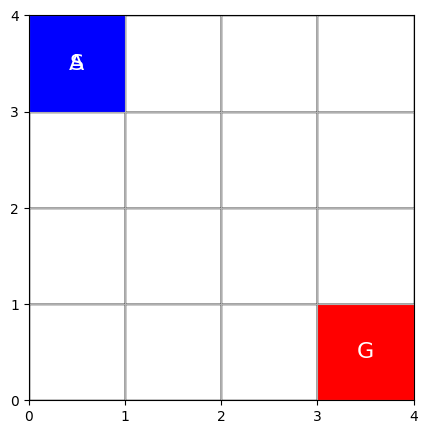

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

class GridWorld:
    def __init__(self, size=4, start=(0,0), goal=(3,3)):
        self.size = size
        self.start = start
        self.goal = goal
        self.state = start

    def reset(self):
        self.state = self.start
        return self.state

    def render(self):
        fig, ax = plt.subplots(figsize=(5,5))

        # Draw grid cells
        for i in range(self.size):
            for j in range(self.size):
                rect = patches.Rectangle((j, self.size-1-i), 1, 1,
                                         linewidth=1, edgecolor='black', facecolor='white')
                ax.add_patch(rect)

        # Draw start, goal, and agent
        sx, sy = self.start
        gx, gy = self.goal
        ax.add_patch(patches.Rectangle((sy, self.size-1-sx), 1, 1, facecolor='green'))
        ax.add_patch(patches.Rectangle((gy, self.size-1-gx), 1, 1, facecolor='red'))

        ax.add_patch(patches.Rectangle((self.state[1], self.size-1-self.state[0]), 1, 1, facecolor='blue'))

        # Optional: text labels
        ax.text(sy+0.5, self.size-1-sx+0.5, 'S', ha='center', va='center', color='white', fontsize=16)
        ax.text(gy+0.5, self.size-1-gx+0.5, 'G', ha='center', va='center', color='white', fontsize=16)
        ax.text(self.state[1]+0.5, self.size-1-self.state[0]+0.5, 'A', ha='center', va='center', color='white', fontsize=16)

        ax.set_xlim(0, self.size)
        ax.set_ylim(0, self.size)
        ax.set_xticks(range(self.size+1))
        ax.set_yticks(range(self.size+1))
        ax.set_aspect('equal')
        plt.grid(True)
        plt.show(block=False)
        plt.pause(0.8)
        plt.clf()


# Example usage
env = GridWorld()
env.reset()

# Just show start, goal, and agent
env.render()
plt.close()


# DQN **baseline**

-  Un environnement GridWorld avec un goal dynamique (qui bouge).
-  Un agent DQN (Deep Q-Network) — qui approxime la fonction Q(s,a) avec un réseau de neurones.
- Une extraction automatique des features : l’agent reçoit simplement l’état brut (x_agent, y_agent, x_goal, y_goal) et apprend lui-même les représentations utiles.

Episode 1/500 - Reward: 0.64 - Epsilon: 0.995
Episode 2/500 - Reward: 0.80 - Epsilon: 0.990
Episode 3/500 - Reward: 0.54 - Epsilon: 0.985
Episode 4/500 - Reward: 0.90 - Epsilon: 0.980
Episode 5/500 - Reward: 0.92 - Epsilon: 0.975
Episode 6/500 - Reward: 0.80 - Epsilon: 0.970
Episode 7/500 - Reward: 1.00 - Epsilon: 0.966
Episode 8/500 - Reward: -0.50 - Epsilon: 0.961
Episode 9/500 - Reward: 0.79 - Epsilon: 0.956
Episode 10/500 - Reward: 0.51 - Epsilon: 0.951
Episode 11/500 - Reward: 0.57 - Epsilon: 0.946
Episode 12/500 - Reward: 0.94 - Epsilon: 0.942
Episode 13/500 - Reward: 0.82 - Epsilon: 0.937
Episode 14/500 - Reward: 0.91 - Epsilon: 0.932
Episode 15/500 - Reward: -0.50 - Epsilon: 0.928
Episode 16/500 - Reward: 0.97 - Epsilon: 0.923
Episode 17/500 - Reward: -0.50 - Epsilon: 0.918
Episode 18/500 - Reward: 0.54 - Epsilon: 0.914
Episode 19/500 - Reward: -0.50 - Epsilon: 0.909
Episode 20/500 - Reward: 0.96 - Epsilon: 0.905
Episode 21/500 - Reward: 0.69 - Epsilon: 0.900
Episode 22/500 - R

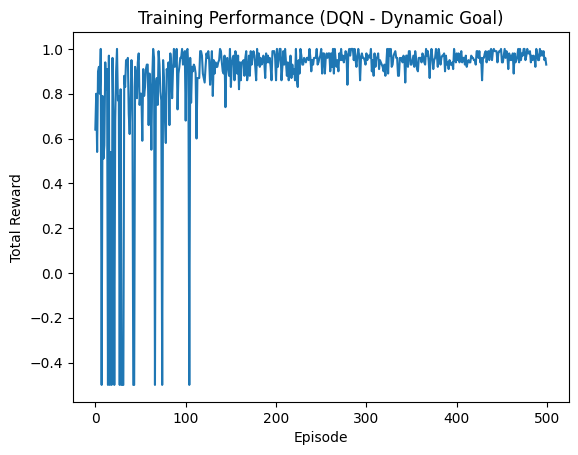

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt

# =======================
# 1️⃣ ENVIRONNEMENT DYNAMIQUE
# =======================
class GridWorld:
    def __init__(self, size=5):
        self.size = size
        self.reset()

    def reset(self):
        self.agent_pos = np.array([0, 0])
        self.goal_pos = np.random.randint(0, self.size, size=2)
        return self._get_state()

    def step(self, action):
        """Actions: 0=up, 1=down, 2=left, 3=right"""
        moves = {0: (-1, 0), 1: (1, 0), 2: (0, -1), 3: (0, 1)}
        move = moves[action]
        new_pos = self.agent_pos + np.array(move)
        new_pos = np.clip(new_pos, 0, self.size - 1)
        self.agent_pos = new_pos

        # Reward
        if np.array_equal(self.agent_pos, self.goal_pos):
            reward = 1.0
            done = True
        else:
            reward = -0.01
            done = False

        # Dynamic goal (move randomly)
        if random.random() < 0.3:  # 30% chance
            self.goal_pos += random.choice([[1,0],[-1,0],[0,1],[0,-1]])
            self.goal_pos = np.clip(self.goal_pos, 0, self.size - 1)

        return self._get_state(), reward, done

    def _get_state(self):
        # Raw continuous input normalized
        return np.concatenate((self.agent_pos, self.goal_pos)).astype(np.float32) / self.size


# =======================
# 2️⃣ DQN AGENT
# =======================
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.net(x)


class Agent:
    def __init__(self, state_dim, action_dim, lr=1e-3, gamma=0.99):
        self.model = DQN(state_dim, action_dim)
        self.target_model = DQN(state_dim, action_dim)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.gamma = gamma
        self.epsilon = 1.0
        self.memory = []
        self.batch_size = 64

    def act(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, 3)
        state = torch.FloatTensor(state).unsqueeze(0)
        q_values = self.model(state)
        return q_values.argmax().item()

    def remember(self, s, a, r, s_next, done):
        self.memory.append((s, a, r, s_next, done))
        if len(self.memory) > 5000:
            self.memory.pop(0)

    def learn(self):
        if len(self.memory) < self.batch_size:
            return

        batch = random.sample(self.memory, self.batch_size)
        s, a, r, s_next, done = zip(*batch)
        s = torch.FloatTensor(s)
        a = torch.LongTensor(a).unsqueeze(1)
        r = torch.FloatTensor(r).unsqueeze(1)
        s_next = torch.FloatTensor(s_next)
        done = torch.FloatTensor(done).unsqueeze(1)

        q_values = self.model(s).gather(1, a)
        with torch.no_grad():
            q_next = self.target_model(s_next).max(1)[0].unsqueeze(1)
            q_target = r + self.gamma * q_next * (1 - done)

        loss = nn.MSELoss()(q_values, q_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target(self):
        self.target_model.load_state_dict(self.model.state_dict())


# =======================
# 3️⃣ TRAINING LOOP (NO VISUAL)
# =======================
env = GridWorld(size=5)
agent = Agent(state_dim=4, action_dim=4)

episodes = 500
rewards_per_episode = []

for ep in range(episodes):
    s = env.reset()
    total_reward = 0
    for t in range(50):
        a = agent.act(s)
        s_next, r, done = env.step(a)
        agent.remember(s, a, r, s_next, done)
        agent.learn()
        s = s_next
        total_reward += r
        if done:
            break

    rewards_per_episode.append(total_reward)
    agent.update_target()
    agent.epsilon = max(0.05, agent.epsilon * 0.995)
    print(f"Episode {ep+1}/{episodes} - Reward: {total_reward:.2f} - Epsilon: {agent.epsilon:.3f}")

# =======================
# 4️⃣ VISUALISATION DES RÉSULTATS
# =======================
plt.plot(rewards_per_episode)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Training Performance (DQN - Dynamic Goal)')
plt.show()


the visualisation mais tres lente

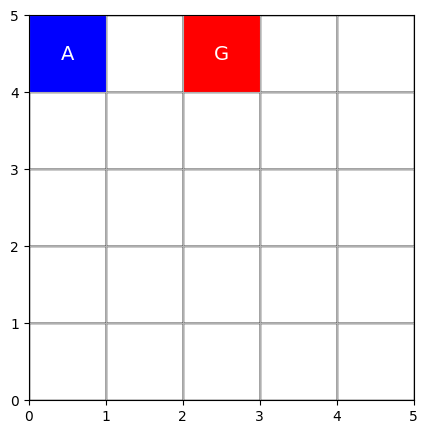

<Figure size 640x480 with 0 Axes>

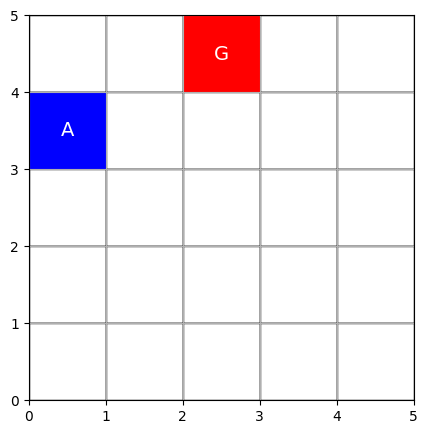

<Figure size 640x480 with 0 Axes>

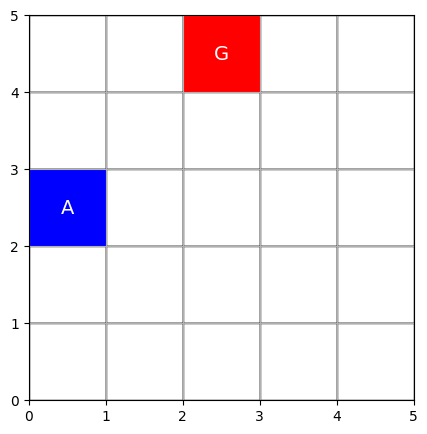

<Figure size 640x480 with 0 Axes>

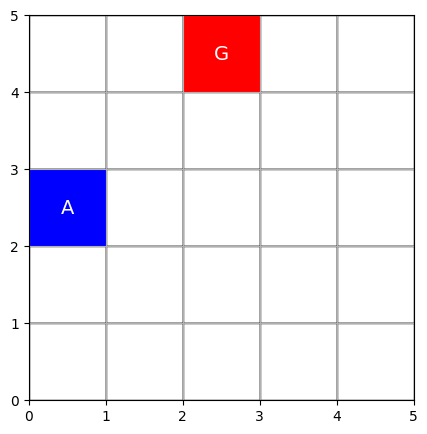

<Figure size 640x480 with 0 Axes>

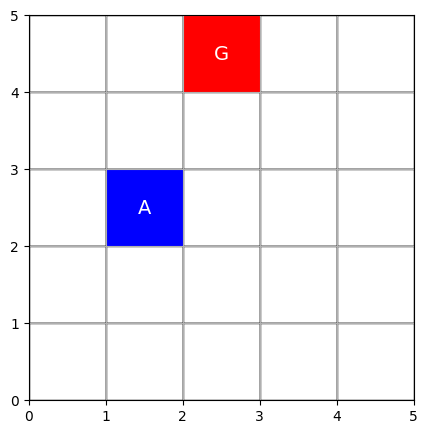

<Figure size 640x480 with 0 Axes>

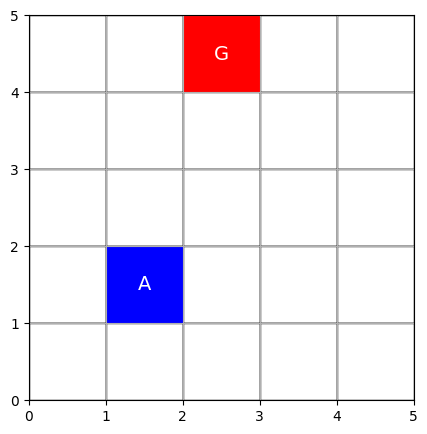

<Figure size 640x480 with 0 Axes>

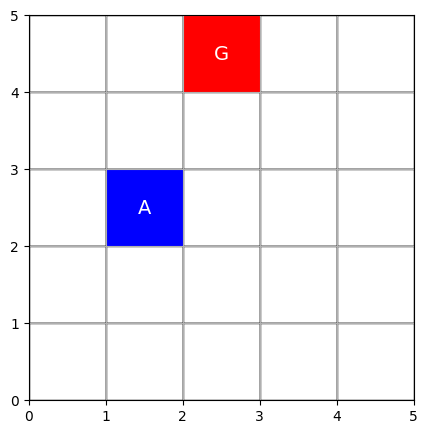

<Figure size 640x480 with 0 Axes>

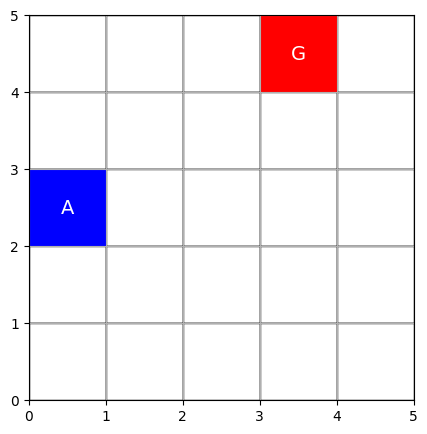

<Figure size 640x480 with 0 Axes>

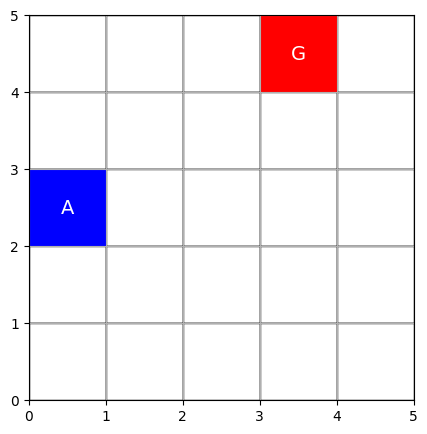

<Figure size 640x480 with 0 Axes>

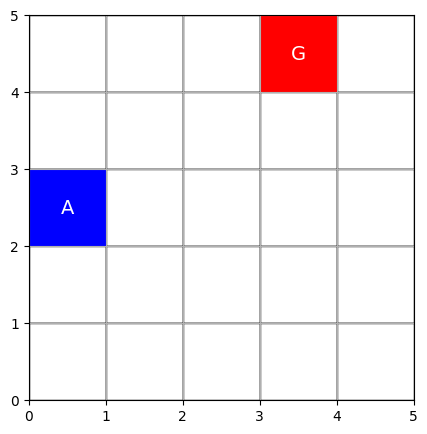

<Figure size 640x480 with 0 Axes>

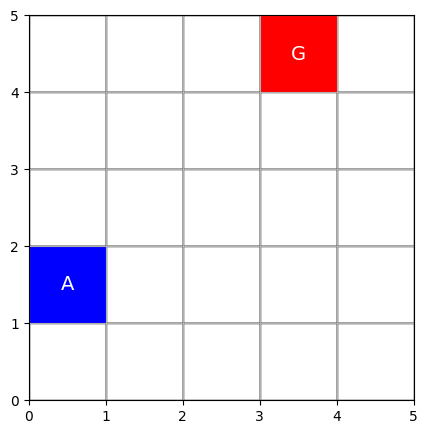

<Figure size 640x480 with 0 Axes>

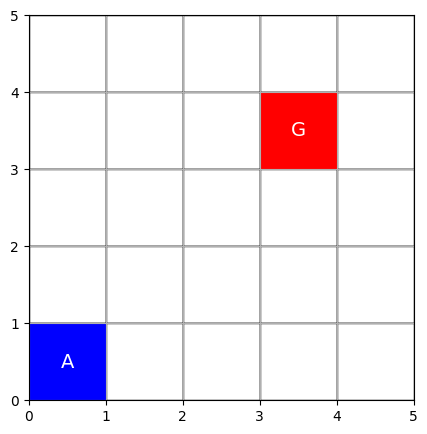

<Figure size 640x480 with 0 Axes>

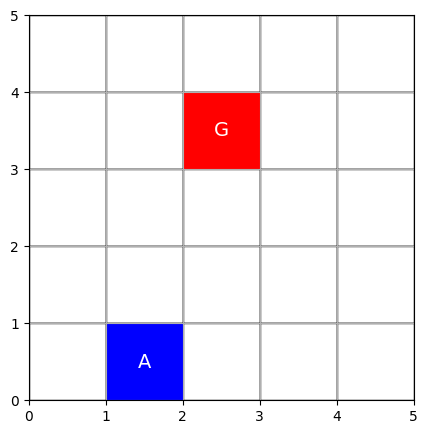

<Figure size 640x480 with 0 Axes>

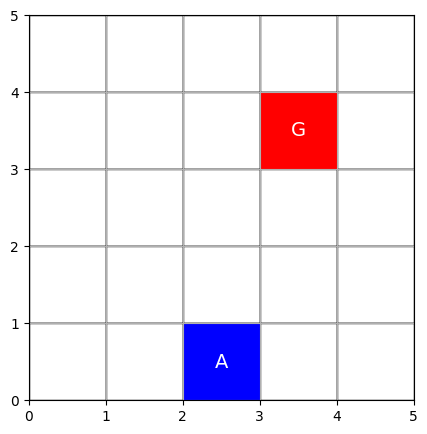

<Figure size 640x480 with 0 Axes>

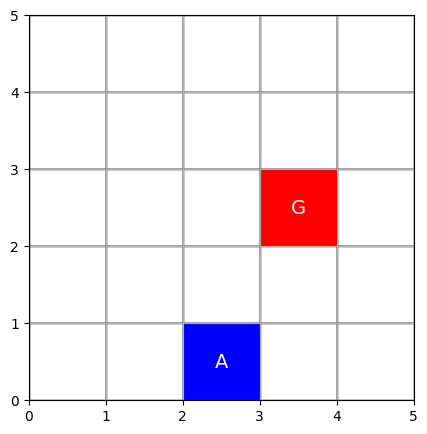

<Figure size 640x480 with 0 Axes>

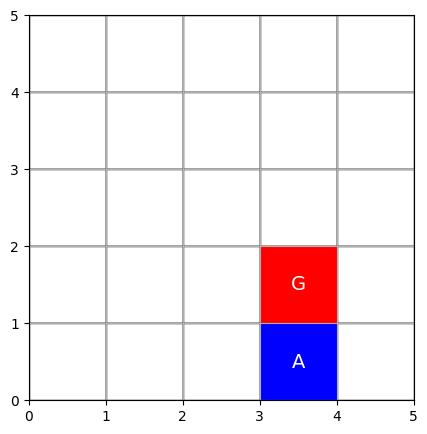

<Figure size 640x480 with 0 Axes>

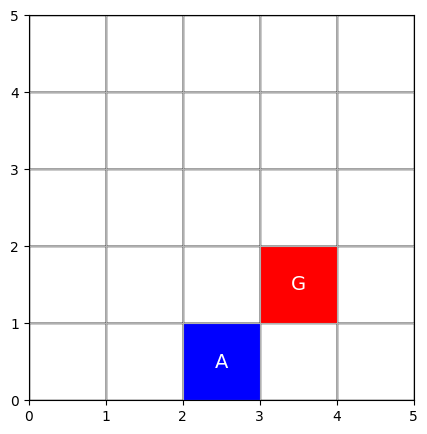

<Figure size 640x480 with 0 Axes>

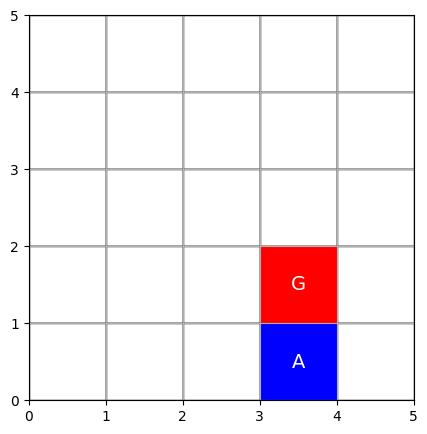

<Figure size 640x480 with 0 Axes>

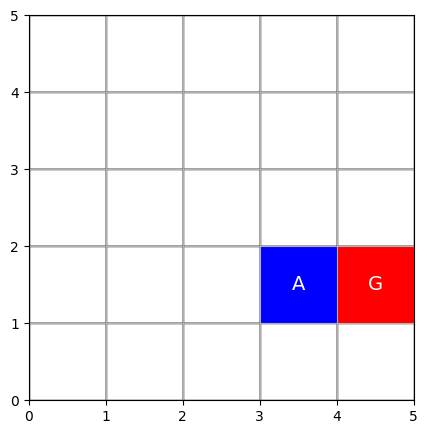

Episode 1/200 - Reward: 0.82


<Figure size 640x480 with 0 Axes>

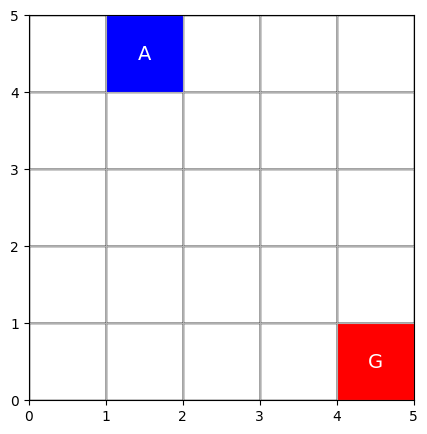

<Figure size 640x480 with 0 Axes>

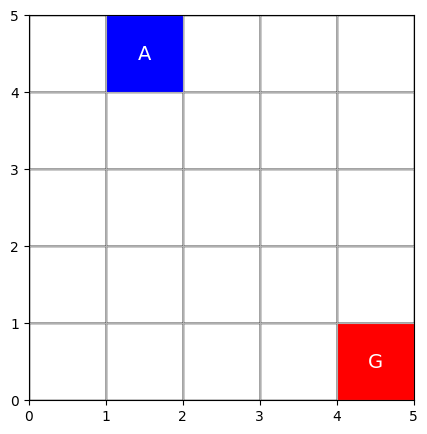

<Figure size 640x480 with 0 Axes>

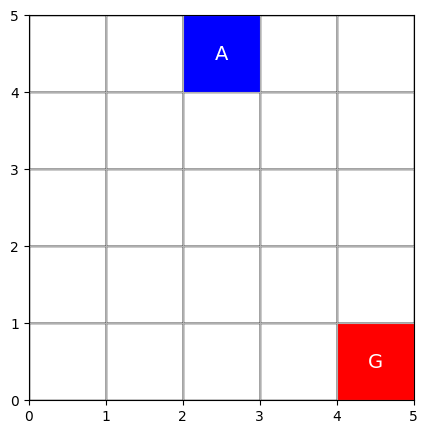

<Figure size 640x480 with 0 Axes>

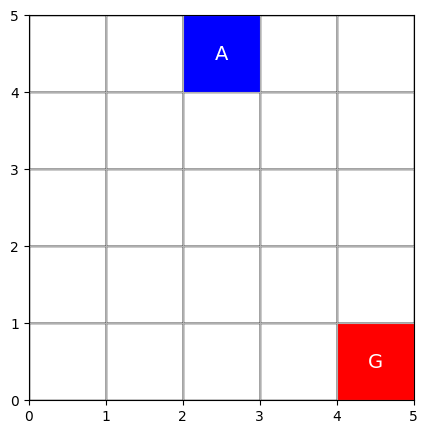

<Figure size 640x480 with 0 Axes>

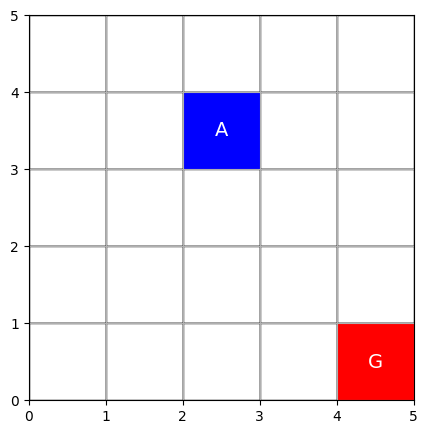

<Figure size 640x480 with 0 Axes>

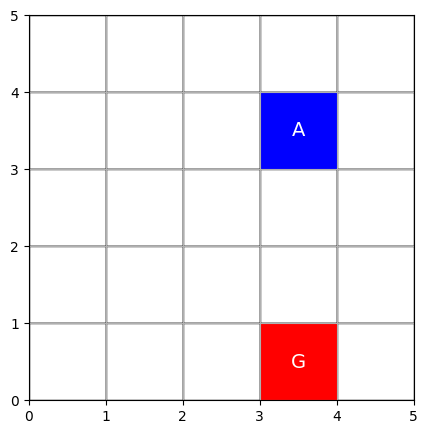

<Figure size 640x480 with 0 Axes>

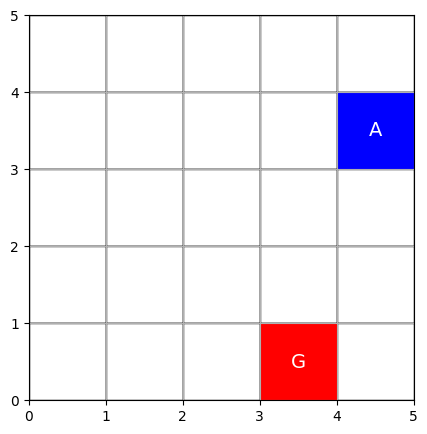

<Figure size 640x480 with 0 Axes>

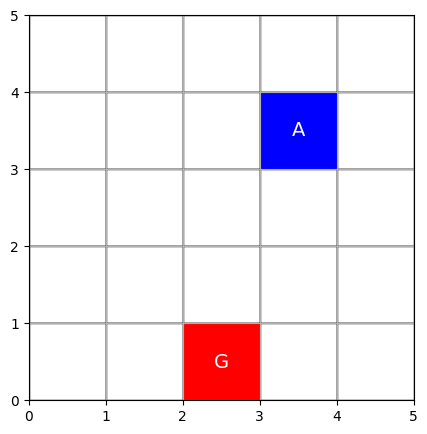

<Figure size 640x480 with 0 Axes>

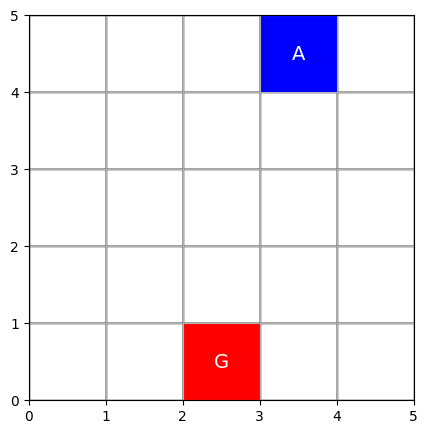

<Figure size 640x480 with 0 Axes>

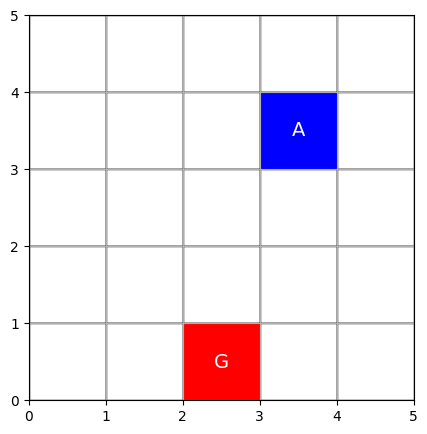

<Figure size 640x480 with 0 Axes>

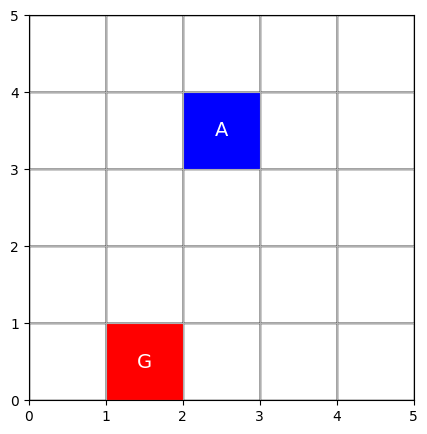

<Figure size 640x480 with 0 Axes>

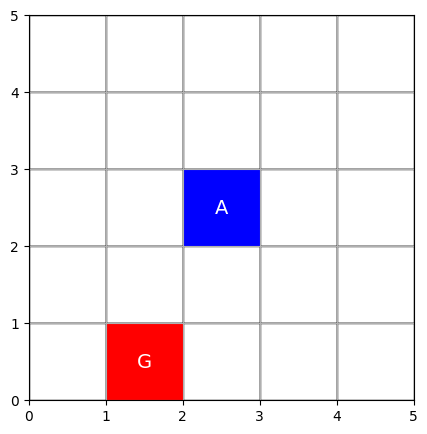

<Figure size 640x480 with 0 Axes>

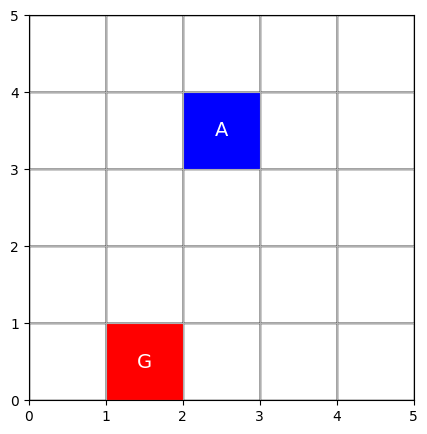

<Figure size 640x480 with 0 Axes>

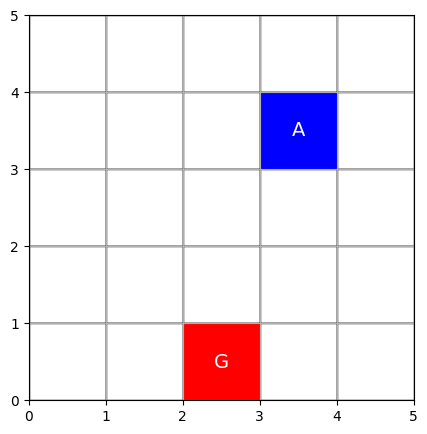

<Figure size 640x480 with 0 Axes>

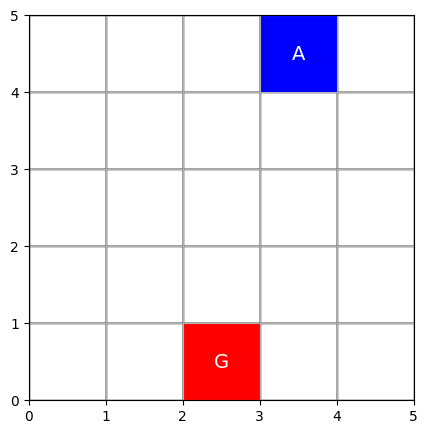

<Figure size 640x480 with 0 Axes>

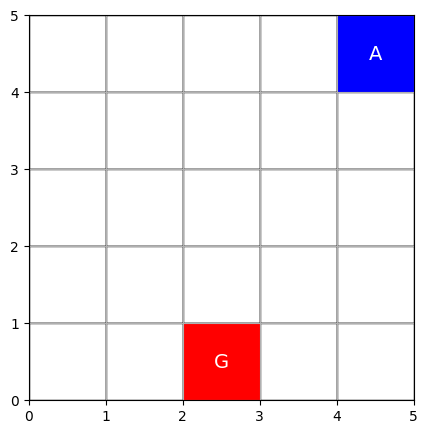

<Figure size 640x480 with 0 Axes>

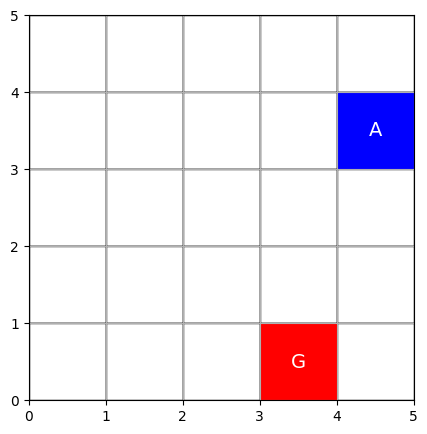

<Figure size 640x480 with 0 Axes>

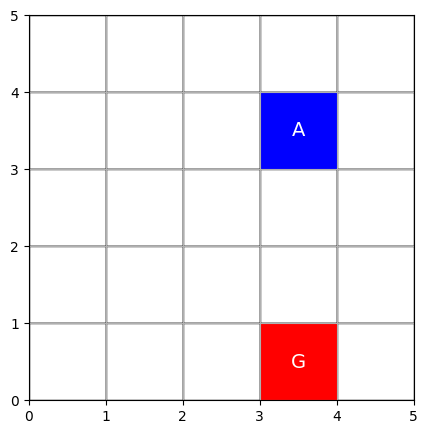

<Figure size 640x480 with 0 Axes>

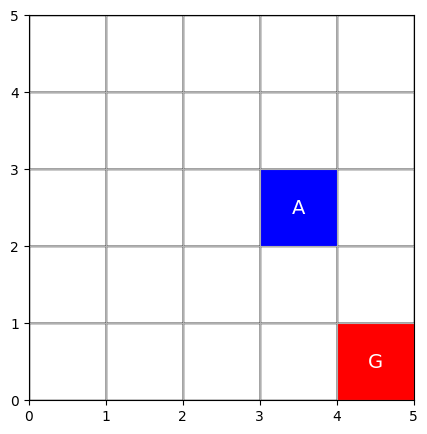

<Figure size 640x480 with 0 Axes>

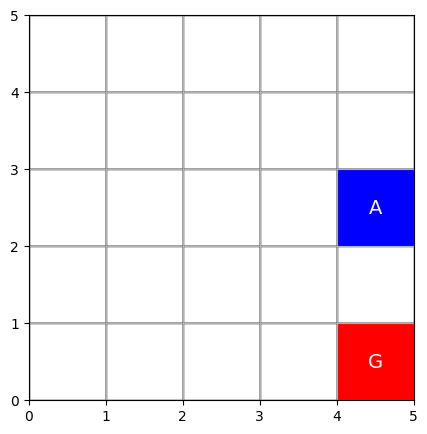

<Figure size 640x480 with 0 Axes>

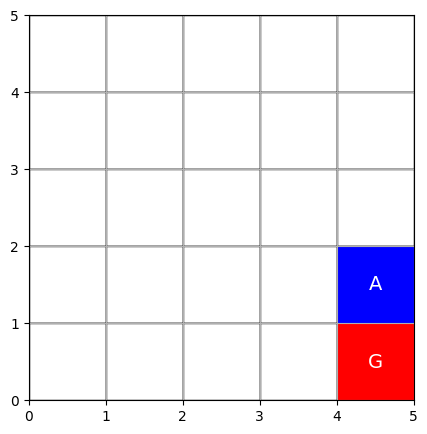

<Figure size 640x480 with 0 Axes>

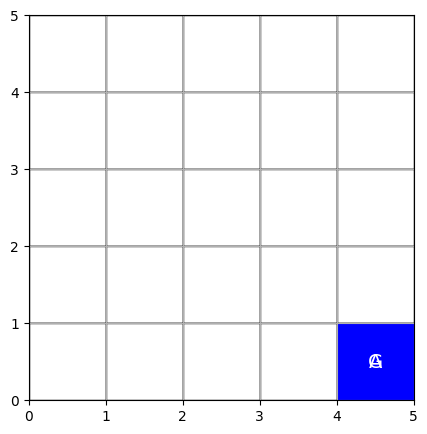

Episode 2/200 - Reward: 0.79


<Figure size 640x480 with 0 Axes>

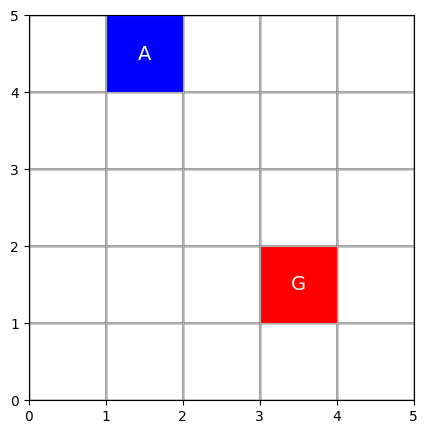

<Figure size 640x480 with 0 Axes>

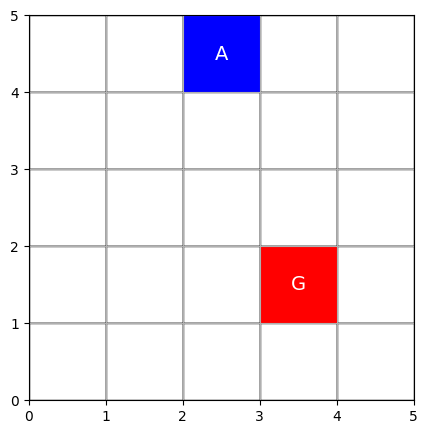

<Figure size 640x480 with 0 Axes>

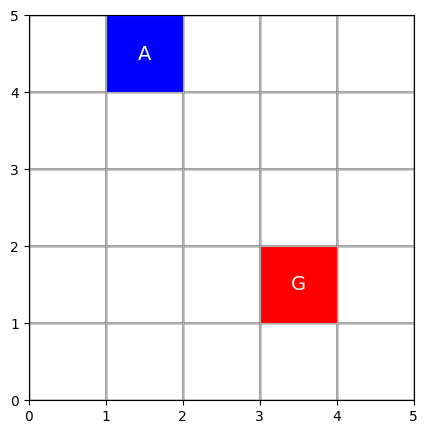

<Figure size 640x480 with 0 Axes>

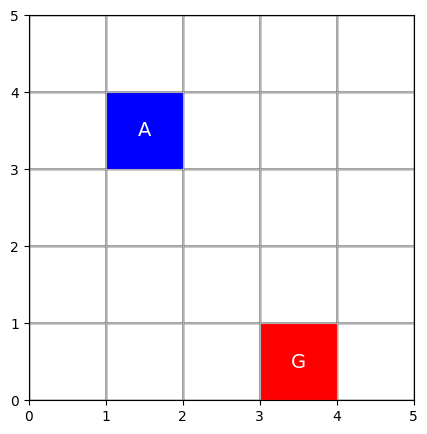

<Figure size 640x480 with 0 Axes>

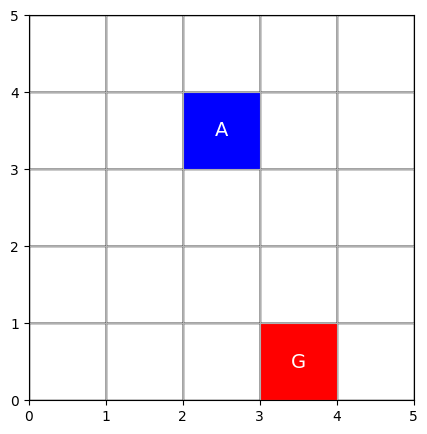

<Figure size 640x480 with 0 Axes>

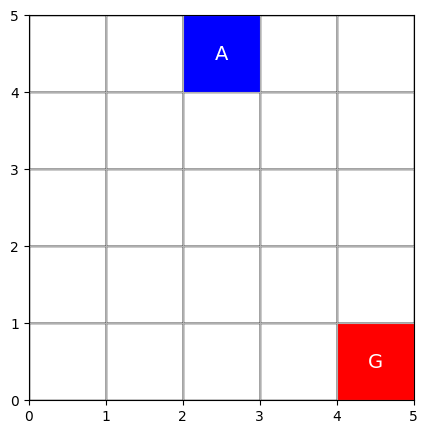

<Figure size 640x480 with 0 Axes>

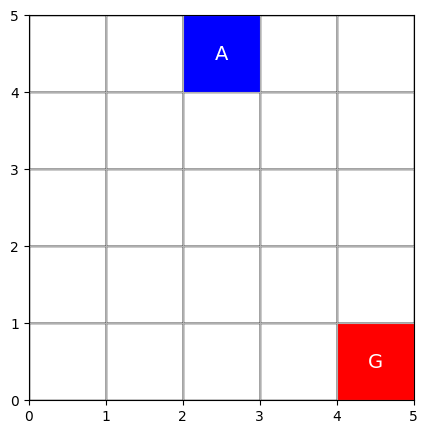

<Figure size 640x480 with 0 Axes>

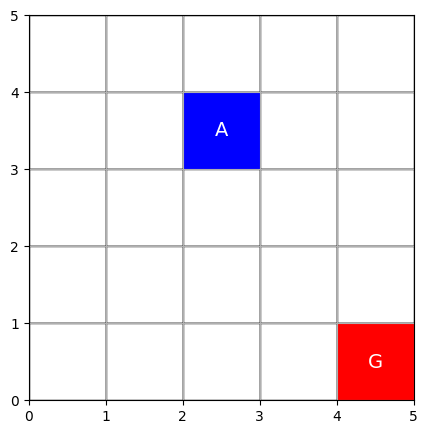

<Figure size 640x480 with 0 Axes>

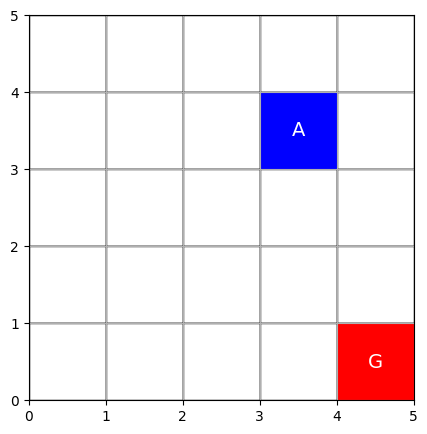

<Figure size 640x480 with 0 Axes>

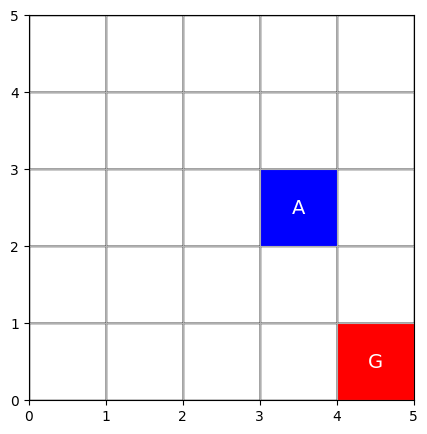

<Figure size 640x480 with 0 Axes>

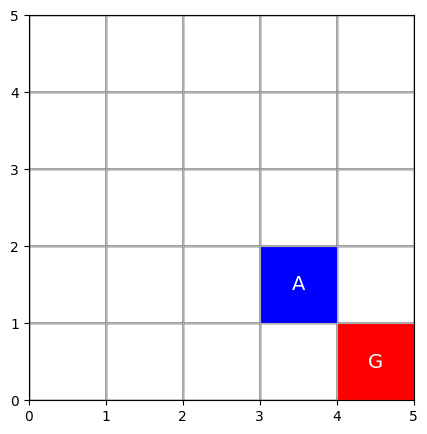

<Figure size 640x480 with 0 Axes>

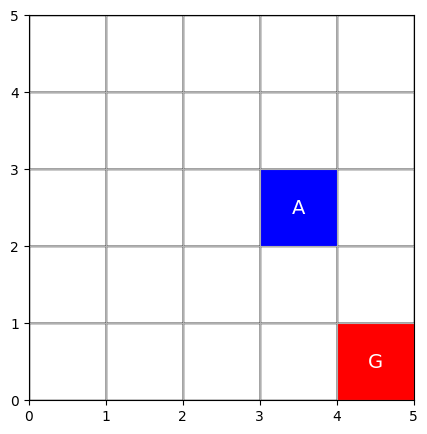

<Figure size 640x480 with 0 Axes>

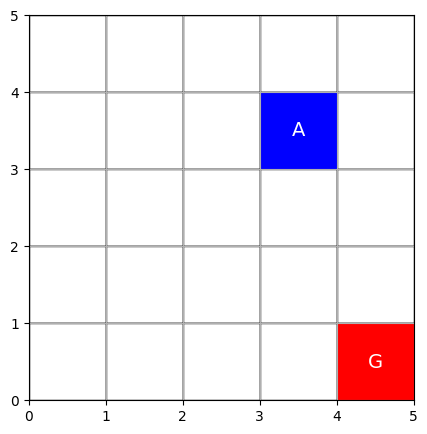

<Figure size 640x480 with 0 Axes>

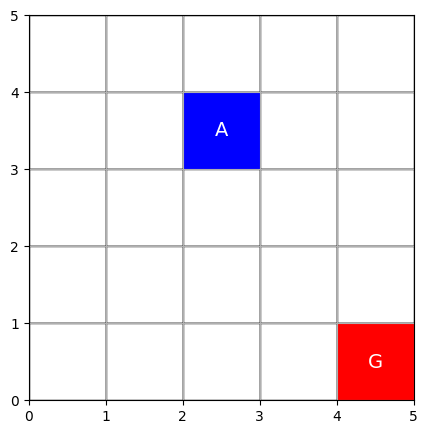

<Figure size 640x480 with 0 Axes>

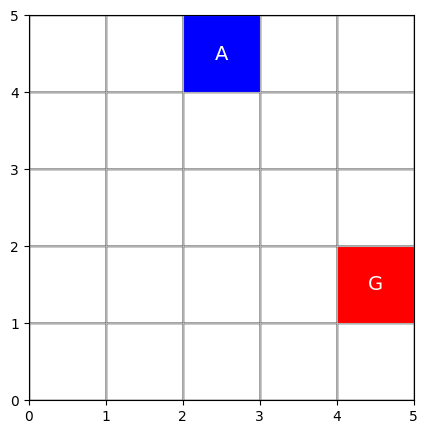

<Figure size 640x480 with 0 Axes>

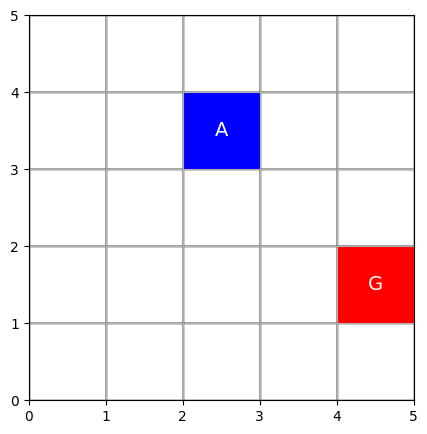

<Figure size 640x480 with 0 Axes>

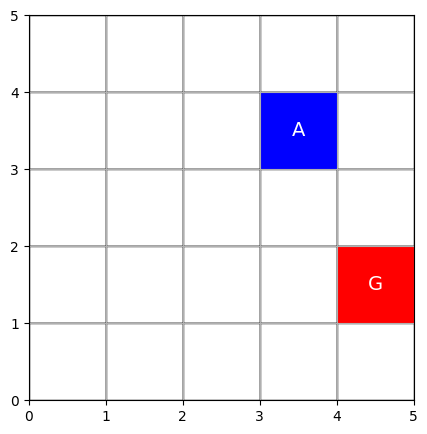

<Figure size 640x480 with 0 Axes>

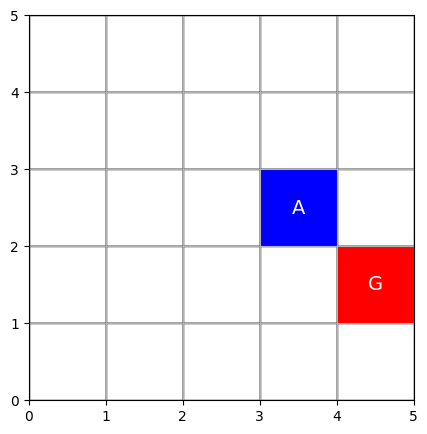

<Figure size 640x480 with 0 Axes>

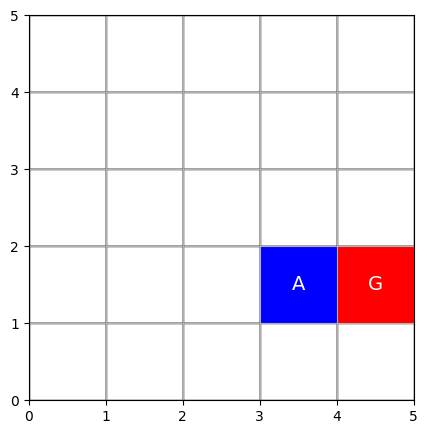

<Figure size 640x480 with 0 Axes>

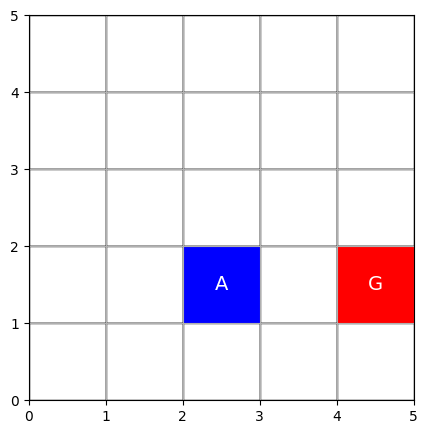

<Figure size 640x480 with 0 Axes>

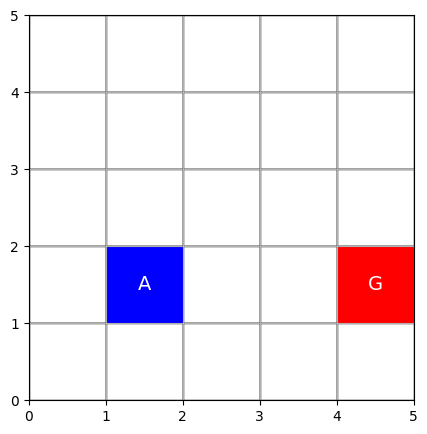

<Figure size 640x480 with 0 Axes>

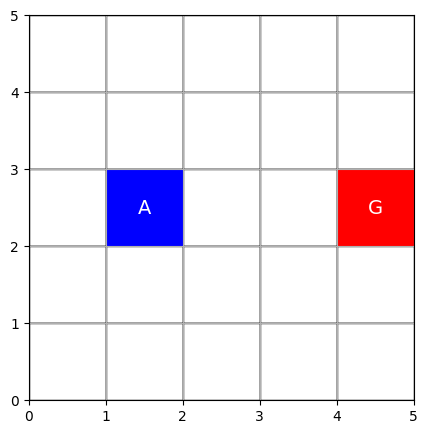

/tmp/ipython-input-1990096978.py:123: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  s = torch.FloatTensor(s)


<Figure size 640x480 with 0 Axes>

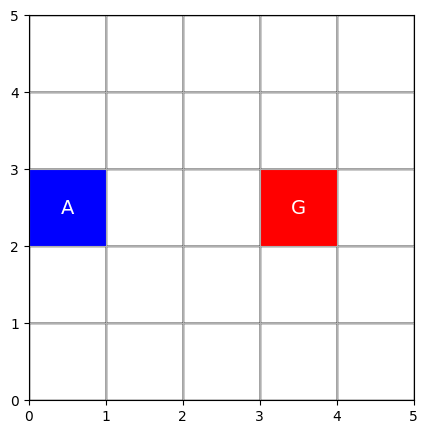

<Figure size 640x480 with 0 Axes>

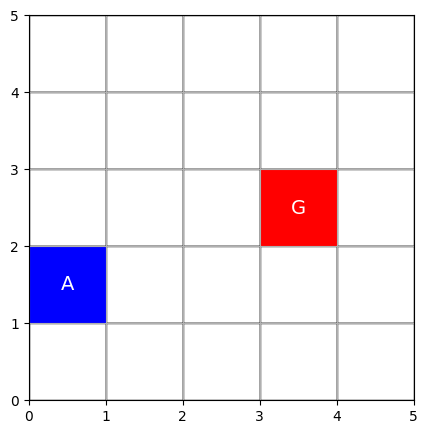

<Figure size 640x480 with 0 Axes>

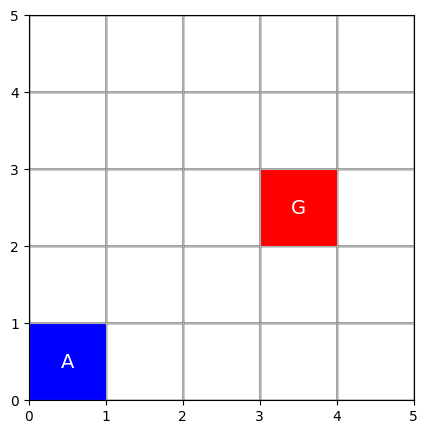

<Figure size 640x480 with 0 Axes>

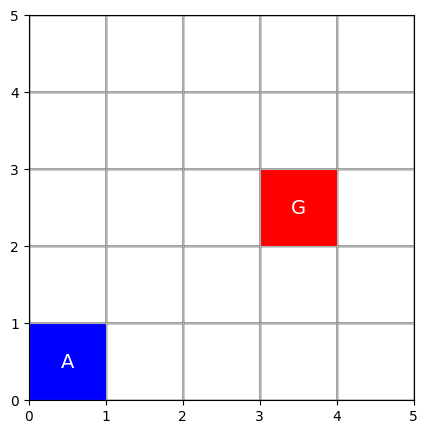

<Figure size 640x480 with 0 Axes>

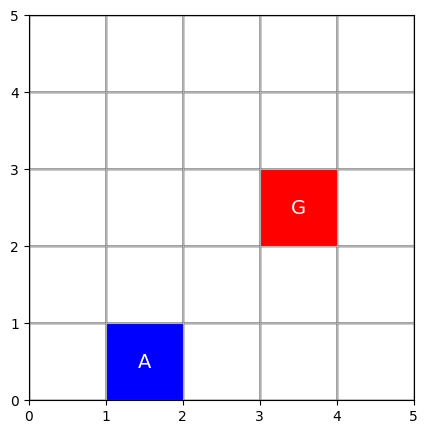

<Figure size 640x480 with 0 Axes>

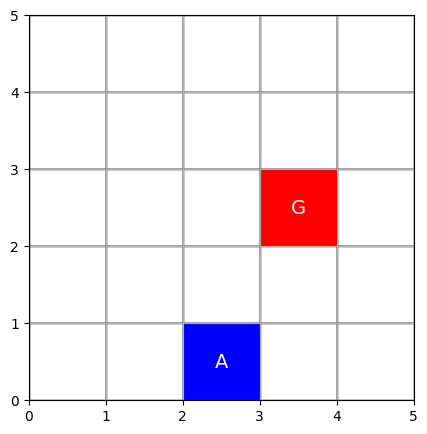

<Figure size 640x480 with 0 Axes>

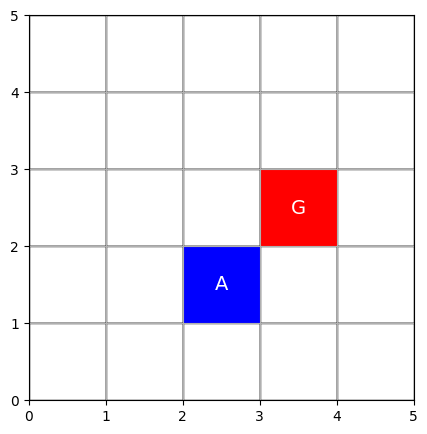

<Figure size 640x480 with 0 Axes>

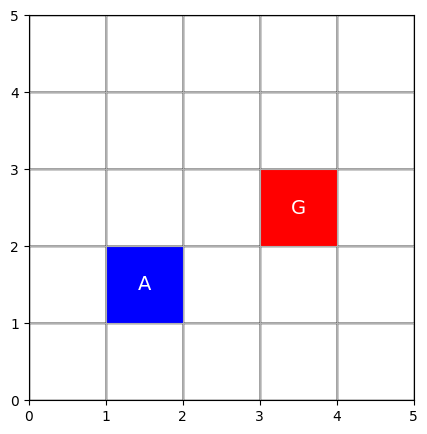

<Figure size 640x480 with 0 Axes>

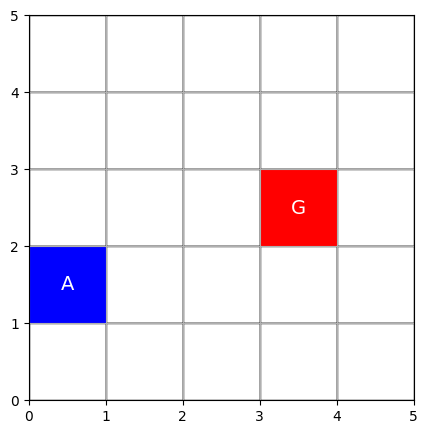

<Figure size 640x480 with 0 Axes>

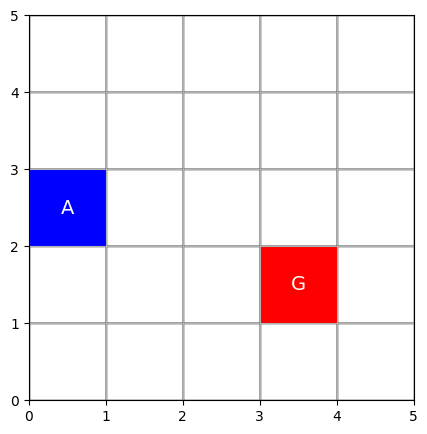

<Figure size 640x480 with 0 Axes>

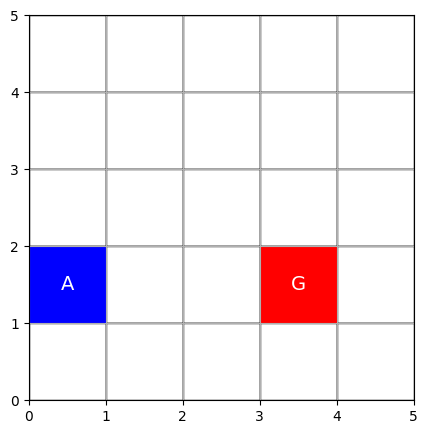

<Figure size 640x480 with 0 Axes>

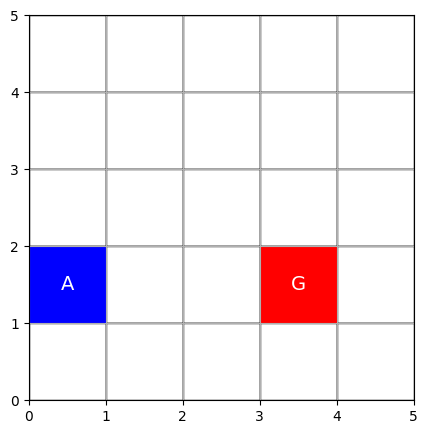

<Figure size 640x480 with 0 Axes>

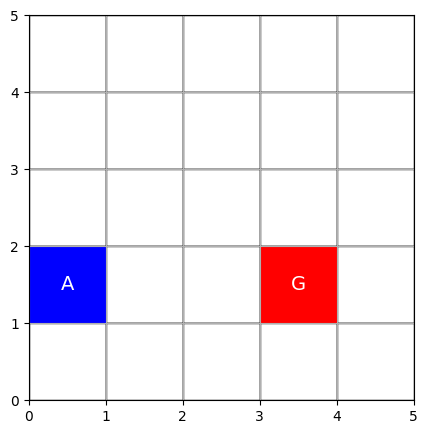

<Figure size 640x480 with 0 Axes>

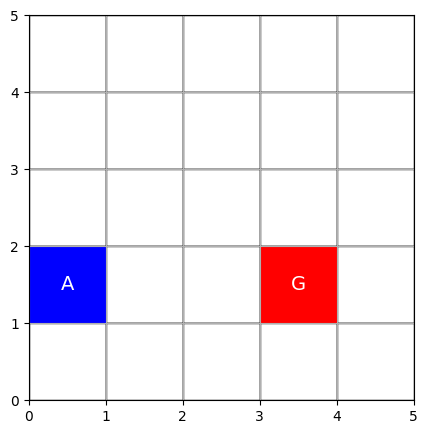

<Figure size 640x480 with 0 Axes>

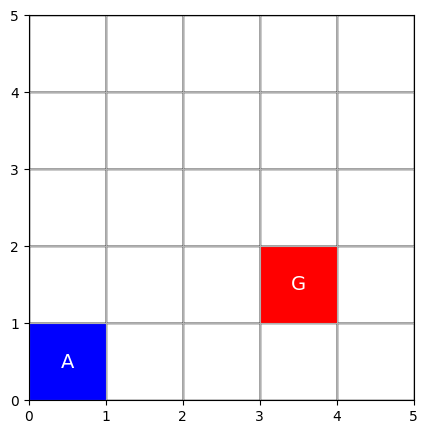

<Figure size 640x480 with 0 Axes>

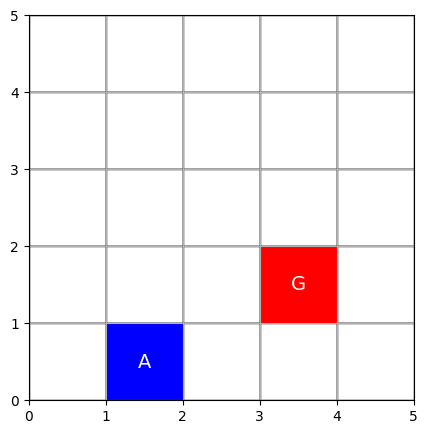

<Figure size 640x480 with 0 Axes>

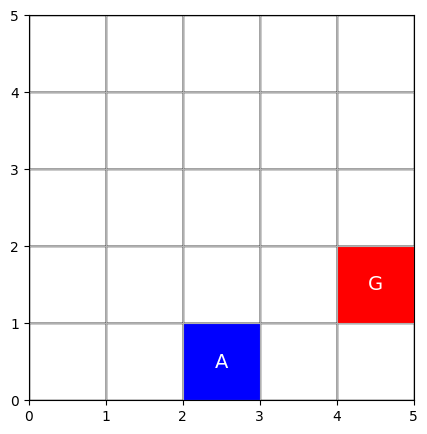

<Figure size 640x480 with 0 Axes>

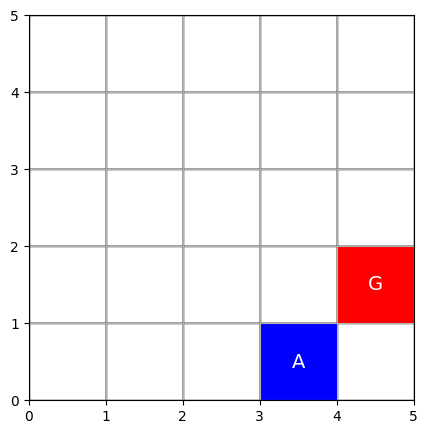

<Figure size 640x480 with 0 Axes>

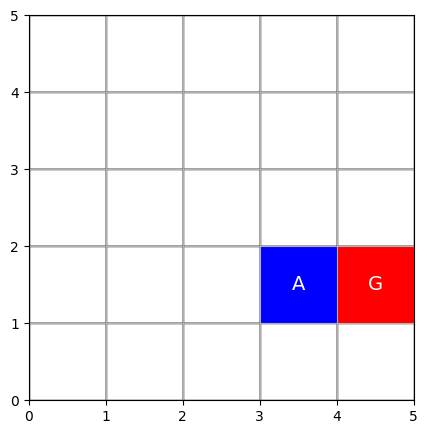

<Figure size 640x480 with 0 Axes>

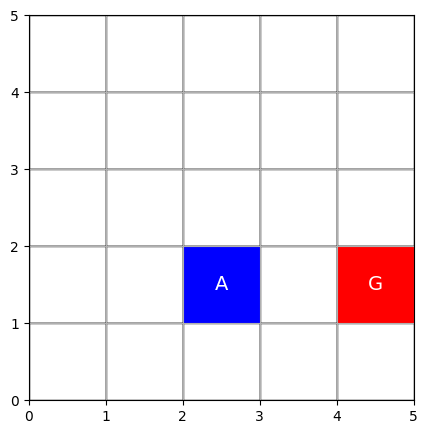

<Figure size 640x480 with 0 Axes>

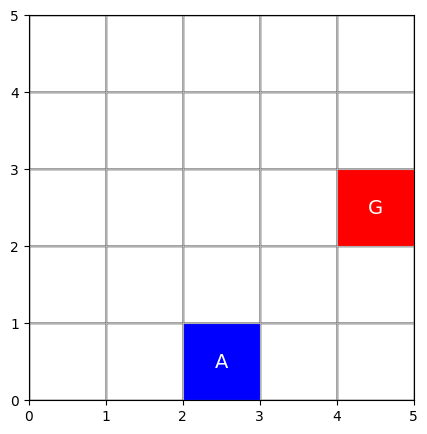

<Figure size 640x480 with 0 Axes>

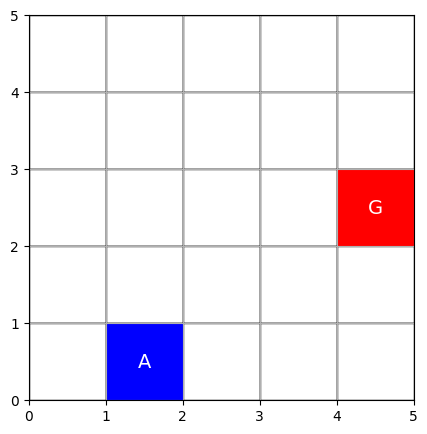

<Figure size 640x480 with 0 Axes>

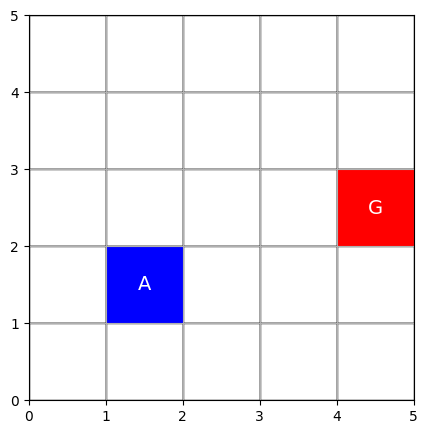

<Figure size 640x480 with 0 Axes>

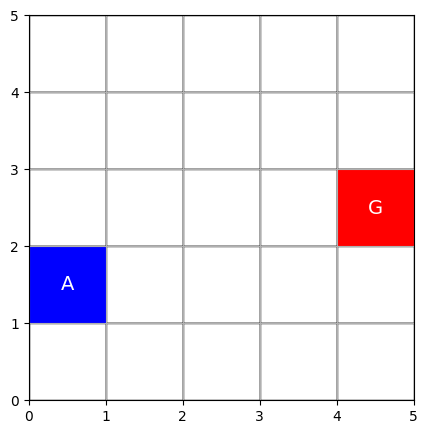

<Figure size 640x480 with 0 Axes>

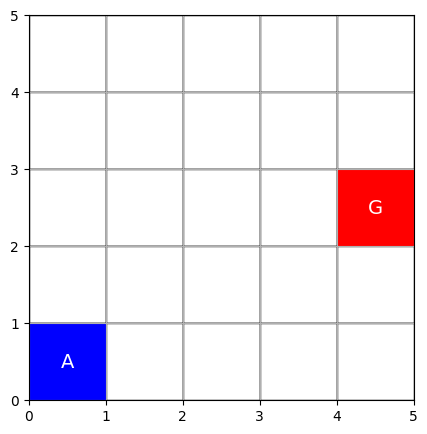

<Figure size 640x480 with 0 Axes>

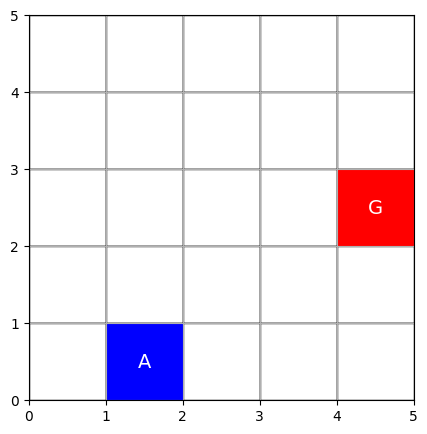

<Figure size 640x480 with 0 Axes>

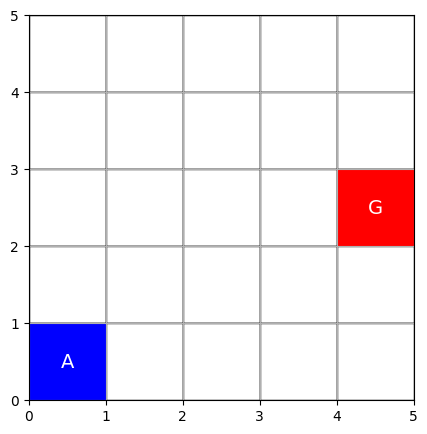

<Figure size 640x480 with 0 Axes>

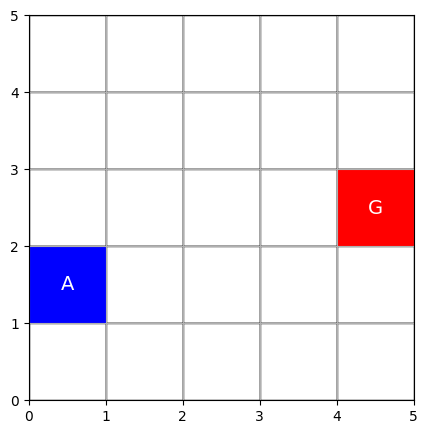

Episode 3/200 - Reward: -0.50


<Figure size 640x480 with 0 Axes>

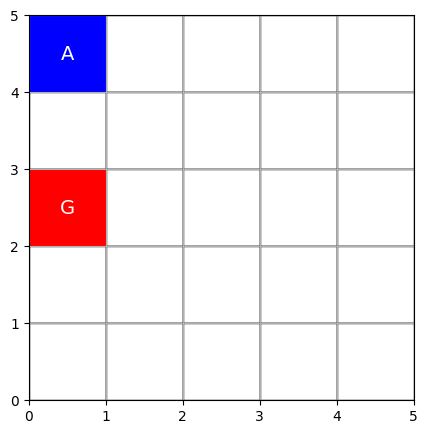

<Figure size 640x480 with 0 Axes>

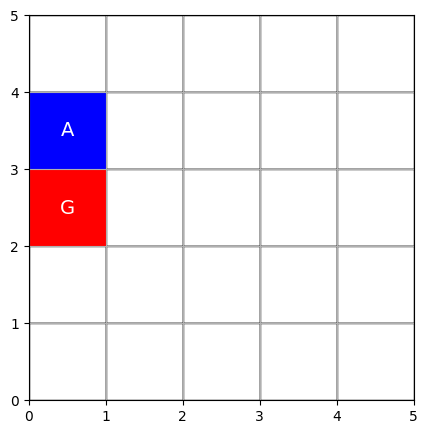

<Figure size 640x480 with 0 Axes>

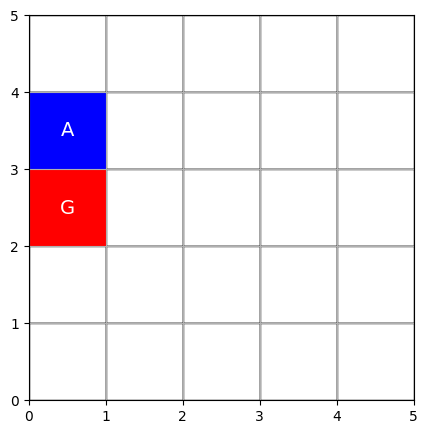

<Figure size 640x480 with 0 Axes>

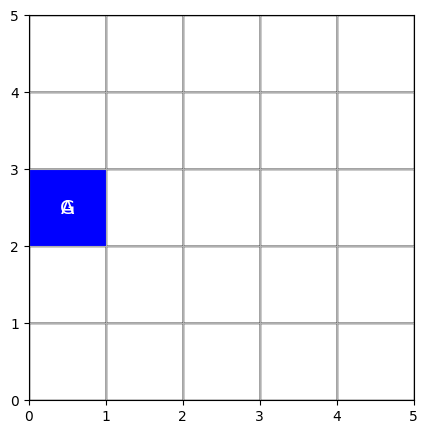

Episode 4/200 - Reward: 0.97


<Figure size 640x480 with 0 Axes>

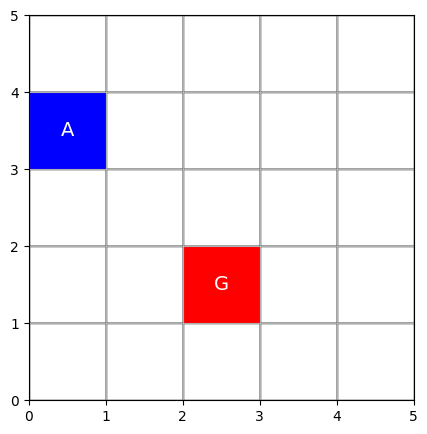

<Figure size 640x480 with 0 Axes>

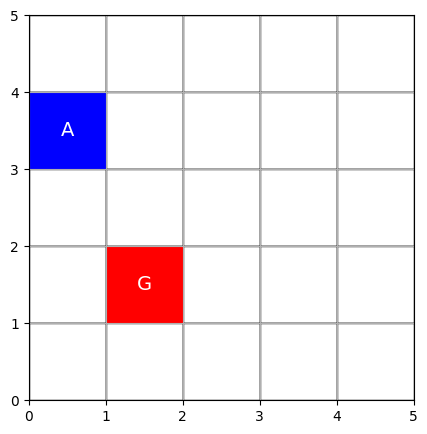

<Figure size 640x480 with 0 Axes>

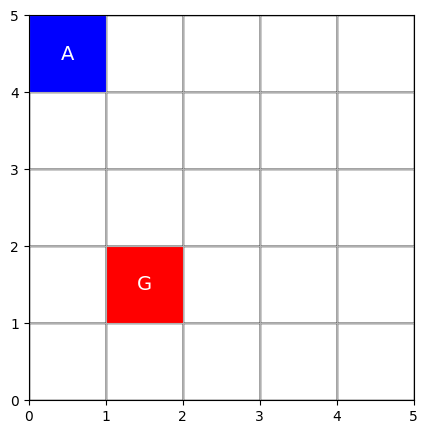

<Figure size 640x480 with 0 Axes>

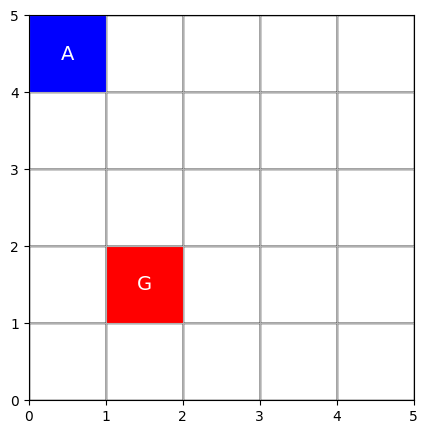

<Figure size 640x480 with 0 Axes>

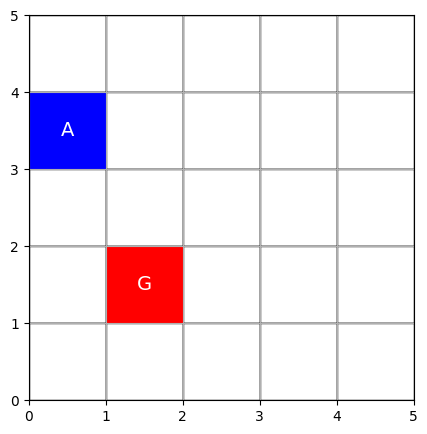

<Figure size 640x480 with 0 Axes>

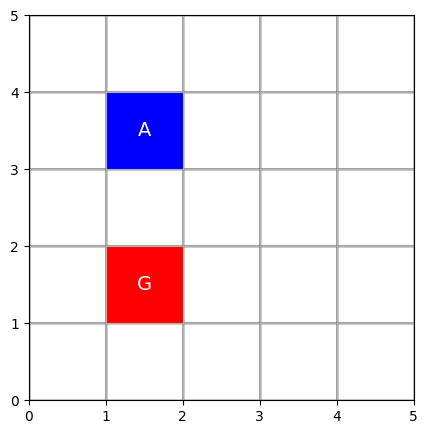

<Figure size 640x480 with 0 Axes>

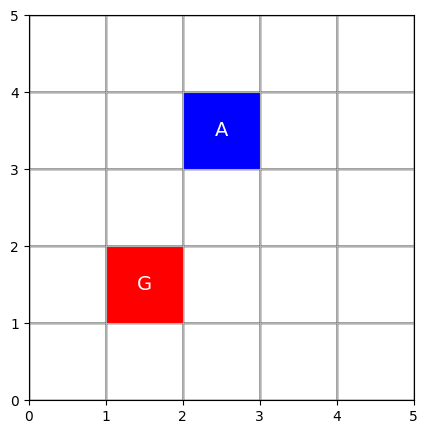

<Figure size 640x480 with 0 Axes>

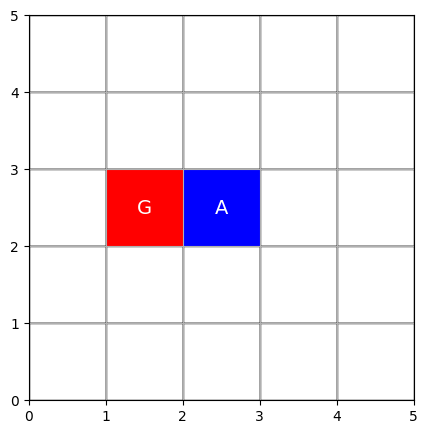

<Figure size 640x480 with 0 Axes>

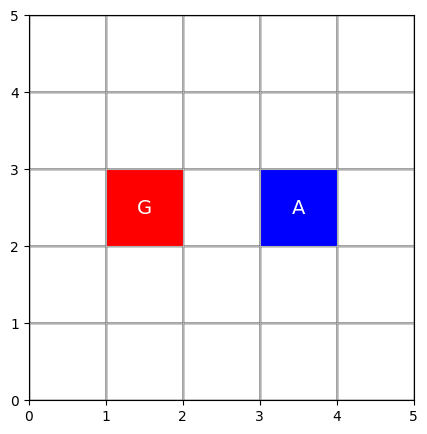

<Figure size 640x480 with 0 Axes>

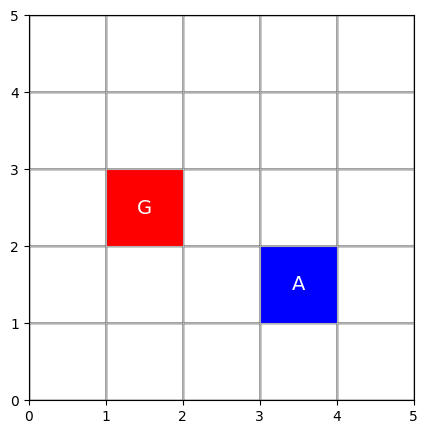

<Figure size 640x480 with 0 Axes>

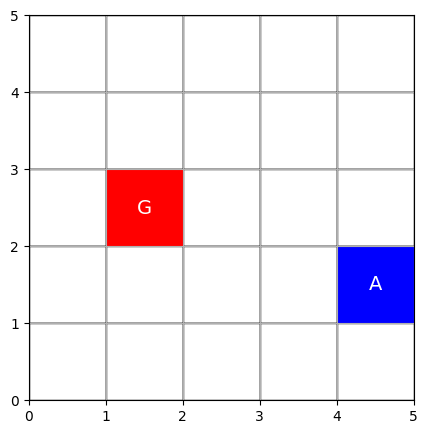

<Figure size 640x480 with 0 Axes>

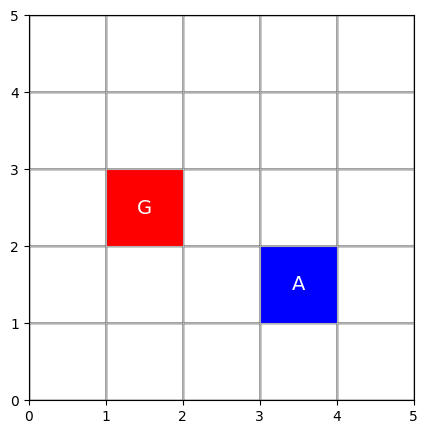

<Figure size 640x480 with 0 Axes>

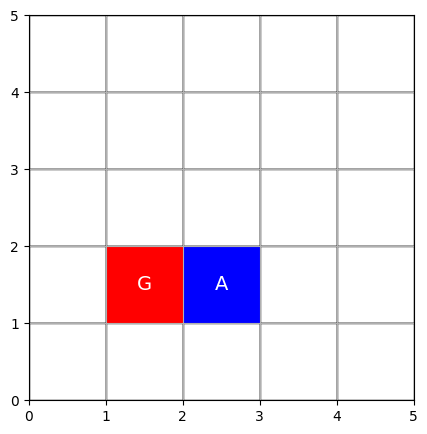

<Figure size 640x480 with 0 Axes>

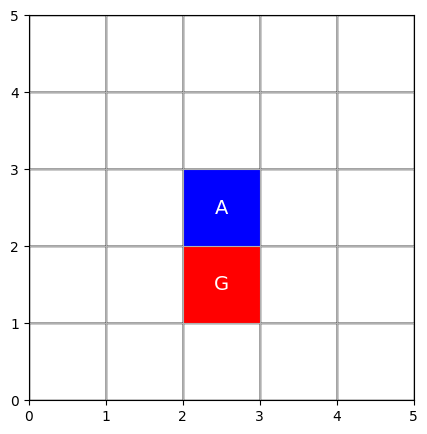

<Figure size 640x480 with 0 Axes>

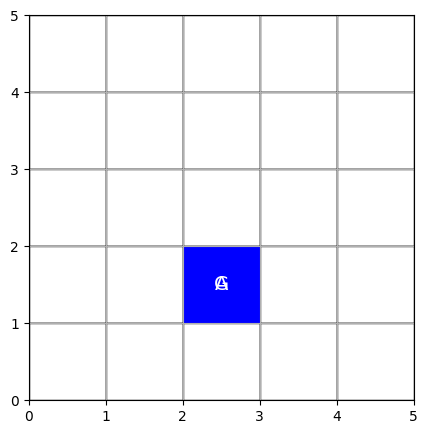

Episode 5/200 - Reward: 0.86


<Figure size 640x480 with 0 Axes>

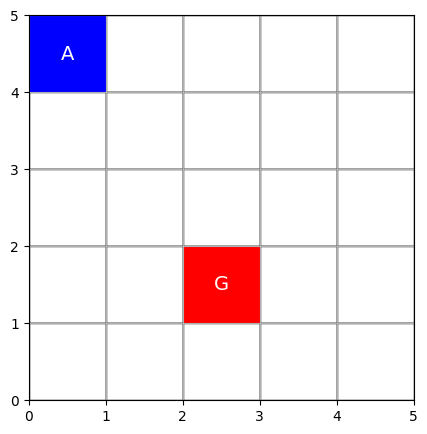

<Figure size 640x480 with 0 Axes>

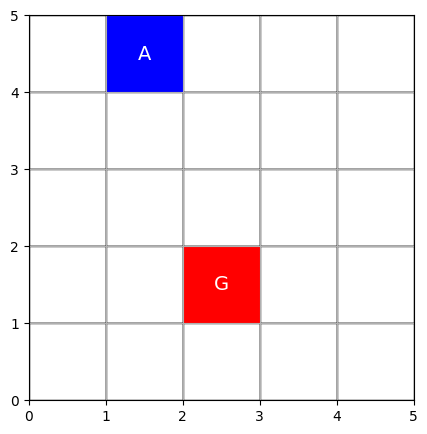

<Figure size 640x480 with 0 Axes>

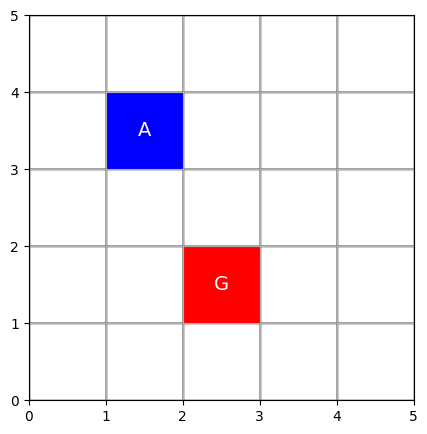

<Figure size 640x480 with 0 Axes>

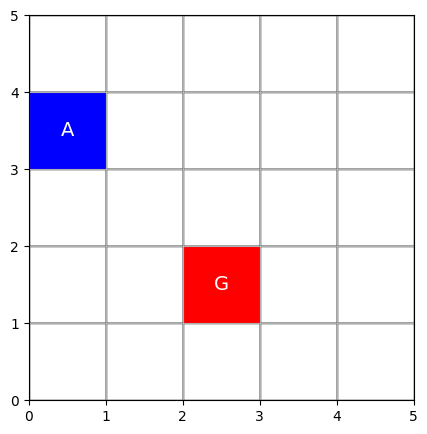

<Figure size 640x480 with 0 Axes>

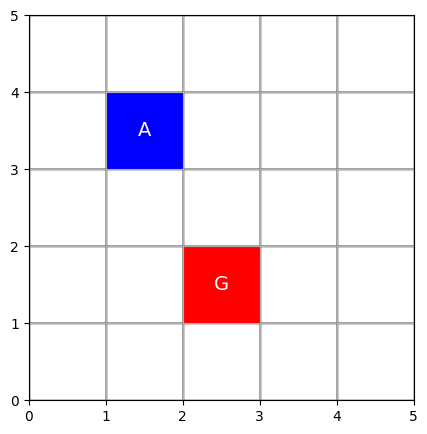

<Figure size 640x480 with 0 Axes>

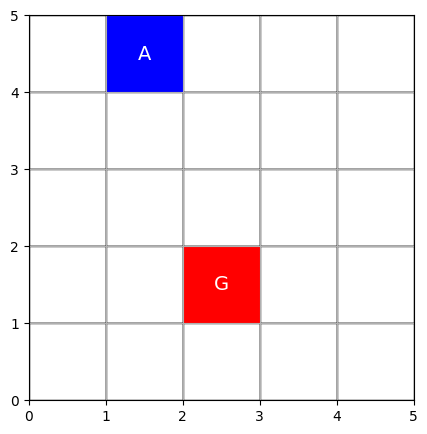

<Figure size 640x480 with 0 Axes>

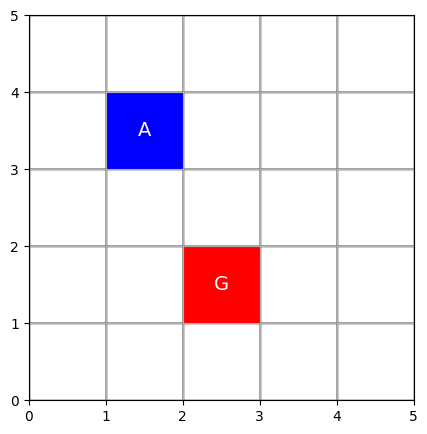

<Figure size 640x480 with 0 Axes>

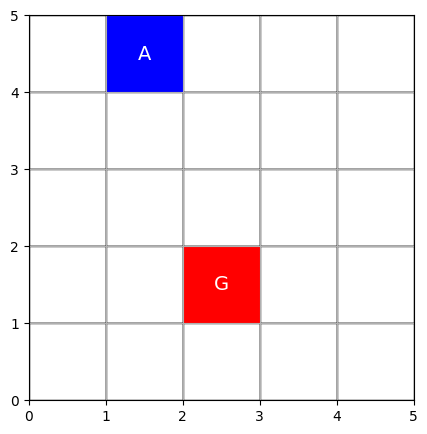

<Figure size 640x480 with 0 Axes>

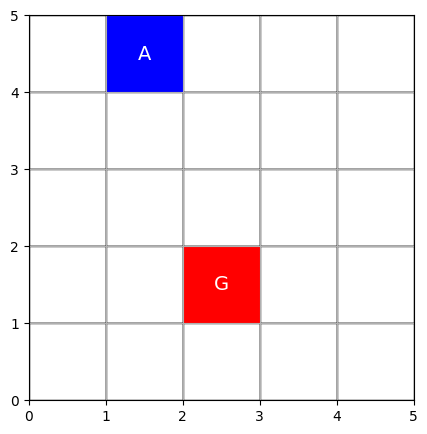

<Figure size 640x480 with 0 Axes>

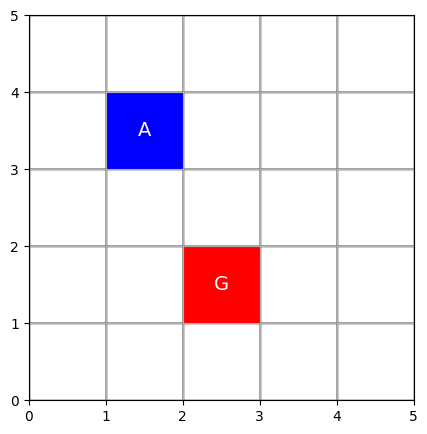

<Figure size 640x480 with 0 Axes>

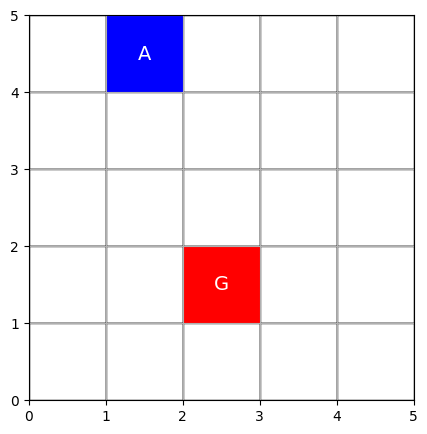

<Figure size 640x480 with 0 Axes>

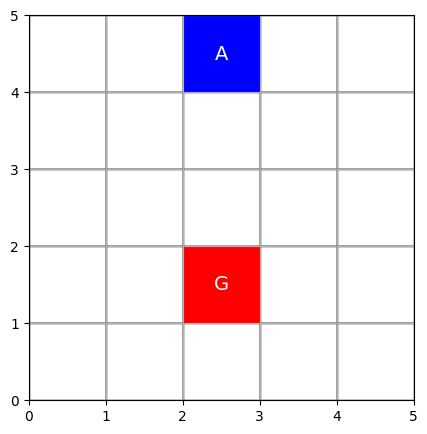

<Figure size 640x480 with 0 Axes>

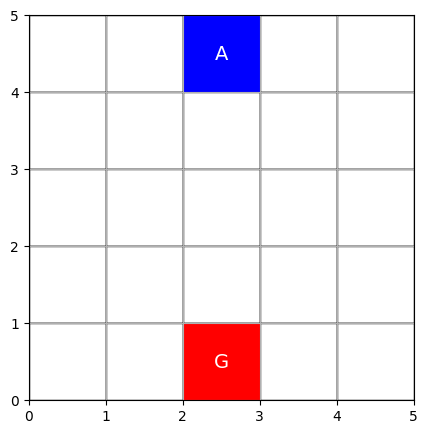

<Figure size 640x480 with 0 Axes>

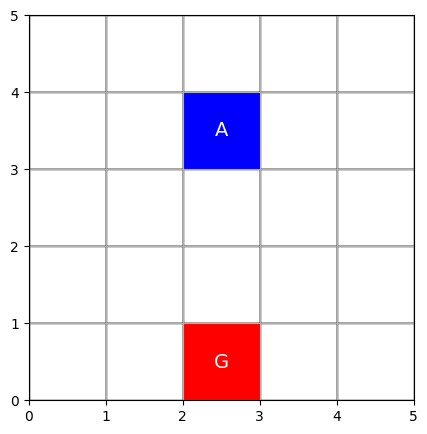

<Figure size 640x480 with 0 Axes>

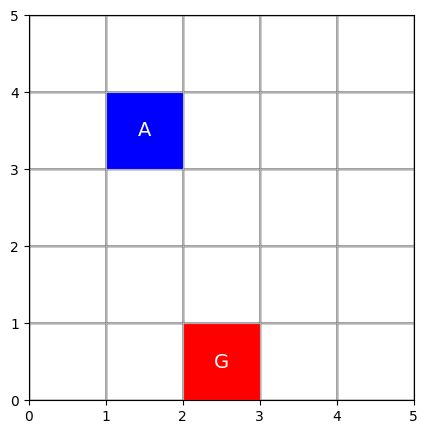

<Figure size 640x480 with 0 Axes>

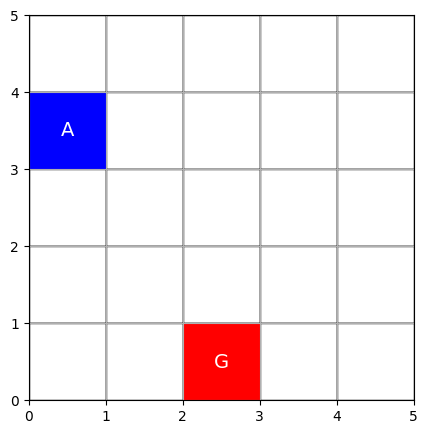

<Figure size 640x480 with 0 Axes>

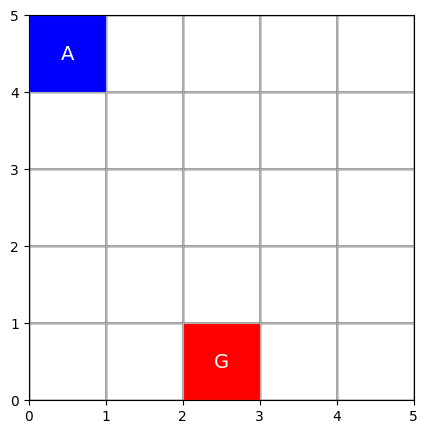

<Figure size 640x480 with 0 Axes>

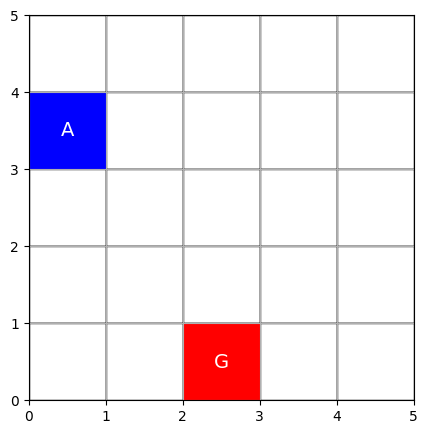

<Figure size 640x480 with 0 Axes>

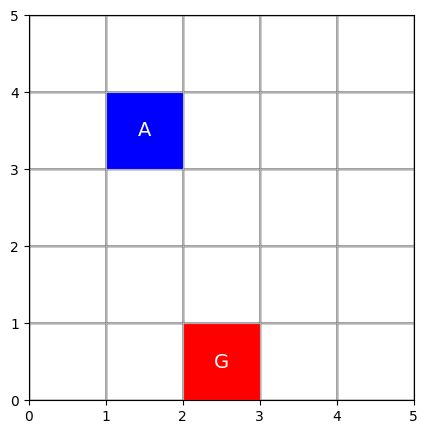

<Figure size 640x480 with 0 Axes>

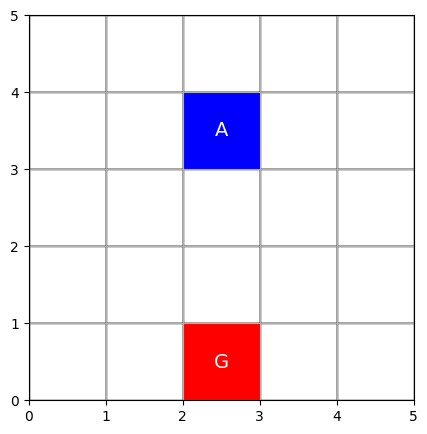

<Figure size 640x480 with 0 Axes>

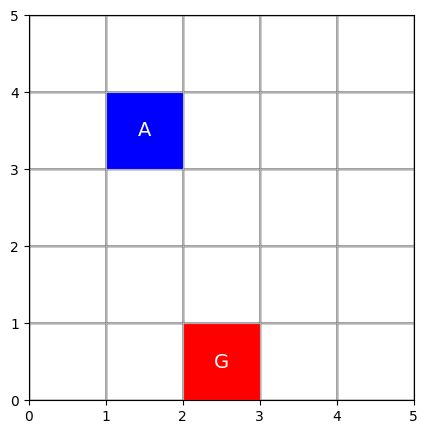

<Figure size 640x480 with 0 Axes>

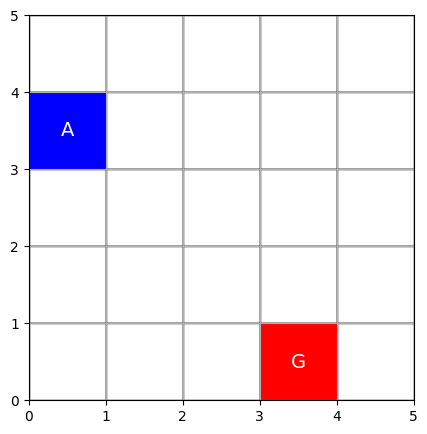

<Figure size 640x480 with 0 Axes>

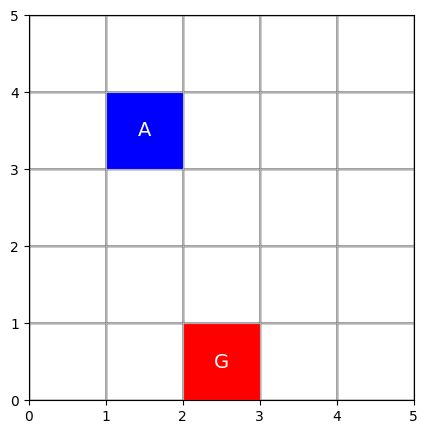

<Figure size 640x480 with 0 Axes>

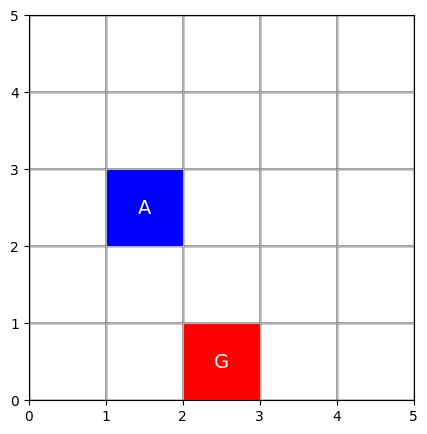

<Figure size 640x480 with 0 Axes>

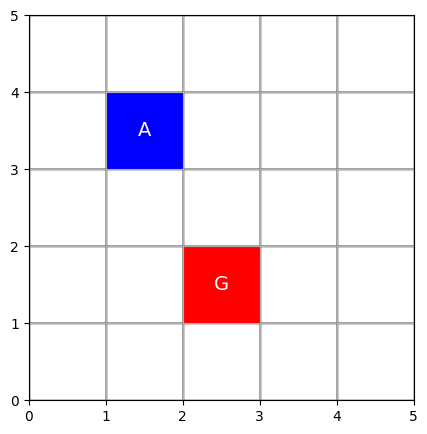

<Figure size 640x480 with 0 Axes>

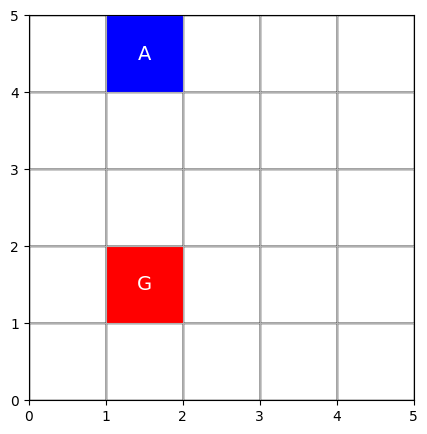

<Figure size 640x480 with 0 Axes>

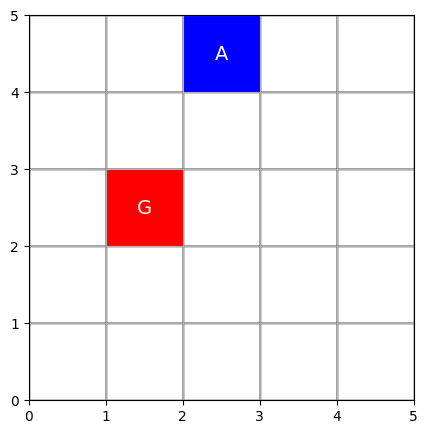

<Figure size 640x480 with 0 Axes>

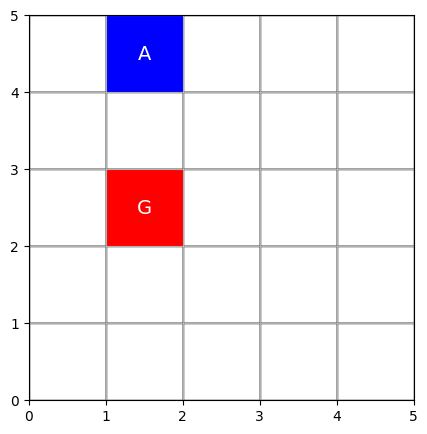

<Figure size 640x480 with 0 Axes>

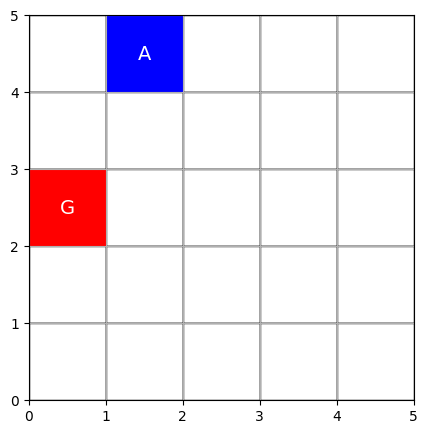

<Figure size 640x480 with 0 Axes>

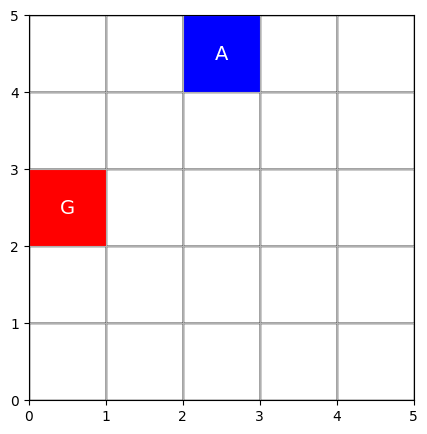

<Figure size 640x480 with 0 Axes>

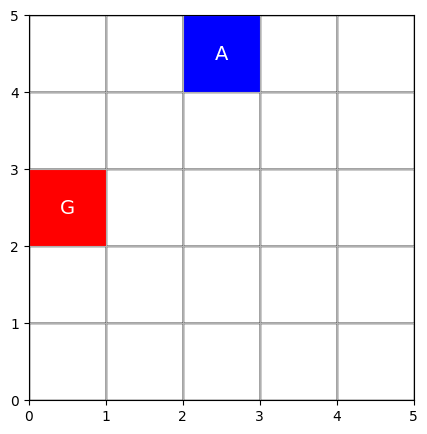

<Figure size 640x480 with 0 Axes>

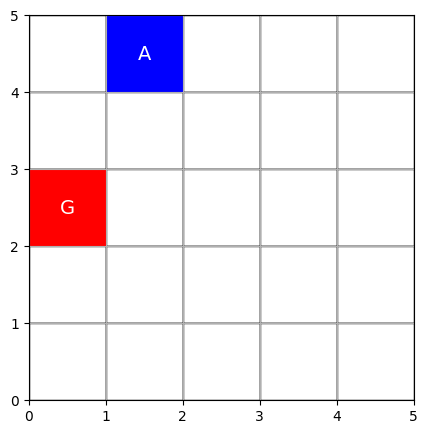

<Figure size 640x480 with 0 Axes>

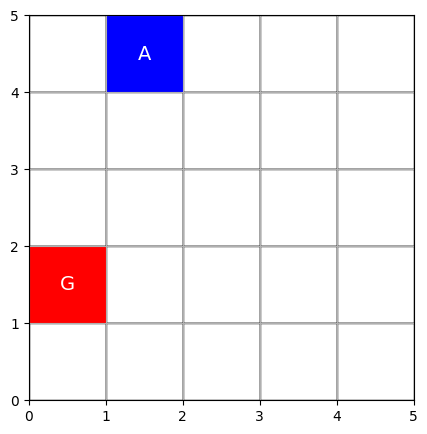

<Figure size 640x480 with 0 Axes>

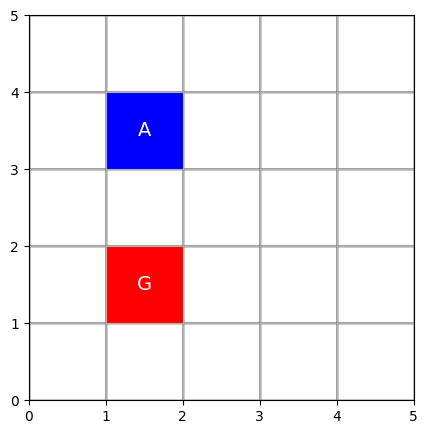

<Figure size 640x480 with 0 Axes>

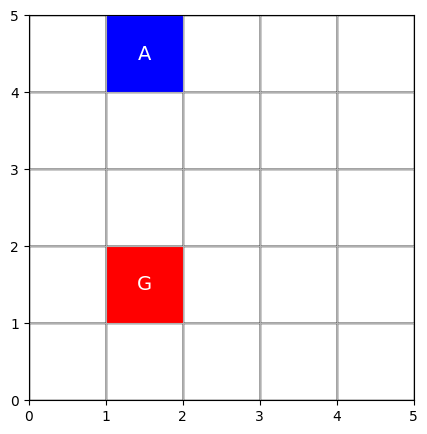

<Figure size 640x480 with 0 Axes>

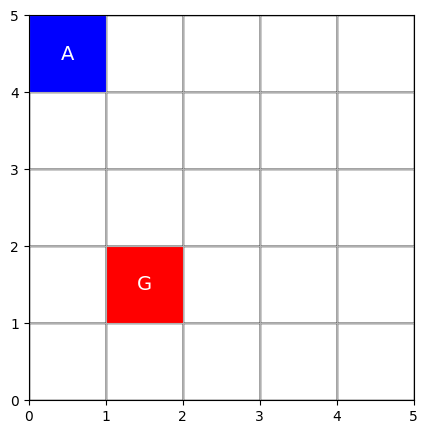

<Figure size 640x480 with 0 Axes>

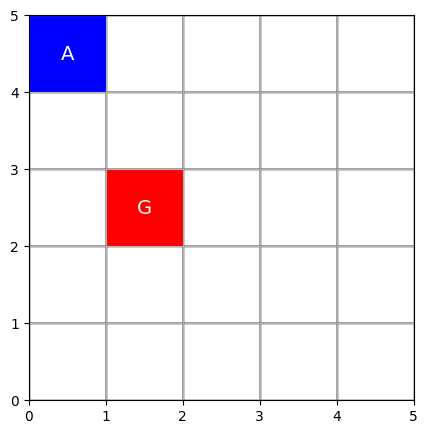

<Figure size 640x480 with 0 Axes>

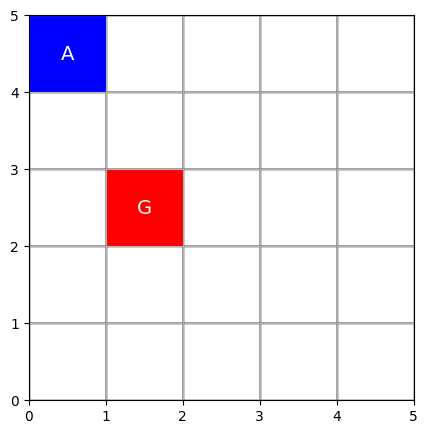

<Figure size 640x480 with 0 Axes>

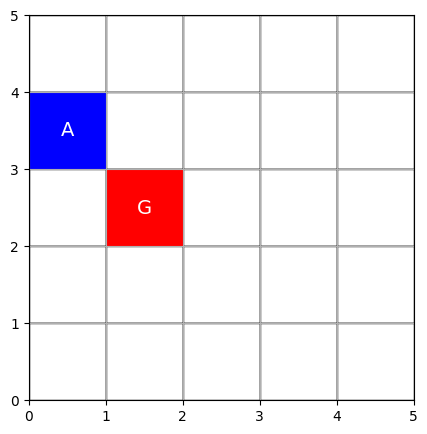

<Figure size 640x480 with 0 Axes>

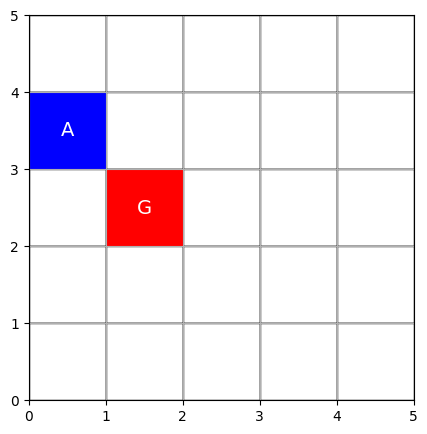

<Figure size 640x480 with 0 Axes>

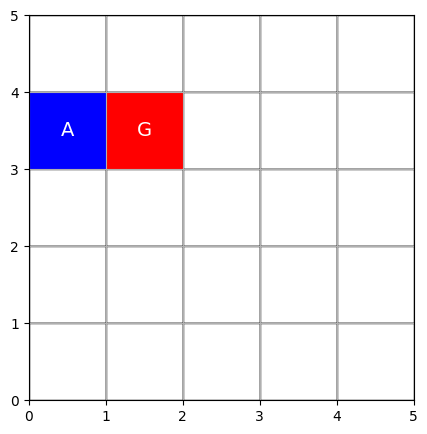

<Figure size 640x480 with 0 Axes>

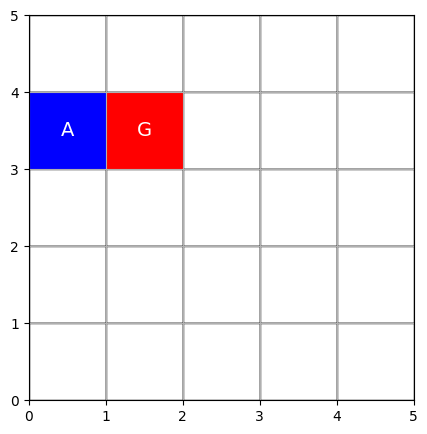

<Figure size 640x480 with 0 Axes>

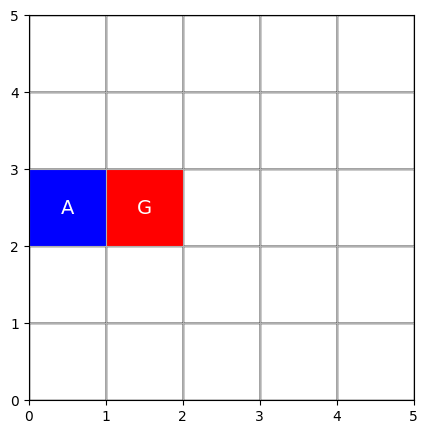

<Figure size 640x480 with 0 Axes>

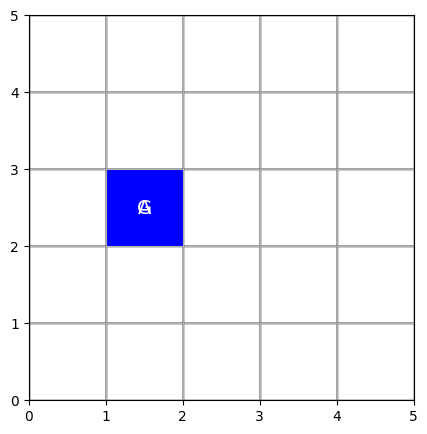

Episode 6/200 - Reward: 0.57


<Figure size 640x480 with 0 Axes>

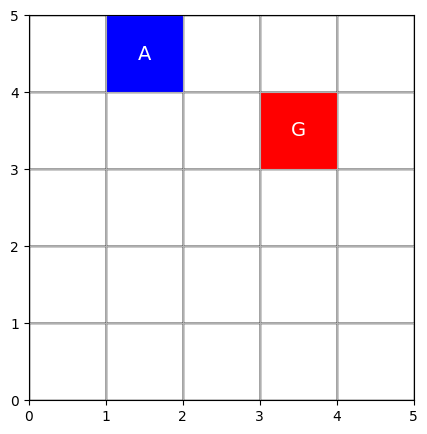

<Figure size 640x480 with 0 Axes>

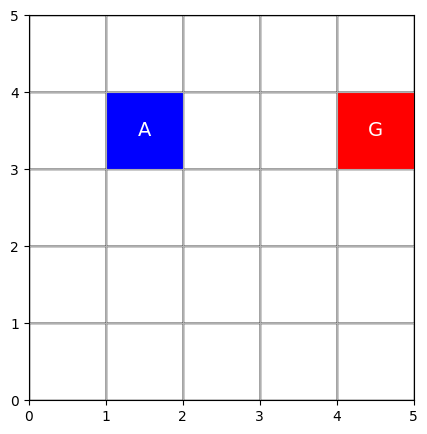

<Figure size 640x480 with 0 Axes>

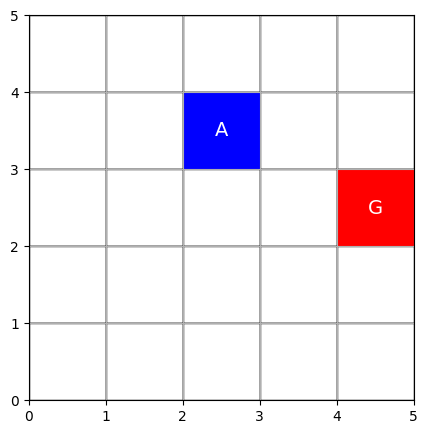

<Figure size 640x480 with 0 Axes>

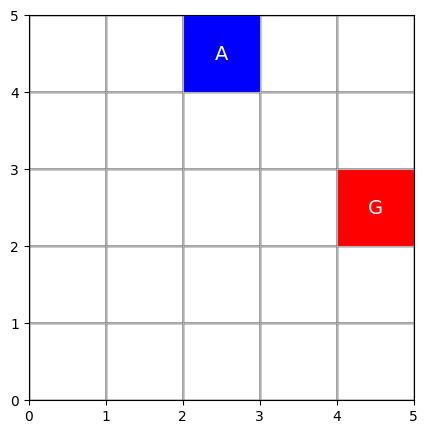

<Figure size 640x480 with 0 Axes>

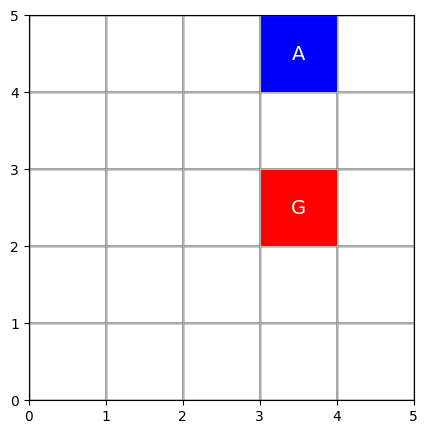

<Figure size 640x480 with 0 Axes>

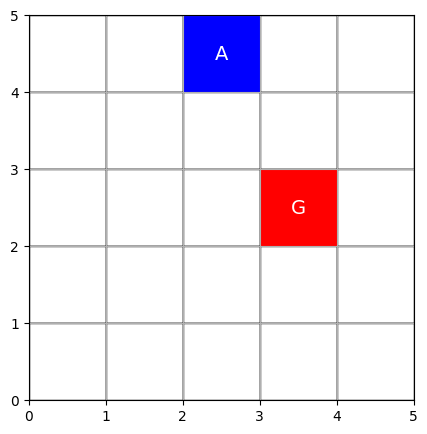

<Figure size 640x480 with 0 Axes>

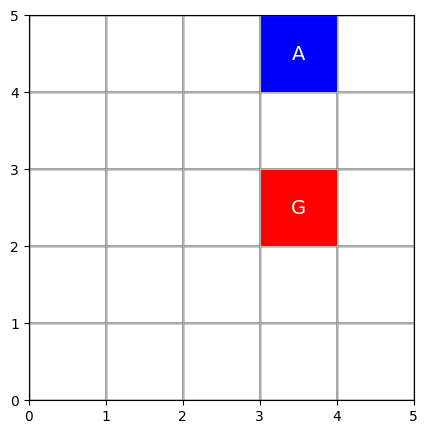

<Figure size 640x480 with 0 Axes>

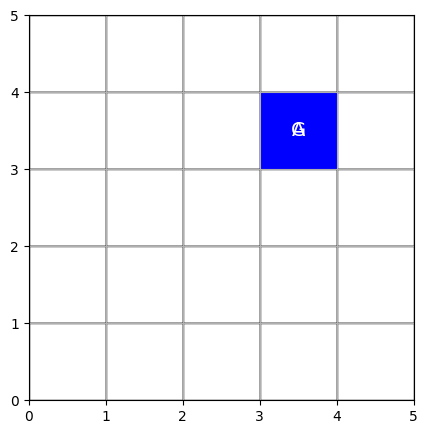

<Figure size 640x480 with 0 Axes>

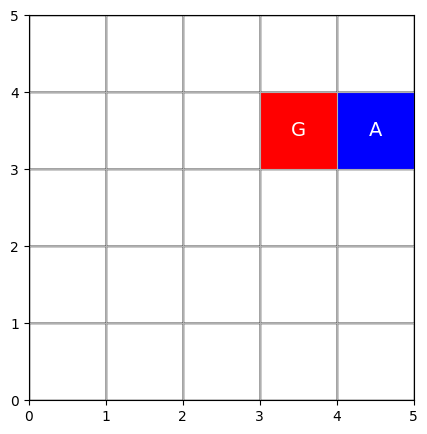

<Figure size 640x480 with 0 Axes>

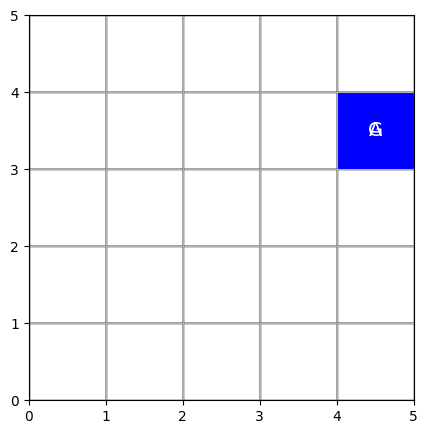

<Figure size 640x480 with 0 Axes>

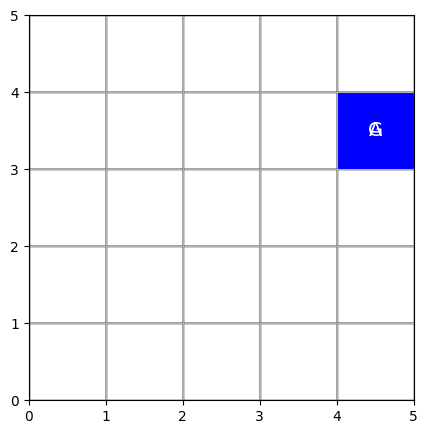

Episode 7/200 - Reward: 0.90


<Figure size 640x480 with 0 Axes>

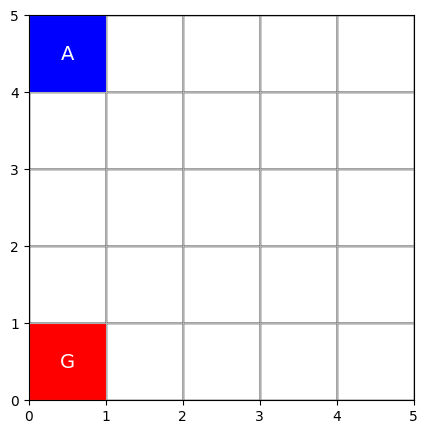

<Figure size 640x480 with 0 Axes>

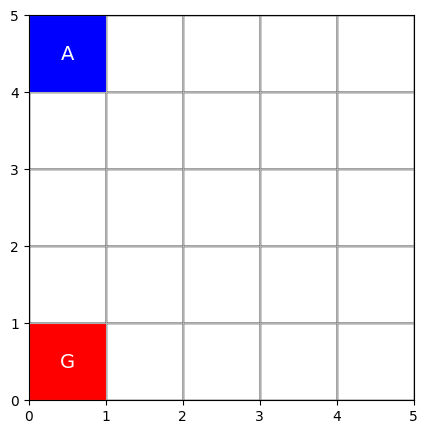

<Figure size 640x480 with 0 Axes>

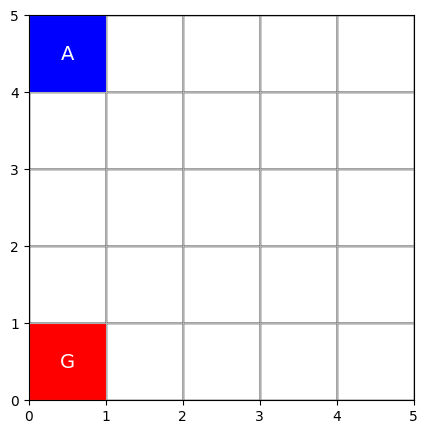

<Figure size 640x480 with 0 Axes>

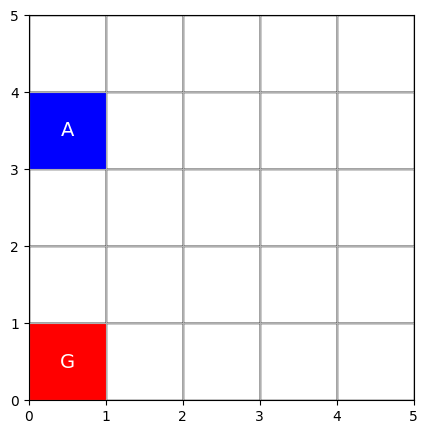

<Figure size 640x480 with 0 Axes>

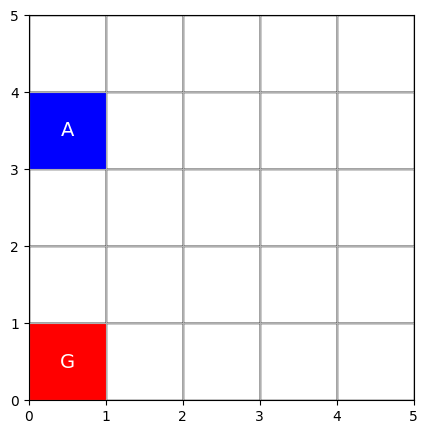

<Figure size 640x480 with 0 Axes>

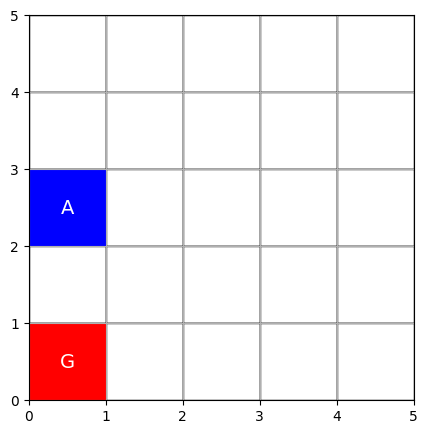

<Figure size 640x480 with 0 Axes>

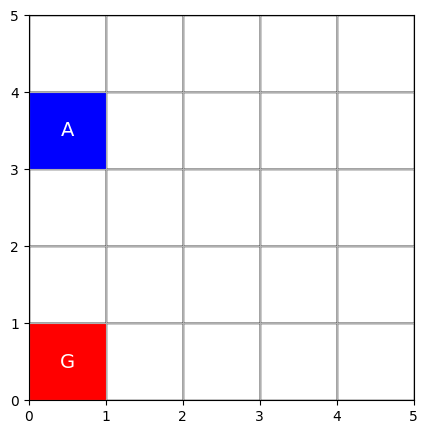

<Figure size 640x480 with 0 Axes>

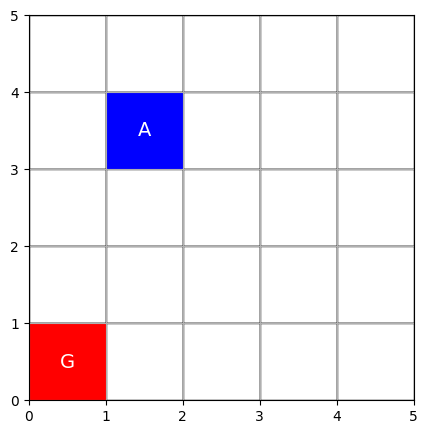

<Figure size 640x480 with 0 Axes>

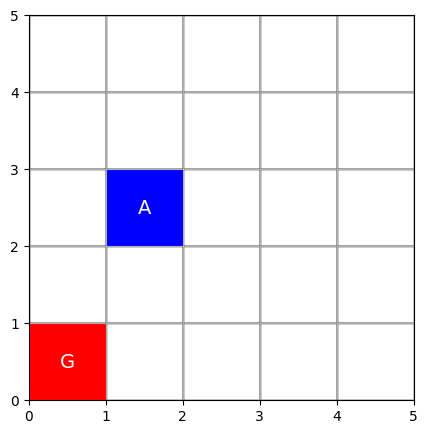

<Figure size 640x480 with 0 Axes>

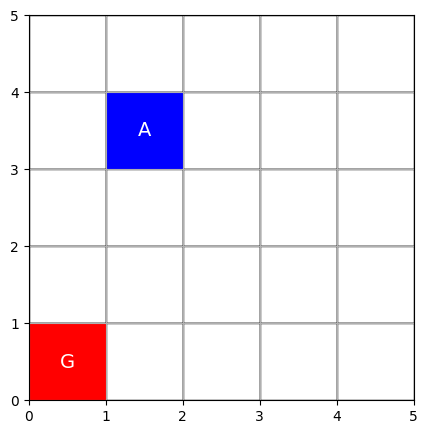

<Figure size 640x480 with 0 Axes>

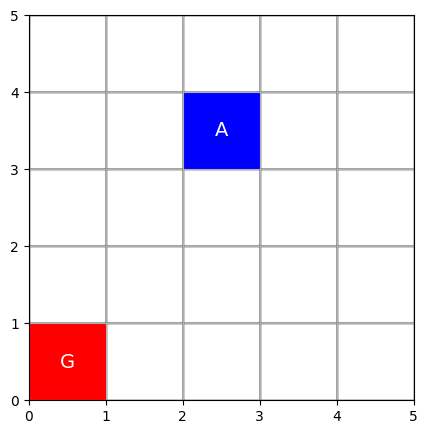

<Figure size 640x480 with 0 Axes>

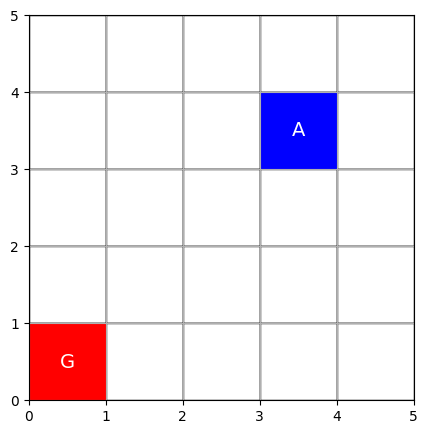

<Figure size 640x480 with 0 Axes>

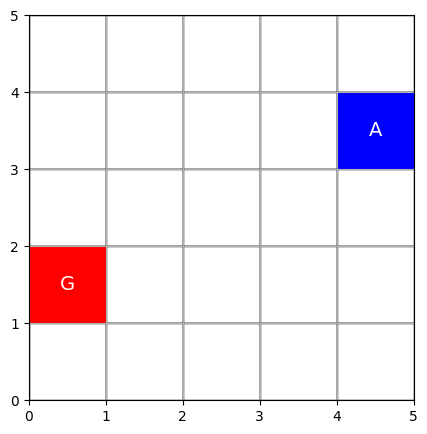

<Figure size 640x480 with 0 Axes>

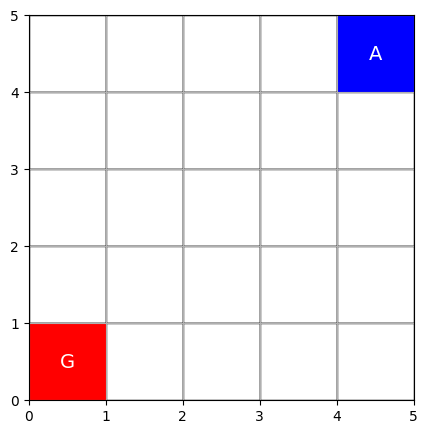

<Figure size 640x480 with 0 Axes>

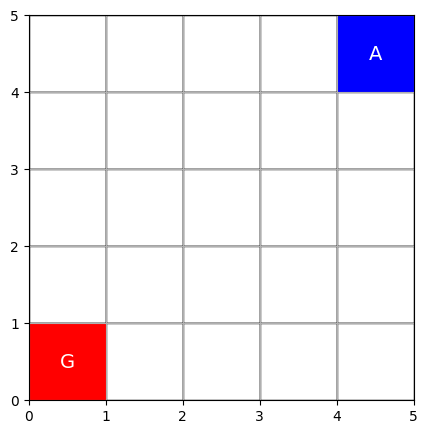

<Figure size 640x480 with 0 Axes>

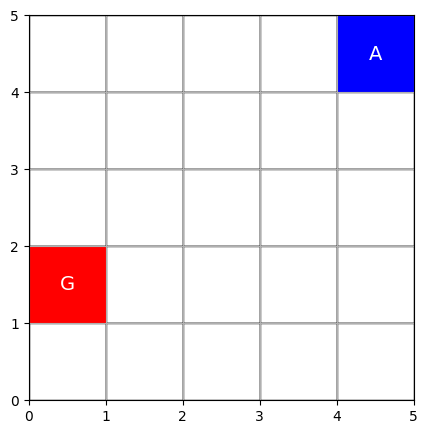

<Figure size 640x480 with 0 Axes>

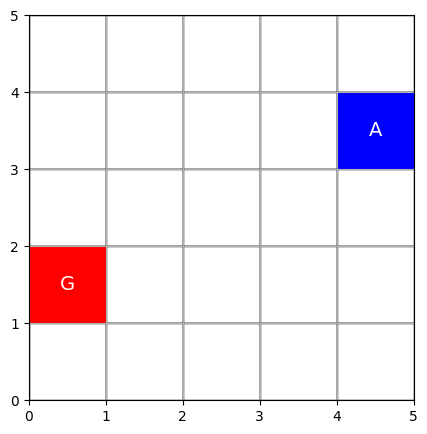

<Figure size 640x480 with 0 Axes>

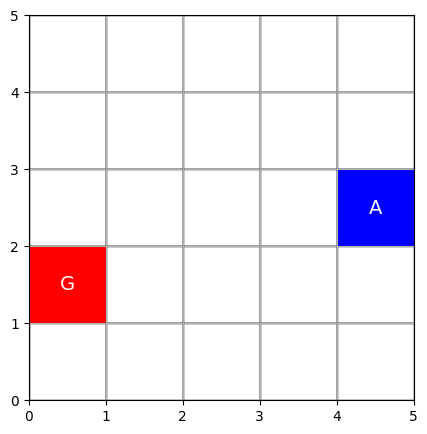

<Figure size 640x480 with 0 Axes>

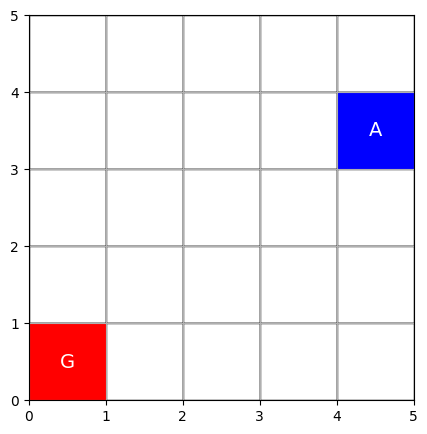

<Figure size 640x480 with 0 Axes>

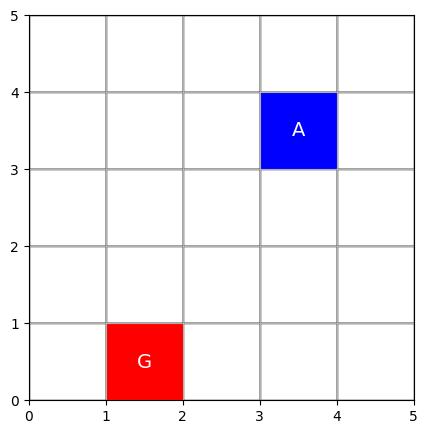

<Figure size 640x480 with 0 Axes>

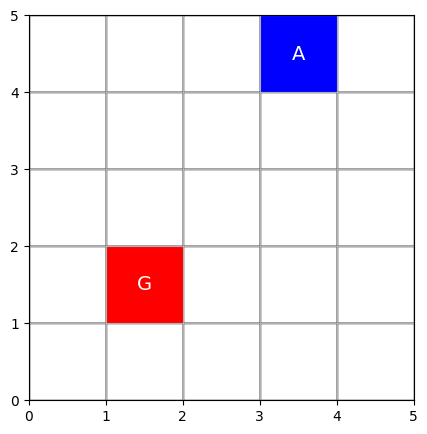

<Figure size 640x480 with 0 Axes>

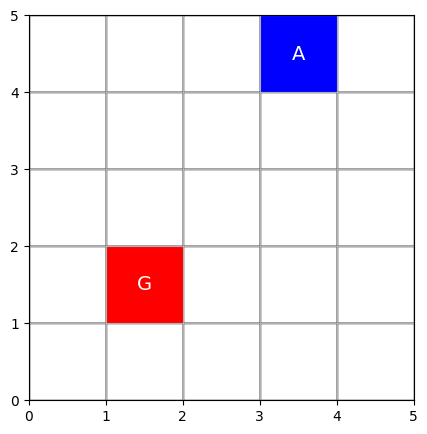

<Figure size 640x480 with 0 Axes>

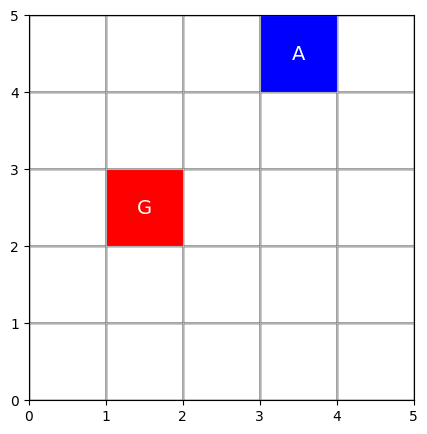

<Figure size 640x480 with 0 Axes>

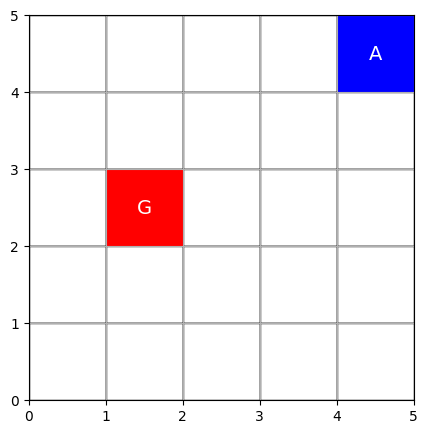

<Figure size 640x480 with 0 Axes>

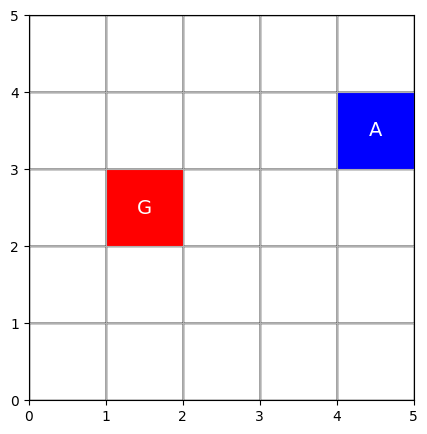

<Figure size 640x480 with 0 Axes>

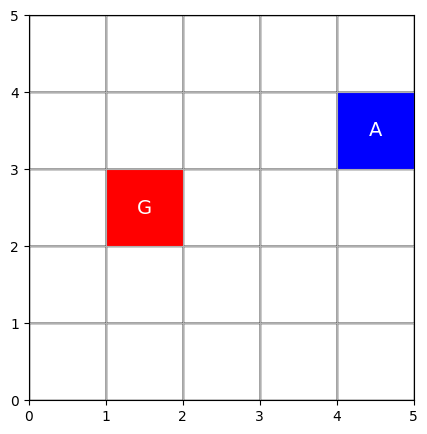

<Figure size 640x480 with 0 Axes>

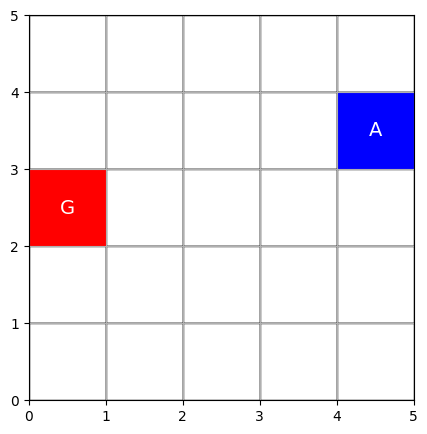

<Figure size 640x480 with 0 Axes>

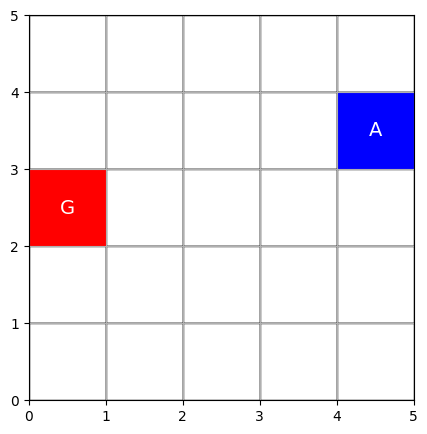

<Figure size 640x480 with 0 Axes>

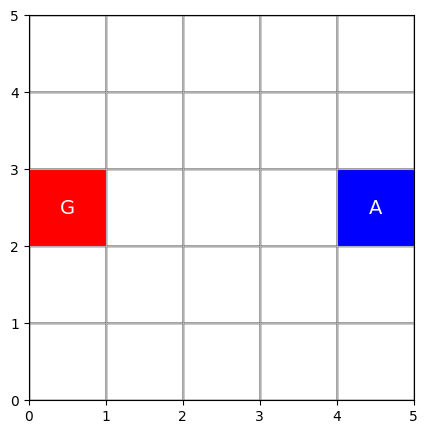

<Figure size 640x480 with 0 Axes>

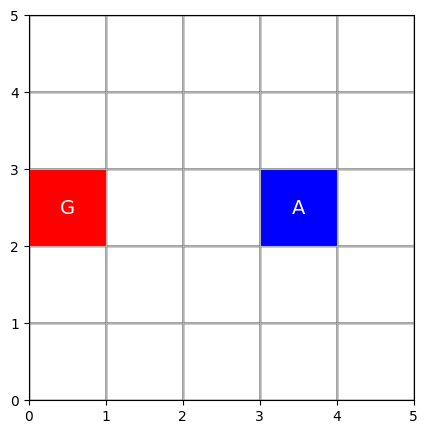

<Figure size 640x480 with 0 Axes>

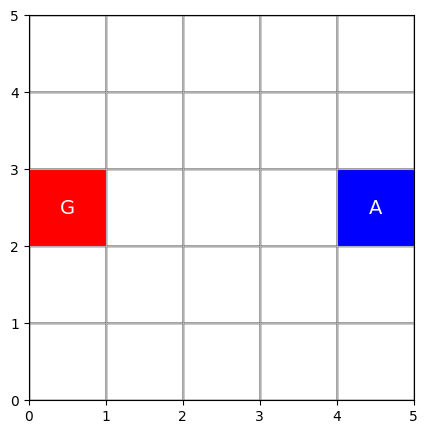

<Figure size 640x480 with 0 Axes>

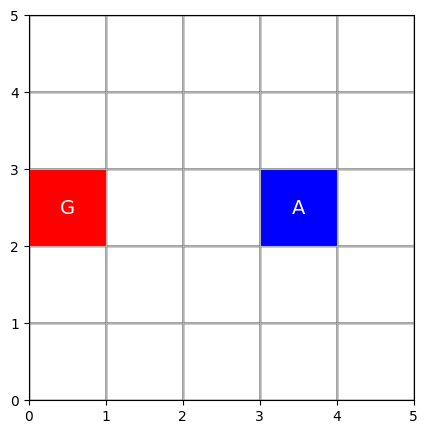

<Figure size 640x480 with 0 Axes>

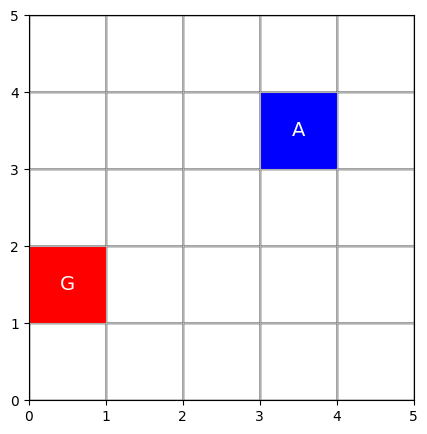

<Figure size 640x480 with 0 Axes>

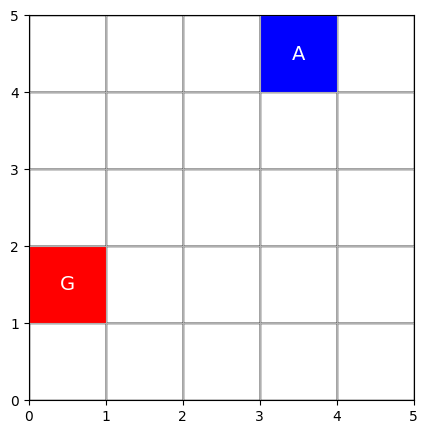

<Figure size 640x480 with 0 Axes>

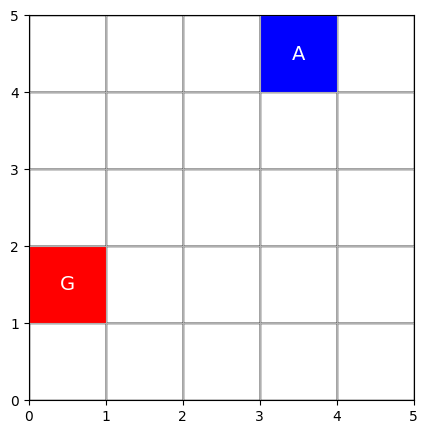

<Figure size 640x480 with 0 Axes>

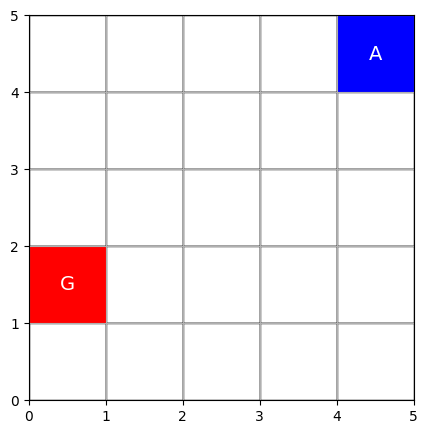

<Figure size 640x480 with 0 Axes>

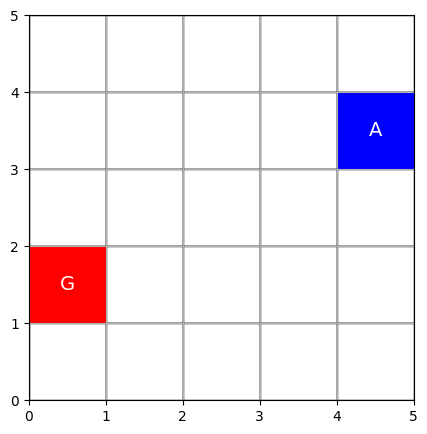

<Figure size 640x480 with 0 Axes>

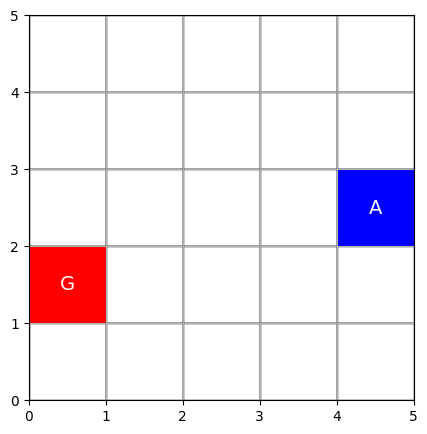

<Figure size 640x480 with 0 Axes>

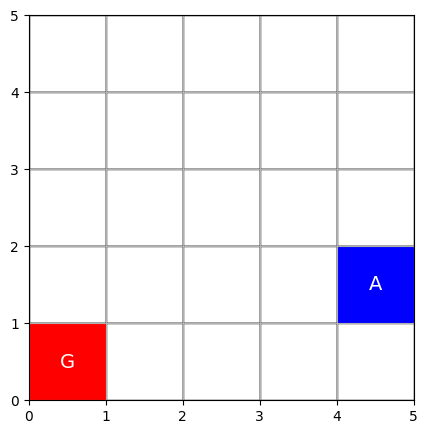

<Figure size 640x480 with 0 Axes>

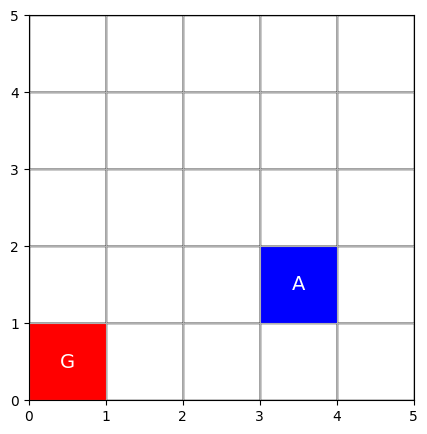

<Figure size 640x480 with 0 Axes>

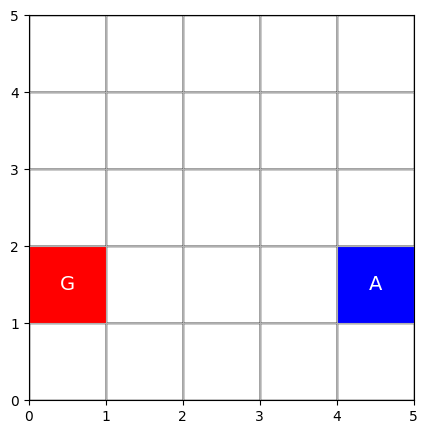

<Figure size 640x480 with 0 Axes>

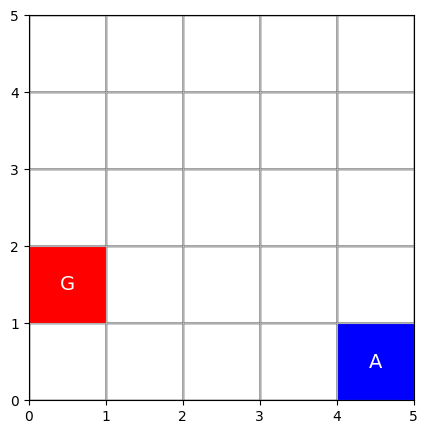

<Figure size 640x480 with 0 Axes>

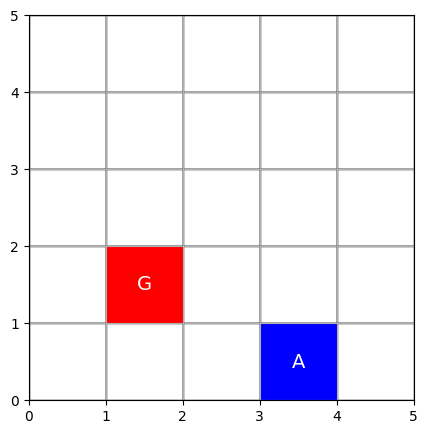

<Figure size 640x480 with 0 Axes>

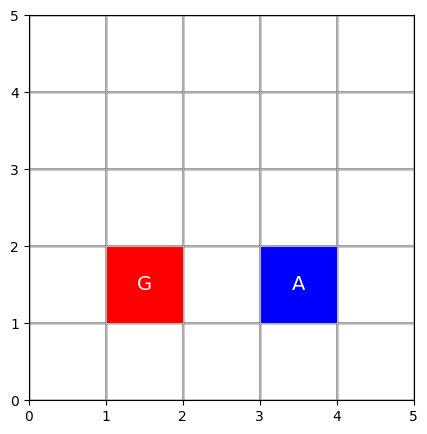

<Figure size 640x480 with 0 Axes>

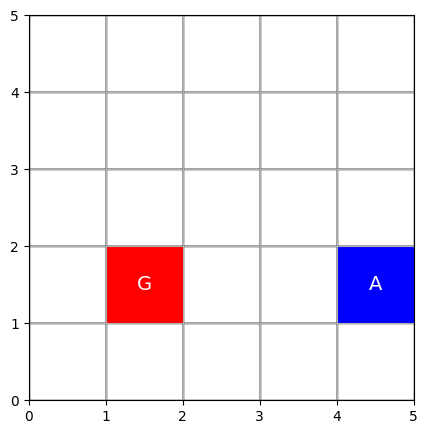

<Figure size 640x480 with 0 Axes>

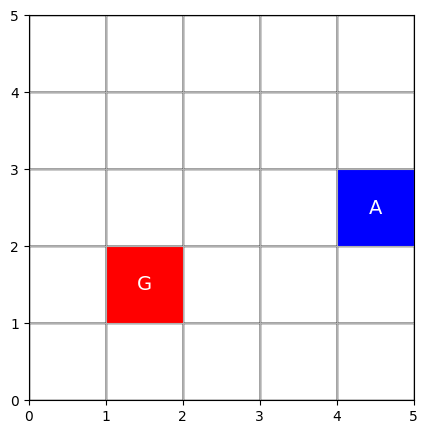

<Figure size 640x480 with 0 Axes>

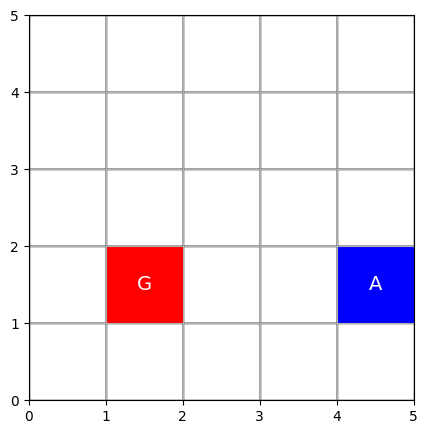

<Figure size 640x480 with 0 Axes>

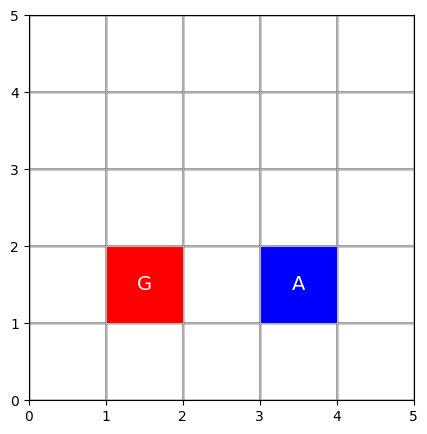

<Figure size 640x480 with 0 Axes>

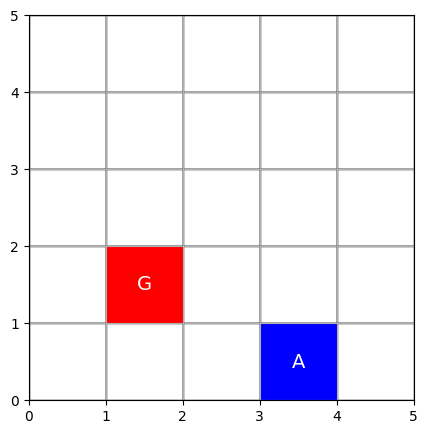

<Figure size 640x480 with 0 Axes>

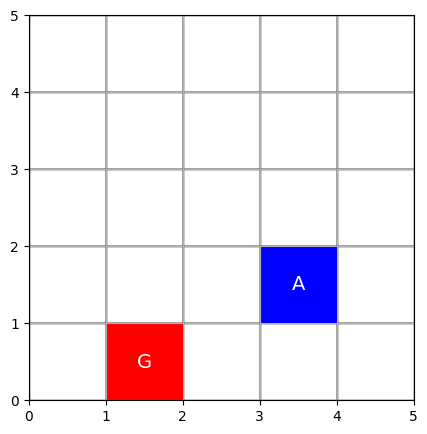

Episode 8/200 - Reward: -0.50


<Figure size 640x480 with 0 Axes>

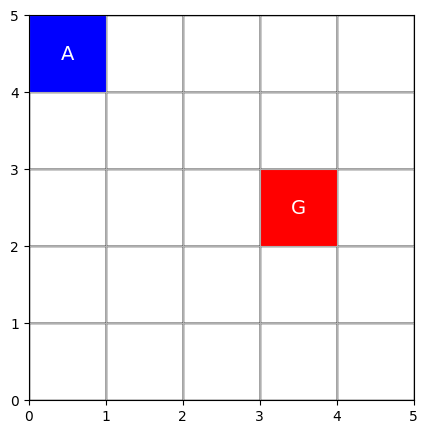

<Figure size 640x480 with 0 Axes>

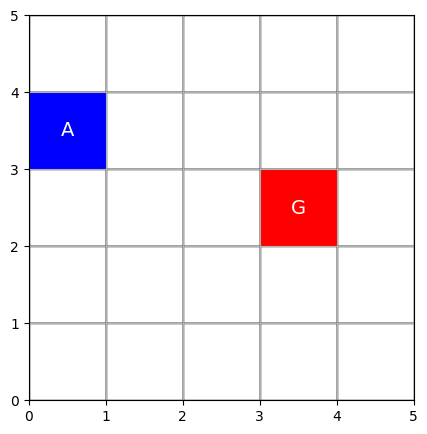

<Figure size 640x480 with 0 Axes>

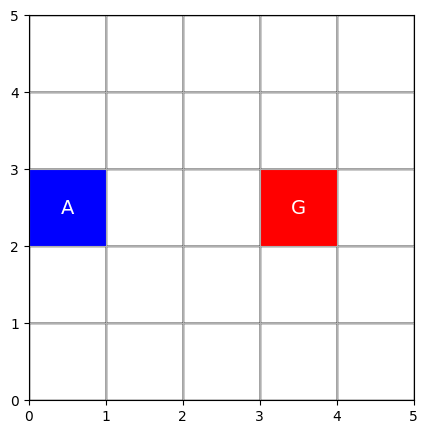

<Figure size 640x480 with 0 Axes>

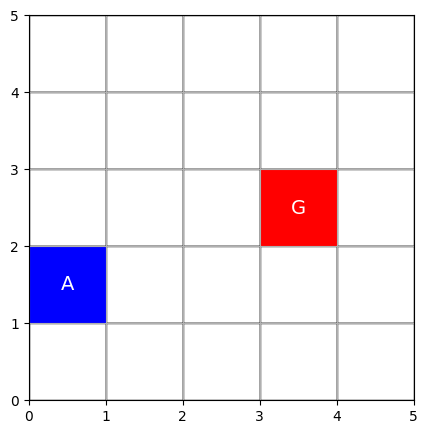

<Figure size 640x480 with 0 Axes>

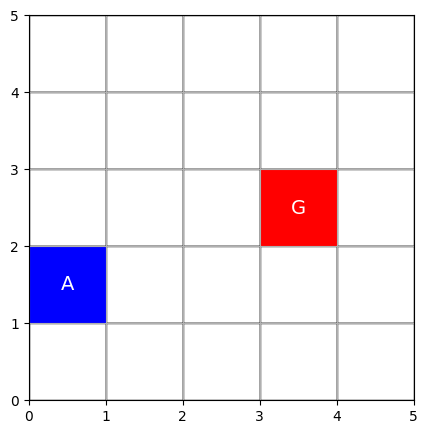

<Figure size 640x480 with 0 Axes>

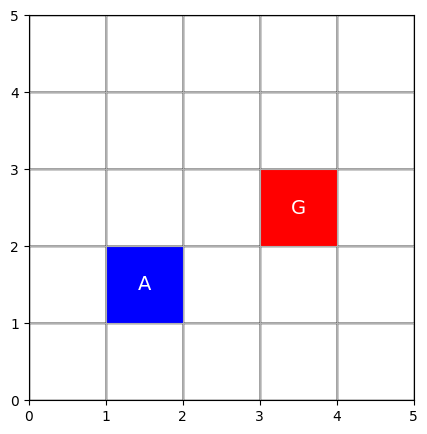

<Figure size 640x480 with 0 Axes>

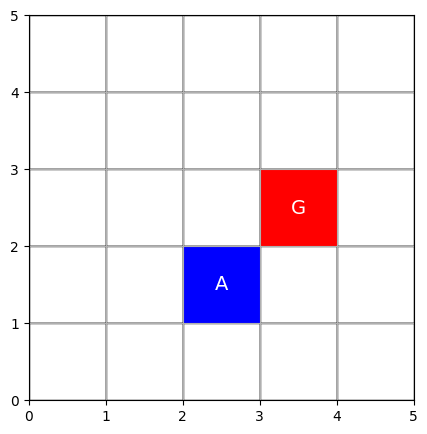

<Figure size 640x480 with 0 Axes>

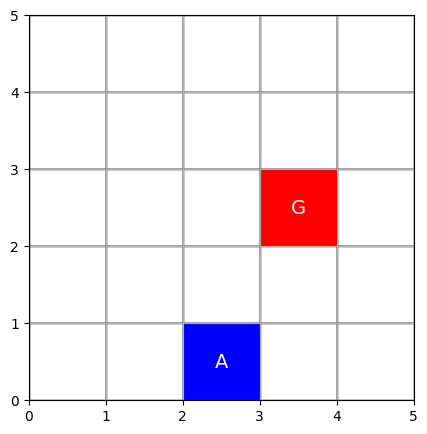

<Figure size 640x480 with 0 Axes>

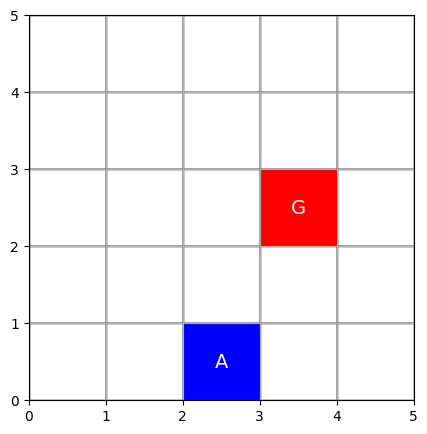

<Figure size 640x480 with 0 Axes>

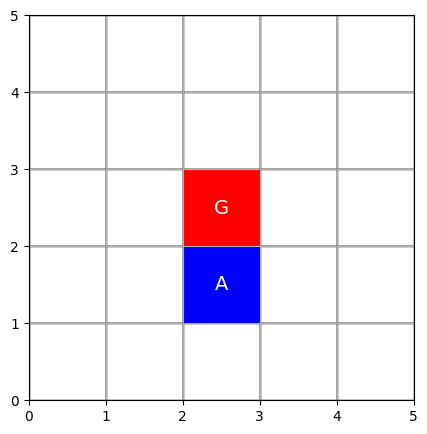

<Figure size 640x480 with 0 Axes>

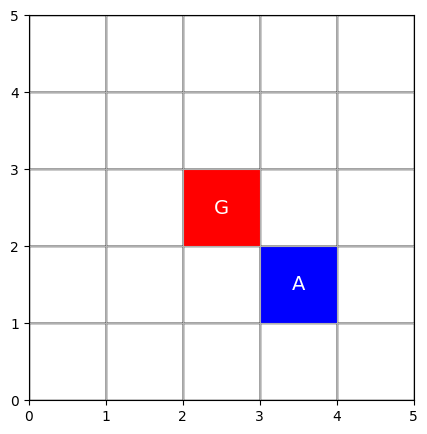

<Figure size 640x480 with 0 Axes>

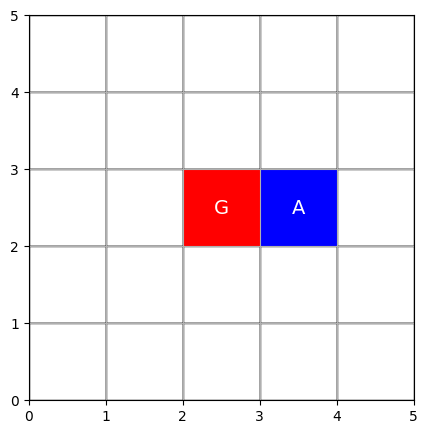

<Figure size 640x480 with 0 Axes>

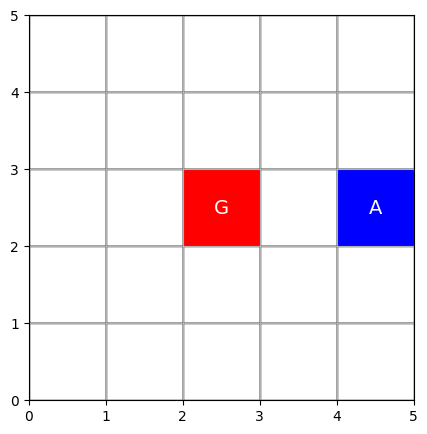

<Figure size 640x480 with 0 Axes>

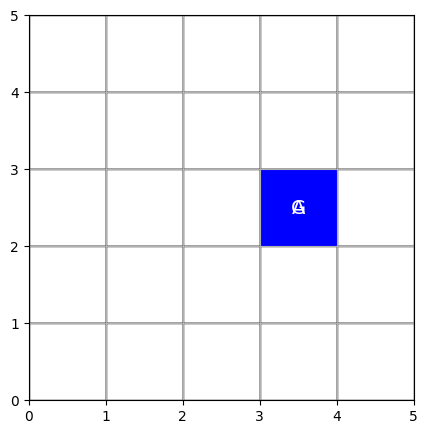

<Figure size 640x480 with 0 Axes>

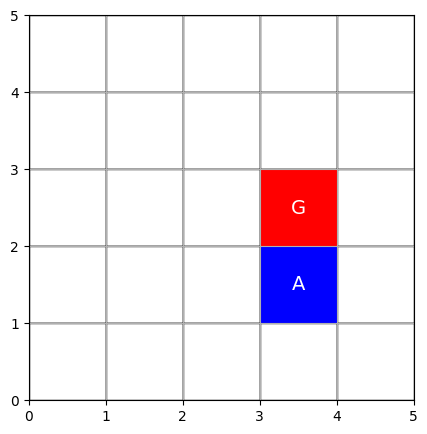

<Figure size 640x480 with 0 Axes>

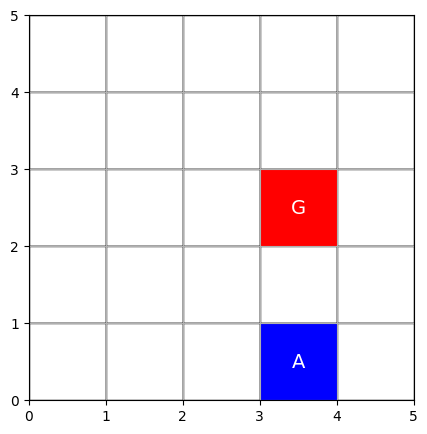

<Figure size 640x480 with 0 Axes>

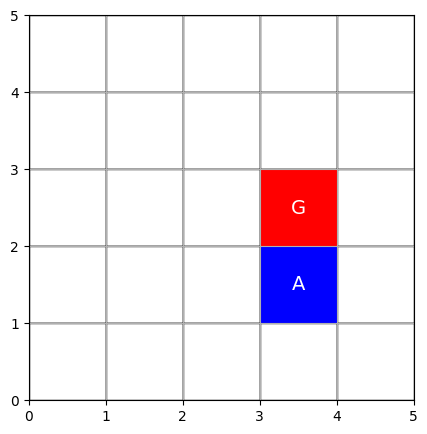

<Figure size 640x480 with 0 Axes>

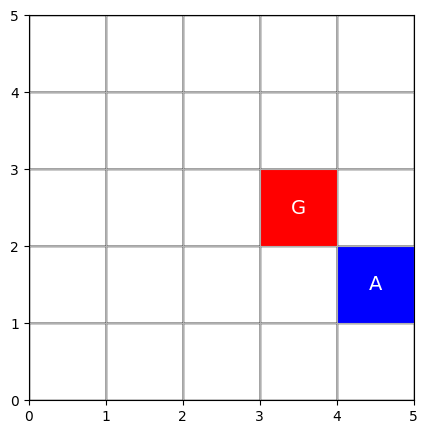

<Figure size 640x480 with 0 Axes>

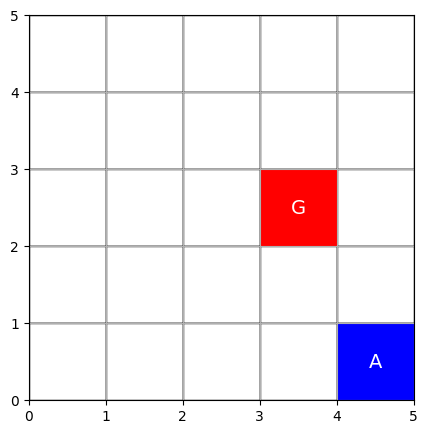

<Figure size 640x480 with 0 Axes>

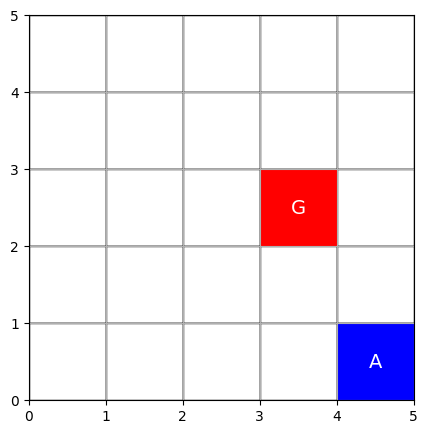

<Figure size 640x480 with 0 Axes>

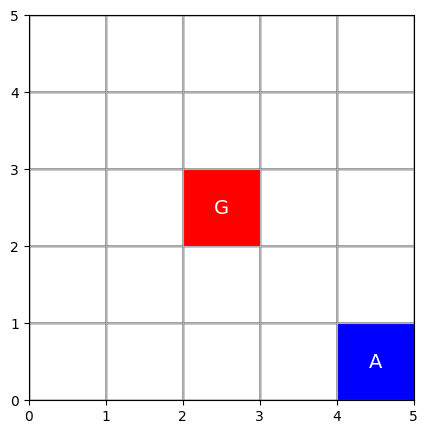

<Figure size 640x480 with 0 Axes>

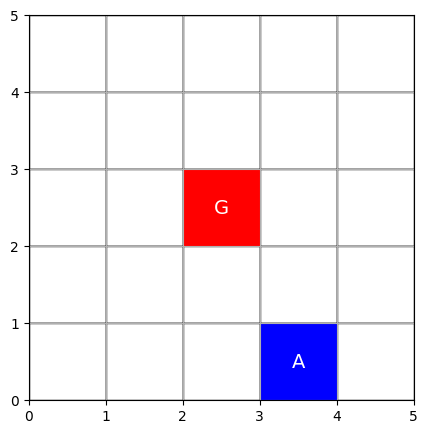

<Figure size 640x480 with 0 Axes>

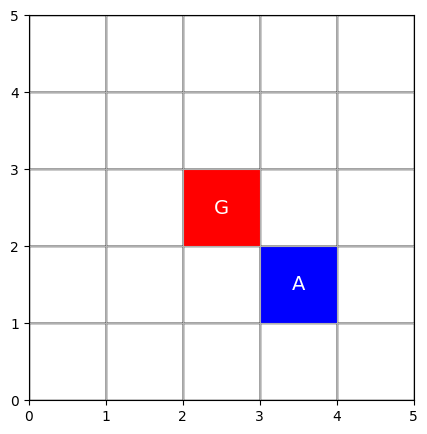

<Figure size 640x480 with 0 Axes>

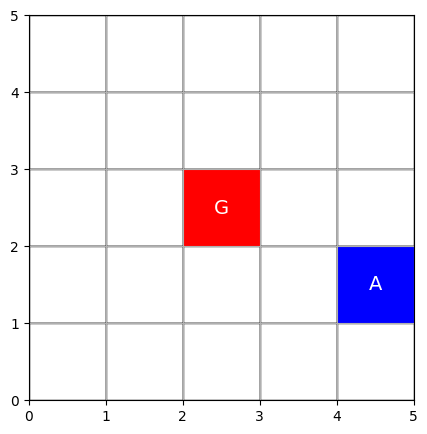

<Figure size 640x480 with 0 Axes>

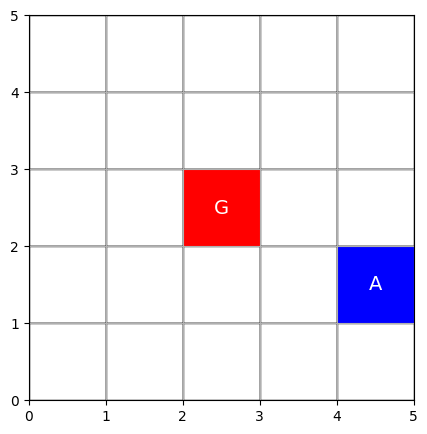

<Figure size 640x480 with 0 Axes>

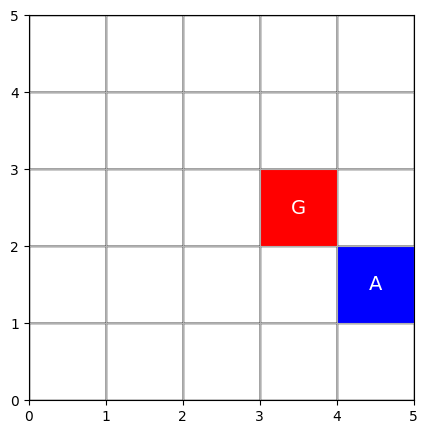

<Figure size 640x480 with 0 Axes>

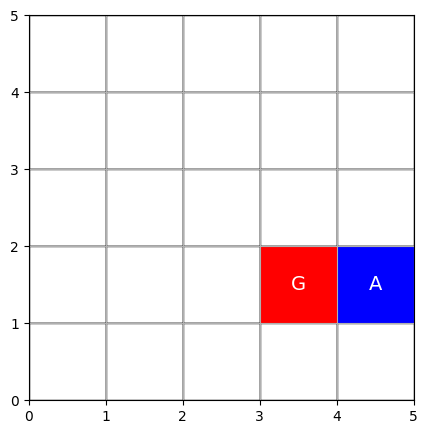

<Figure size 640x480 with 0 Axes>

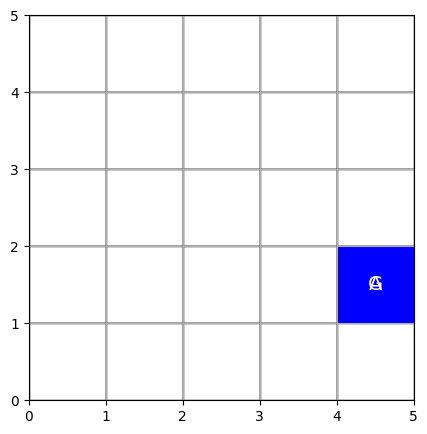

<Figure size 640x480 with 0 Axes>

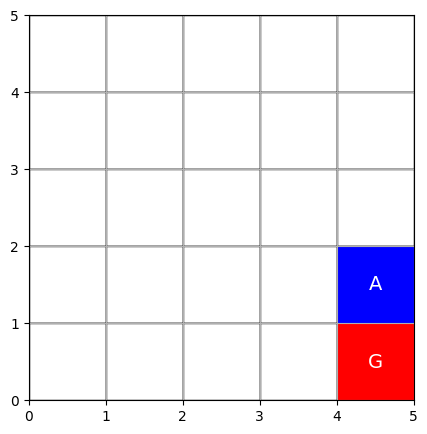

Episode 9/200 - Reward: 0.72


<Figure size 640x480 with 0 Axes>

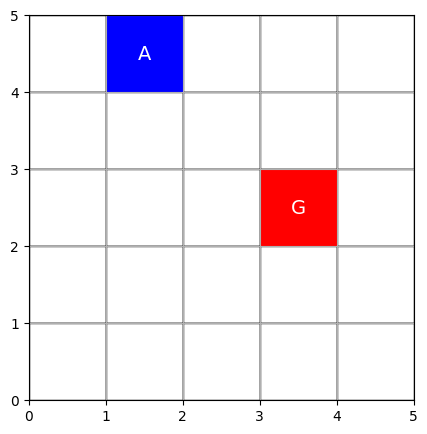

<Figure size 640x480 with 0 Axes>

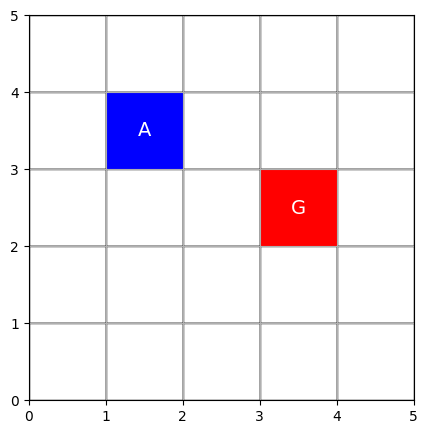

<Figure size 640x480 with 0 Axes>

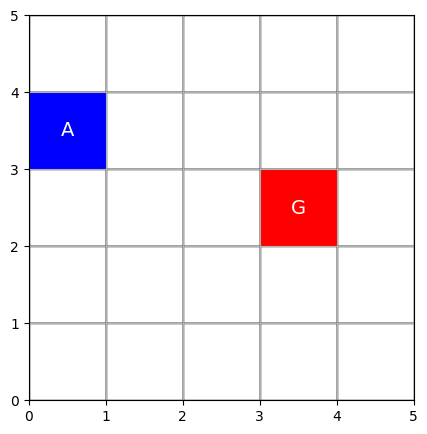

<Figure size 640x480 with 0 Axes>

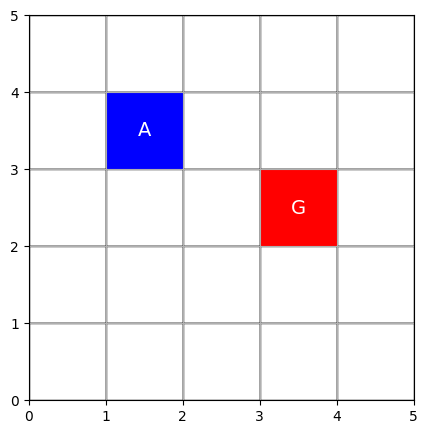

<Figure size 640x480 with 0 Axes>

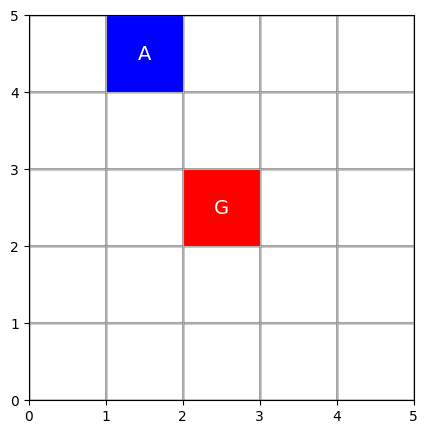

<Figure size 640x480 with 0 Axes>

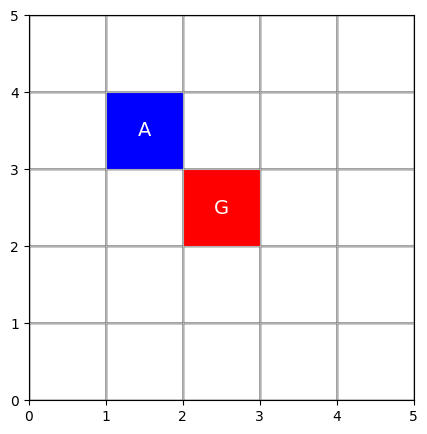

<Figure size 640x480 with 0 Axes>

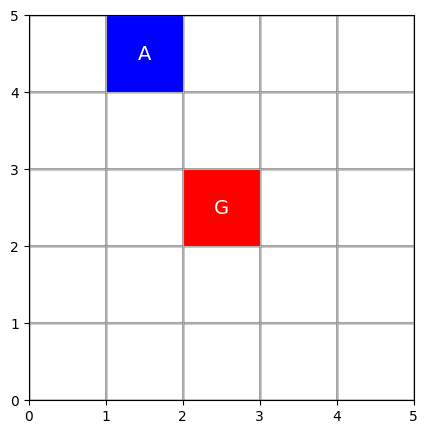

<Figure size 640x480 with 0 Axes>

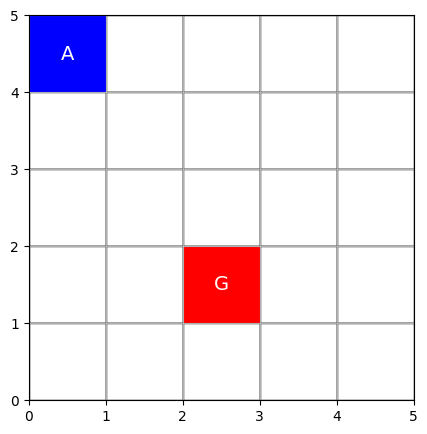

<Figure size 640x480 with 0 Axes>

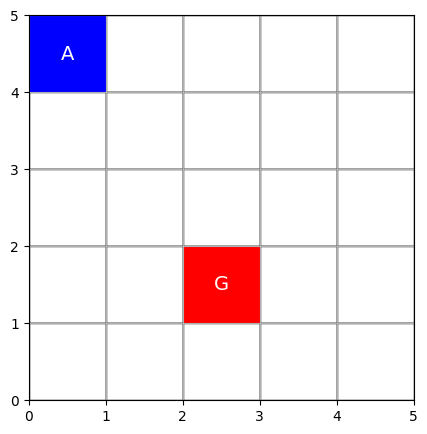

<Figure size 640x480 with 0 Axes>

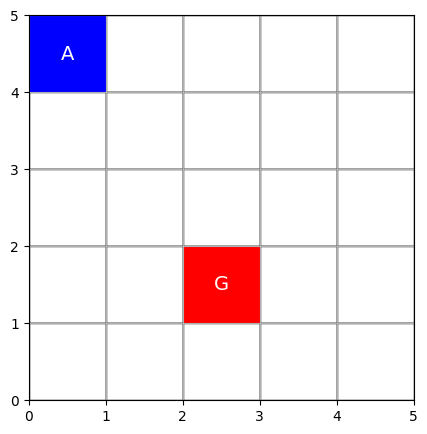

<Figure size 640x480 with 0 Axes>

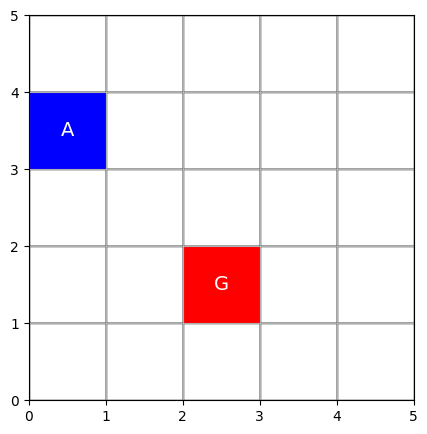

<Figure size 640x480 with 0 Axes>

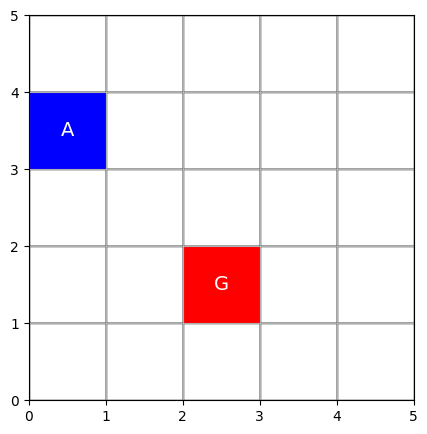

<Figure size 640x480 with 0 Axes>

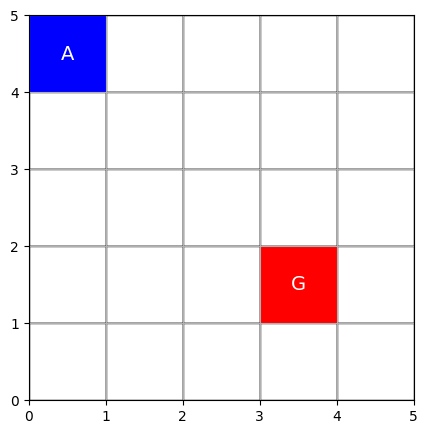

<Figure size 640x480 with 0 Axes>

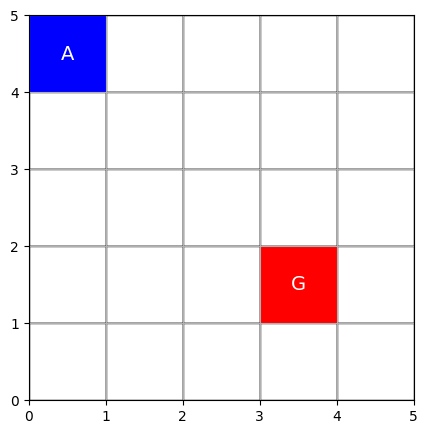

<Figure size 640x480 with 0 Axes>

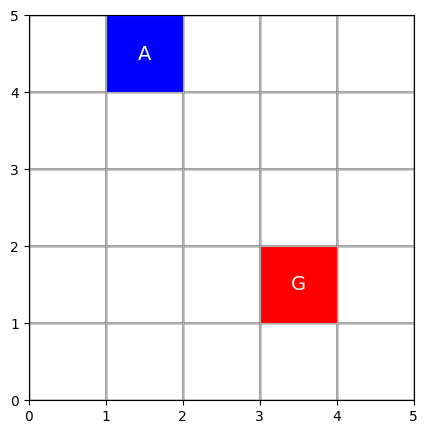

<Figure size 640x480 with 0 Axes>

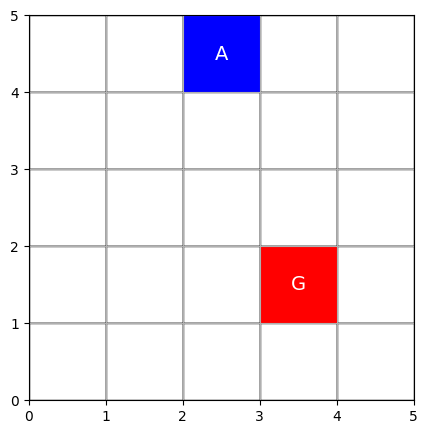

<Figure size 640x480 with 0 Axes>

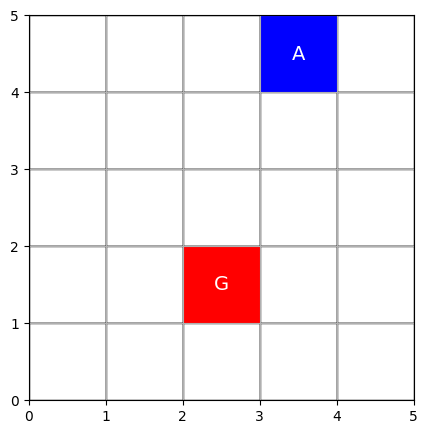

<Figure size 640x480 with 0 Axes>

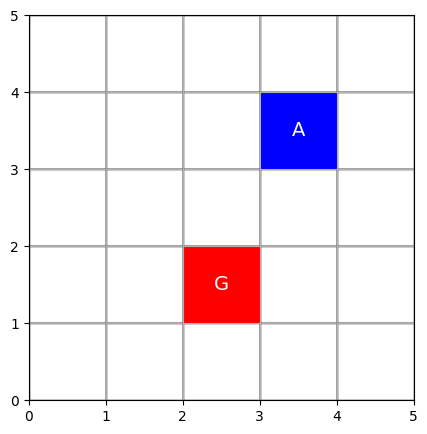

<Figure size 640x480 with 0 Axes>

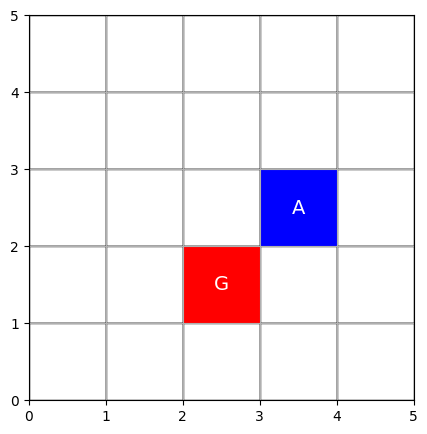

<Figure size 640x480 with 0 Axes>

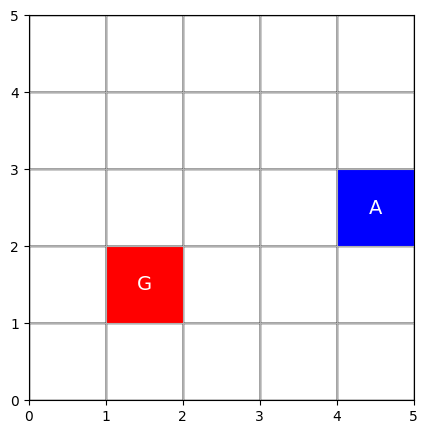

<Figure size 640x480 with 0 Axes>

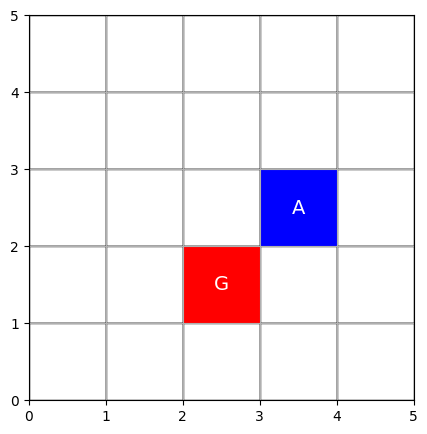

<Figure size 640x480 with 0 Axes>

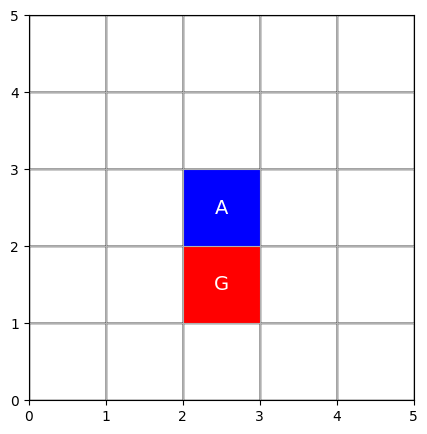

<Figure size 640x480 with 0 Axes>

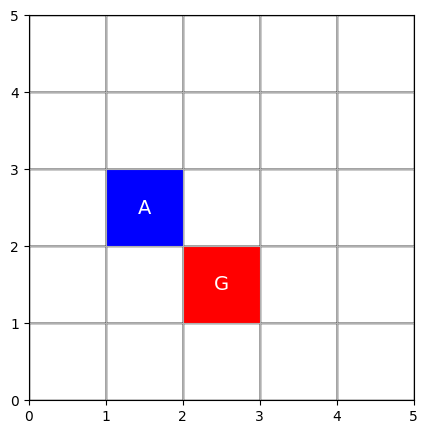

<Figure size 640x480 with 0 Axes>

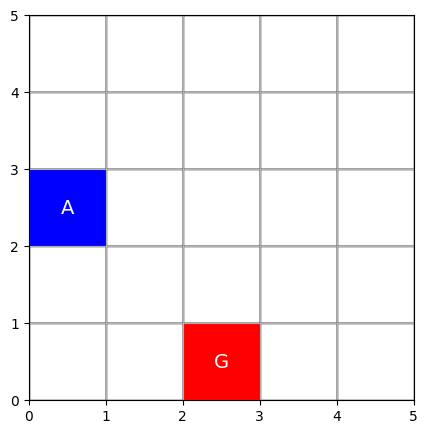

<Figure size 640x480 with 0 Axes>

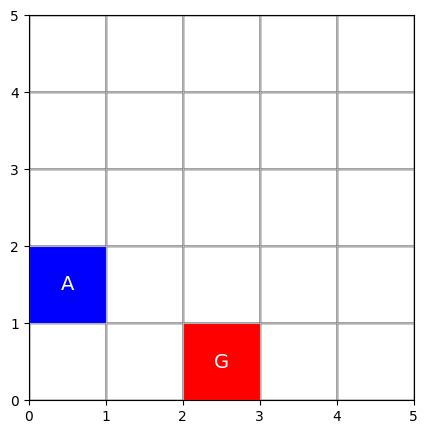

<Figure size 640x480 with 0 Axes>

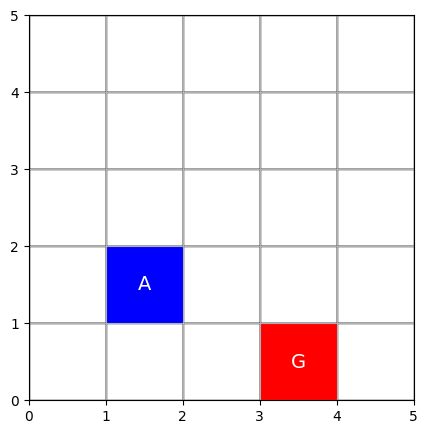

<Figure size 640x480 with 0 Axes>

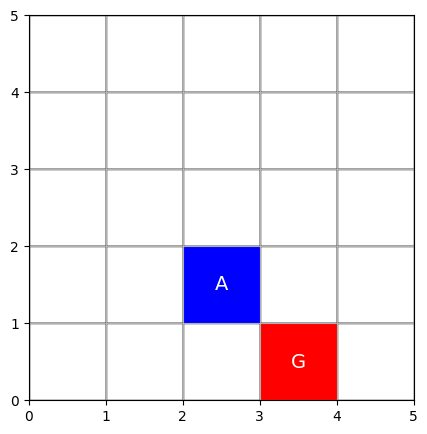

<Figure size 640x480 with 0 Axes>

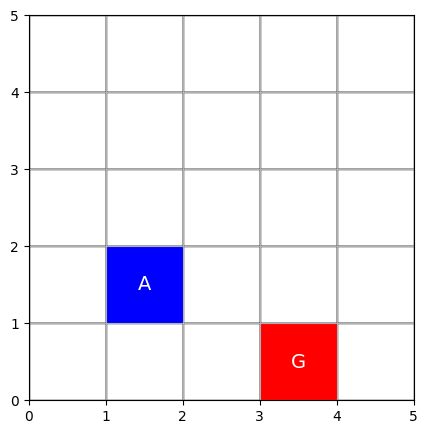

<Figure size 640x480 with 0 Axes>

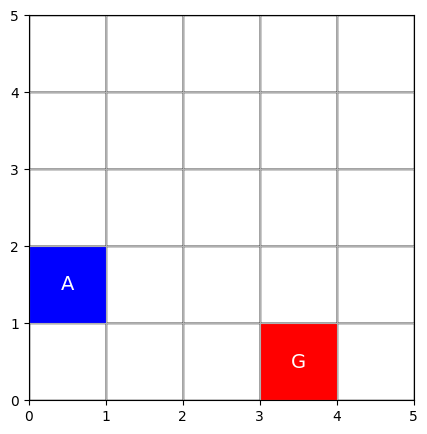

<Figure size 640x480 with 0 Axes>

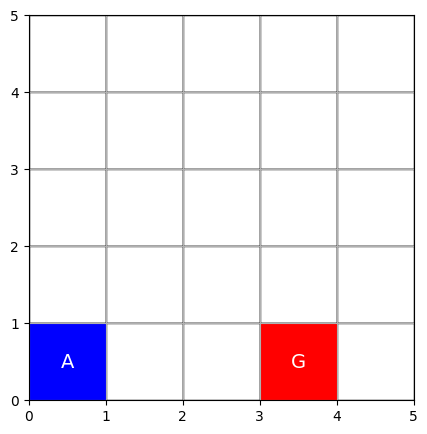

<Figure size 640x480 with 0 Axes>

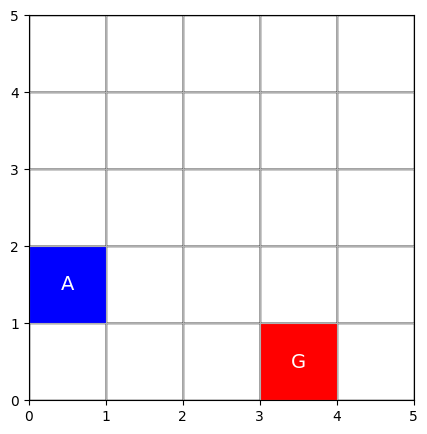

<Figure size 640x480 with 0 Axes>

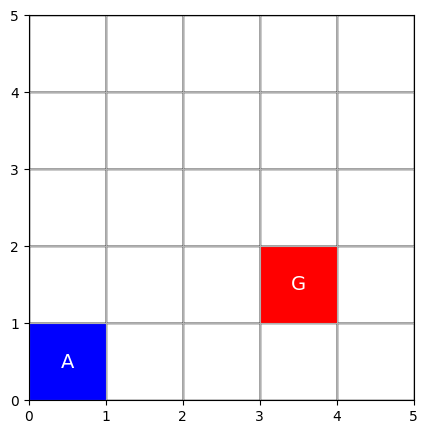

<Figure size 640x480 with 0 Axes>

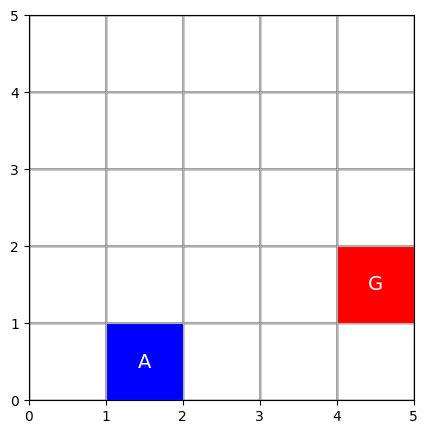

<Figure size 640x480 with 0 Axes>

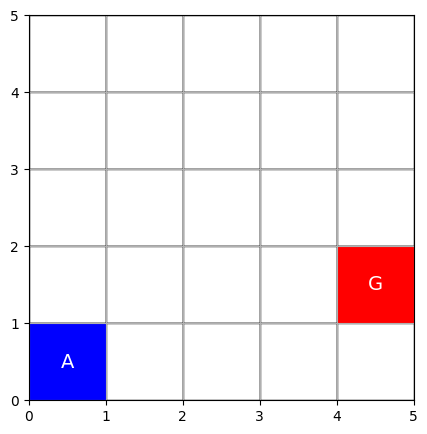

<Figure size 640x480 with 0 Axes>

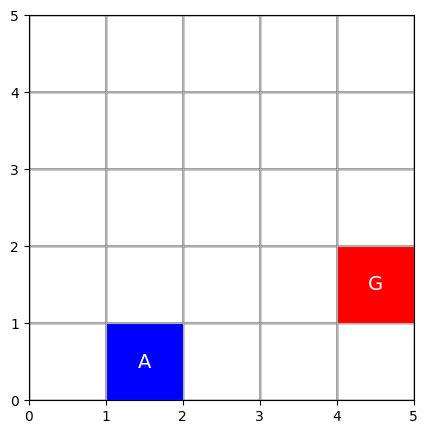

<Figure size 640x480 with 0 Axes>

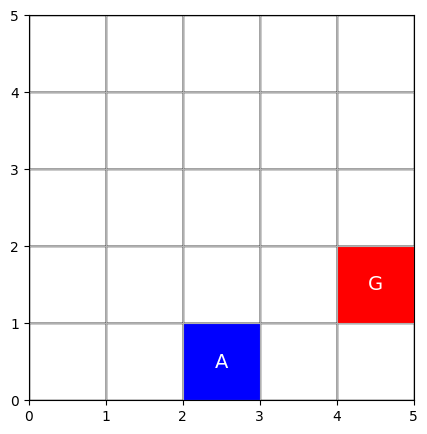

<Figure size 640x480 with 0 Axes>

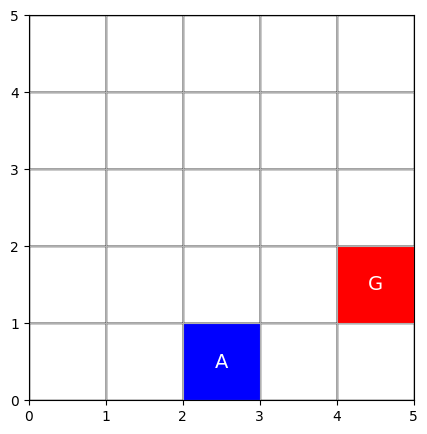

<Figure size 640x480 with 0 Axes>

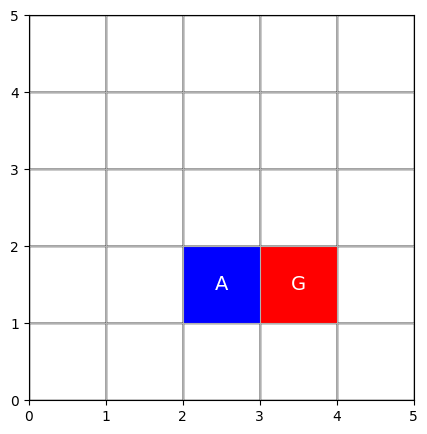

<Figure size 640x480 with 0 Axes>

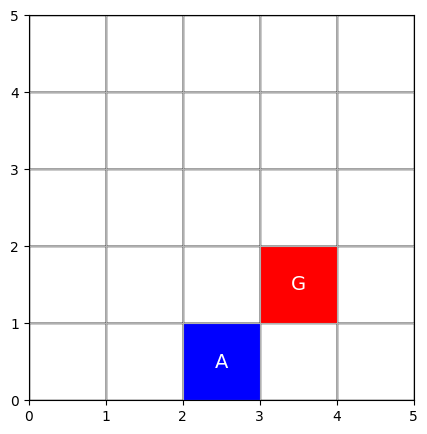

<Figure size 640x480 with 0 Axes>

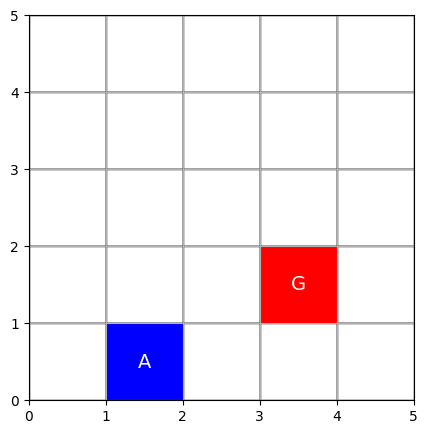

<Figure size 640x480 with 0 Axes>

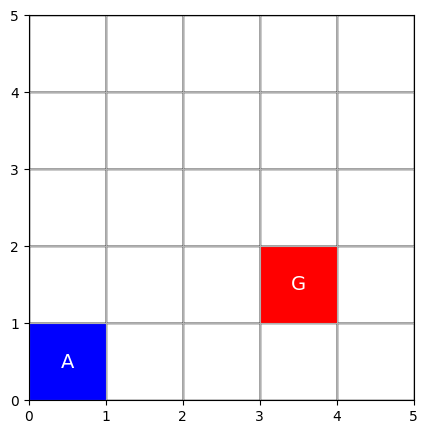

<Figure size 640x480 with 0 Axes>

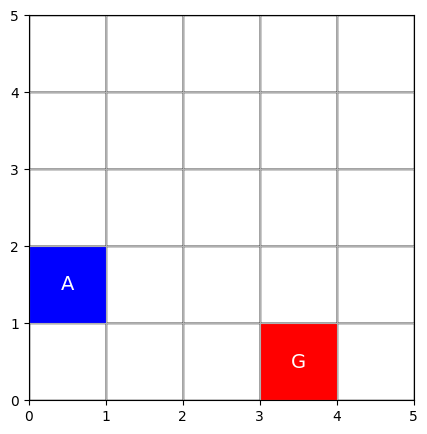

<Figure size 640x480 with 0 Axes>

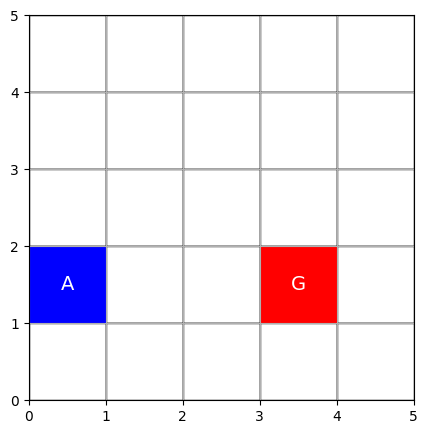

<Figure size 640x480 with 0 Axes>

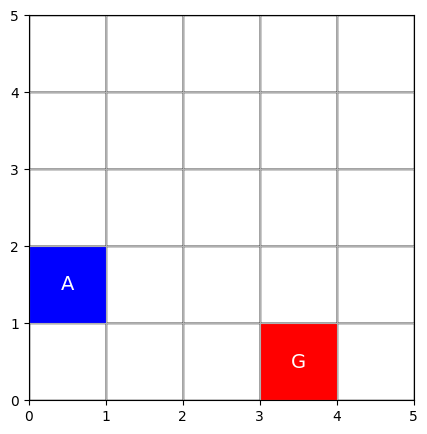

<Figure size 640x480 with 0 Axes>

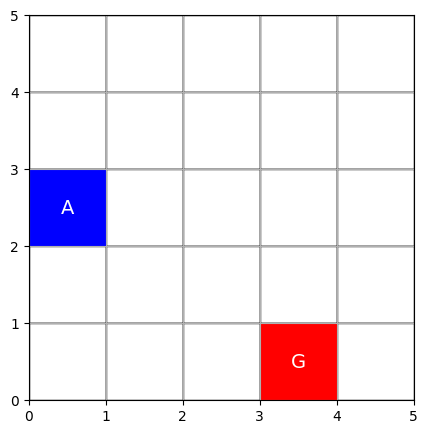

<Figure size 640x480 with 0 Axes>

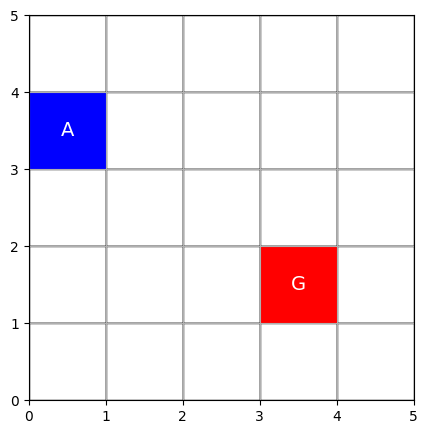

<Figure size 640x480 with 0 Axes>

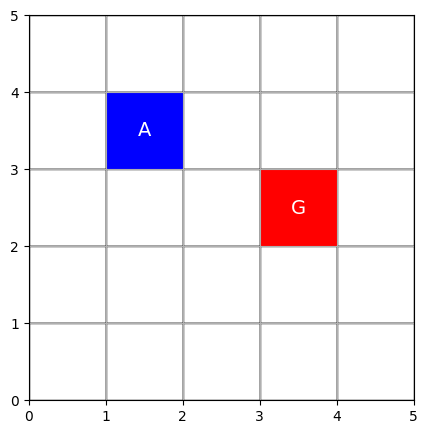

<Figure size 640x480 with 0 Axes>

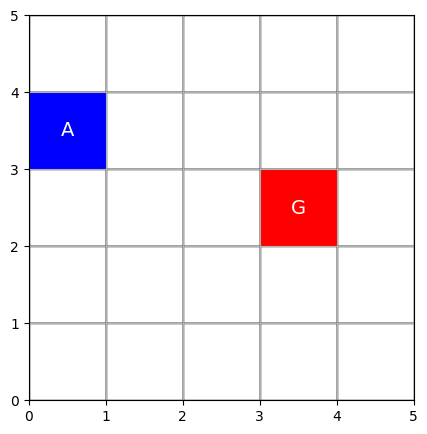

<Figure size 640x480 with 0 Axes>

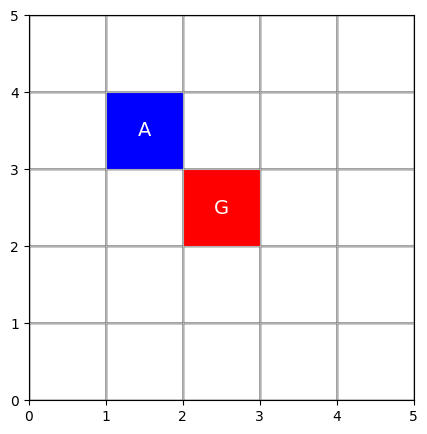

<Figure size 640x480 with 0 Axes>

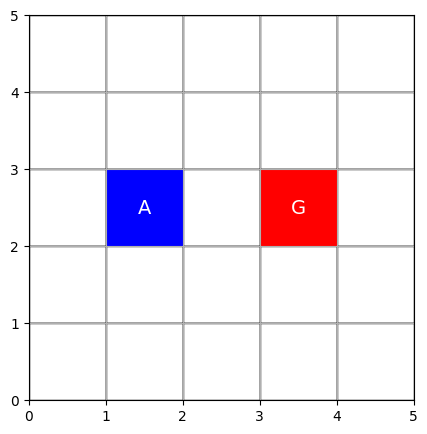

Episode 10/200 - Reward: -0.50


<Figure size 640x480 with 0 Axes>

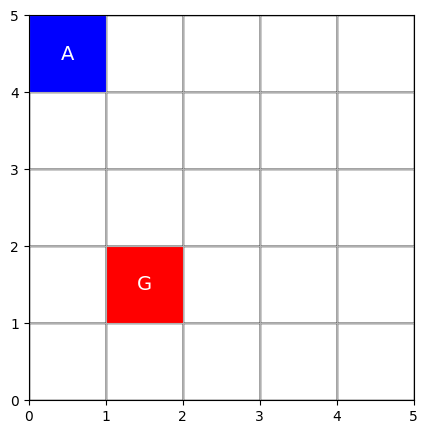

<Figure size 640x480 with 0 Axes>

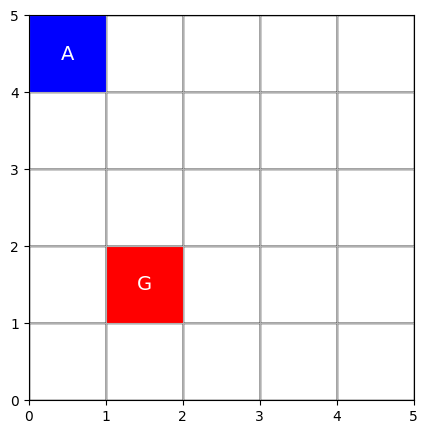

<Figure size 640x480 with 0 Axes>

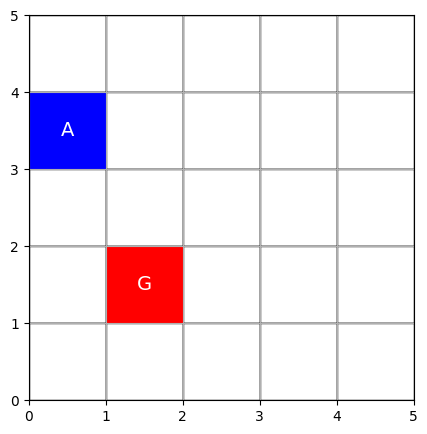

<Figure size 640x480 with 0 Axes>

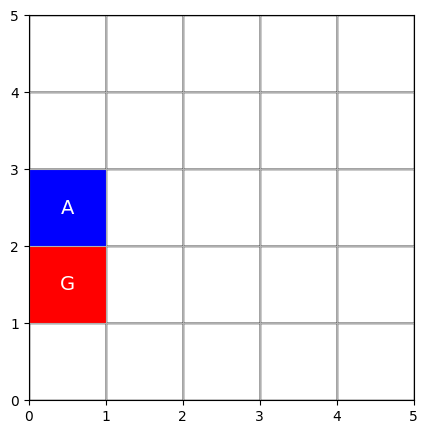

<Figure size 640x480 with 0 Axes>

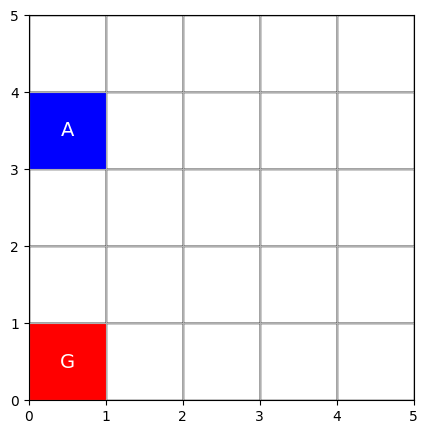

<Figure size 640x480 with 0 Axes>

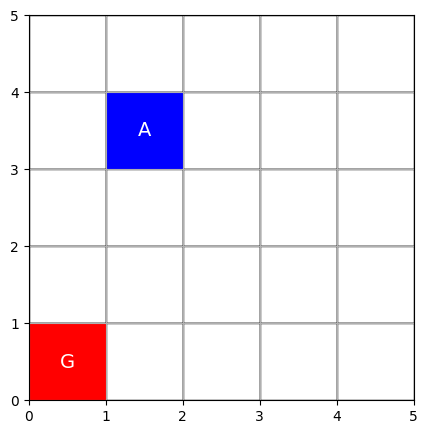

<Figure size 640x480 with 0 Axes>

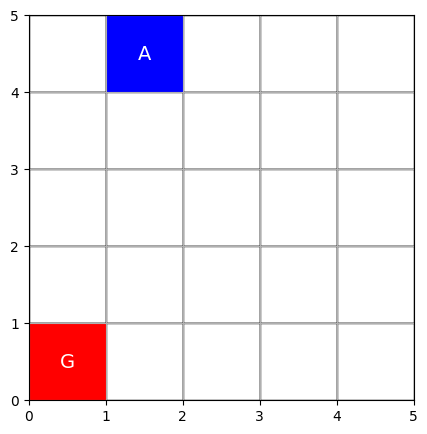

<Figure size 640x480 with 0 Axes>

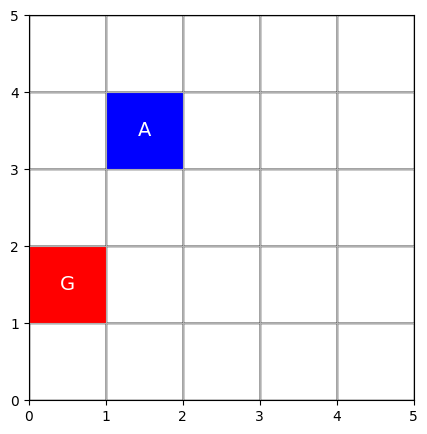

<Figure size 640x480 with 0 Axes>

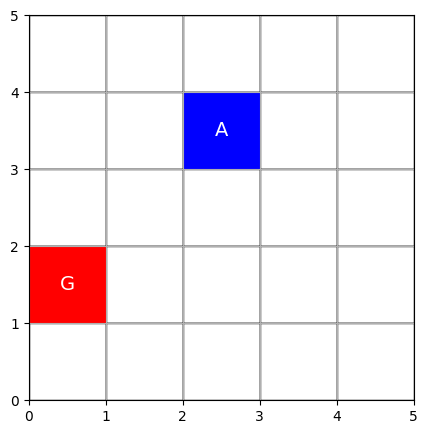

<Figure size 640x480 with 0 Axes>

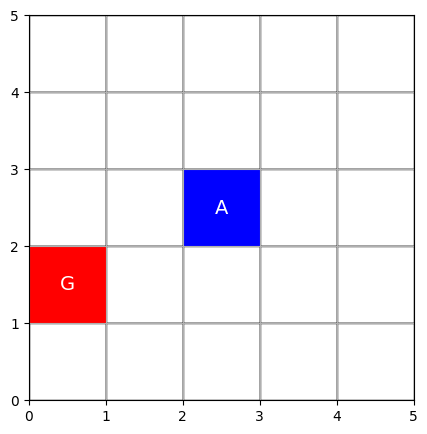

<Figure size 640x480 with 0 Axes>

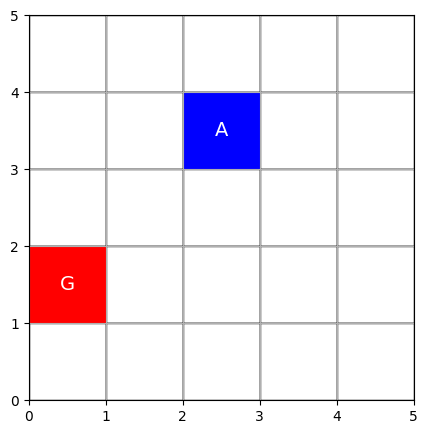

<Figure size 640x480 with 0 Axes>

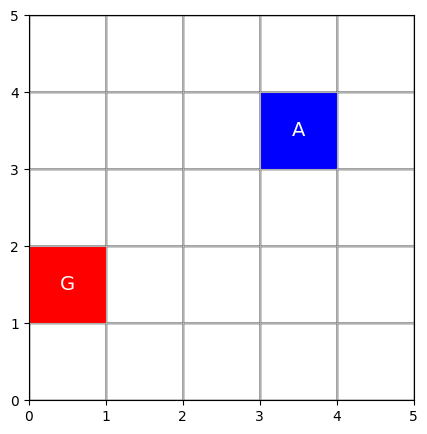

<Figure size 640x480 with 0 Axes>

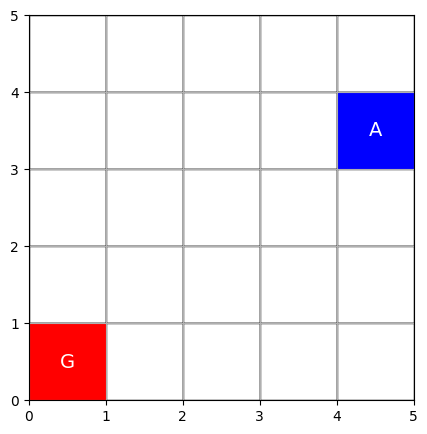

<Figure size 640x480 with 0 Axes>

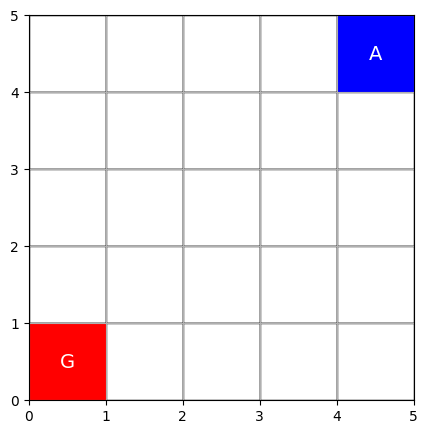

<Figure size 640x480 with 0 Axes>

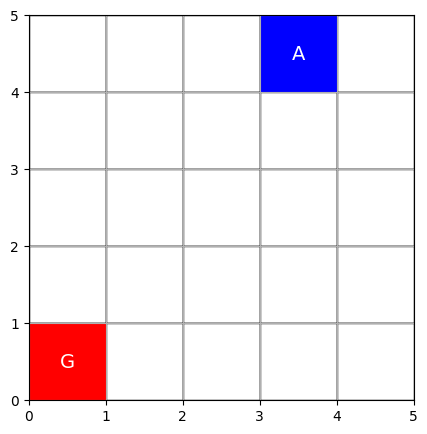

<Figure size 640x480 with 0 Axes>

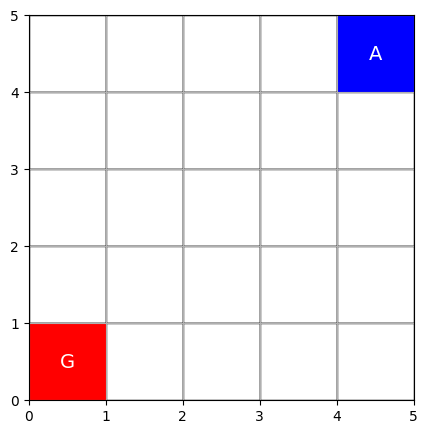

<Figure size 640x480 with 0 Axes>

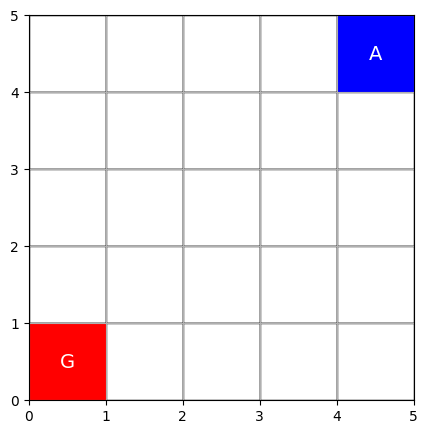

<Figure size 640x480 with 0 Axes>

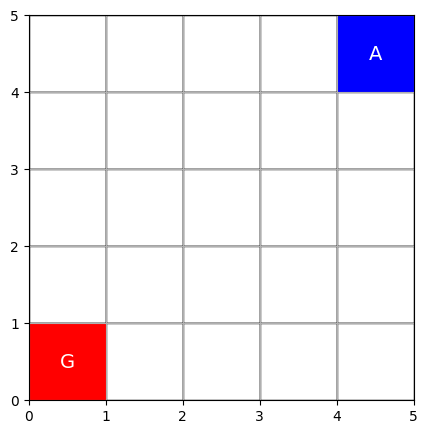

<Figure size 640x480 with 0 Axes>

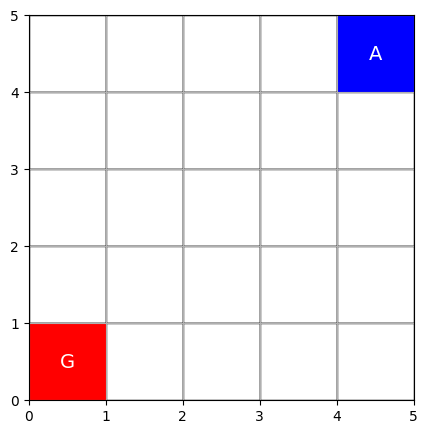

<Figure size 640x480 with 0 Axes>

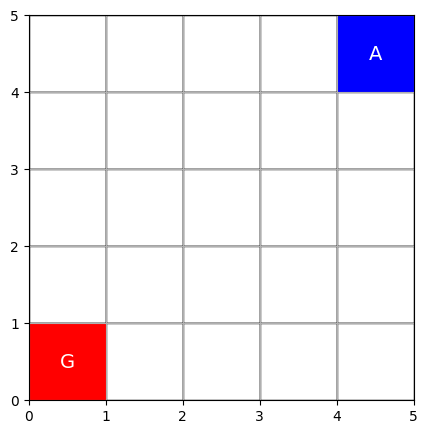

<Figure size 640x480 with 0 Axes>

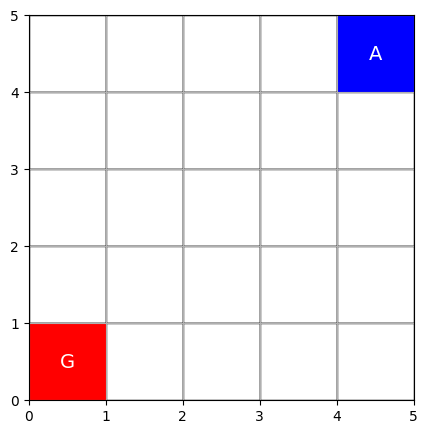

<Figure size 640x480 with 0 Axes>

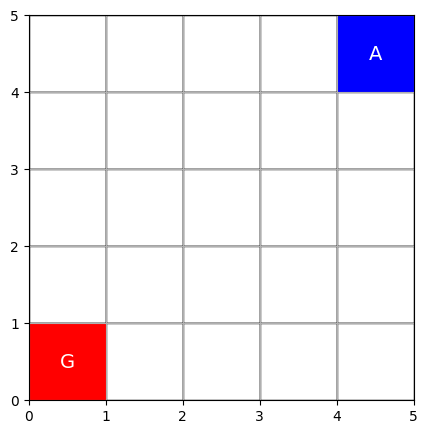

<Figure size 640x480 with 0 Axes>

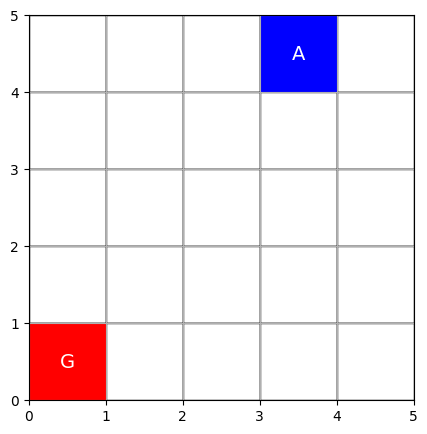

<Figure size 640x480 with 0 Axes>

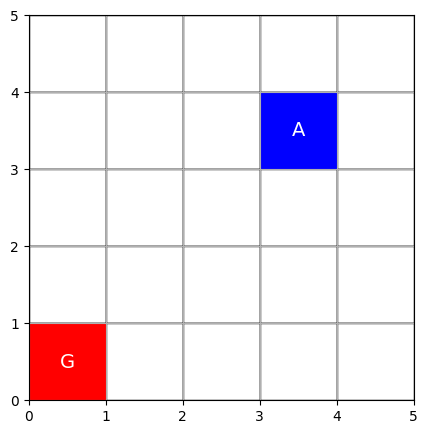

<Figure size 640x480 with 0 Axes>

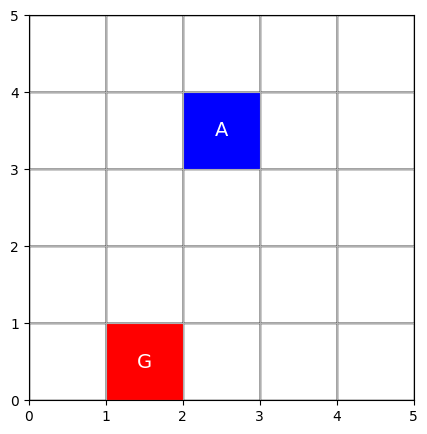

<Figure size 640x480 with 0 Axes>

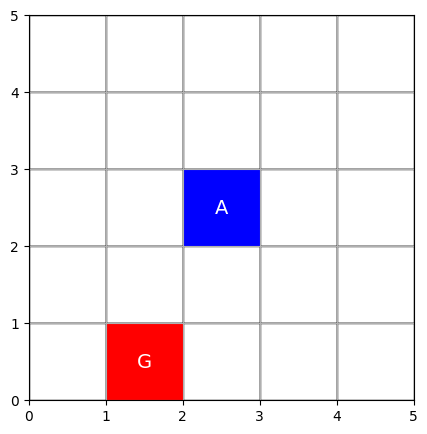

<Figure size 640x480 with 0 Axes>

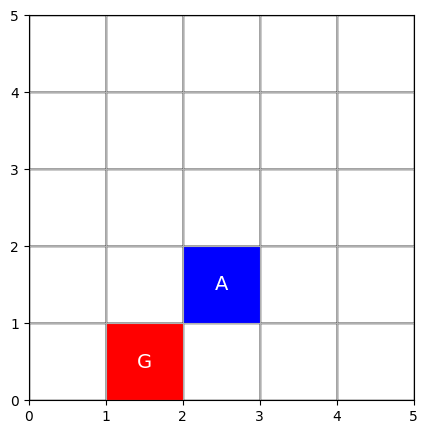

<Figure size 640x480 with 0 Axes>

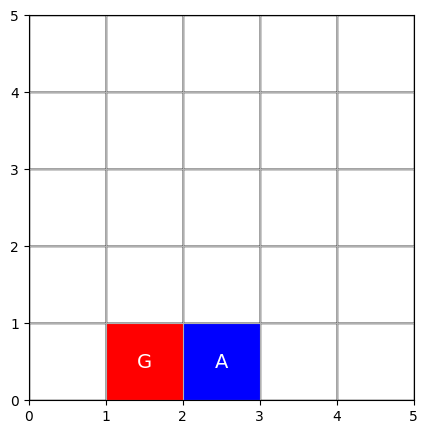

<Figure size 640x480 with 0 Axes>

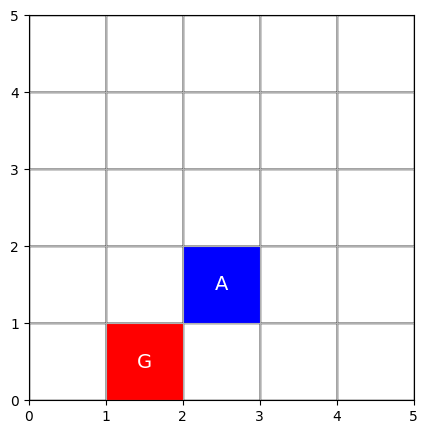

<Figure size 640x480 with 0 Axes>

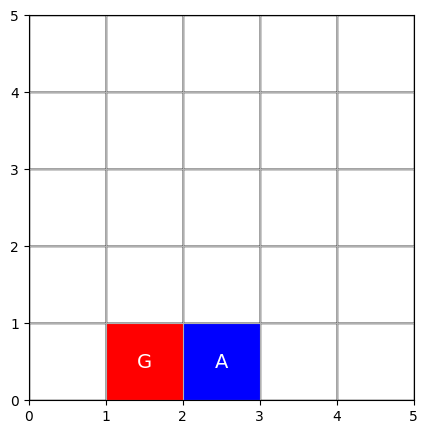

<Figure size 640x480 with 0 Axes>

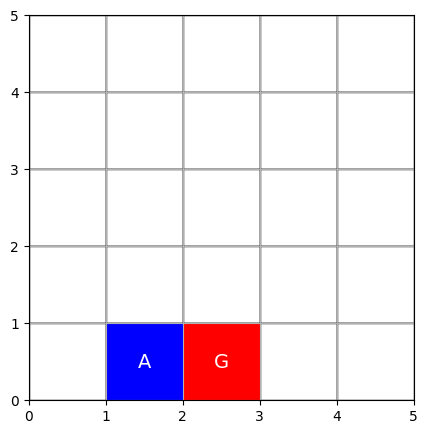

Episode 11/200 - Reward: 0.70


<Figure size 640x480 with 0 Axes>

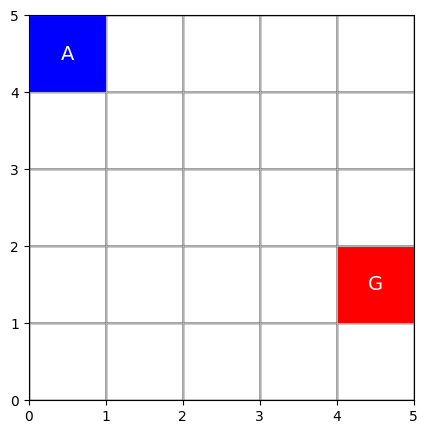

<Figure size 640x480 with 0 Axes>

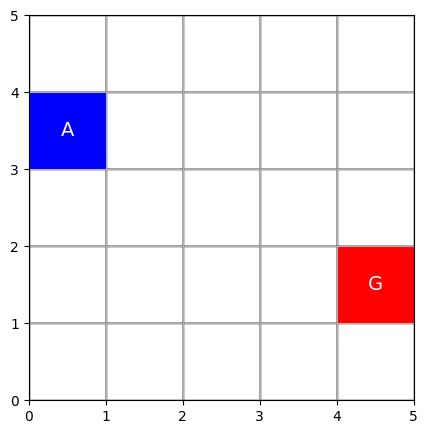

<Figure size 640x480 with 0 Axes>

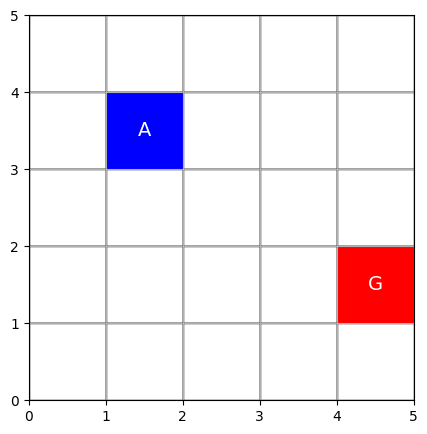

<Figure size 640x480 with 0 Axes>

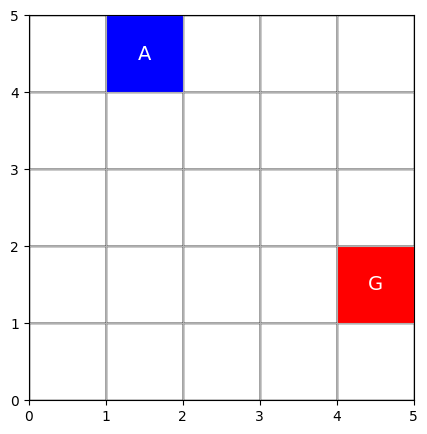

<Figure size 640x480 with 0 Axes>

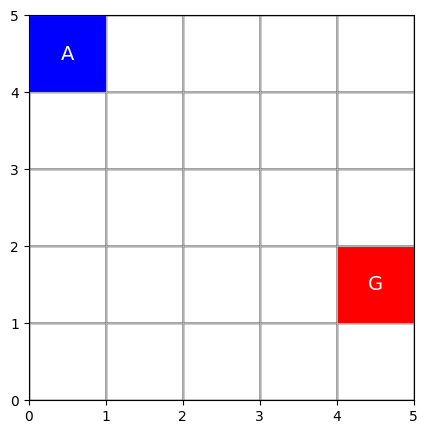

<Figure size 640x480 with 0 Axes>

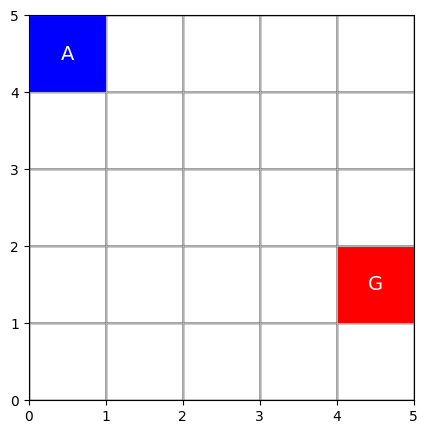

<Figure size 640x480 with 0 Axes>

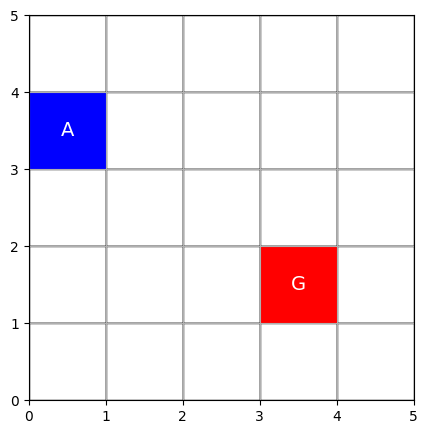

<Figure size 640x480 with 0 Axes>

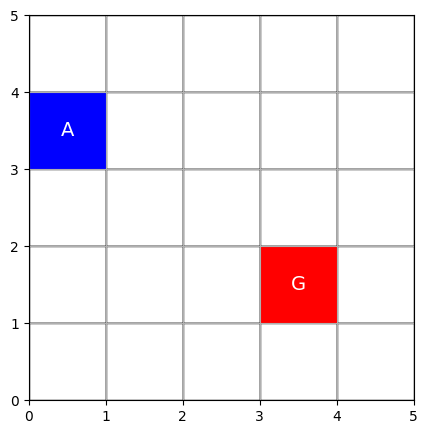

<Figure size 640x480 with 0 Axes>

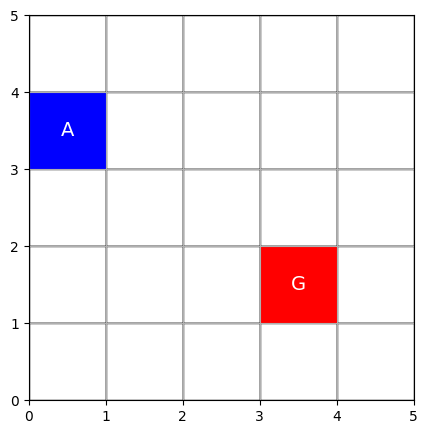

<Figure size 640x480 with 0 Axes>

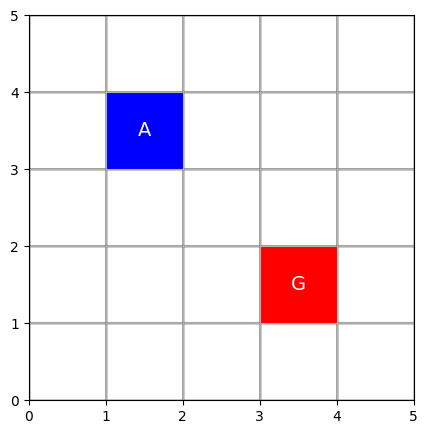

<Figure size 640x480 with 0 Axes>

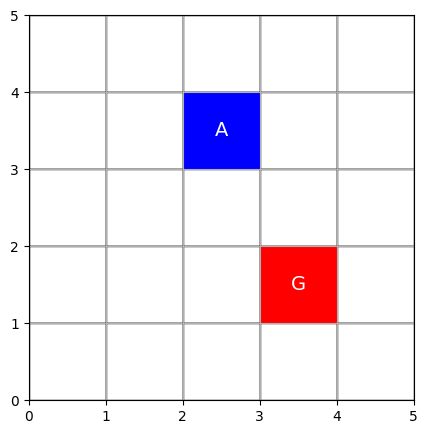

<Figure size 640x480 with 0 Axes>

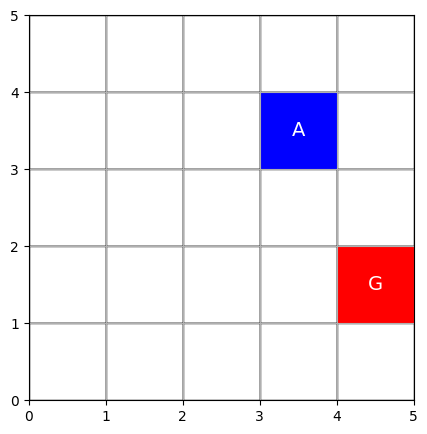

<Figure size 640x480 with 0 Axes>

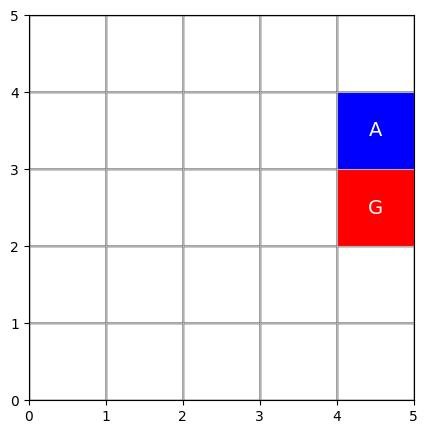

<Figure size 640x480 with 0 Axes>

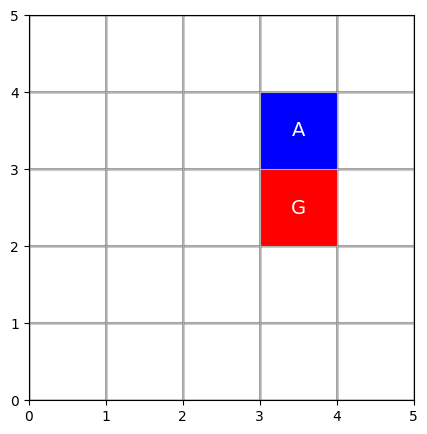

<Figure size 640x480 with 0 Axes>

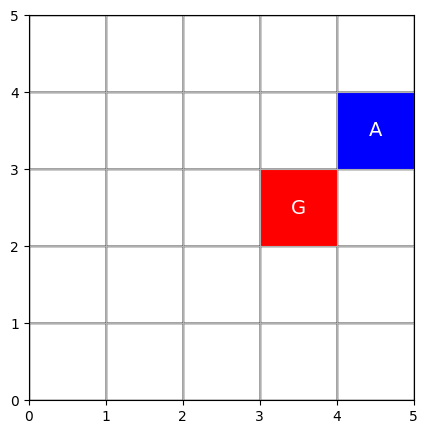

<Figure size 640x480 with 0 Axes>

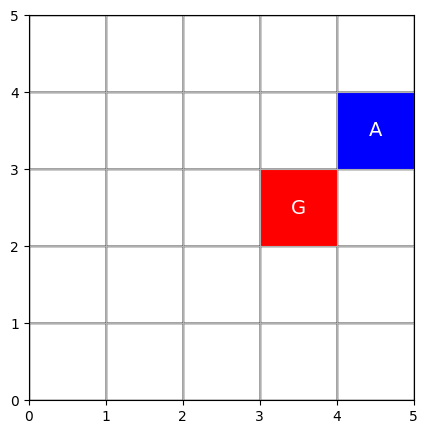

<Figure size 640x480 with 0 Axes>

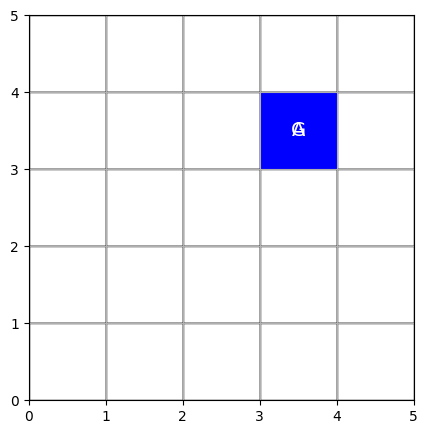

<Figure size 640x480 with 0 Axes>

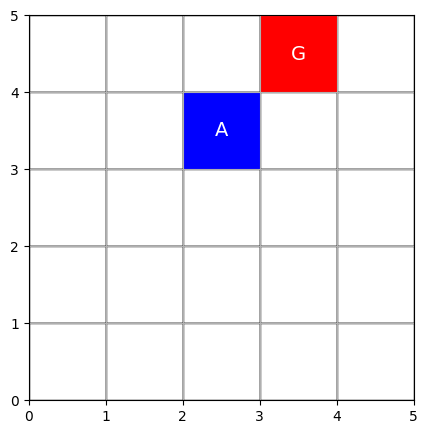

<Figure size 640x480 with 0 Axes>

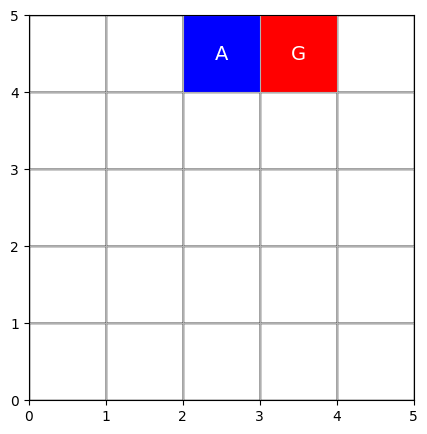

<Figure size 640x480 with 0 Axes>

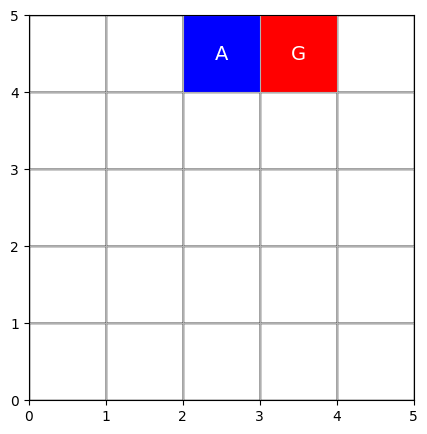

<Figure size 640x480 with 0 Axes>

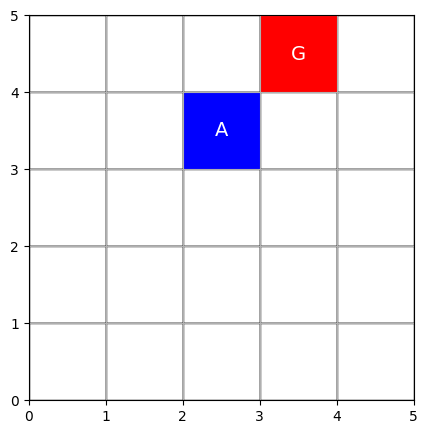

<Figure size 640x480 with 0 Axes>

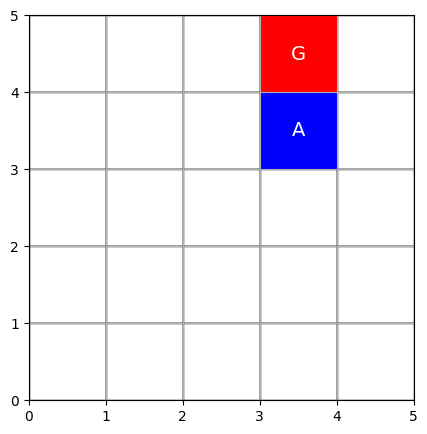

<Figure size 640x480 with 0 Axes>

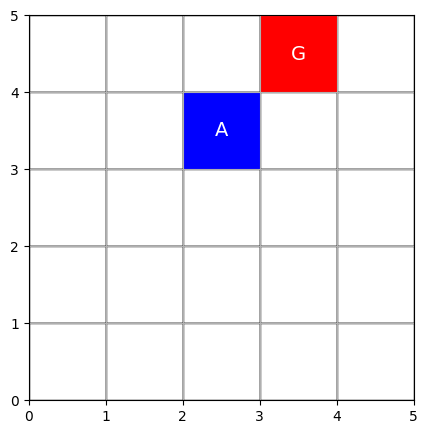

<Figure size 640x480 with 0 Axes>

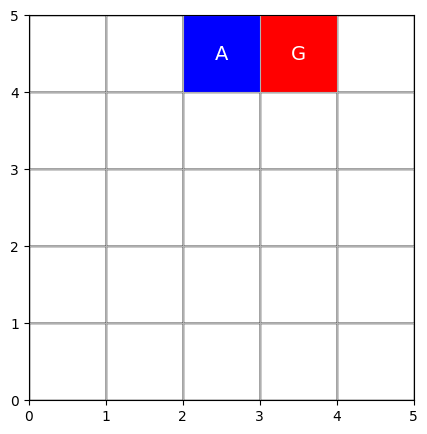

<Figure size 640x480 with 0 Axes>

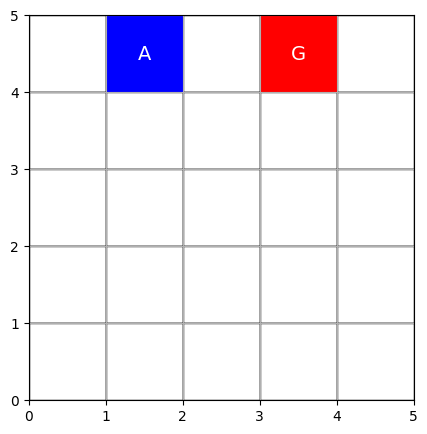

<Figure size 640x480 with 0 Axes>

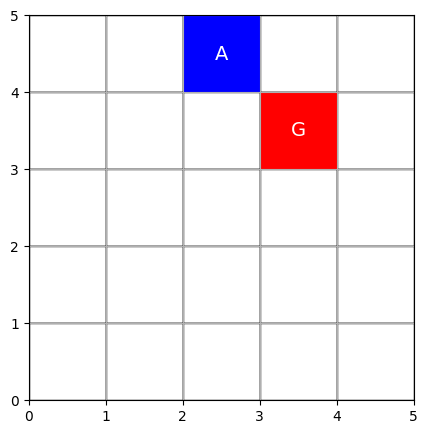

<Figure size 640x480 with 0 Axes>

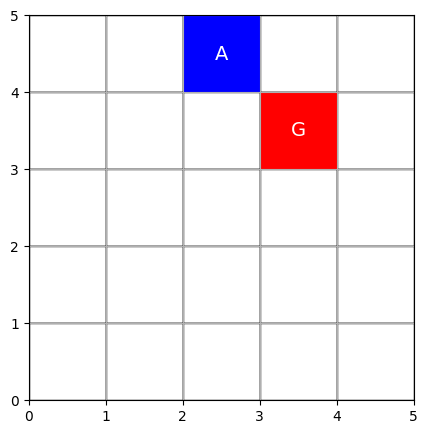

<Figure size 640x480 with 0 Axes>

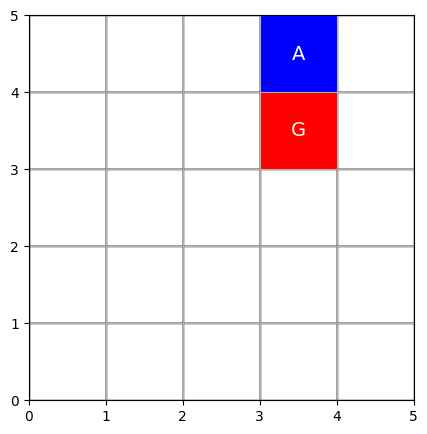

<Figure size 640x480 with 0 Axes>

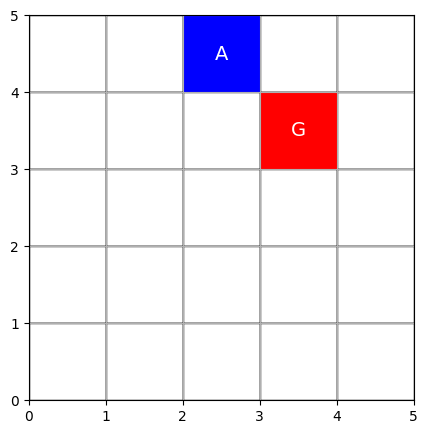

<Figure size 640x480 with 0 Axes>

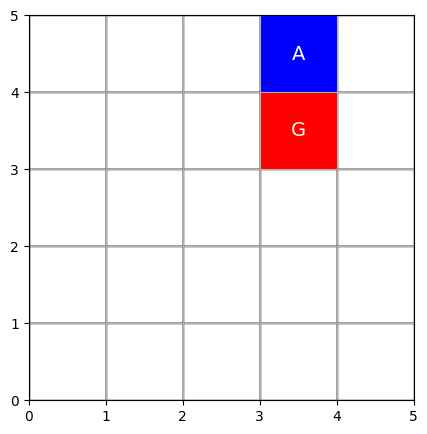

<Figure size 640x480 with 0 Axes>

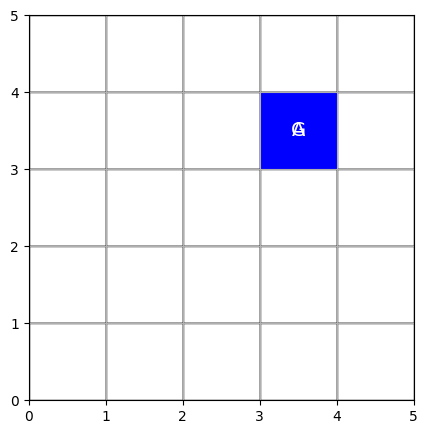

Episode 12/200 - Reward: 0.70


<Figure size 640x480 with 0 Axes>

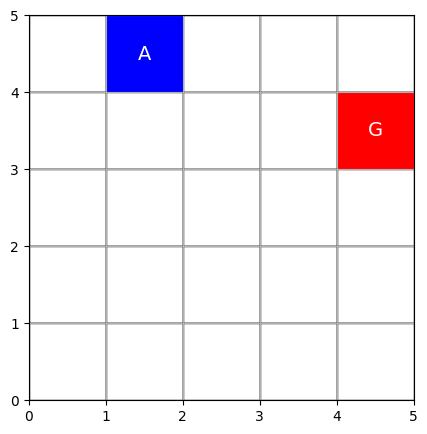

<Figure size 640x480 with 0 Axes>

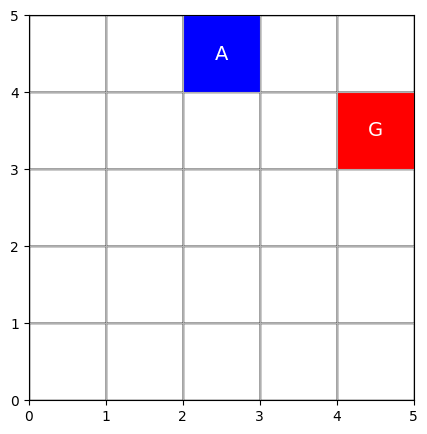

<Figure size 640x480 with 0 Axes>

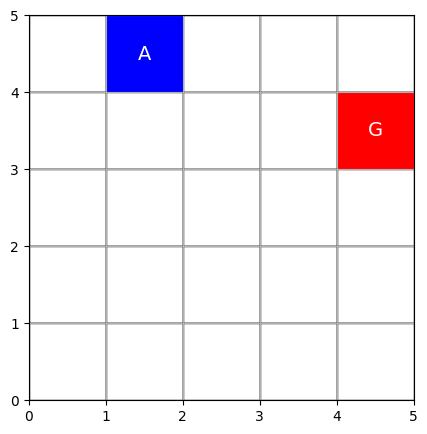

<Figure size 640x480 with 0 Axes>

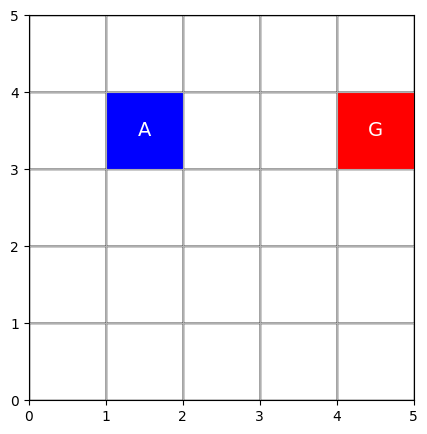

<Figure size 640x480 with 0 Axes>

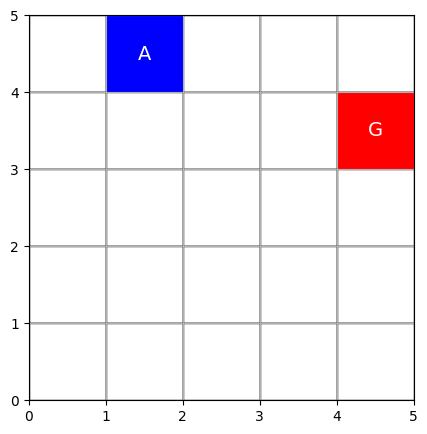

<Figure size 640x480 with 0 Axes>

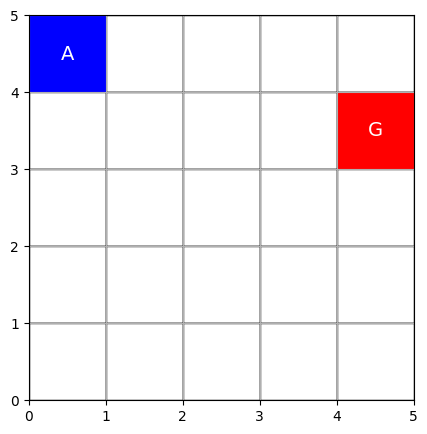

<Figure size 640x480 with 0 Axes>

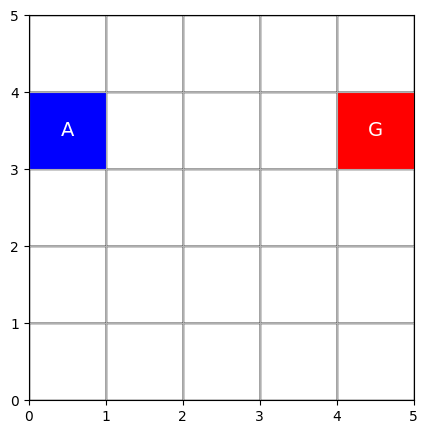

<Figure size 640x480 with 0 Axes>

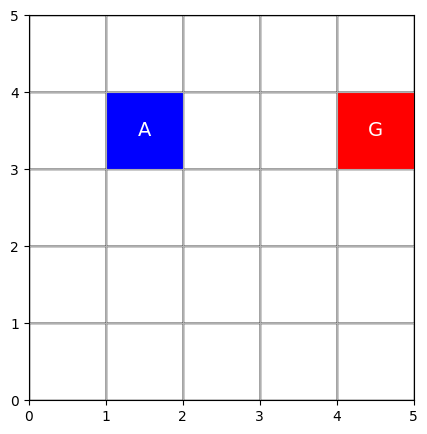

<Figure size 640x480 with 0 Axes>

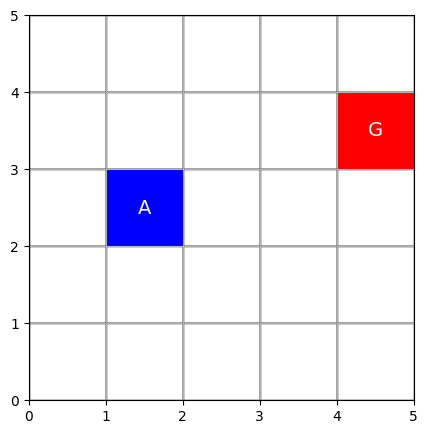

<Figure size 640x480 with 0 Axes>

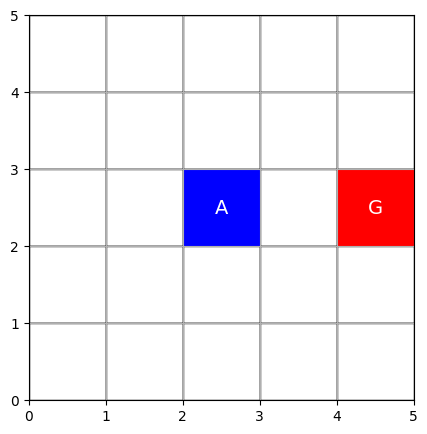

<Figure size 640x480 with 0 Axes>

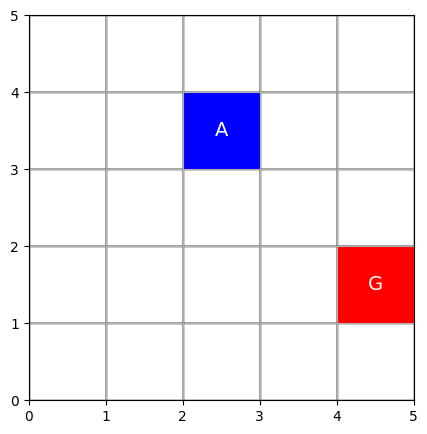

<Figure size 640x480 with 0 Axes>

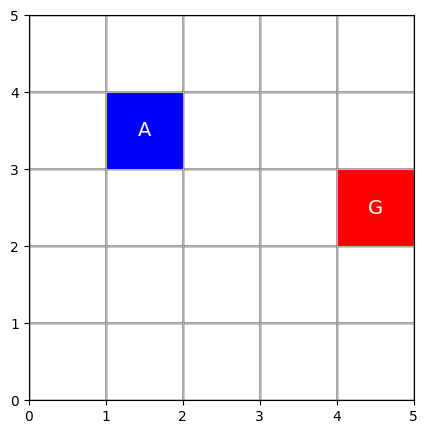

<Figure size 640x480 with 0 Axes>

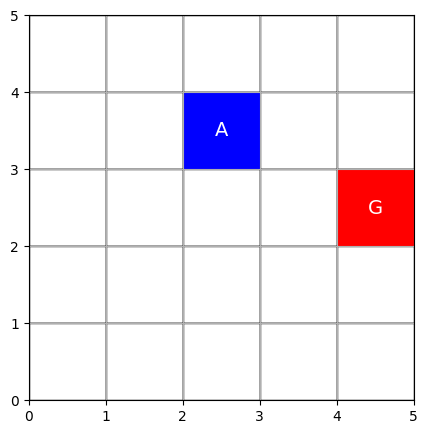

<Figure size 640x480 with 0 Axes>

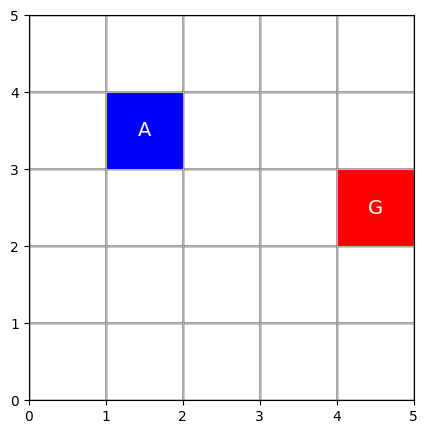

<Figure size 640x480 with 0 Axes>

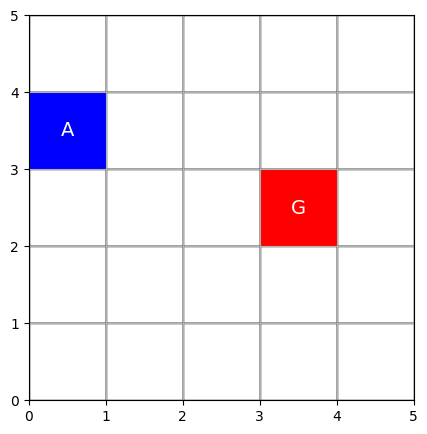

<Figure size 640x480 with 0 Axes>

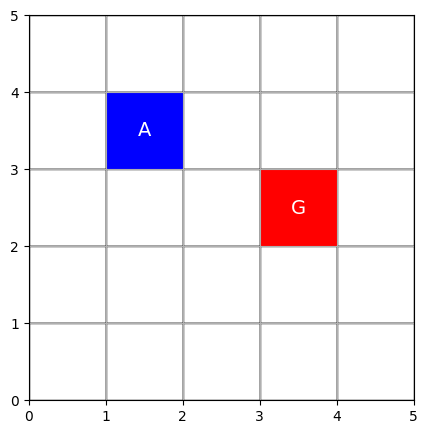

<Figure size 640x480 with 0 Axes>

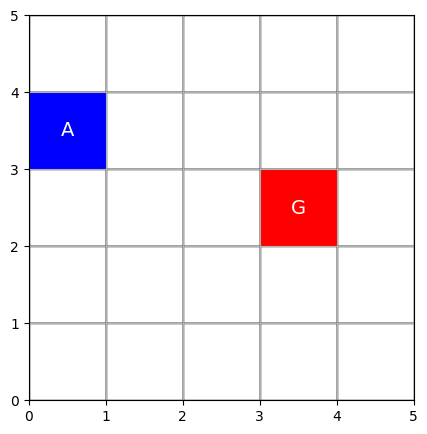

<Figure size 640x480 with 0 Axes>

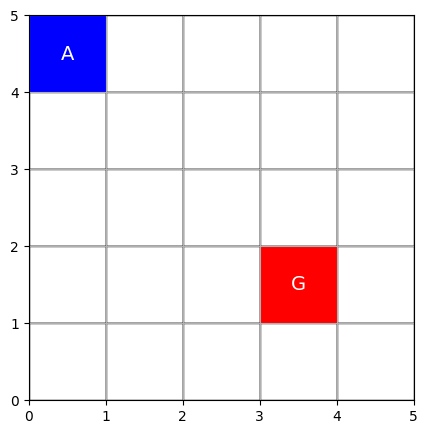

<Figure size 640x480 with 0 Axes>

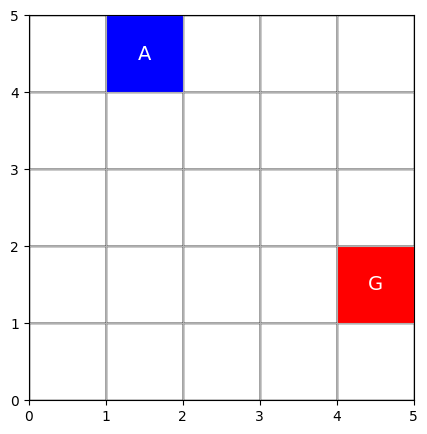

<Figure size 640x480 with 0 Axes>

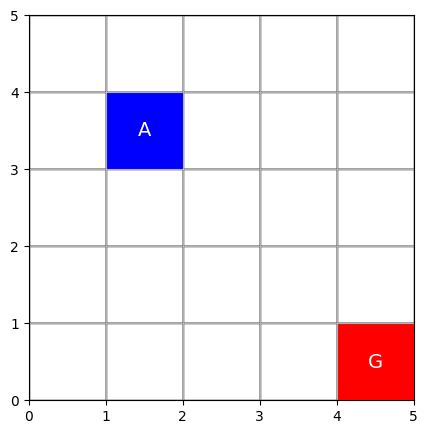

<Figure size 640x480 with 0 Axes>

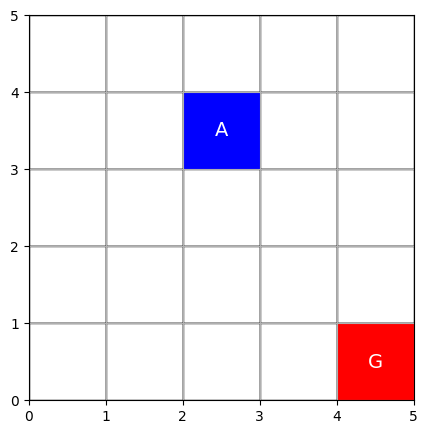

<Figure size 640x480 with 0 Axes>

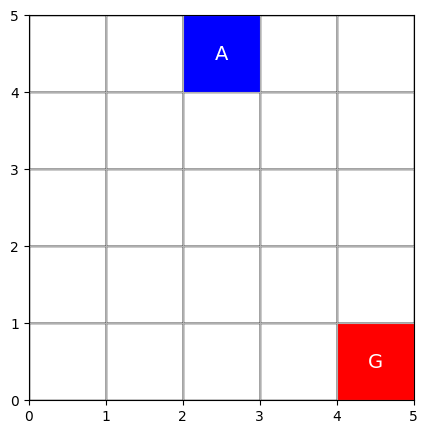

<Figure size 640x480 with 0 Axes>

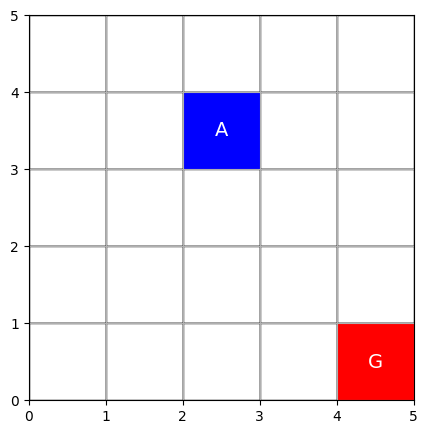

<Figure size 640x480 with 0 Axes>

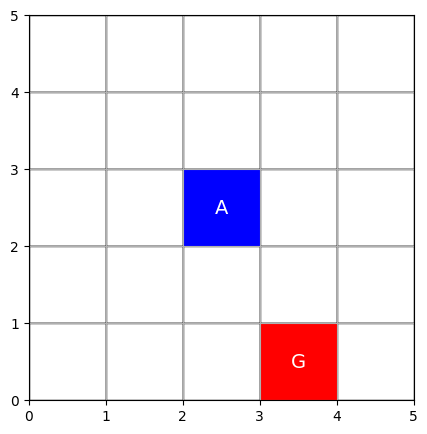

<Figure size 640x480 with 0 Axes>

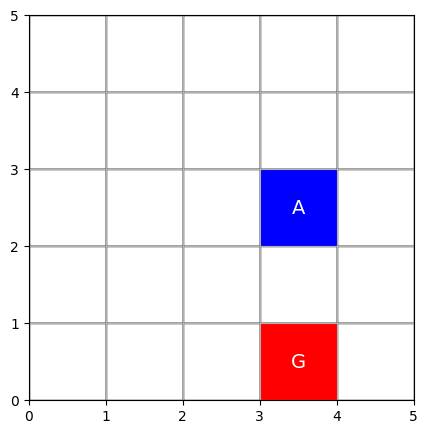

<Figure size 640x480 with 0 Axes>

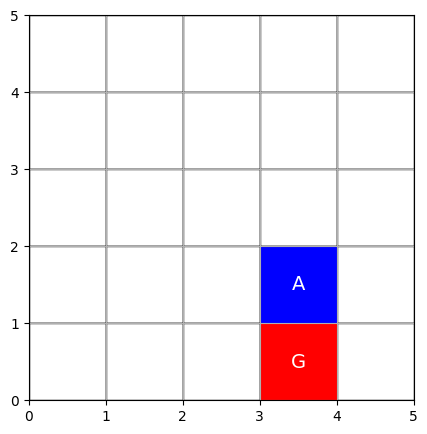

<Figure size 640x480 with 0 Axes>

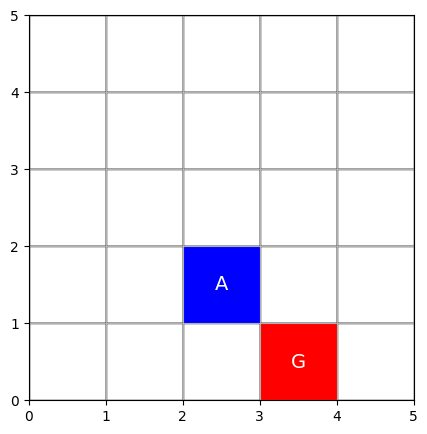

<Figure size 640x480 with 0 Axes>

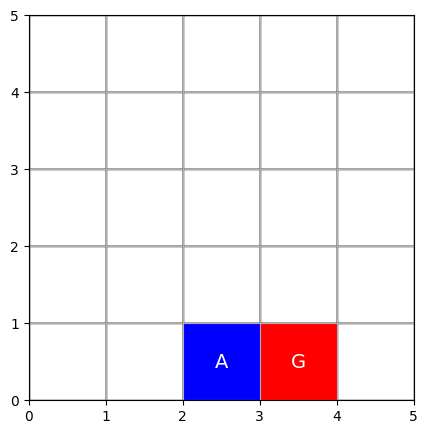

<Figure size 640x480 with 0 Axes>

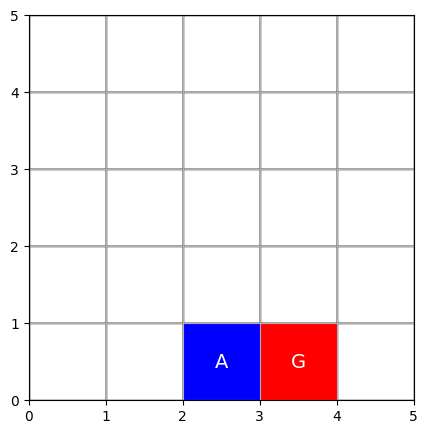

<Figure size 640x480 with 0 Axes>

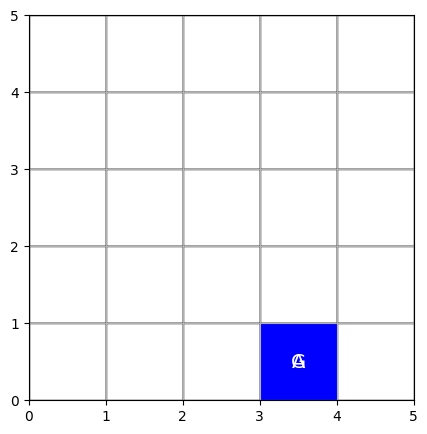

Episode 13/200 - Reward: 0.71


<Figure size 640x480 with 0 Axes>

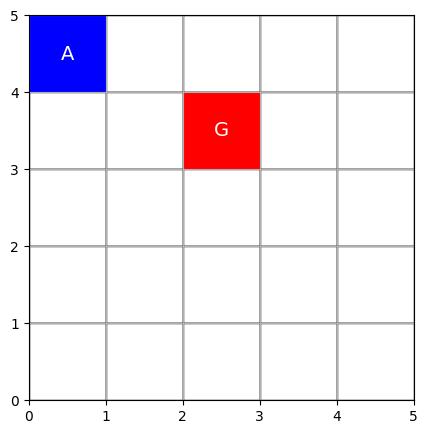

<Figure size 640x480 with 0 Axes>

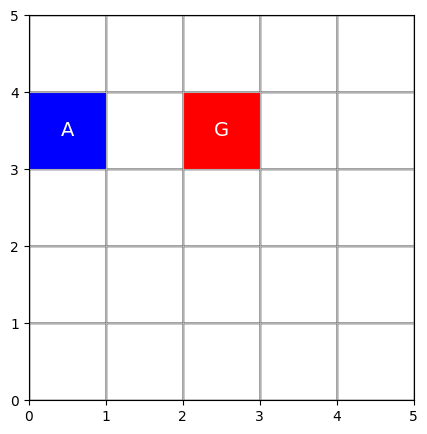

<Figure size 640x480 with 0 Axes>

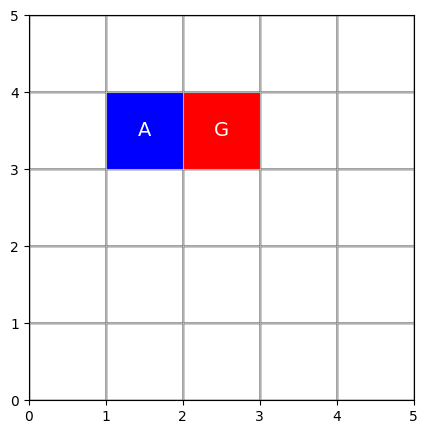

<Figure size 640x480 with 0 Axes>

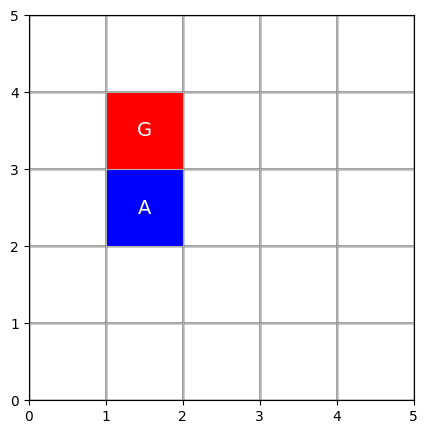

<Figure size 640x480 with 0 Axes>

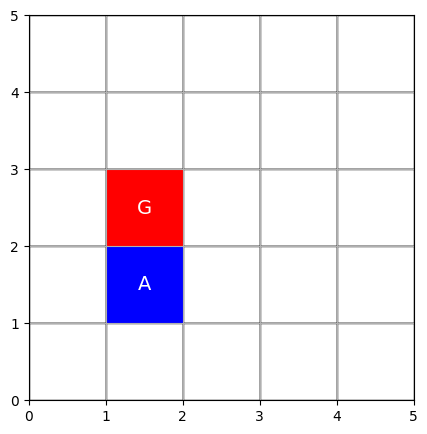

<Figure size 640x480 with 0 Axes>

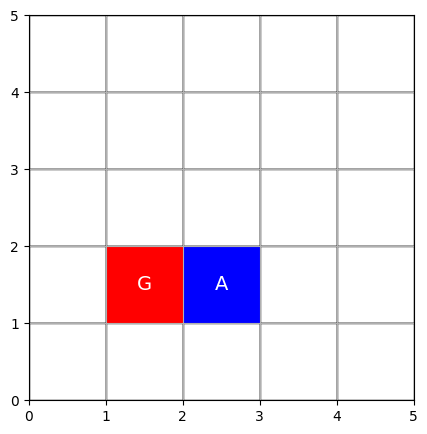

<Figure size 640x480 with 0 Axes>

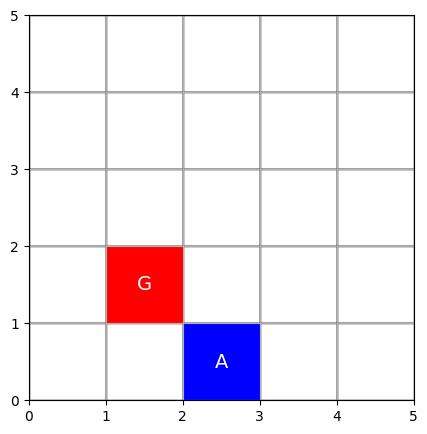

<Figure size 640x480 with 0 Axes>

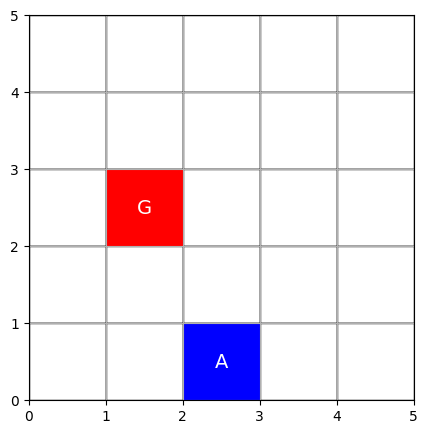

<Figure size 640x480 with 0 Axes>

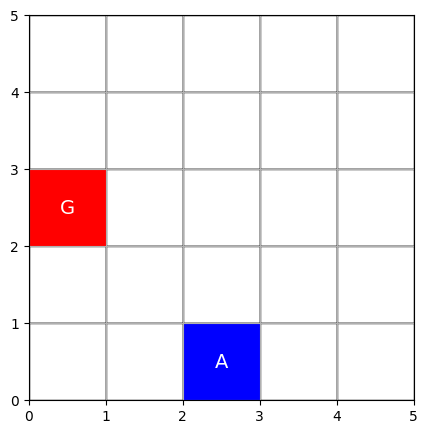

<Figure size 640x480 with 0 Axes>

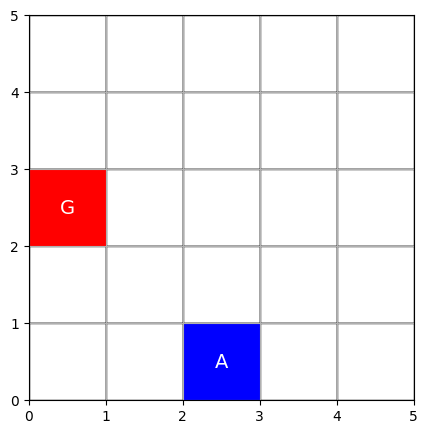

<Figure size 640x480 with 0 Axes>

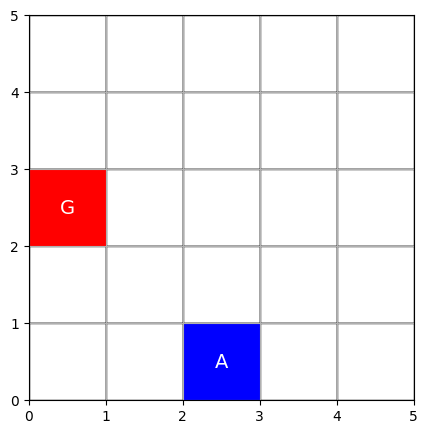

<Figure size 640x480 with 0 Axes>

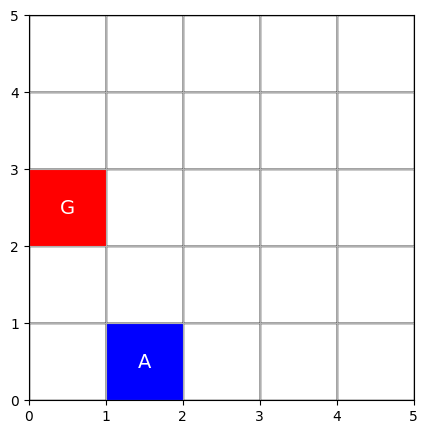

<Figure size 640x480 with 0 Axes>

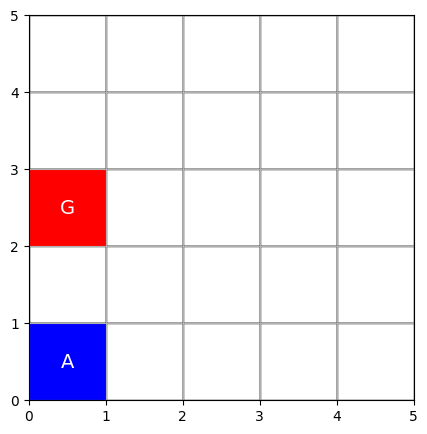

<Figure size 640x480 with 0 Axes>

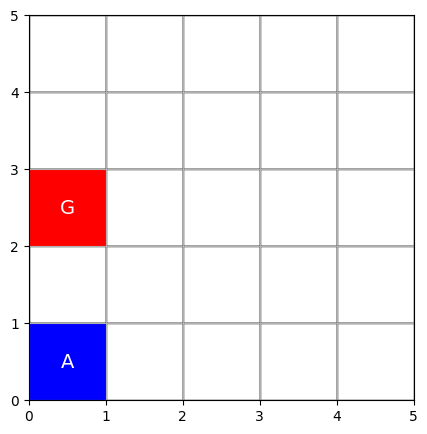

<Figure size 640x480 with 0 Axes>

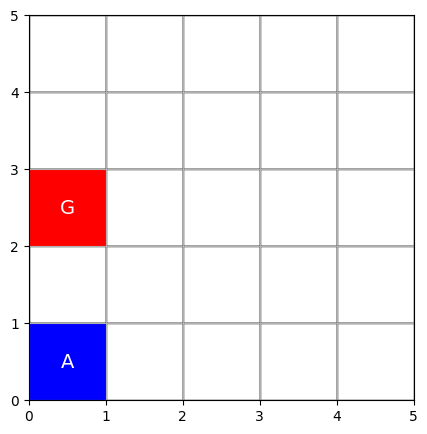

<Figure size 640x480 with 0 Axes>

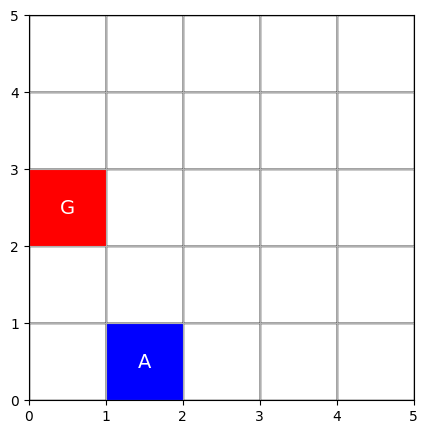

<Figure size 640x480 with 0 Axes>

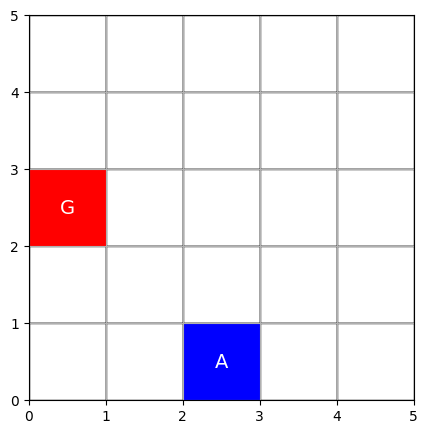

<Figure size 640x480 with 0 Axes>

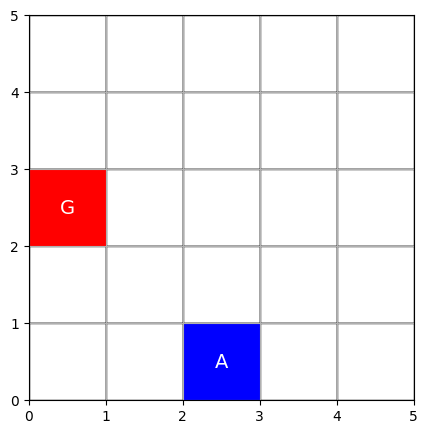

<Figure size 640x480 with 0 Axes>

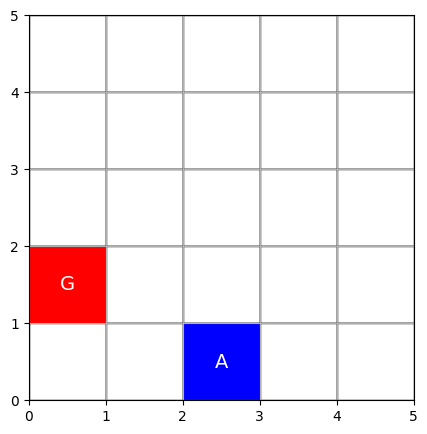

<Figure size 640x480 with 0 Axes>

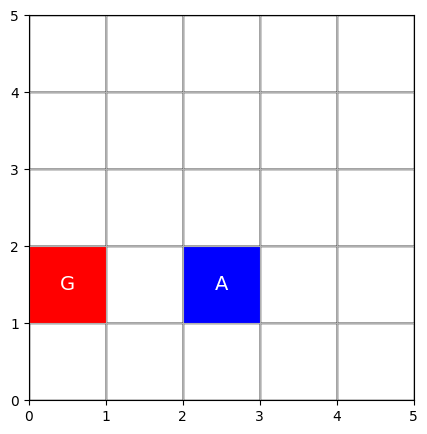

<Figure size 640x480 with 0 Axes>

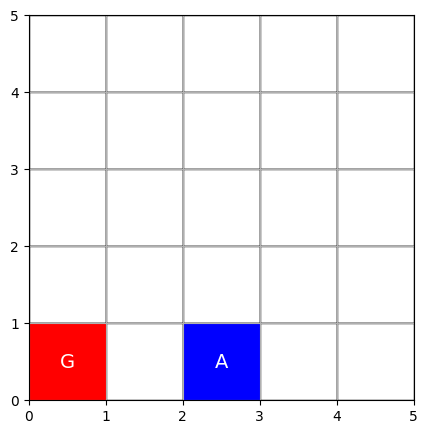

<Figure size 640x480 with 0 Axes>

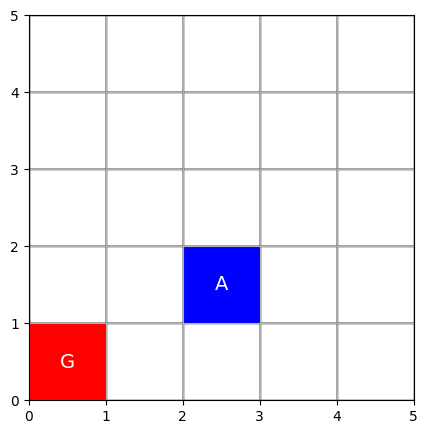

<Figure size 640x480 with 0 Axes>

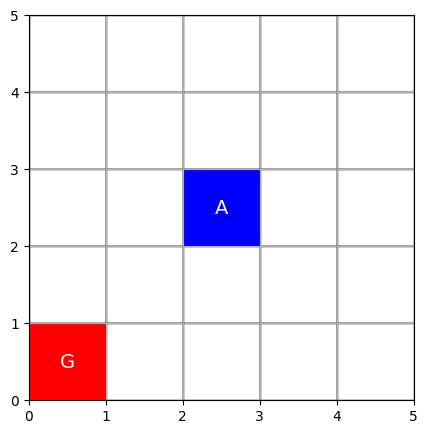

<Figure size 640x480 with 0 Axes>

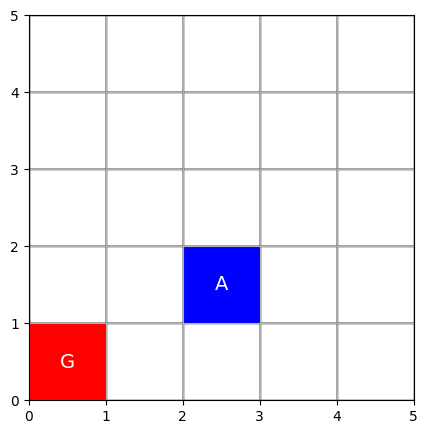

<Figure size 640x480 with 0 Axes>

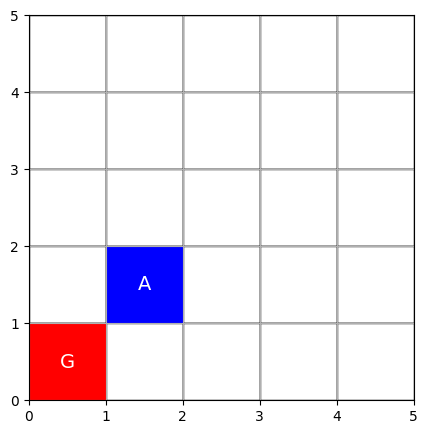

<Figure size 640x480 with 0 Axes>

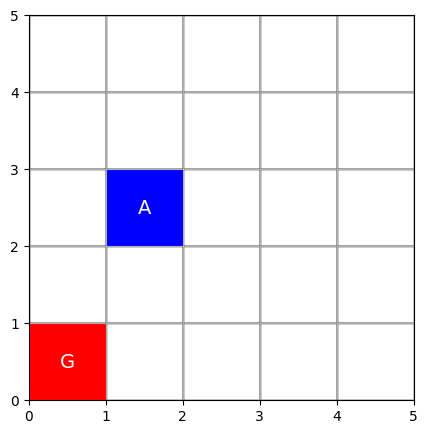

<Figure size 640x480 with 0 Axes>

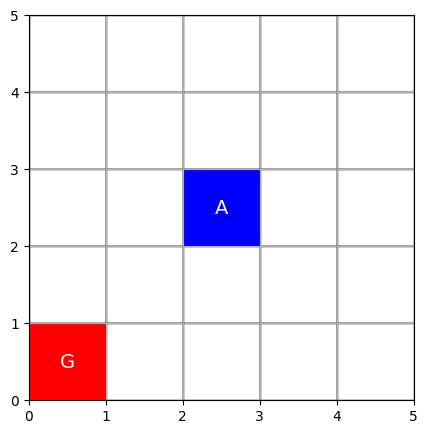

<Figure size 640x480 with 0 Axes>

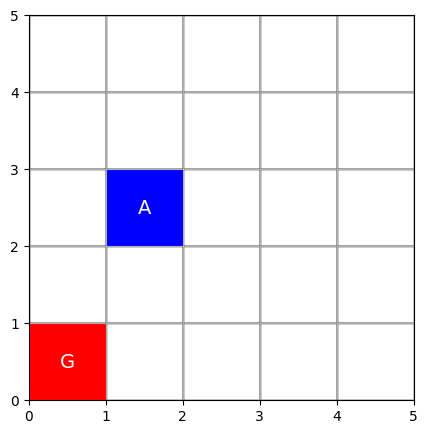

<Figure size 640x480 with 0 Axes>

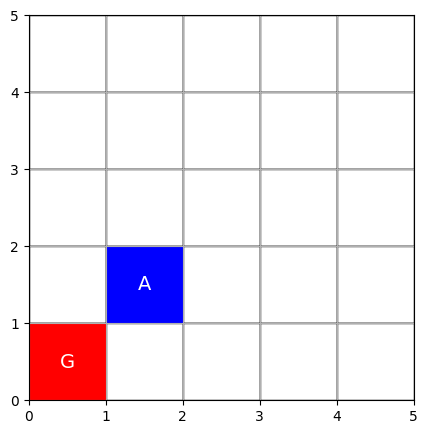

<Figure size 640x480 with 0 Axes>

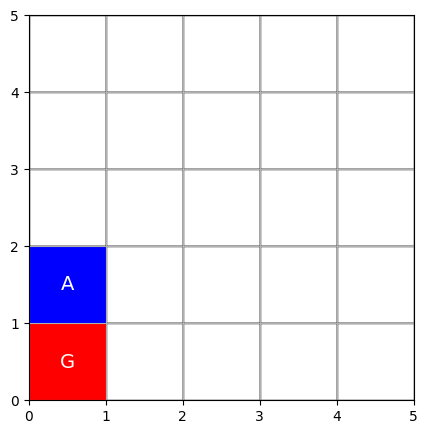

<Figure size 640x480 with 0 Axes>

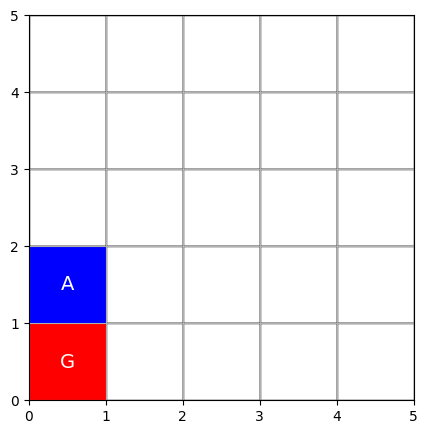

<Figure size 640x480 with 0 Axes>

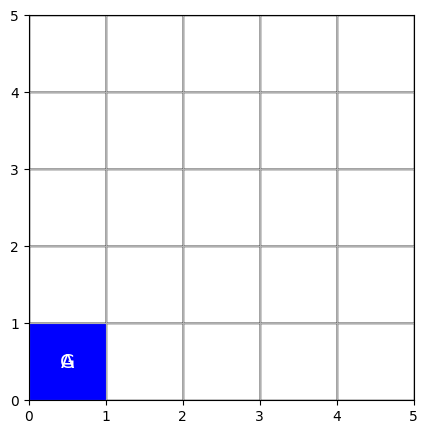

Episode 14/200 - Reward: 0.69


<Figure size 640x480 with 0 Axes>

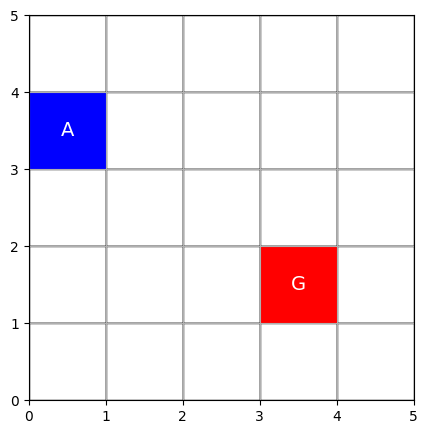

<Figure size 640x480 with 0 Axes>

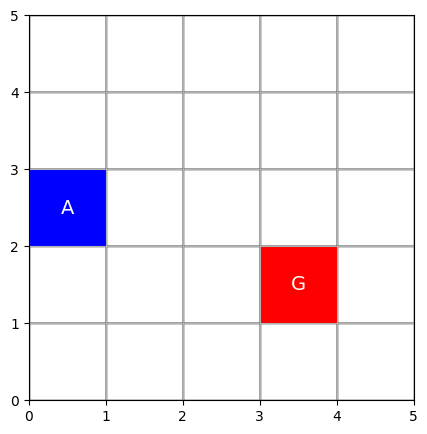

<Figure size 640x480 with 0 Axes>

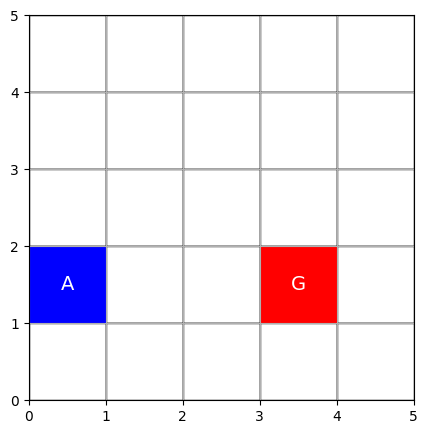

<Figure size 640x480 with 0 Axes>

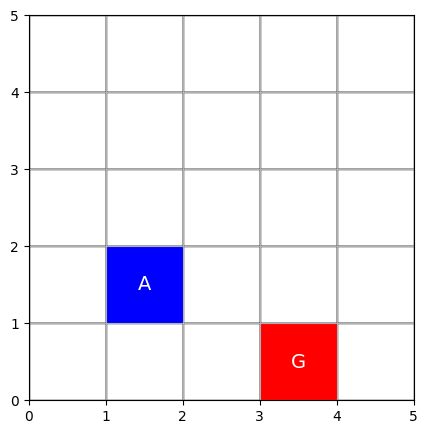

<Figure size 640x480 with 0 Axes>

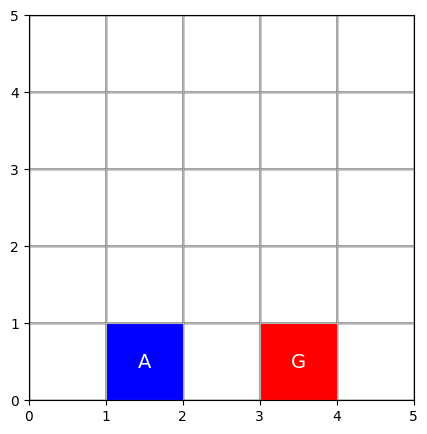

<Figure size 640x480 with 0 Axes>

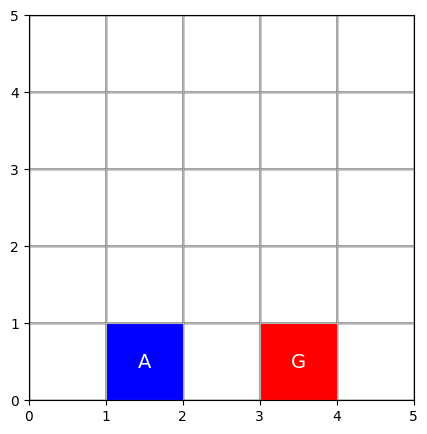

<Figure size 640x480 with 0 Axes>

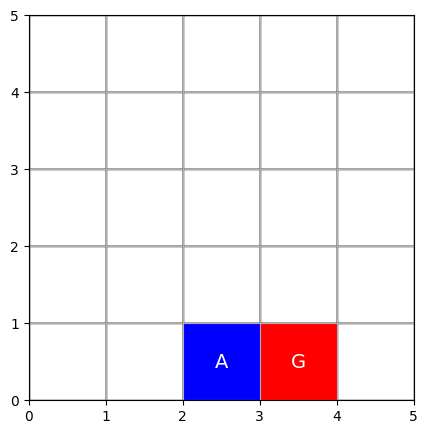

<Figure size 640x480 with 0 Axes>

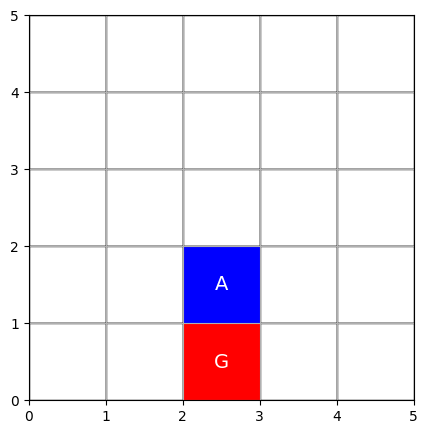

<Figure size 640x480 with 0 Axes>

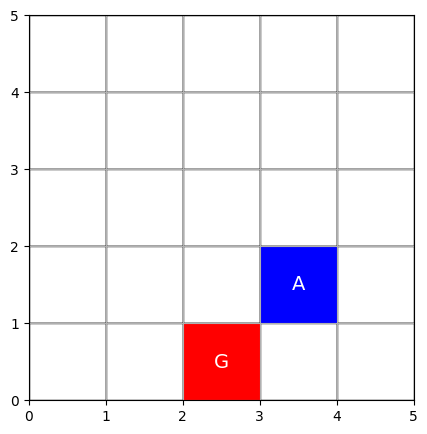

<Figure size 640x480 with 0 Axes>

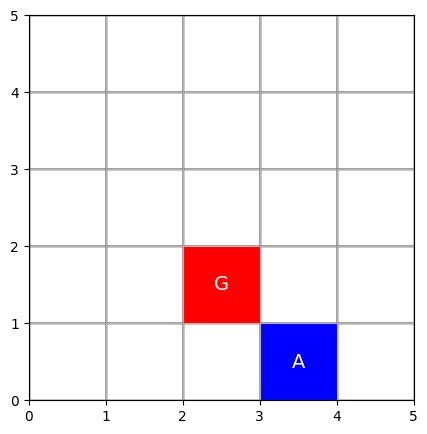

<Figure size 640x480 with 0 Axes>

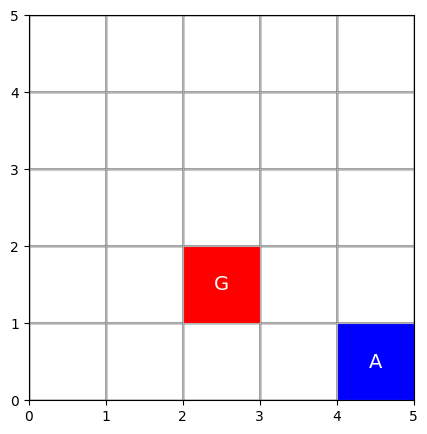

<Figure size 640x480 with 0 Axes>

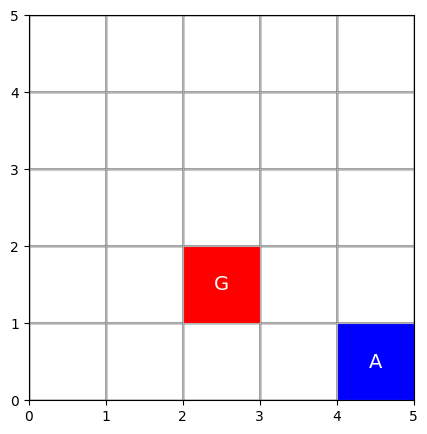

<Figure size 640x480 with 0 Axes>

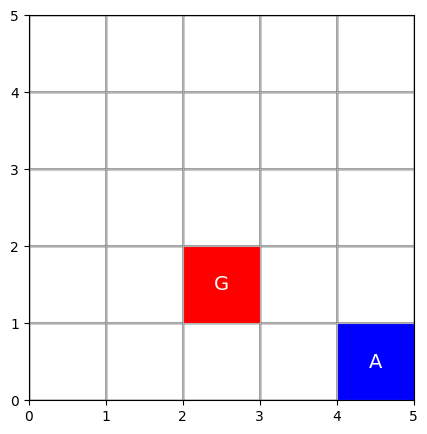

<Figure size 640x480 with 0 Axes>

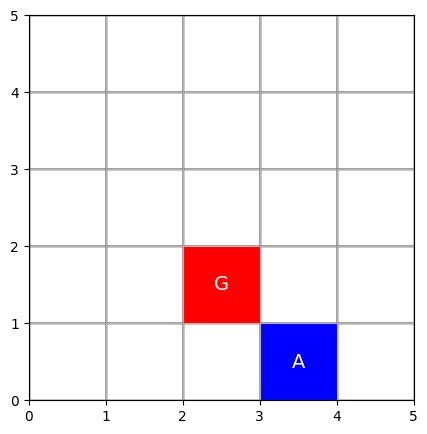

<Figure size 640x480 with 0 Axes>

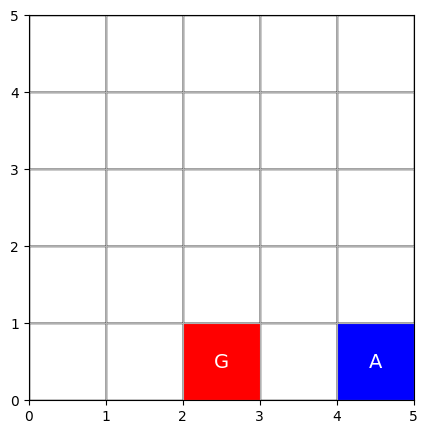

<Figure size 640x480 with 0 Axes>

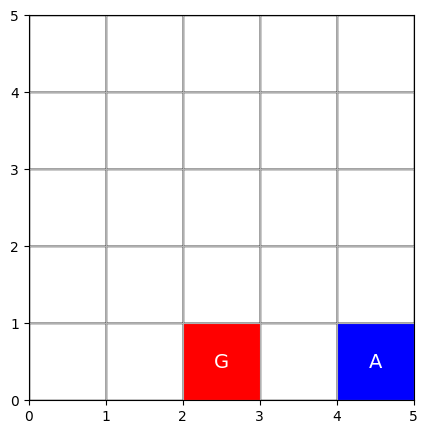

<Figure size 640x480 with 0 Axes>

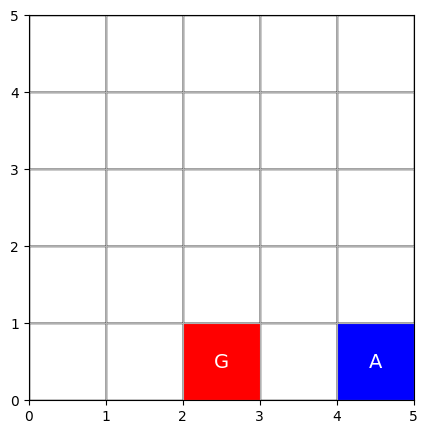

<Figure size 640x480 with 0 Axes>

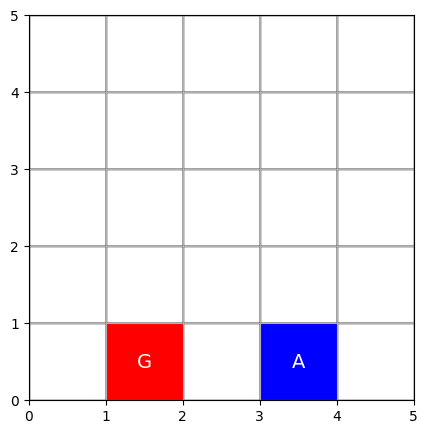

<Figure size 640x480 with 0 Axes>

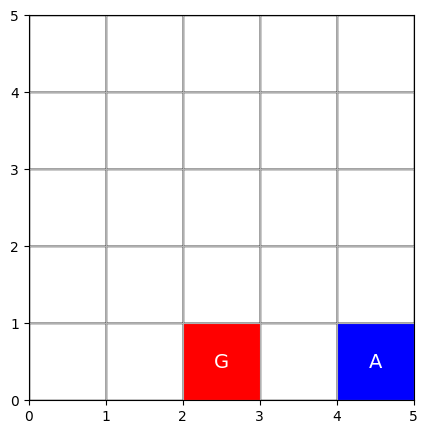

<Figure size 640x480 with 0 Axes>

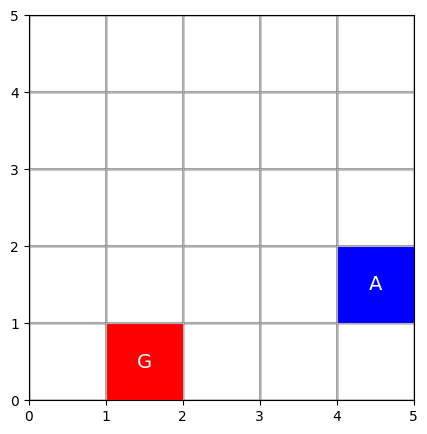

<Figure size 640x480 with 0 Axes>

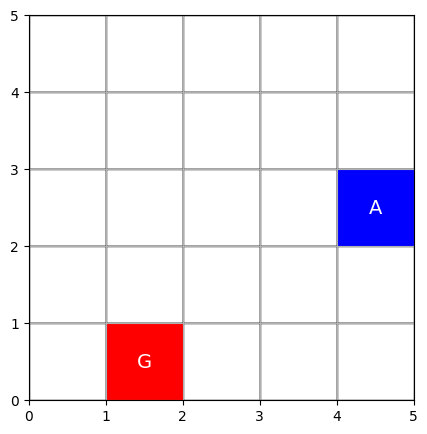

<Figure size 640x480 with 0 Axes>

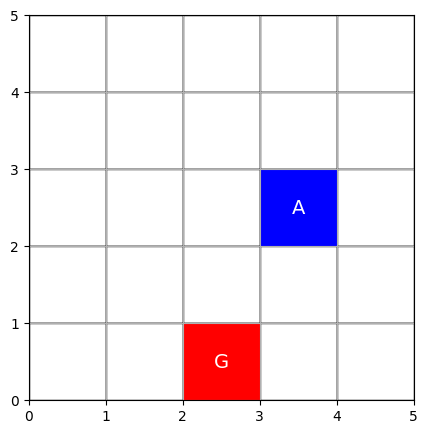

<Figure size 640x480 with 0 Axes>

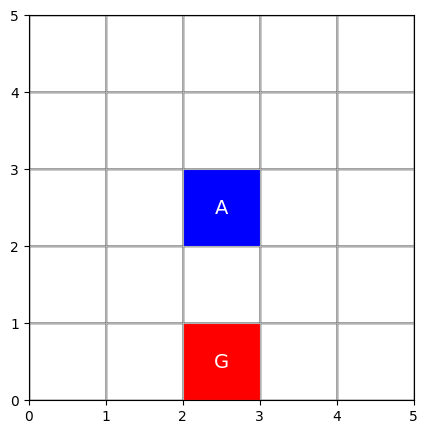

<Figure size 640x480 with 0 Axes>

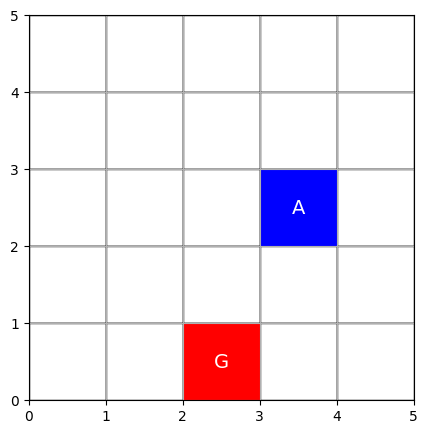

<Figure size 640x480 with 0 Axes>

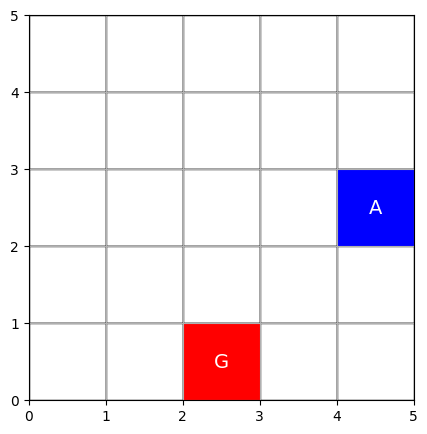

<Figure size 640x480 with 0 Axes>

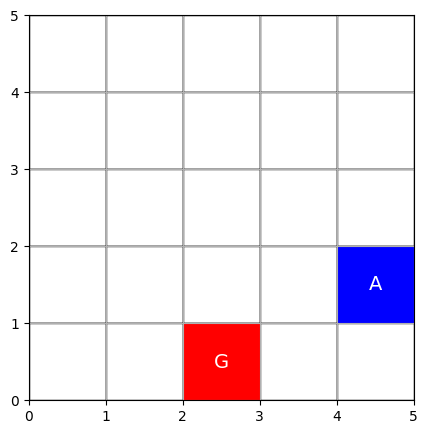

<Figure size 640x480 with 0 Axes>

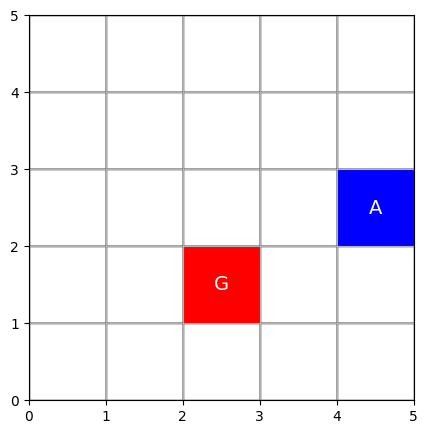

<Figure size 640x480 with 0 Axes>

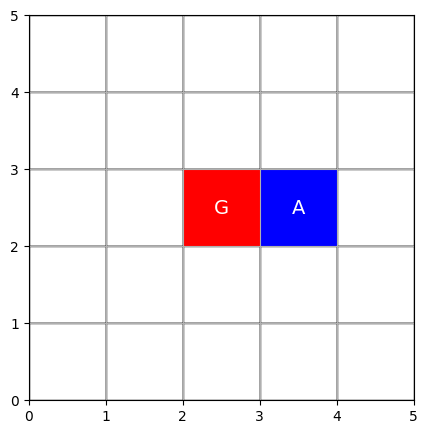

<Figure size 640x480 with 0 Axes>

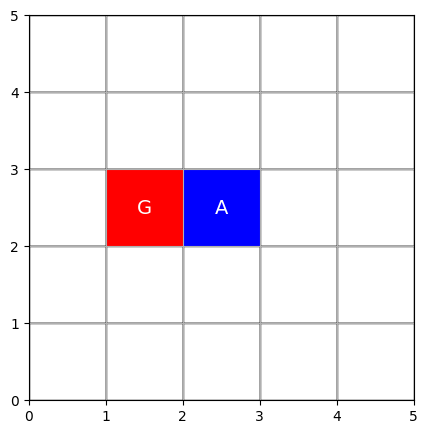

Episode 15/200 - Reward: 0.72


<Figure size 640x480 with 0 Axes>

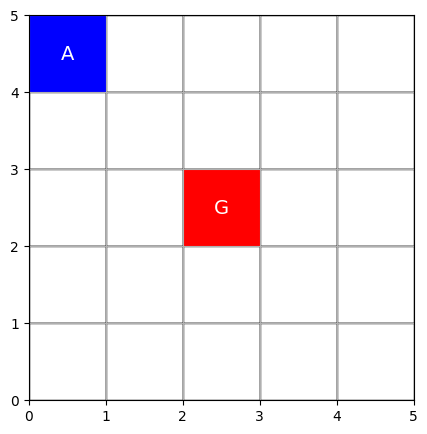

<Figure size 640x480 with 0 Axes>

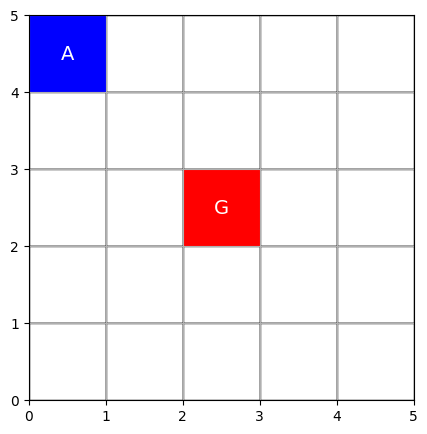

<Figure size 640x480 with 0 Axes>

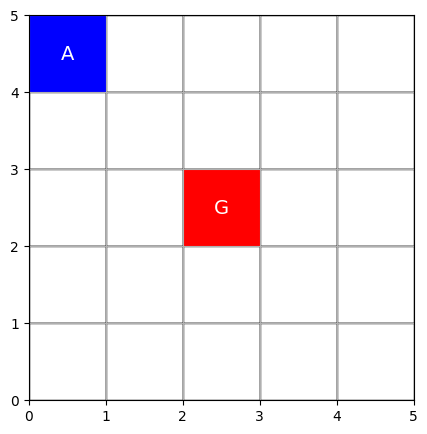

<Figure size 640x480 with 0 Axes>

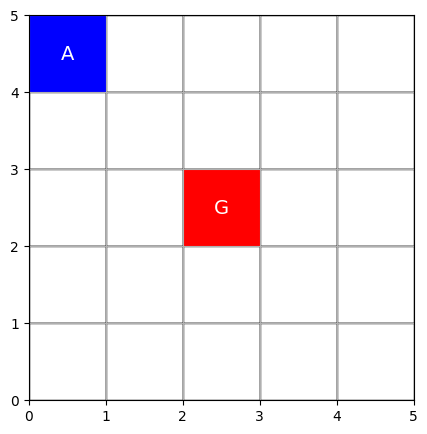

<Figure size 640x480 with 0 Axes>

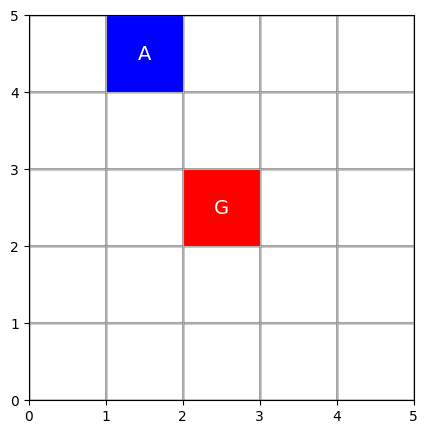

<Figure size 640x480 with 0 Axes>

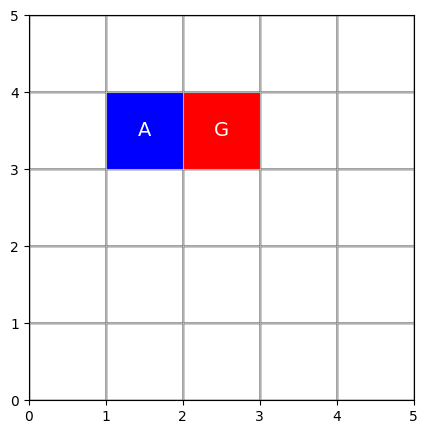

<Figure size 640x480 with 0 Axes>

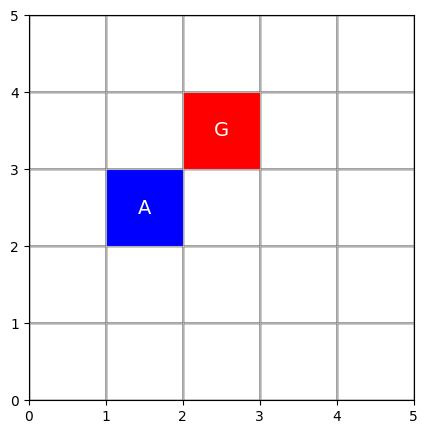

<Figure size 640x480 with 0 Axes>

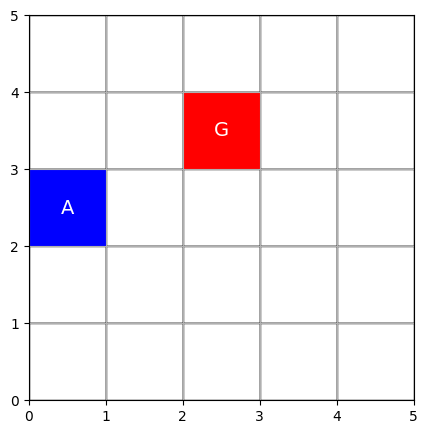

<Figure size 640x480 with 0 Axes>

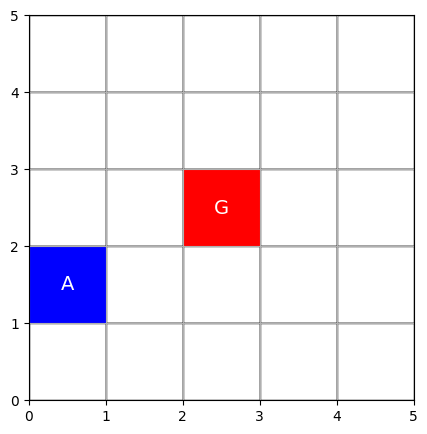

<Figure size 640x480 with 0 Axes>

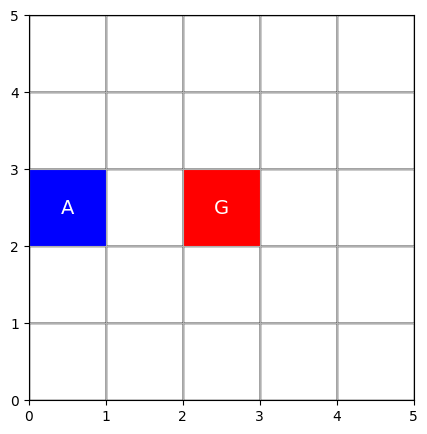

<Figure size 640x480 with 0 Axes>

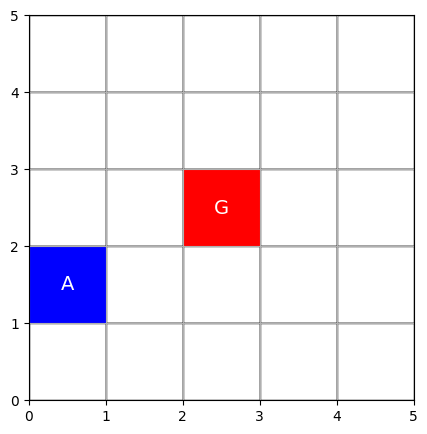

<Figure size 640x480 with 0 Axes>

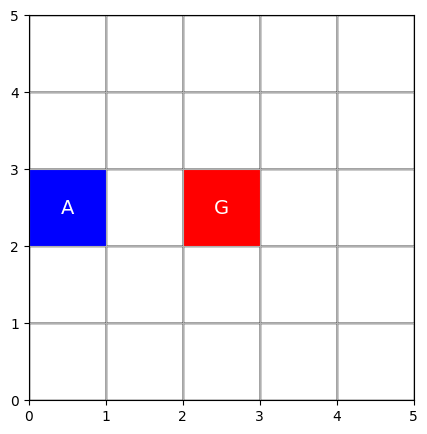

<Figure size 640x480 with 0 Axes>

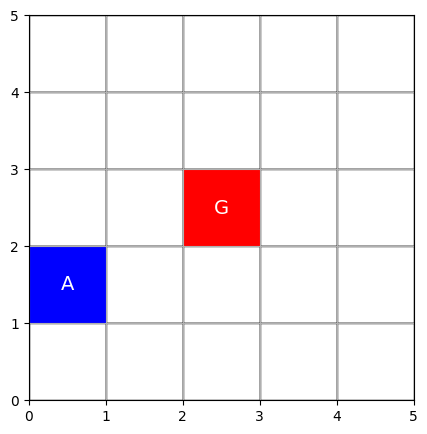

<Figure size 640x480 with 0 Axes>

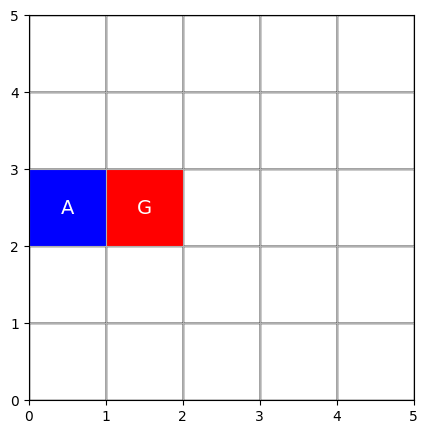

<Figure size 640x480 with 0 Axes>

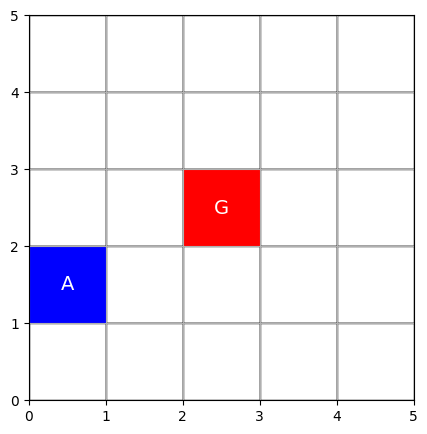

<Figure size 640x480 with 0 Axes>

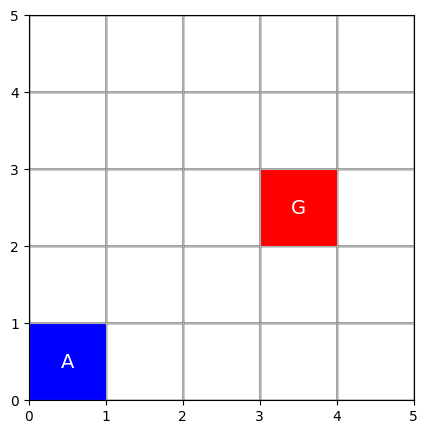

<Figure size 640x480 with 0 Axes>

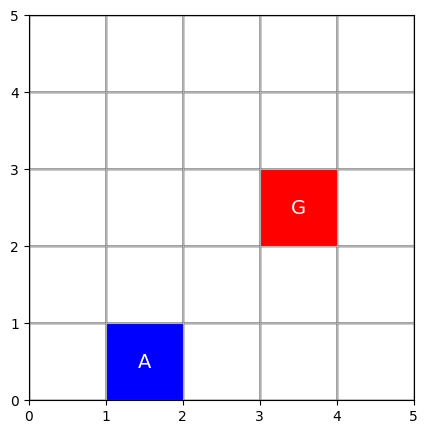

<Figure size 640x480 with 0 Axes>

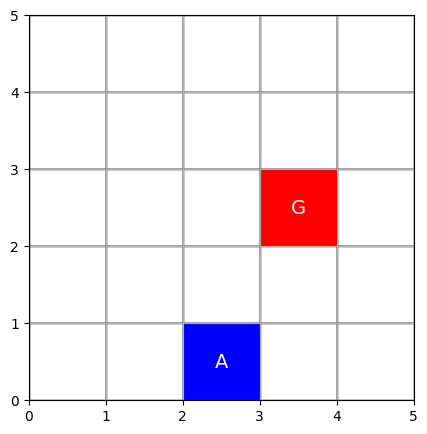

<Figure size 640x480 with 0 Axes>

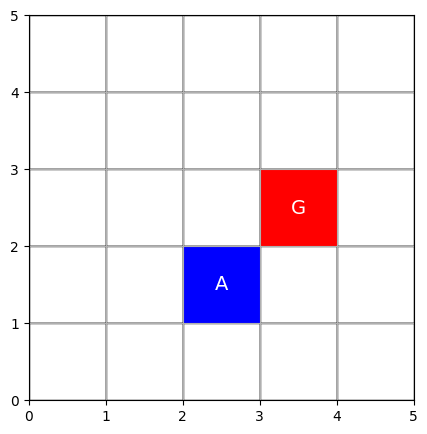

<Figure size 640x480 with 0 Axes>

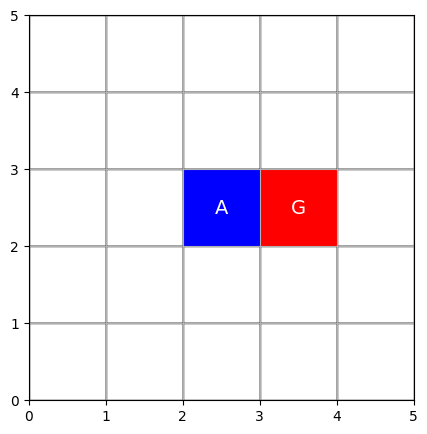

<Figure size 640x480 with 0 Axes>

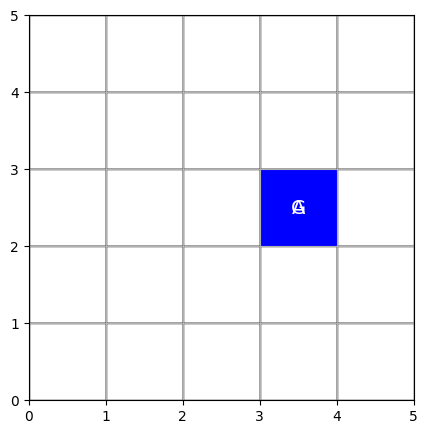

Episode 16/200 - Reward: 0.80


<Figure size 640x480 with 0 Axes>

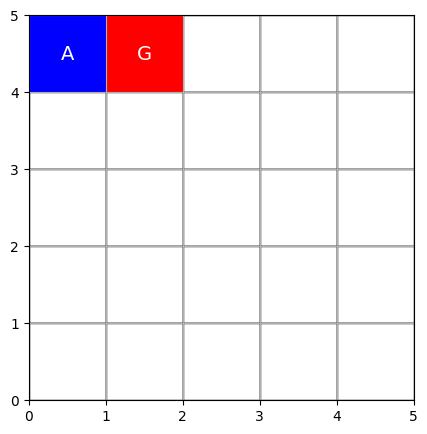

<Figure size 640x480 with 0 Axes>

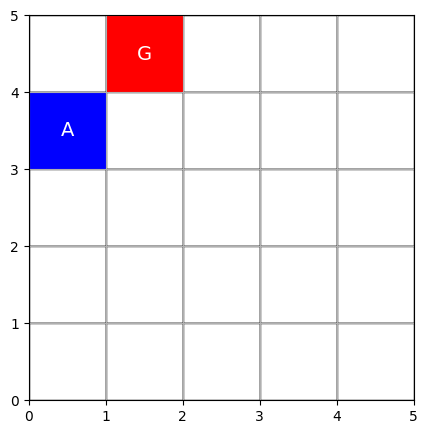

<Figure size 640x480 with 0 Axes>

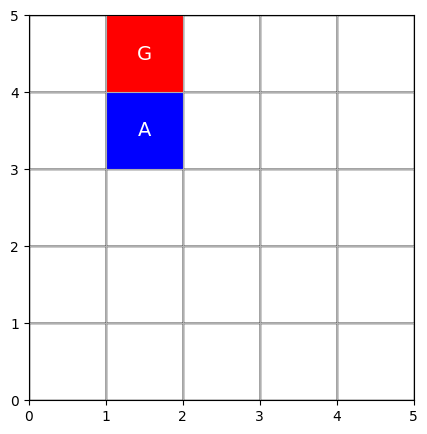

<Figure size 640x480 with 0 Axes>

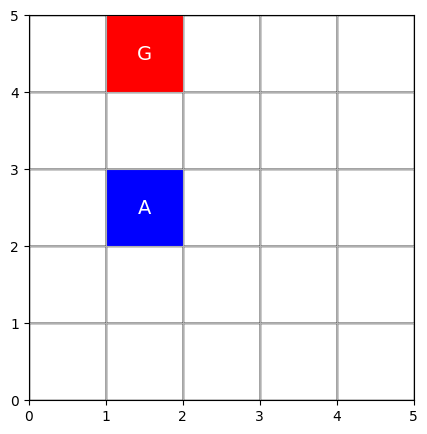

<Figure size 640x480 with 0 Axes>

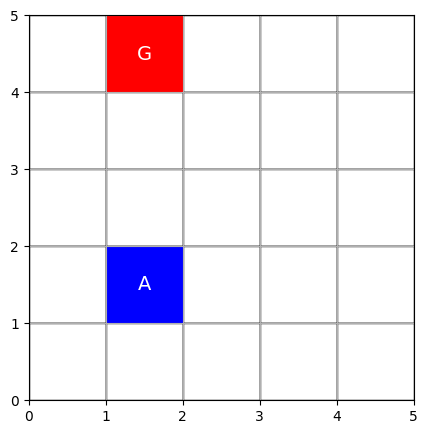

<Figure size 640x480 with 0 Axes>

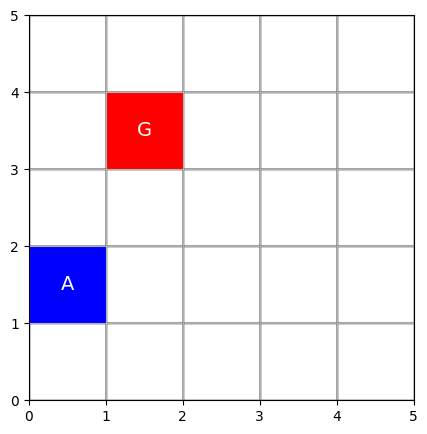

<Figure size 640x480 with 0 Axes>

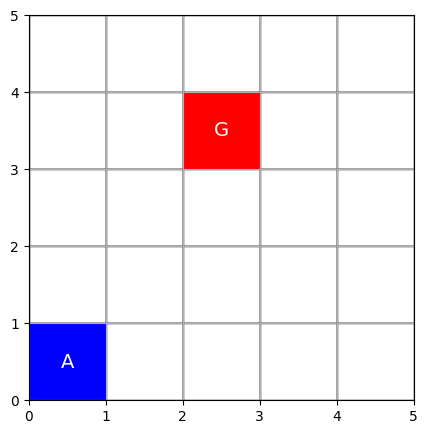

<Figure size 640x480 with 0 Axes>

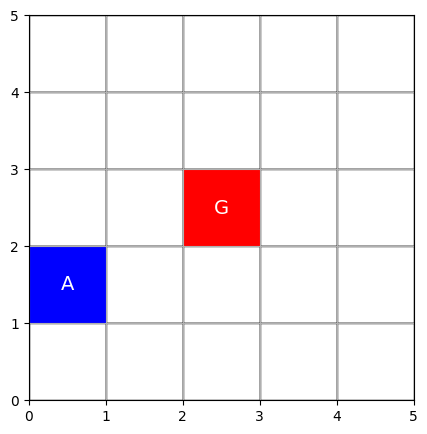

<Figure size 640x480 with 0 Axes>

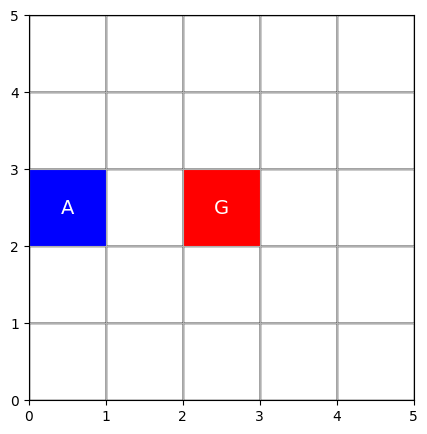

<Figure size 640x480 with 0 Axes>

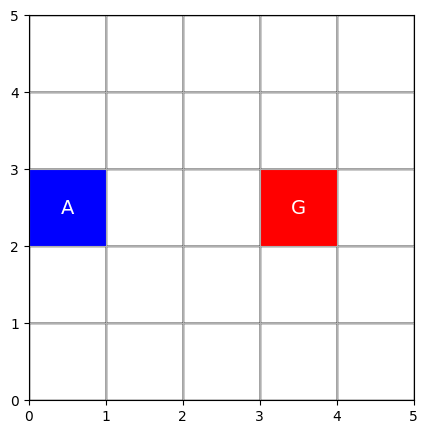

<Figure size 640x480 with 0 Axes>

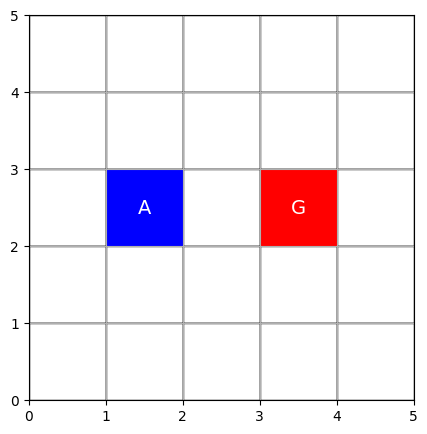

<Figure size 640x480 with 0 Axes>

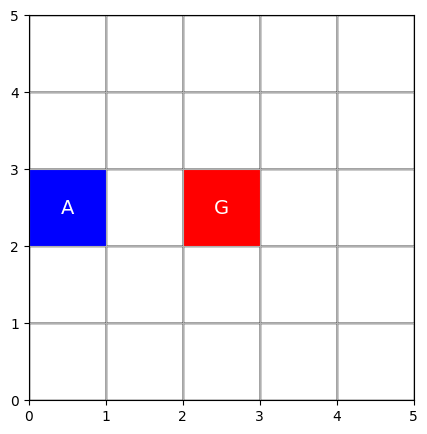

<Figure size 640x480 with 0 Axes>

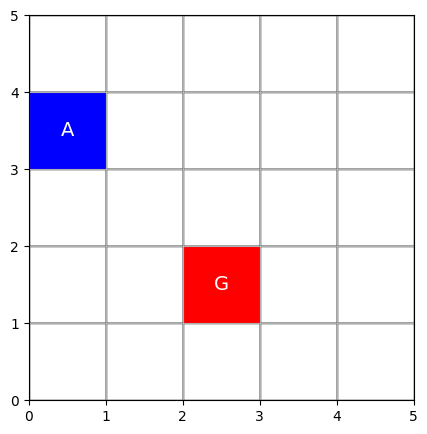

<Figure size 640x480 with 0 Axes>

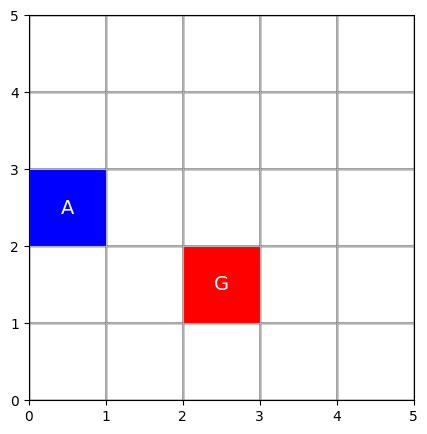

<Figure size 640x480 with 0 Axes>

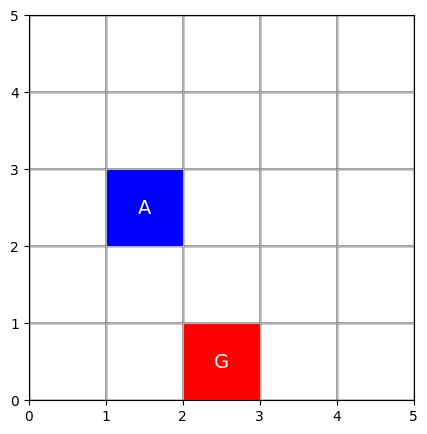

<Figure size 640x480 with 0 Axes>

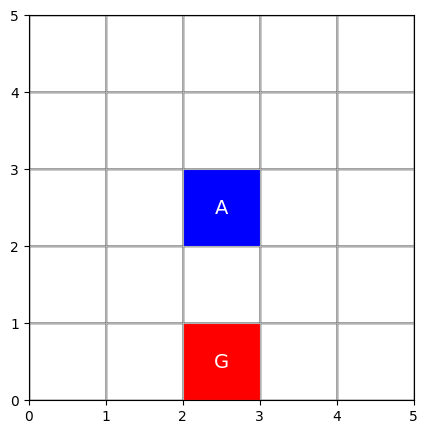

<Figure size 640x480 with 0 Axes>

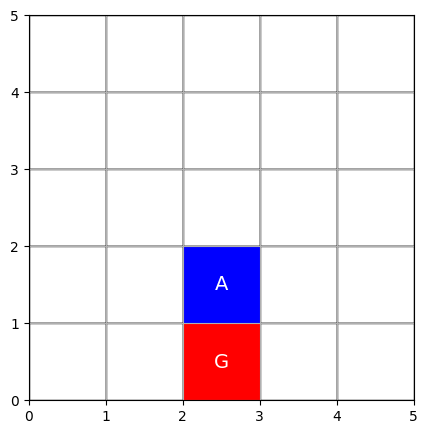

<Figure size 640x480 with 0 Axes>

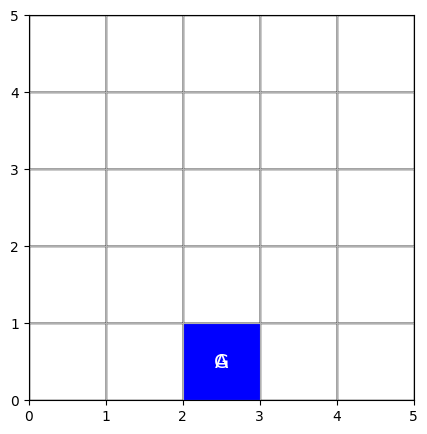

Episode 17/200 - Reward: 0.83


<Figure size 640x480 with 0 Axes>

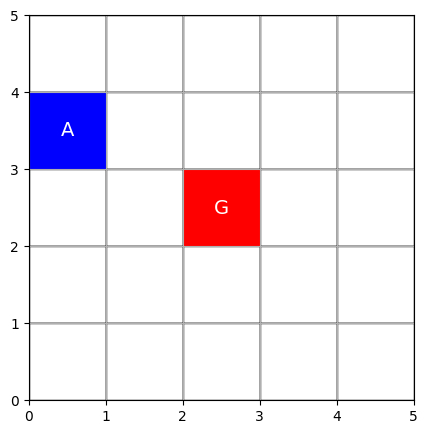

<Figure size 640x480 with 0 Axes>

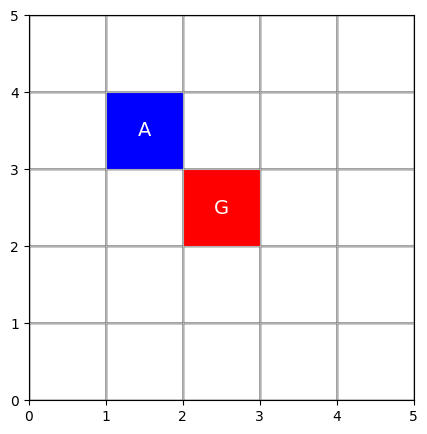

<Figure size 640x480 with 0 Axes>

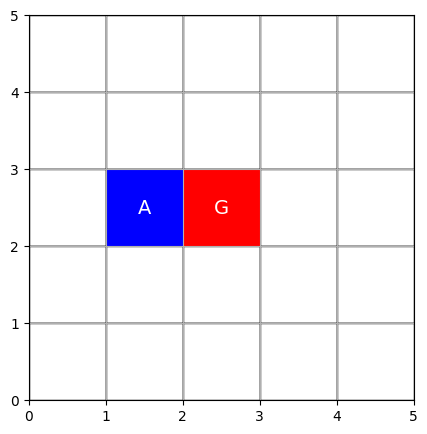

<Figure size 640x480 with 0 Axes>

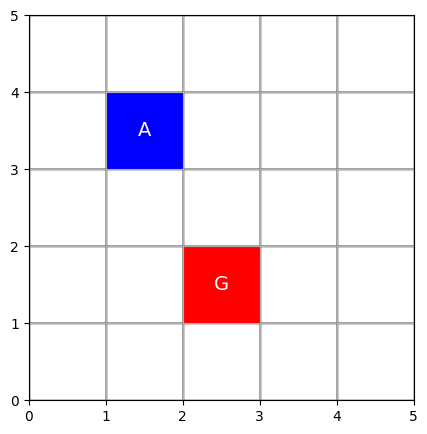

<Figure size 640x480 with 0 Axes>

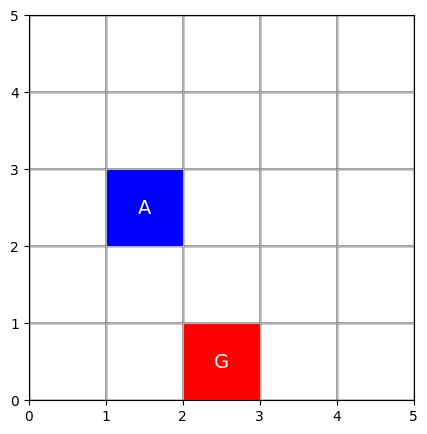

<Figure size 640x480 with 0 Axes>

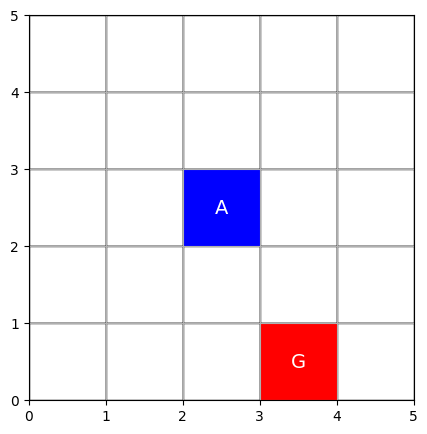

<Figure size 640x480 with 0 Axes>

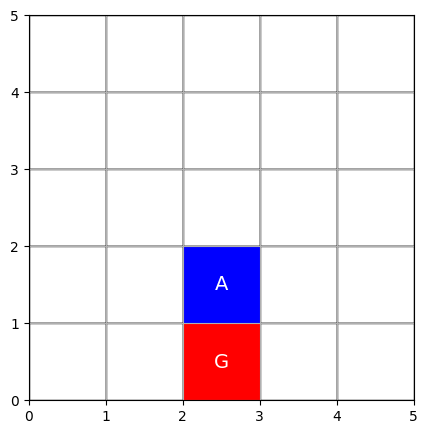

<Figure size 640x480 with 0 Axes>

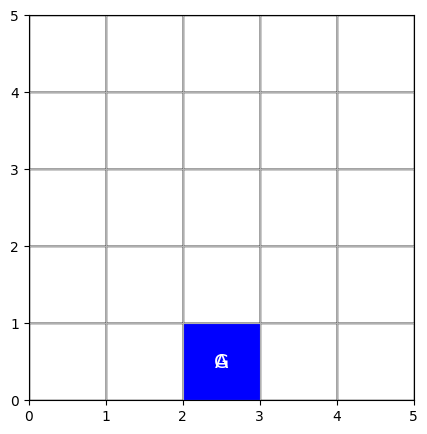

Episode 18/200 - Reward: 0.93


<Figure size 640x480 with 0 Axes>

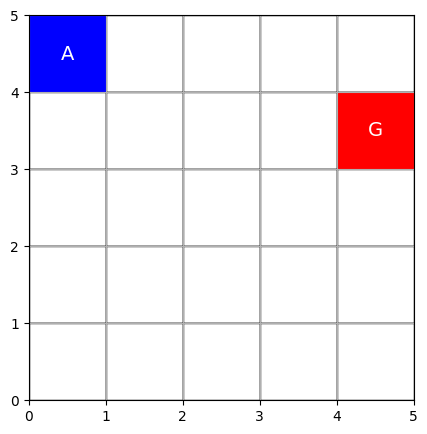

<Figure size 640x480 with 0 Axes>

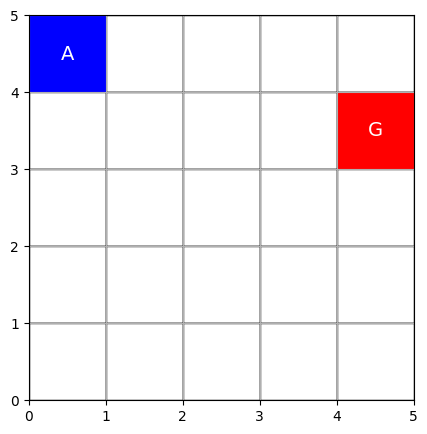

<Figure size 640x480 with 0 Axes>

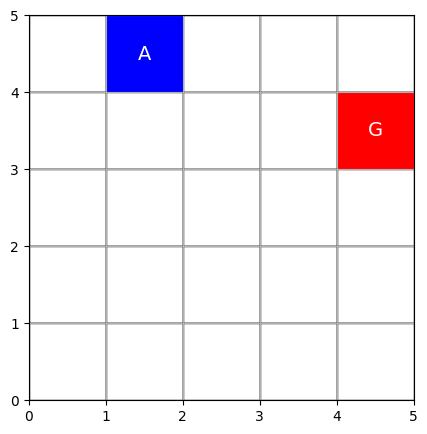

<Figure size 640x480 with 0 Axes>

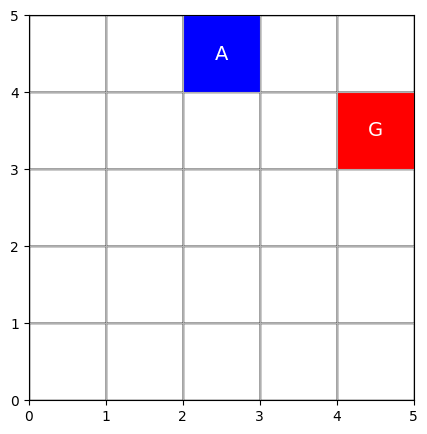

<Figure size 640x480 with 0 Axes>

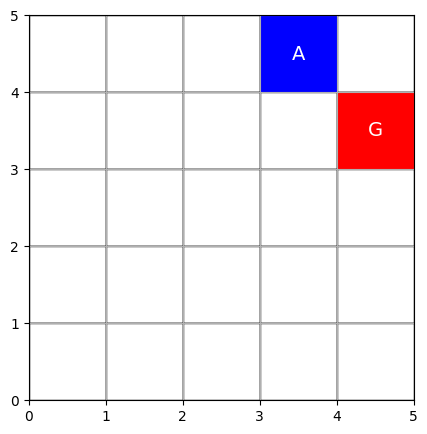

<Figure size 640x480 with 0 Axes>

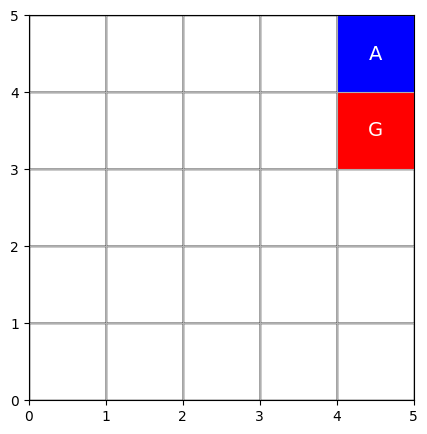

<Figure size 640x480 with 0 Axes>

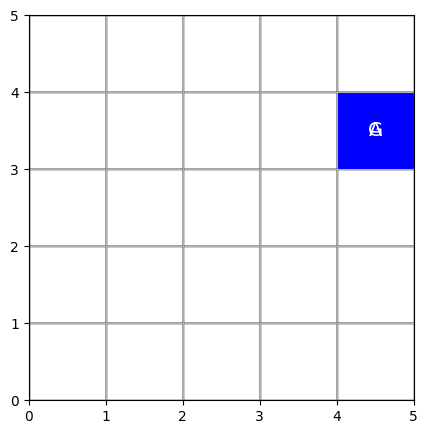

Episode 19/200 - Reward: 0.94


<Figure size 640x480 with 0 Axes>

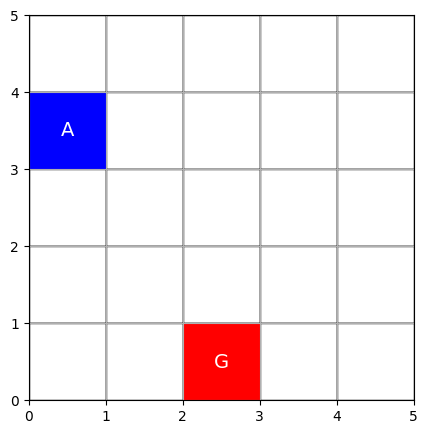

<Figure size 640x480 with 0 Axes>

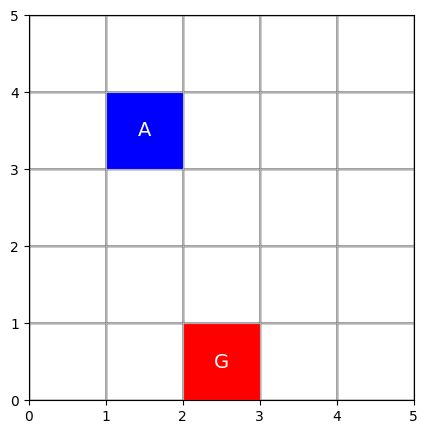

<Figure size 640x480 with 0 Axes>

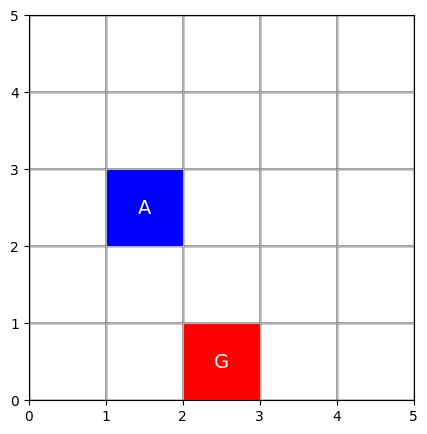

<Figure size 640x480 with 0 Axes>

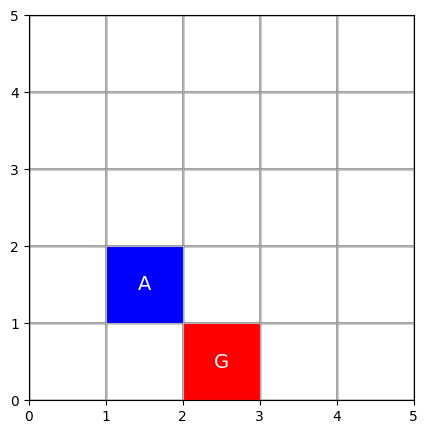

<Figure size 640x480 with 0 Axes>

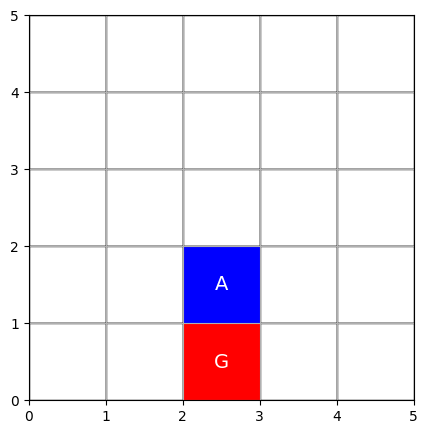

<Figure size 640x480 with 0 Axes>

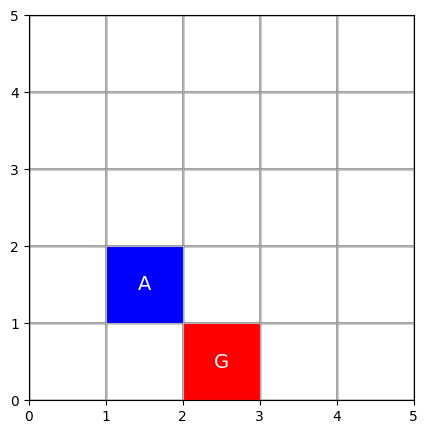

<Figure size 640x480 with 0 Axes>

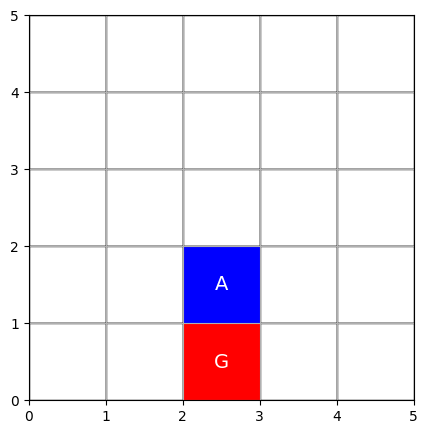

<Figure size 640x480 with 0 Axes>

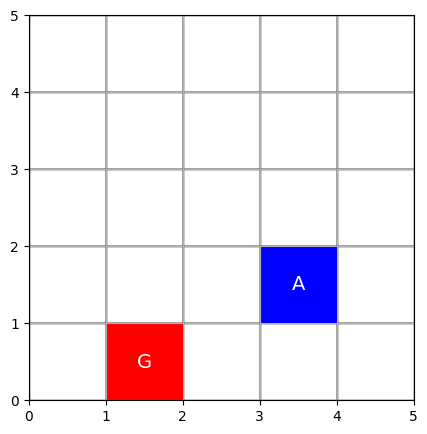

<Figure size 640x480 with 0 Axes>

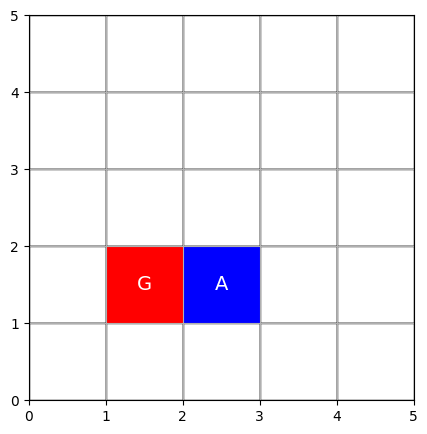

<Figure size 640x480 with 0 Axes>

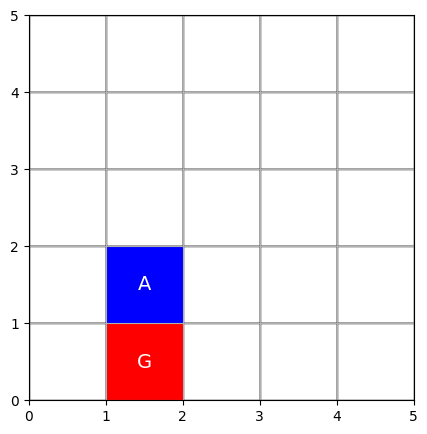

Episode 20/200 - Reward: 0.91


<Figure size 640x480 with 0 Axes>

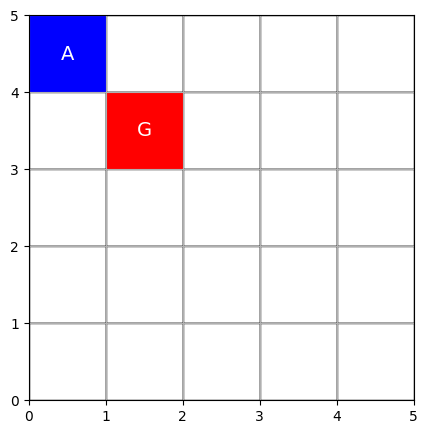

<Figure size 640x480 with 0 Axes>

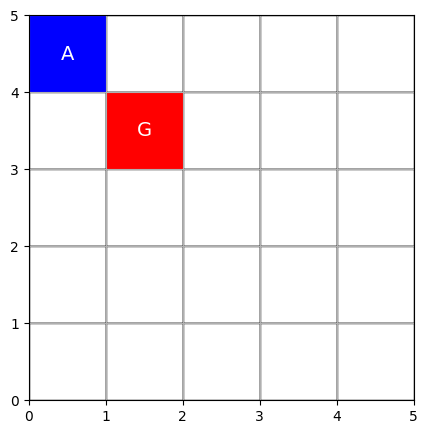

<Figure size 640x480 with 0 Axes>

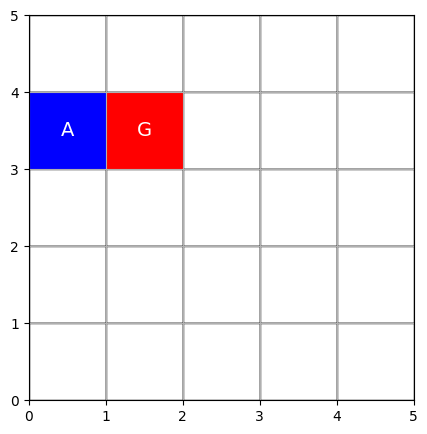

<Figure size 640x480 with 0 Axes>

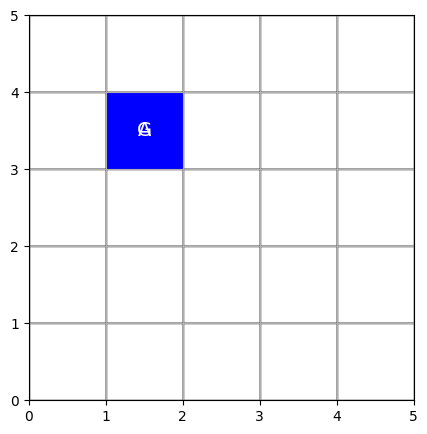

Episode 21/200 - Reward: 0.97


<Figure size 640x480 with 0 Axes>

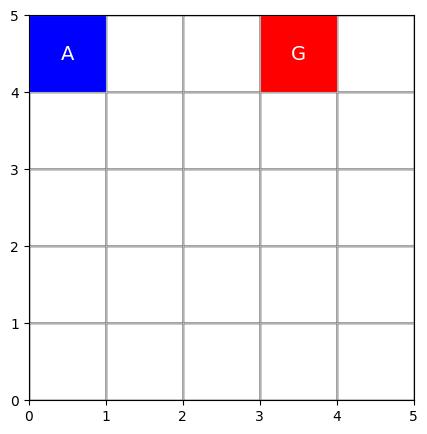

<Figure size 640x480 with 0 Axes>

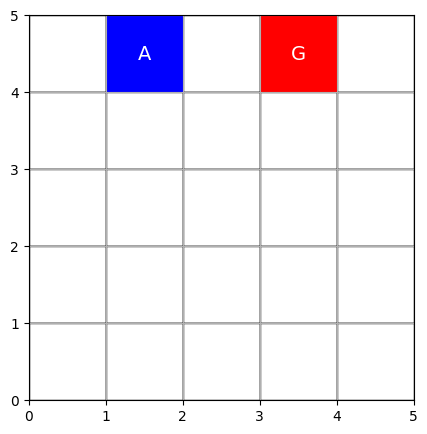

<Figure size 640x480 with 0 Axes>

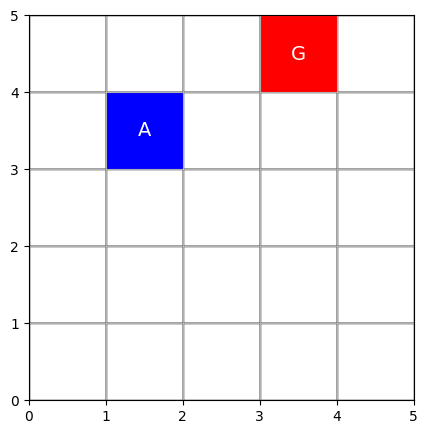

<Figure size 640x480 with 0 Axes>

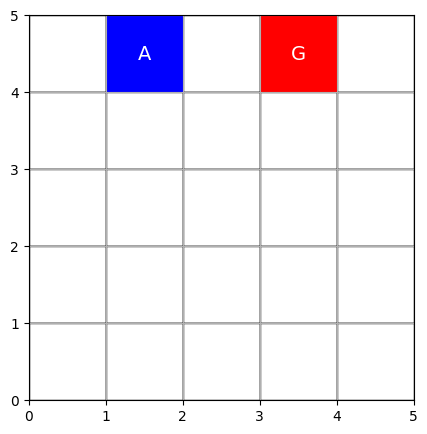

<Figure size 640x480 with 0 Axes>

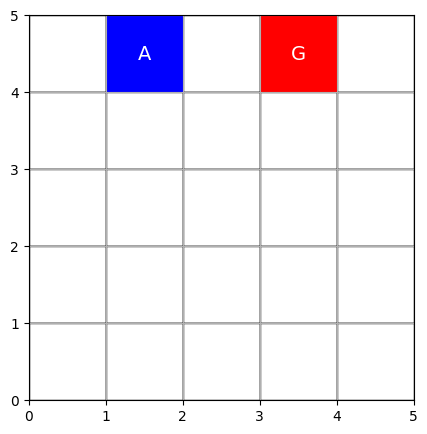

<Figure size 640x480 with 0 Axes>

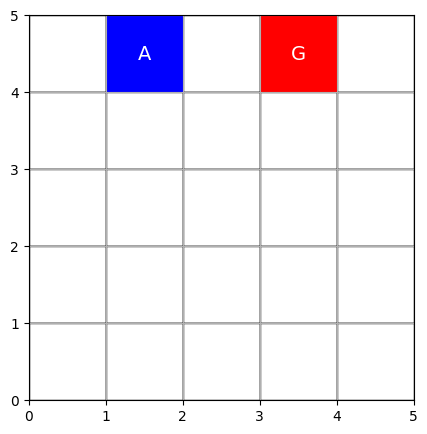

<Figure size 640x480 with 0 Axes>

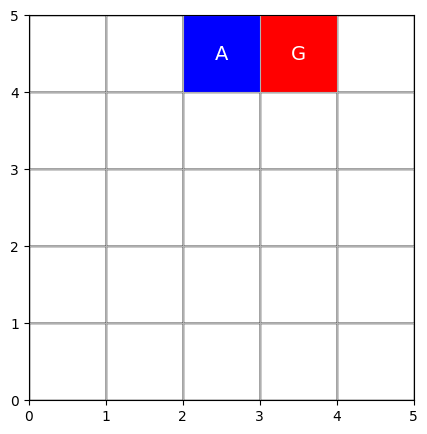

<Figure size 640x480 with 0 Axes>

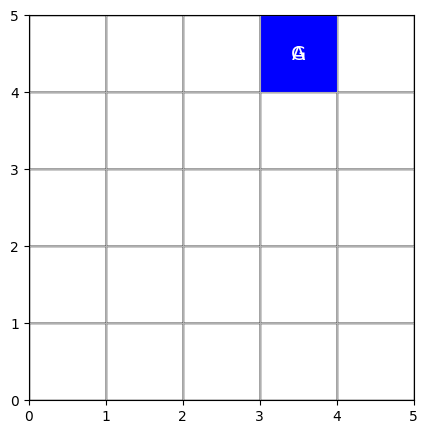

Episode 22/200 - Reward: 0.93


<Figure size 640x480 with 0 Axes>

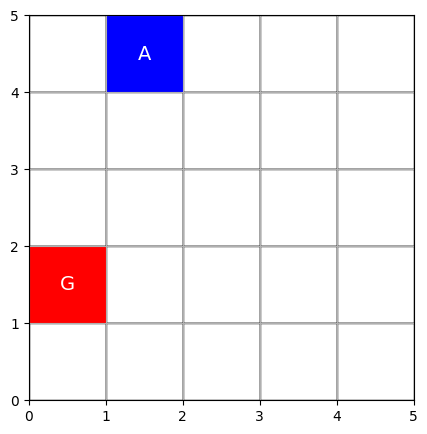

<Figure size 640x480 with 0 Axes>

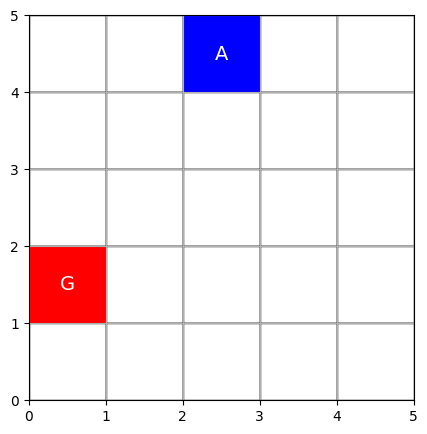

<Figure size 640x480 with 0 Axes>

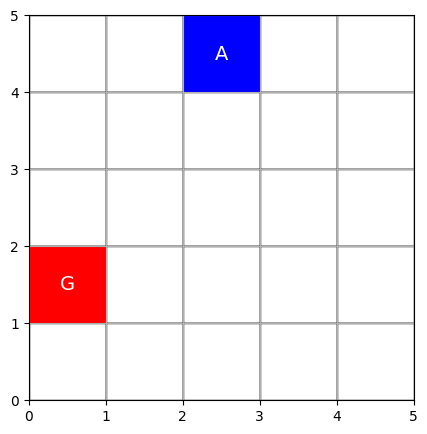

<Figure size 640x480 with 0 Axes>

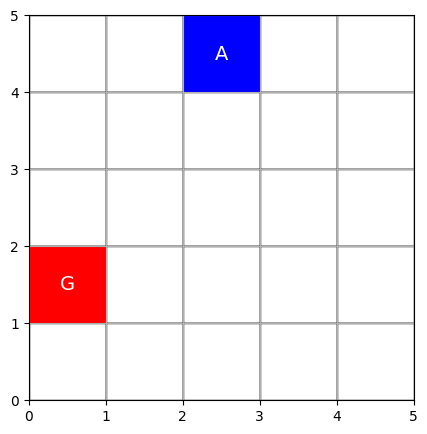

<Figure size 640x480 with 0 Axes>

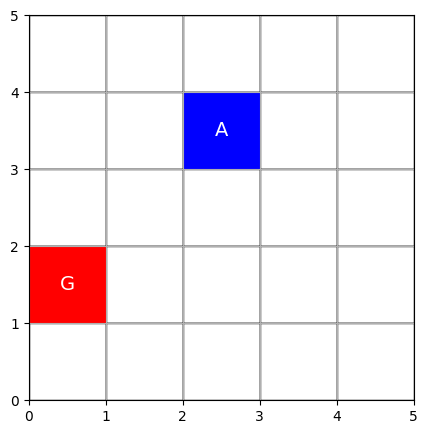

<Figure size 640x480 with 0 Axes>

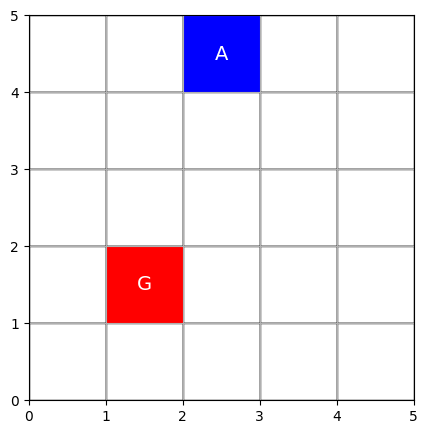

<Figure size 640x480 with 0 Axes>

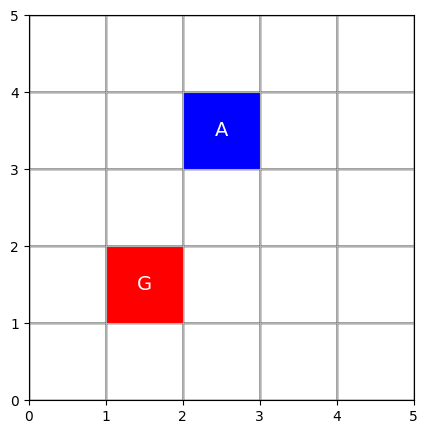

<Figure size 640x480 with 0 Axes>

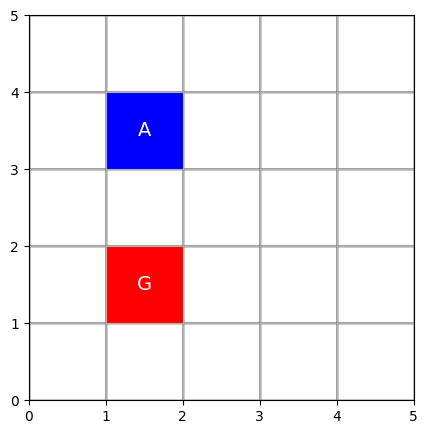

<Figure size 640x480 with 0 Axes>

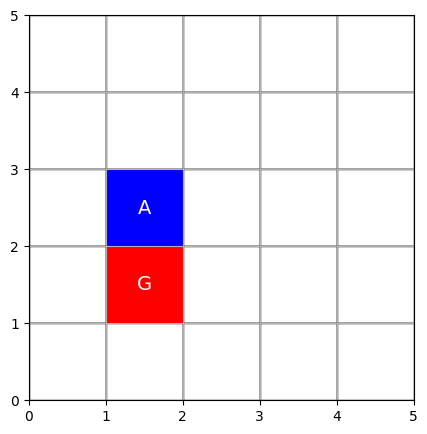

<Figure size 640x480 with 0 Axes>

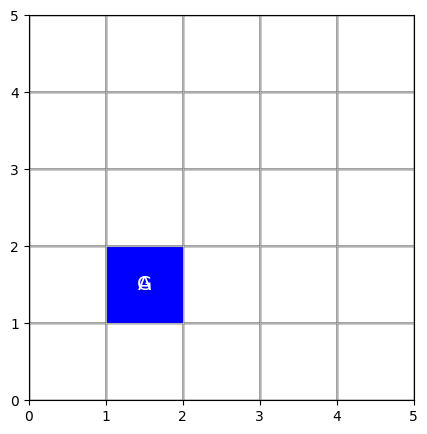

Episode 23/200 - Reward: 0.91


<Figure size 640x480 with 0 Axes>

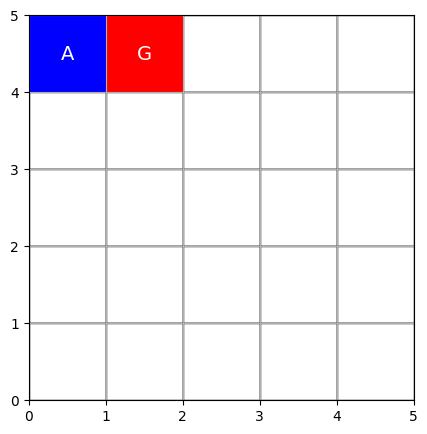

<Figure size 640x480 with 0 Axes>

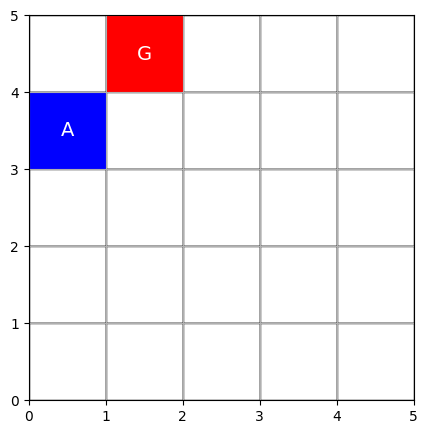

<Figure size 640x480 with 0 Axes>

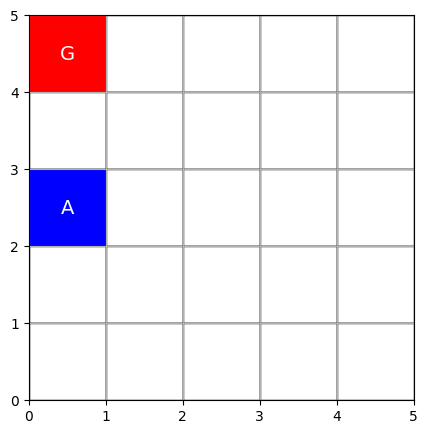

<Figure size 640x480 with 0 Axes>

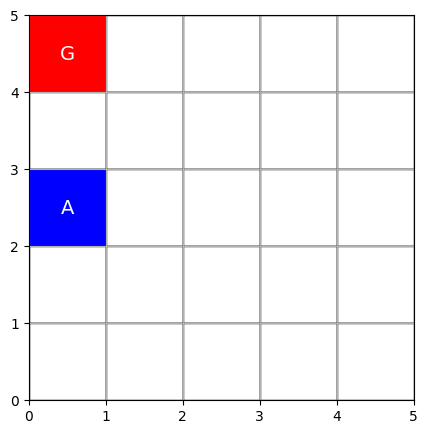

<Figure size 640x480 with 0 Axes>

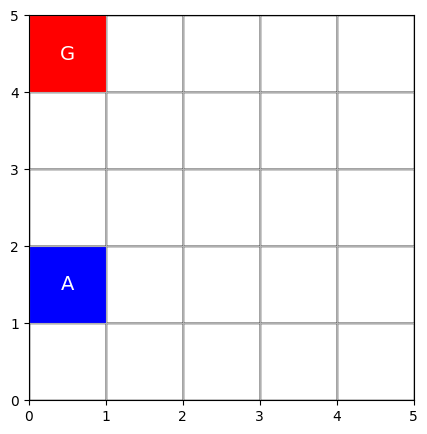

<Figure size 640x480 with 0 Axes>

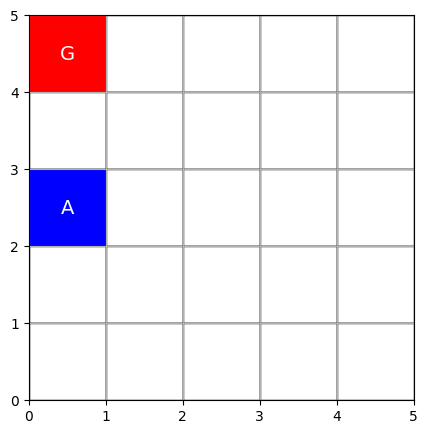

<Figure size 640x480 with 0 Axes>

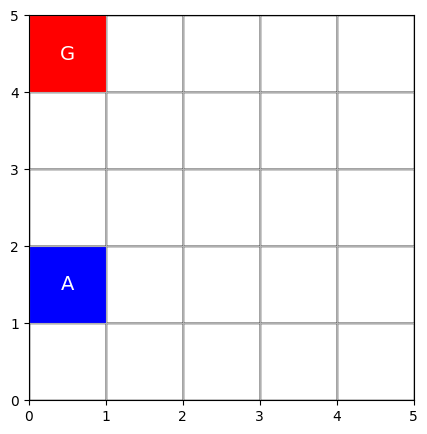

<Figure size 640x480 with 0 Axes>

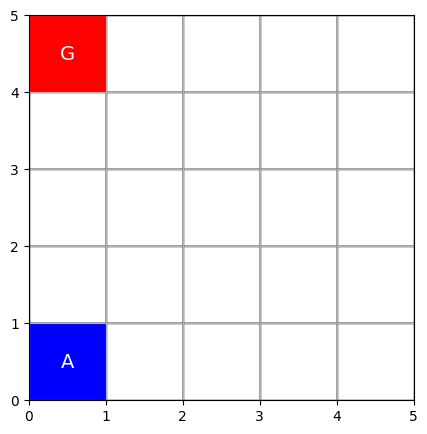

<Figure size 640x480 with 0 Axes>

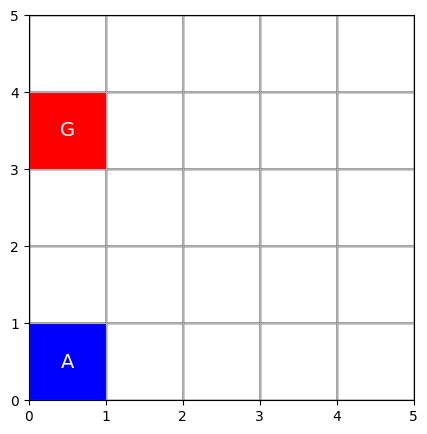

<Figure size 640x480 with 0 Axes>

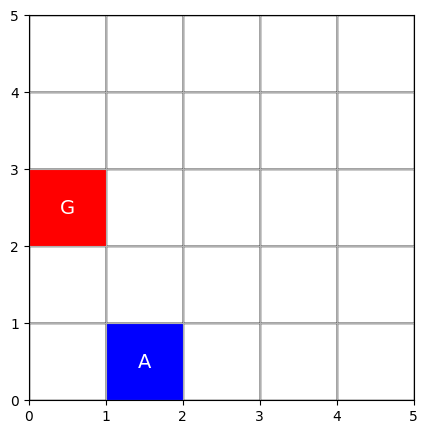

<Figure size 640x480 with 0 Axes>

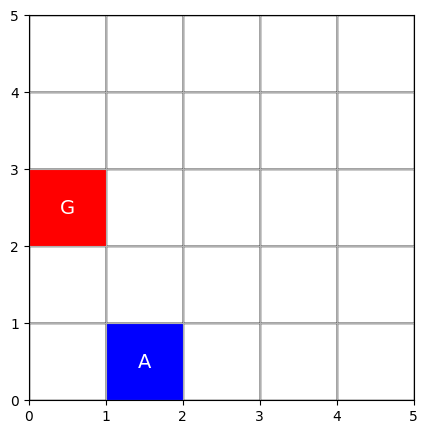

<Figure size 640x480 with 0 Axes>

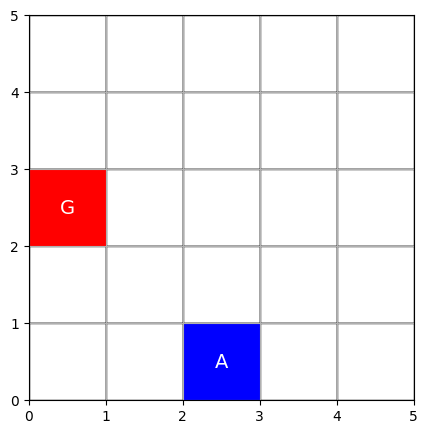

<Figure size 640x480 with 0 Axes>

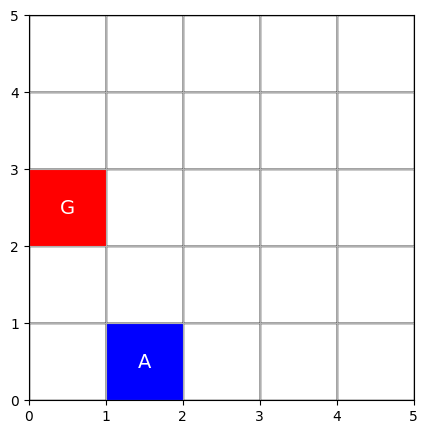

<Figure size 640x480 with 0 Axes>

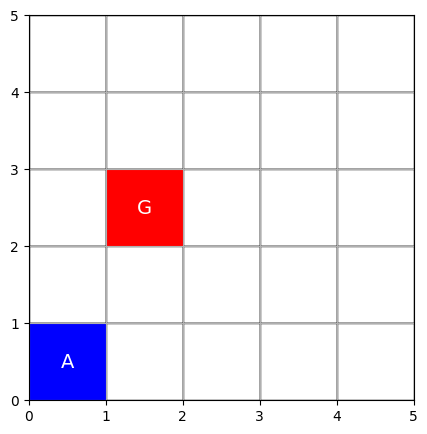

<Figure size 640x480 with 0 Axes>

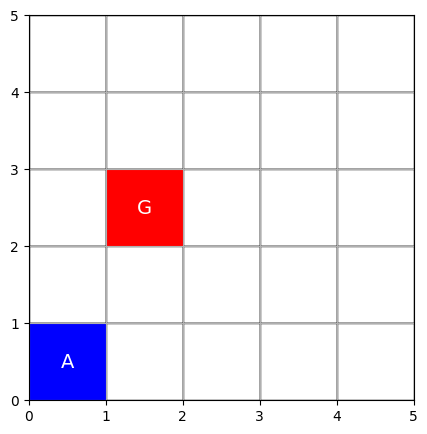

<Figure size 640x480 with 0 Axes>

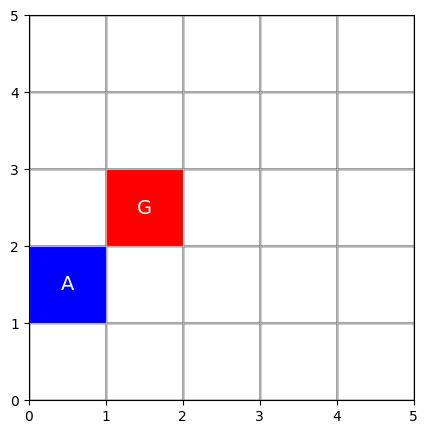

<Figure size 640x480 with 0 Axes>

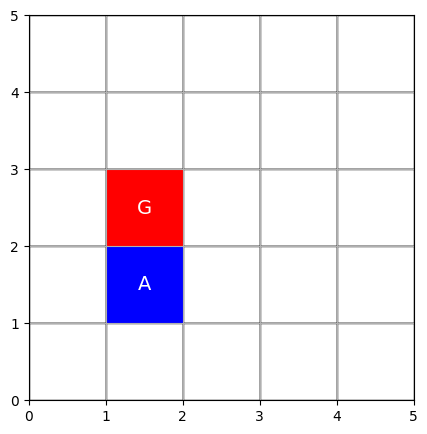

<Figure size 640x480 with 0 Axes>

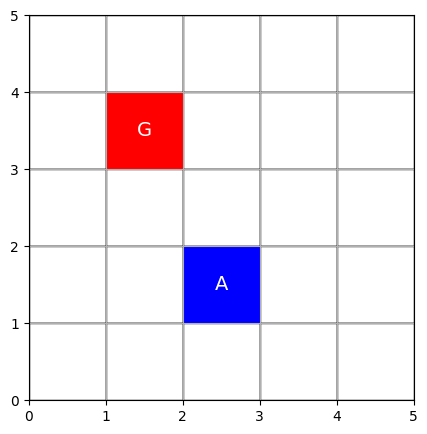

<Figure size 640x480 with 0 Axes>

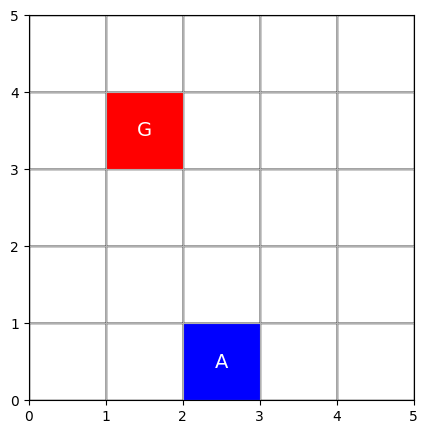

<Figure size 640x480 with 0 Axes>

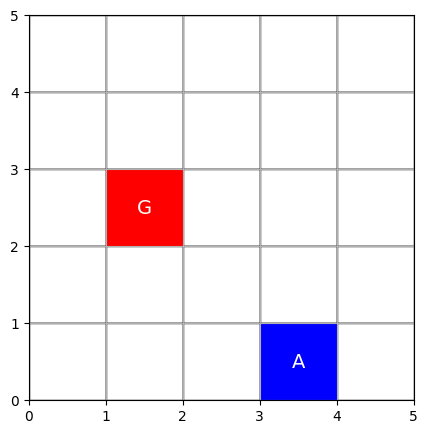

<Figure size 640x480 with 0 Axes>

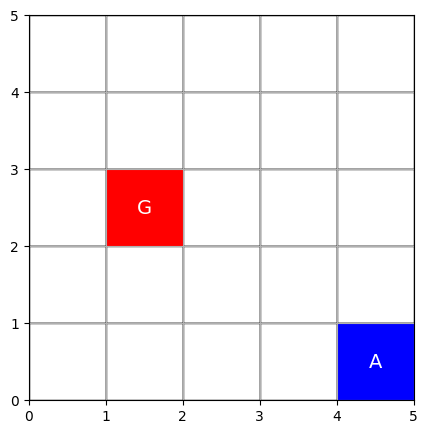

<Figure size 640x480 with 0 Axes>

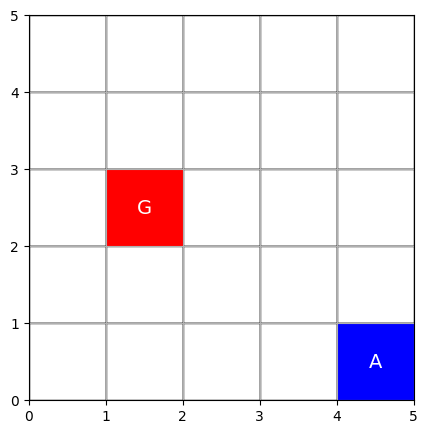

<Figure size 640x480 with 0 Axes>

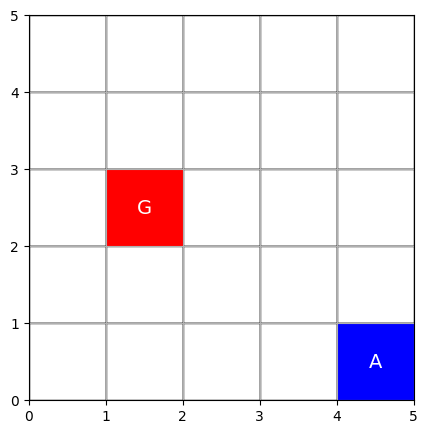

<Figure size 640x480 with 0 Axes>

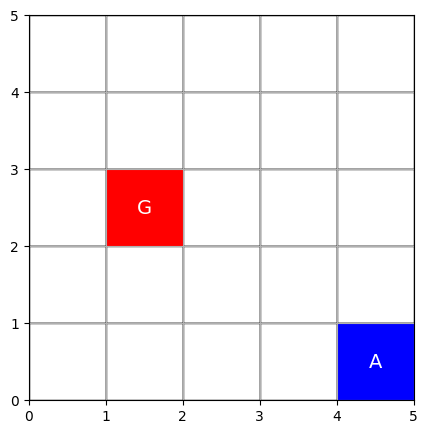

<Figure size 640x480 with 0 Axes>

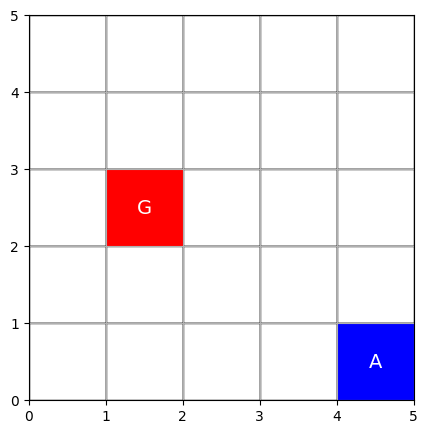

<Figure size 640x480 with 0 Axes>

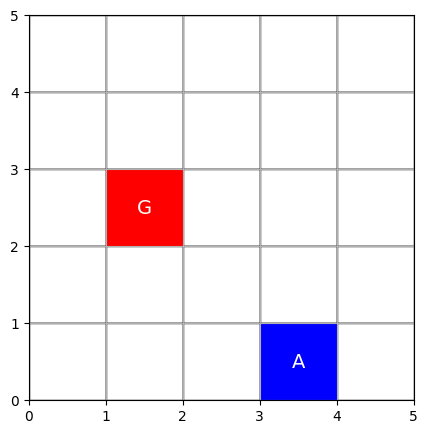

<Figure size 640x480 with 0 Axes>

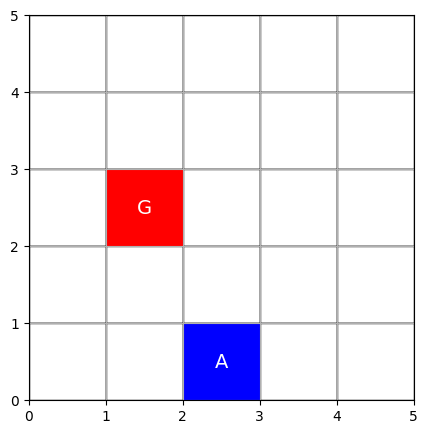

<Figure size 640x480 with 0 Axes>

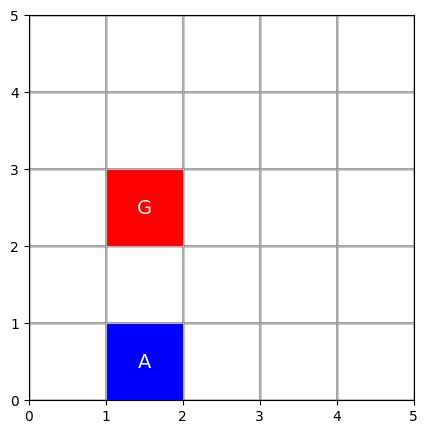

<Figure size 640x480 with 0 Axes>

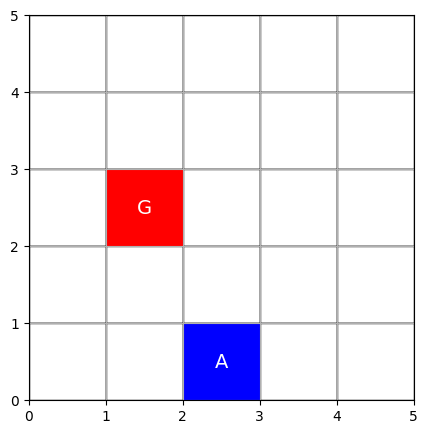

<Figure size 640x480 with 0 Axes>

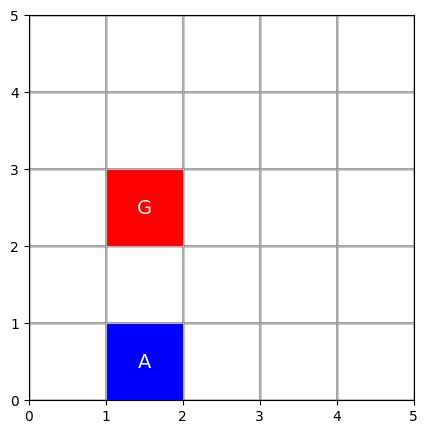

<Figure size 640x480 with 0 Axes>

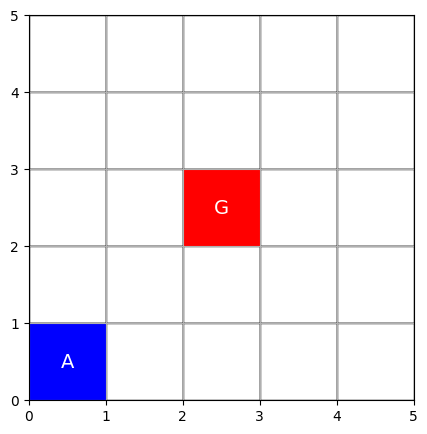

<Figure size 640x480 with 0 Axes>

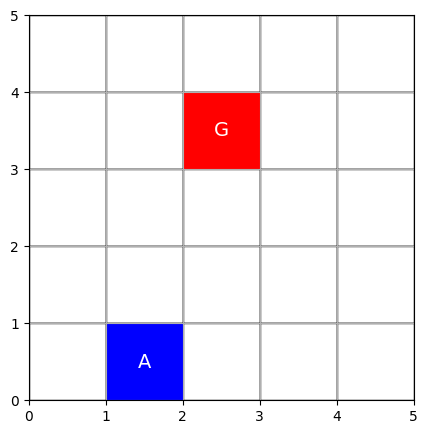

<Figure size 640x480 with 0 Axes>

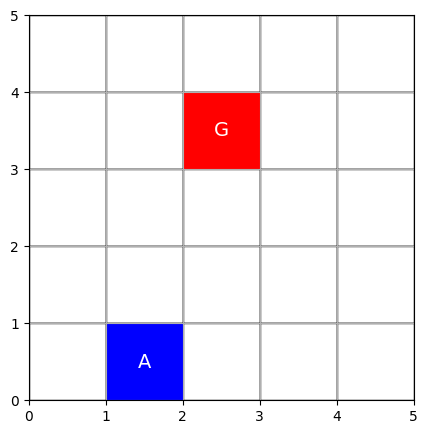

<Figure size 640x480 with 0 Axes>

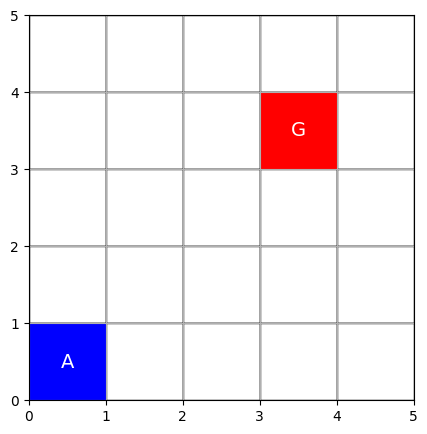

<Figure size 640x480 with 0 Axes>

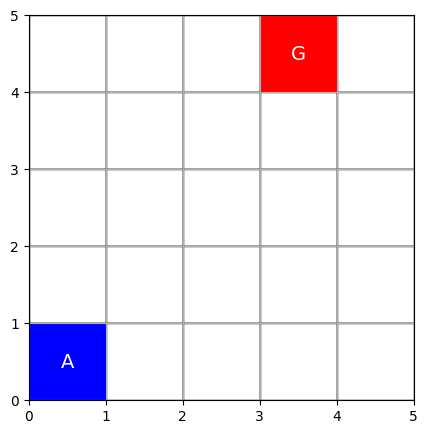

<Figure size 640x480 with 0 Axes>

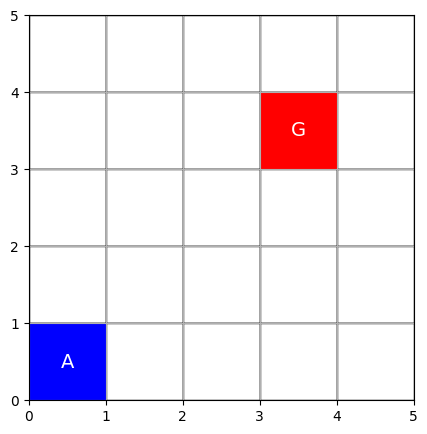

<Figure size 640x480 with 0 Axes>

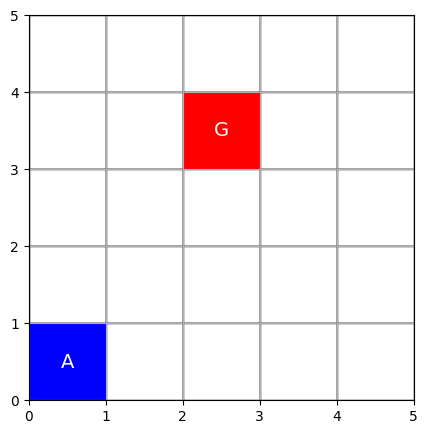

<Figure size 640x480 with 0 Axes>

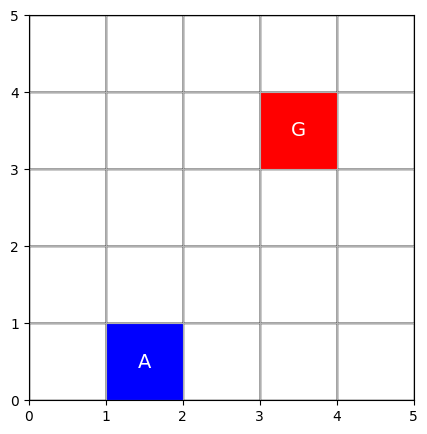

<Figure size 640x480 with 0 Axes>

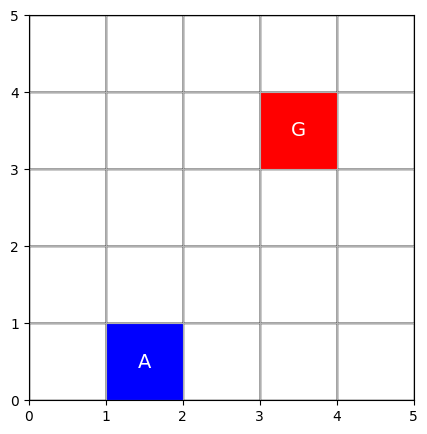

<Figure size 640x480 with 0 Axes>

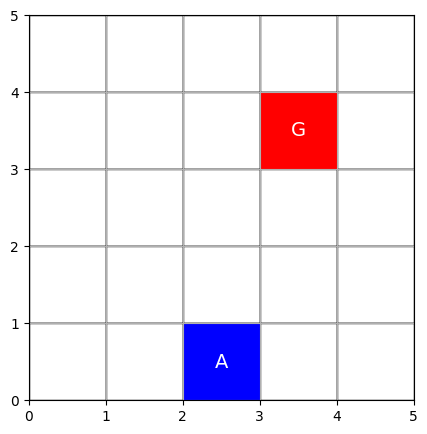

<Figure size 640x480 with 0 Axes>

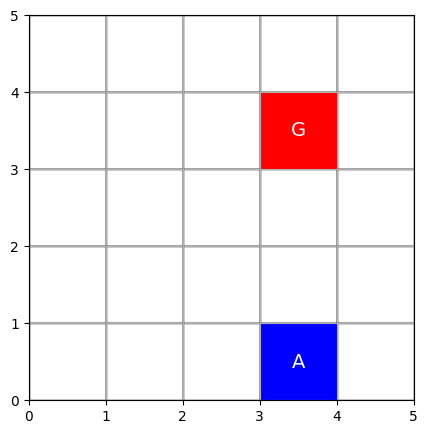

<Figure size 640x480 with 0 Axes>

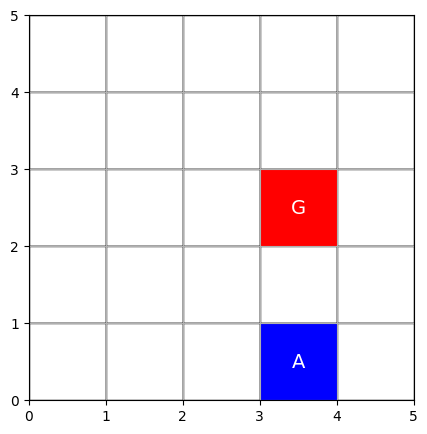

<Figure size 640x480 with 0 Axes>

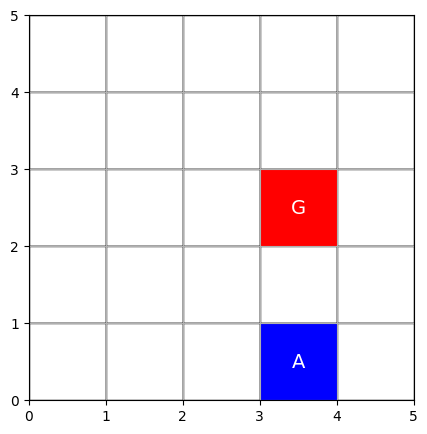

<Figure size 640x480 with 0 Axes>

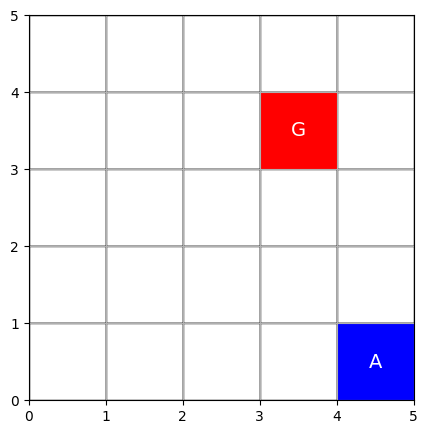

<Figure size 640x480 with 0 Axes>

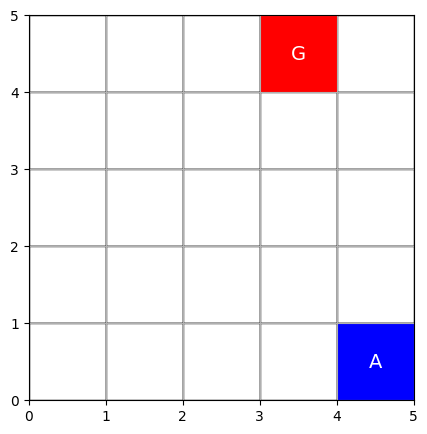

<Figure size 640x480 with 0 Axes>

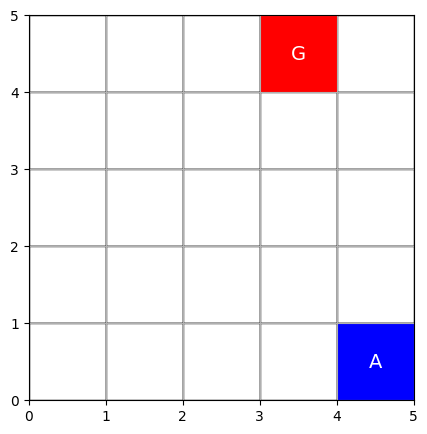

<Figure size 640x480 with 0 Axes>

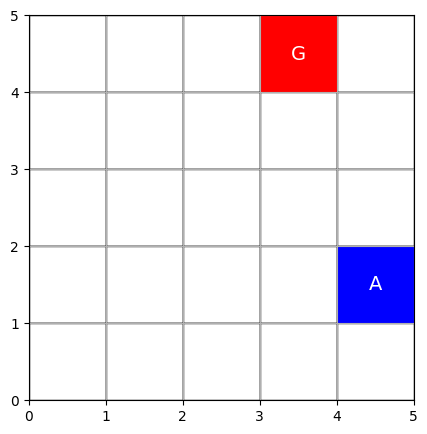

<Figure size 640x480 with 0 Axes>

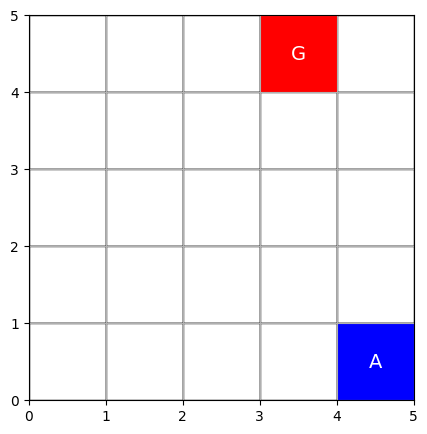

<Figure size 640x480 with 0 Axes>

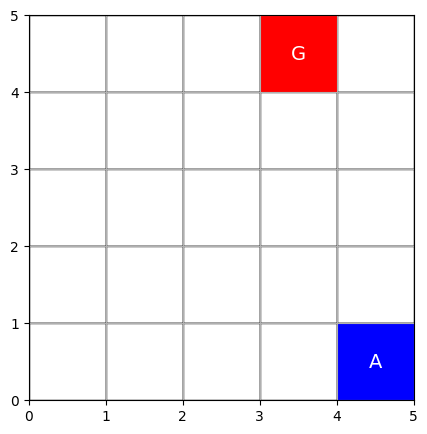

<Figure size 640x480 with 0 Axes>

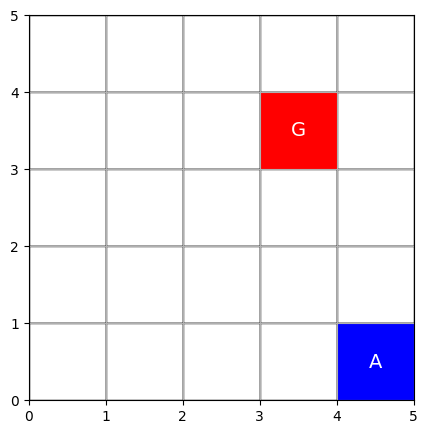

Episode 24/200 - Reward: -0.50


<Figure size 640x480 with 0 Axes>

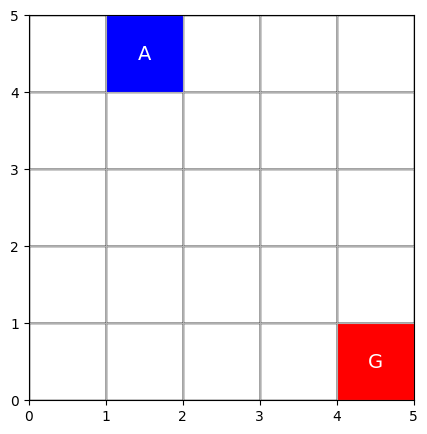

<Figure size 640x480 with 0 Axes>

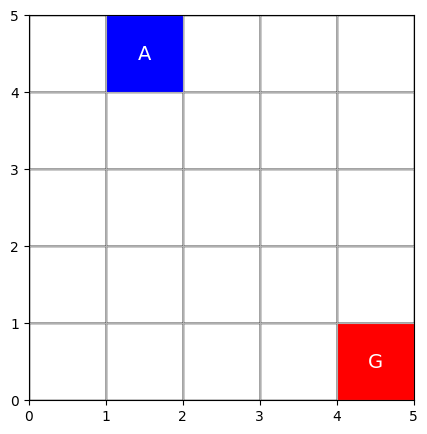

<Figure size 640x480 with 0 Axes>

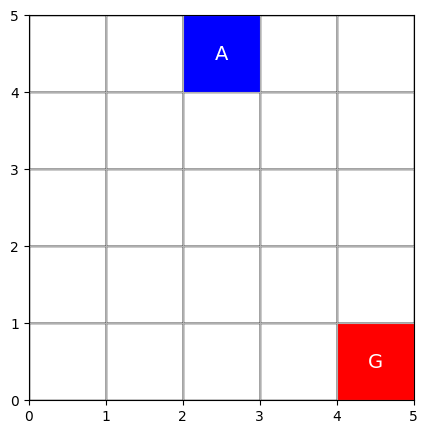

<Figure size 640x480 with 0 Axes>

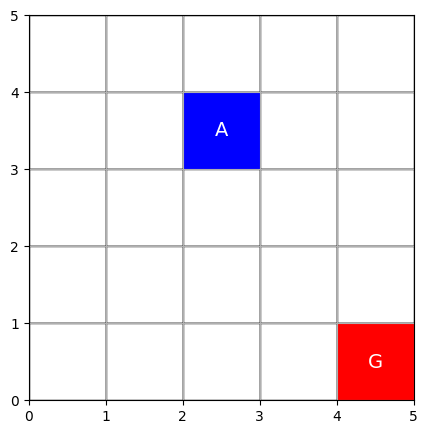

<Figure size 640x480 with 0 Axes>

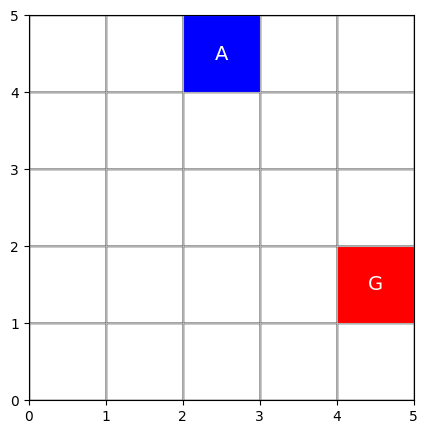

<Figure size 640x480 with 0 Axes>

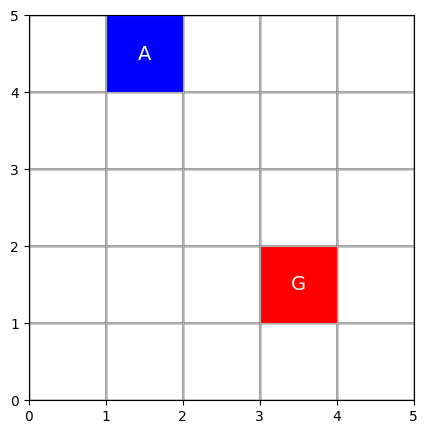

<Figure size 640x480 with 0 Axes>

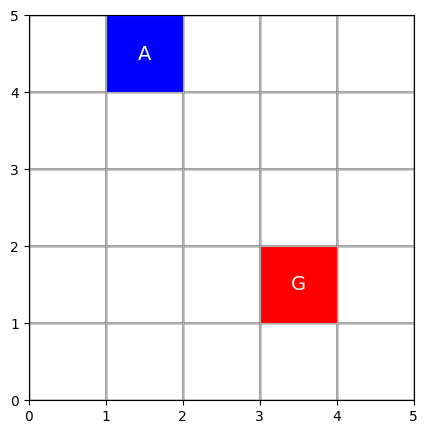

<Figure size 640x480 with 0 Axes>

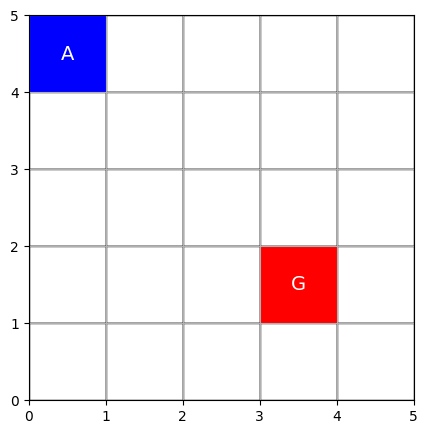

<Figure size 640x480 with 0 Axes>

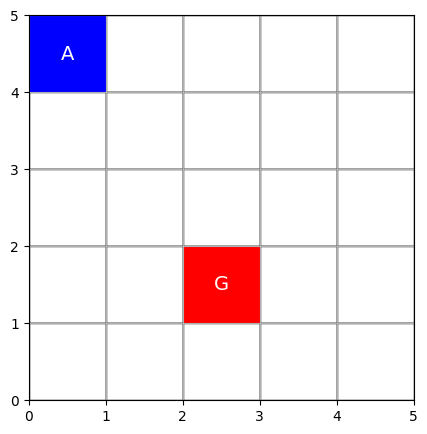

<Figure size 640x480 with 0 Axes>

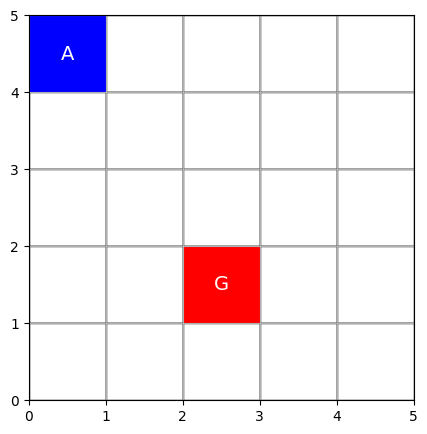

<Figure size 640x480 with 0 Axes>

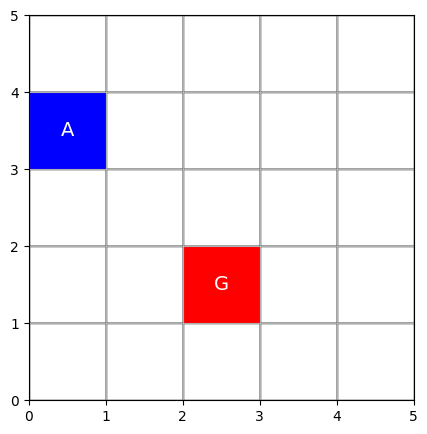

<Figure size 640x480 with 0 Axes>

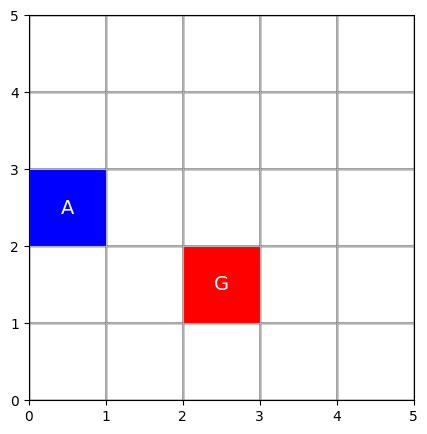

<Figure size 640x480 with 0 Axes>

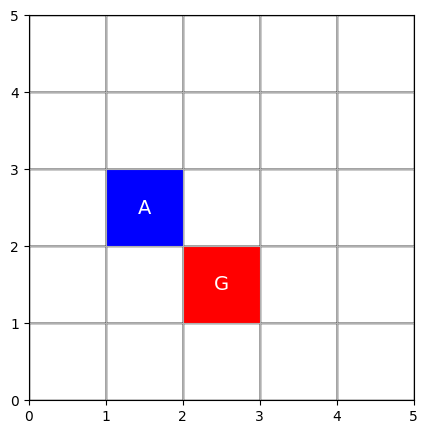

<Figure size 640x480 with 0 Axes>

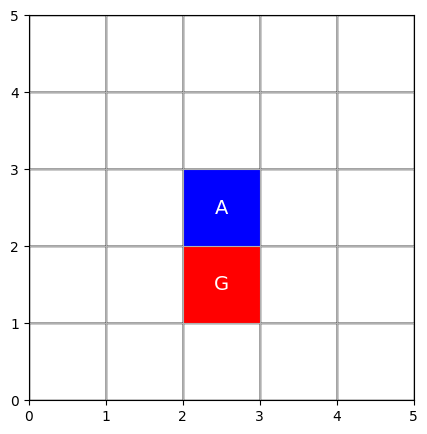

<Figure size 640x480 with 0 Axes>

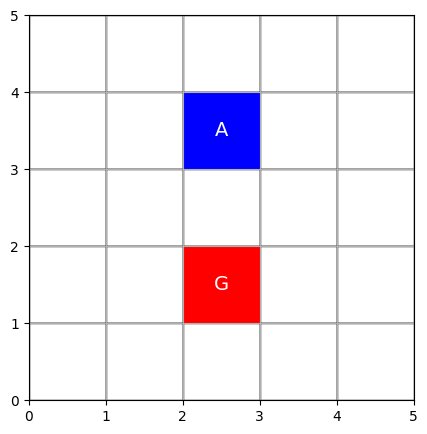

<Figure size 640x480 with 0 Axes>

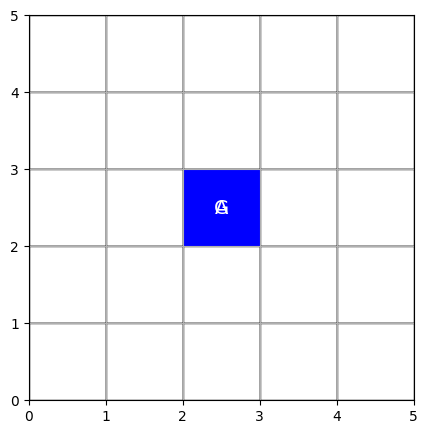

<Figure size 640x480 with 0 Axes>

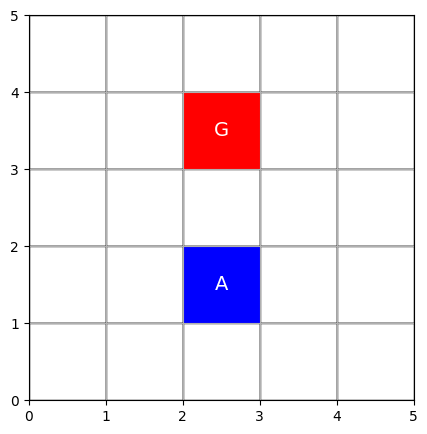

<Figure size 640x480 with 0 Axes>

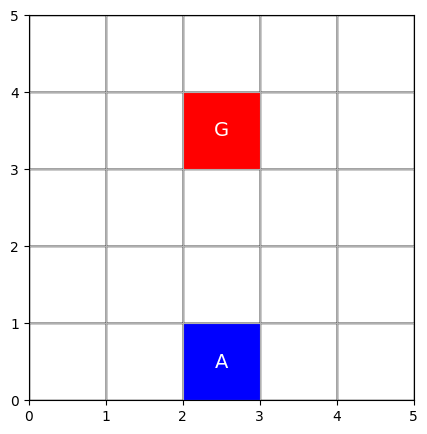

<Figure size 640x480 with 0 Axes>

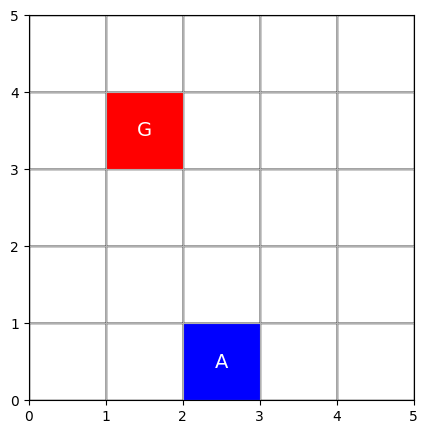

<Figure size 640x480 with 0 Axes>

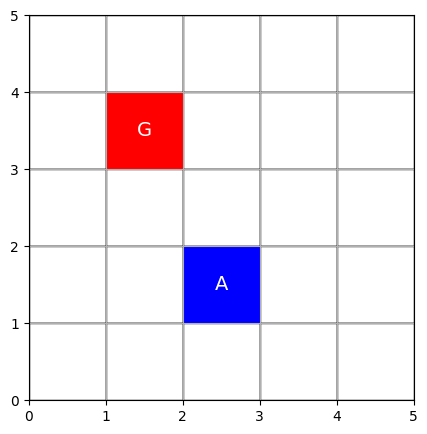

<Figure size 640x480 with 0 Axes>

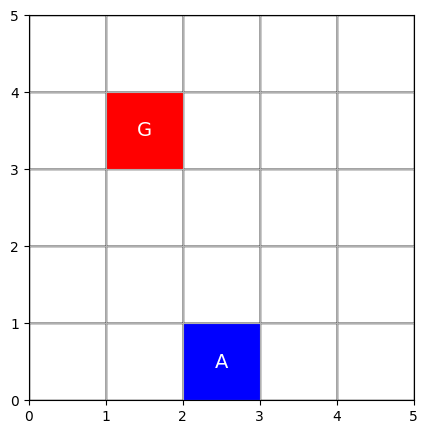

<Figure size 640x480 with 0 Axes>

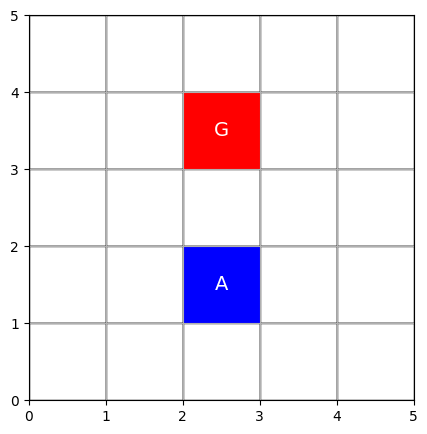

<Figure size 640x480 with 0 Axes>

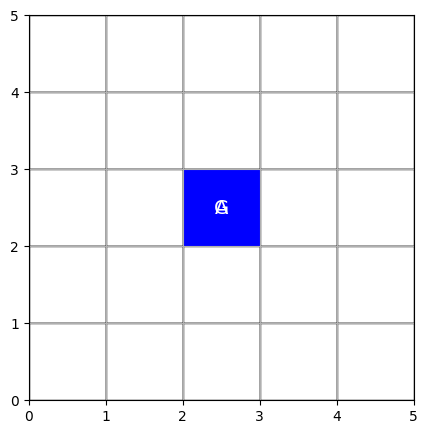

<Figure size 640x480 with 0 Axes>

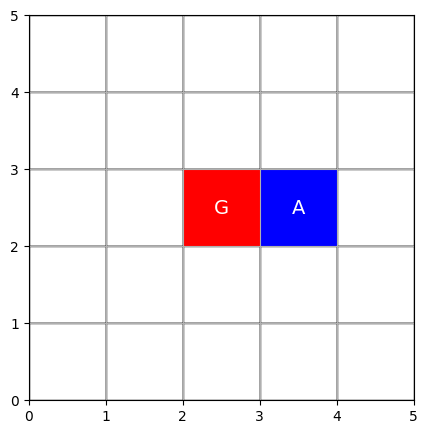

<Figure size 640x480 with 0 Axes>

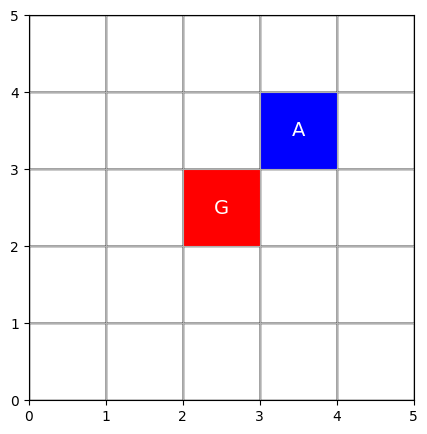

<Figure size 640x480 with 0 Axes>

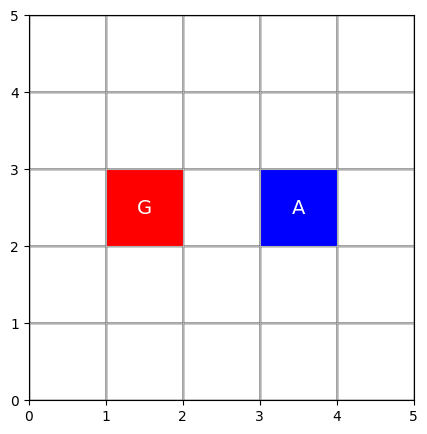

<Figure size 640x480 with 0 Axes>

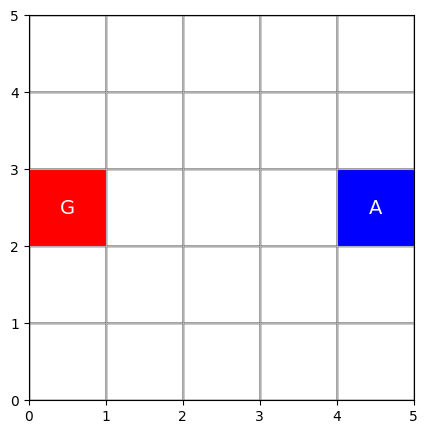

<Figure size 640x480 with 0 Axes>

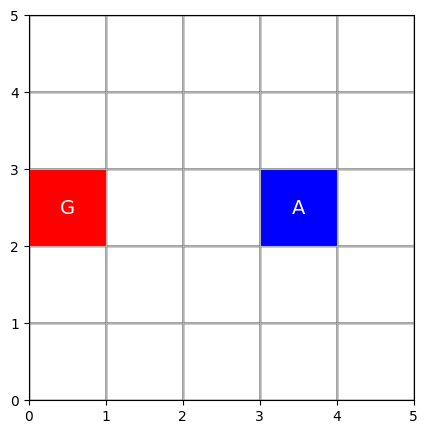

<Figure size 640x480 with 0 Axes>

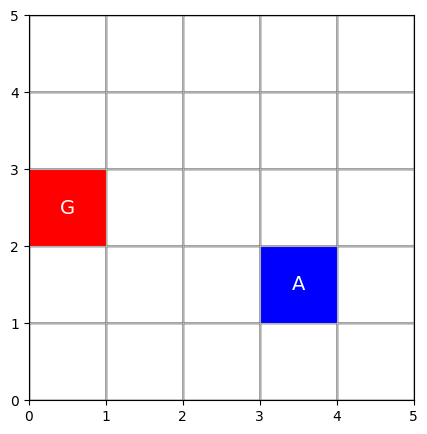

<Figure size 640x480 with 0 Axes>

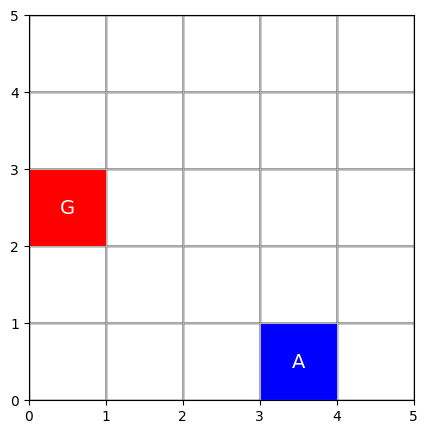

<Figure size 640x480 with 0 Axes>

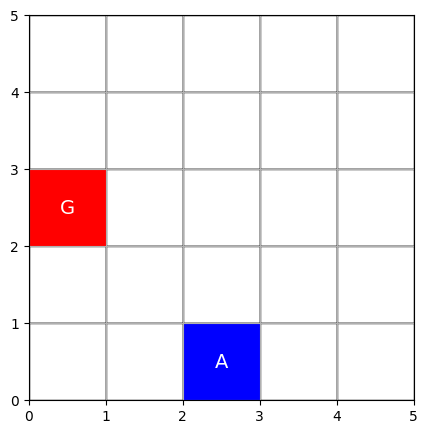

<Figure size 640x480 with 0 Axes>

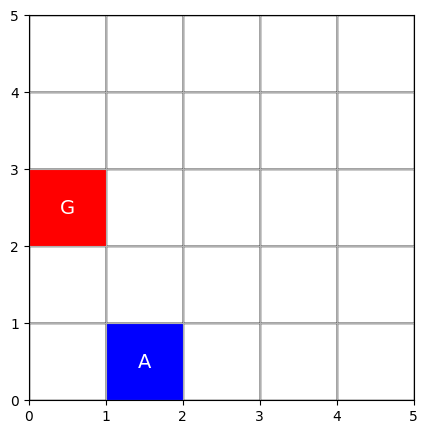

<Figure size 640x480 with 0 Axes>

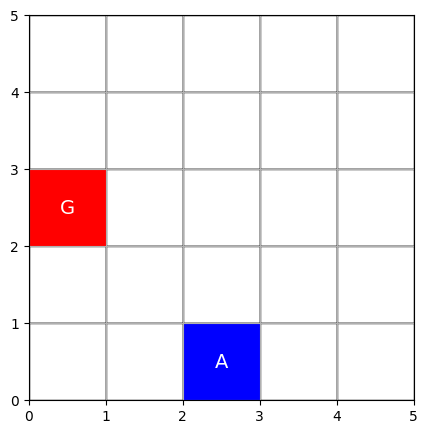

<Figure size 640x480 with 0 Axes>

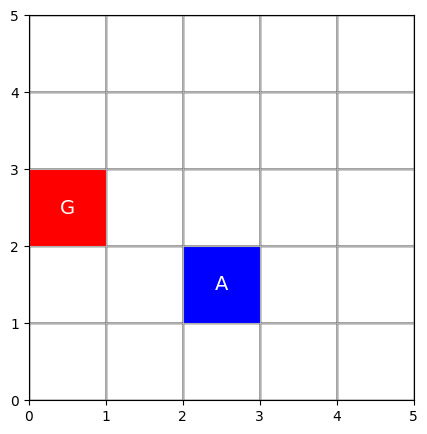

<Figure size 640x480 with 0 Axes>

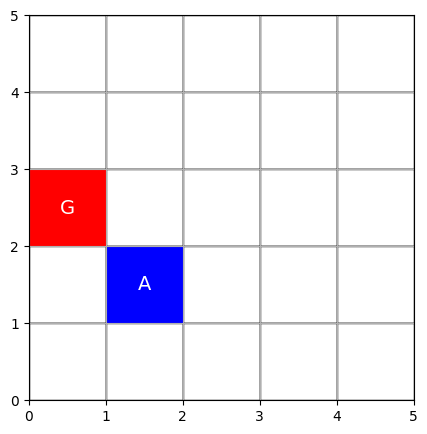

<Figure size 640x480 with 0 Axes>

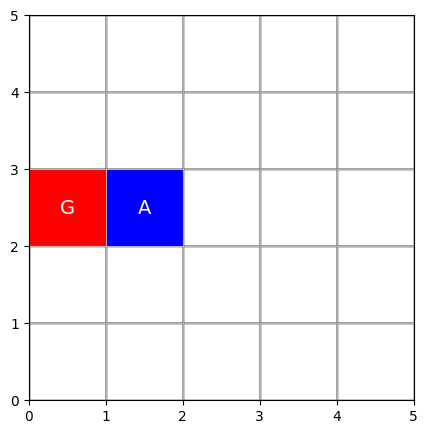

<Figure size 640x480 with 0 Axes>

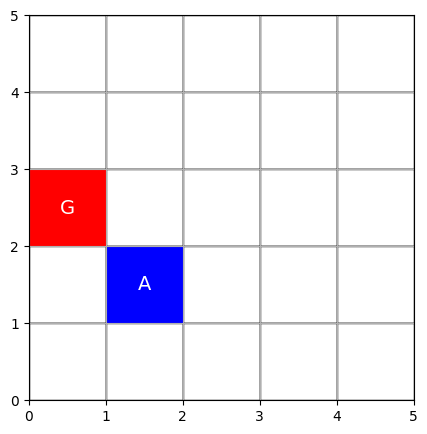

<Figure size 640x480 with 0 Axes>

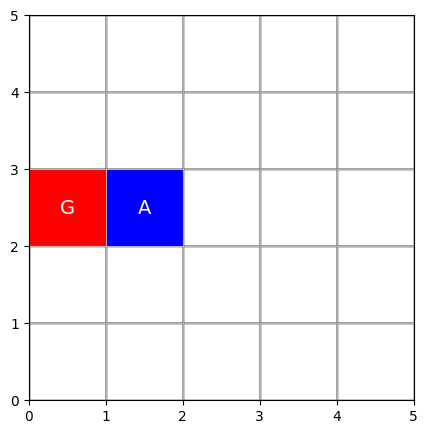

<Figure size 640x480 with 0 Axes>

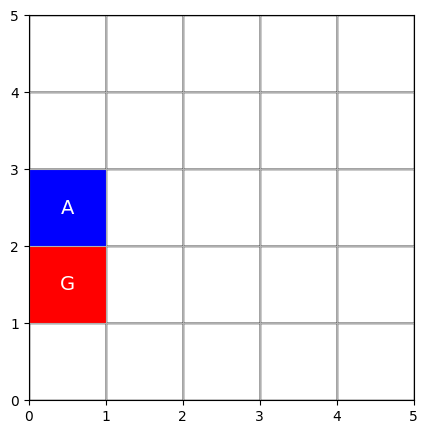

Episode 25/200 - Reward: 0.62


<Figure size 640x480 with 0 Axes>

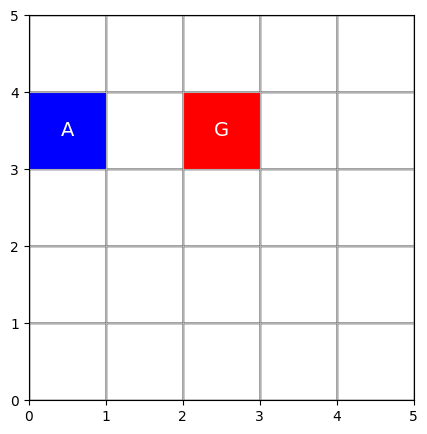

<Figure size 640x480 with 0 Axes>

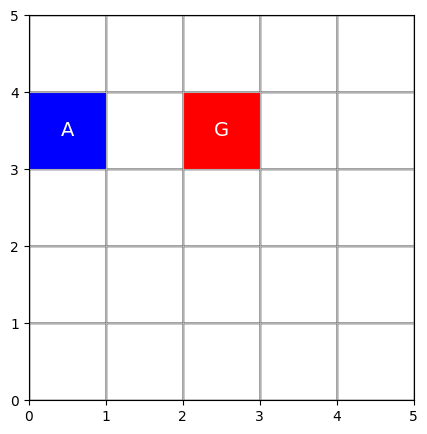

<Figure size 640x480 with 0 Axes>

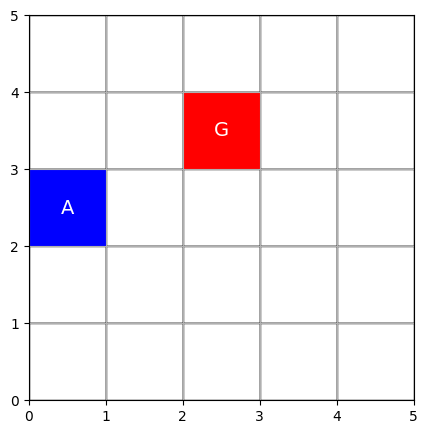

KeyboardInterrupt: 

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# =======================
# 1️⃣ ENVIRONNEMENT
# =======================
class GridWorld:
    def __init__(self, size=5):
        self.size = size
        self.reset()

    def reset(self):
        self.agent_pos = np.array([0, 0])
        self.goal_pos = np.random.randint(0, self.size, size=2)
        return self._get_state()

    def step(self, action):
        """Actions: 0=up, 1=down, 2=left, 3=right"""
        moves = {0: (-1, 0), 1: (1, 0), 2: (0, -1), 3: (0, 1)}
        move = moves[action]
        new_pos = self.agent_pos + np.array(move)
        new_pos = np.clip(new_pos, 0, self.size - 1)
        self.agent_pos = new_pos

        # Reward
        if np.array_equal(self.agent_pos, self.goal_pos):
            reward = 1.0
            done = True
        else:
            reward = -0.01
            done = False

        # Dynamic goal: move randomly
        if random.random() < 0.3:  # 30% chance to move goal
            self.goal_pos += random.choice([[1,0],[-1,0],[0,1],[0,-1]])
            self.goal_pos = np.clip(self.goal_pos, 0, self.size - 1)

        return self._get_state(), reward, done

    def _get_state(self):
        # Raw input: (x_agent, y_agent, x_goal, y_goal)
        return np.concatenate((self.agent_pos, self.goal_pos)).astype(np.float32) / self.size

    def render(self):
        fig, ax = plt.subplots(figsize=(5,5))
        for i in range(self.size):
            for j in range(self.size):
                rect = patches.Rectangle((j, self.size-1-i), 1, 1,
                                         linewidth=1, edgecolor='black', facecolor='white')
                ax.add_patch(rect)

        # Draw goal
        gx, gy = self.goal_pos
        ax.add_patch(patches.Rectangle((gy, self.size-1-gx), 1, 1, facecolor='red'))
        ax.text(gy+0.5, self.size-1-gx+0.5, 'G', ha='center', va='center', color='white', fontsize=14)

        # Draw agent
        ax.add_patch(patches.Rectangle((self.agent_pos[1], self.size-1-self.agent_pos[0]), 1, 1, facecolor='blue'))
        ax.text(self.agent_pos[1]+0.5, self.size-1-self.agent_pos[0]+0.5, 'A', ha='center', va='center', color='white', fontsize=14)

        ax.set_xlim(0, self.size)
        ax.set_ylim(0, self.size)
        ax.set_xticks(range(self.size+1))
        ax.set_yticks(range(self.size+1))
        ax.set_aspect('equal')
        plt.grid(True)
        plt.show(block=False)
        plt.pause(0.3)
        plt.clf()


# =======================
# 2️⃣ DQN AGENT
# =======================
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.net(x)


class Agent:
    def __init__(self, state_dim, action_dim, lr=1e-3, gamma=0.99):
        self.model = DQN(state_dim, action_dim)
        self.target_model = DQN(state_dim, action_dim)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.gamma = gamma
        self.epsilon = 1.0
        self.memory = []
        self.batch_size = 64

    def act(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, 3)
        state = torch.FloatTensor(state).unsqueeze(0)
        q_values = self.model(state)
        return q_values.argmax().item()

    def remember(self, s, a, r, s_next, done):
        self.memory.append((s, a, r, s_next, done))
        if len(self.memory) > 5000:
            self.memory.pop(0)

    def learn(self):
        if len(self.memory) < self.batch_size:
            return

        batch = random.sample(self.memory, self.batch_size)
        s, a, r, s_next, done = zip(*batch)
        s = torch.FloatTensor(s)
        a = torch.LongTensor(a).unsqueeze(1)
        r = torch.FloatTensor(r).unsqueeze(1)
        s_next = torch.FloatTensor(s_next)
        done = torch.FloatTensor(done).unsqueeze(1)

        q_values = self.model(s).gather(1, a)
        with torch.no_grad():
            q_next = self.target_model(s_next).max(1)[0].unsqueeze(1)
            q_target = r + self.gamma * q_next * (1 - done)

        loss = nn.MSELoss()(q_values, q_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target(self):
        self.target_model.load_state_dict(self.model.state_dict())


# =======================
# 3️⃣ TRAINING LOOP
# =======================
env = GridWorld(size=5)
agent = Agent(state_dim=4, action_dim=4)

episodes = 200
rewards_per_episode = []

for ep in range(episodes):
    s = env.reset()
    total_reward = 0
    for t in range(50):
        a = agent.act(s)
        s_next, r, done = env.step(a)
        agent.remember(s, a, r, s_next, done)
        agent.learn()
        s = s_next
        total_reward += r
        env.render()
        if done:
            break

    rewards_per_episode.append(total_reward)
    agent.update_target()
    agent.epsilon = max(0.05, agent.epsilon * 0.99)
    print(f"Episode {ep+1}/{episodes} - Reward: {total_reward:.2f}")

plt.plot(rewards_per_episode)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Training Performance (DQN with Dynamic Goal)')
plt.show()
plt.close()


# advanced env

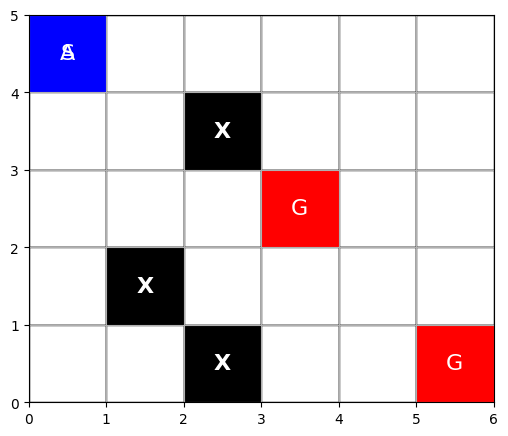

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

class GridWorld:
    def __init__(self,
                 size=(4,4),              # shape of grid (rows, cols)
                 start=(0,0),             # start position
                 goals=[(3,3)],           # list of goal positions
                 obstacles=[],            # list of obstacle positions
                 agent_color='green',     # agent color
                 goal_color='red',        # goal color
                 obstacle_color='gray'):  # obstacle color

        self.rows, self.cols = size
        self.start = start
        self.state = start
        self.goals = goals
        self.obstacles = obstacles
        self.agent_color = agent_color
        self.goal_color = goal_color
        self.obstacle_color = obstacle_color

    def reset(self):
        self.state = self.start
        return self.state

    def render(self):
        fig, ax = plt.subplots(figsize=(6,6))

        # Draw grid
        for i in range(self.rows):
            for j in range(self.cols):
                rect = patches.Rectangle((j, self.rows-1-i), 1, 1,
                                         linewidth=1, edgecolor='black', facecolor='white')
                ax.add_patch(rect)

        # Draw obstacles
        for (x, y) in self.obstacles:
            ax.add_patch(patches.Rectangle((y, self.rows-1-x), 1, 1, facecolor=self.obstacle_color))
            ax.text(y+0.5, self.rows-1-x+0.5, 'X', ha='center', va='center', color='white', fontsize=16, weight='bold')

        # Draw goals
        for (gx, gy) in self.goals:
            ax.add_patch(patches.Rectangle((gy, self.rows-1-gx), 1, 1, facecolor=self.goal_color))
            ax.text(gy+0.5, self.rows-1-gx+0.5, 'G', ha='center', va='center', color='white', fontsize=16)

        # Draw start
        sx, sy = self.start
        ax.add_patch(patches.Rectangle((sy, self.rows-1-sx), 1, 1, facecolor='orange'))
        ax.text(sy+0.5, self.rows-1-sx+0.5, 'S', ha='center', va='center', color='white', fontsize=16)

        # Draw agent
        ax.add_patch(patches.Rectangle((self.state[1], self.rows-1-self.state[0]), 1, 1, facecolor=self.agent_color))
        ax.text(self.state[1]+0.5, self.rows-1-self.state[0]+0.5, 'A', ha='center', va='center', color='white', fontsize=16)

        ax.set_xlim(0, self.cols)
        ax.set_ylim(0, self.rows)
        ax.set_xticks(range(self.cols+1))
        ax.set_yticks(range(self.rows+1))
        ax.set_aspect('equal')
        plt.grid(True)
        plt.show(block=False)
        plt.pause(1)
        plt.clf()


# Exemple d'utilisation
env = GridWorld(
    size=(5,6),
    start=(0,0),
    goals=[(4,5), (2,3)],
    obstacles=[(1,2), (3,1), (4,2)],
    agent_color='blue',
    goal_color='red',
    obstacle_color='black'
)

env.reset()
env.render()
plt.close()


# no dynamic goal

Episode 1/400 | Reward=-9.51 | Epsilon=0.995
Episode 2/400 | Reward=-5.55 | Epsilon=0.990
Episode 3/400 | Reward=-0.37 | Epsilon=0.985
Episode 4/400 | Reward=-6.54 | Epsilon=0.980
Episode 5/400 | Reward=-5.48 | Epsilon=0.975
Episode 6/400 | Reward=-1.39 | Epsilon=0.970
Episode 7/400 | Reward=-0.35 | Epsilon=0.966
Episode 8/400 | Reward=-7.53 | Epsilon=0.961
Episode 9/400 | Reward=-1.28 | Epsilon=0.956
Episode 10/400 | Reward=-4.56 | Epsilon=0.951
Episode 11/400 | Reward=-6.54 | Epsilon=0.946
Episode 12/400 | Reward=-9.51 | Epsilon=0.942
Episode 13/400 | Reward=-0.58 | Epsilon=0.937
Episode 14/400 | Reward=-8.52 | Epsilon=0.932
Episode 15/400 | Reward=-5.55 | Epsilon=0.928
Episode 16/400 | Reward=0.82 | Epsilon=0.923
Episode 17/400 | Reward=-6.22 | Epsilon=0.918
Episode 18/400 | Reward=-6.54 | Epsilon=0.914
Episode 19/400 | Reward=-10.50 | Epsilon=0.909
Episode 20/400 | Reward=-1.10 | Epsilon=0.905
Episode 21/400 | Reward=-8.52 | Epsilon=0.900
Episode 22/400 | Reward=0.63 | Epsilon=0.89

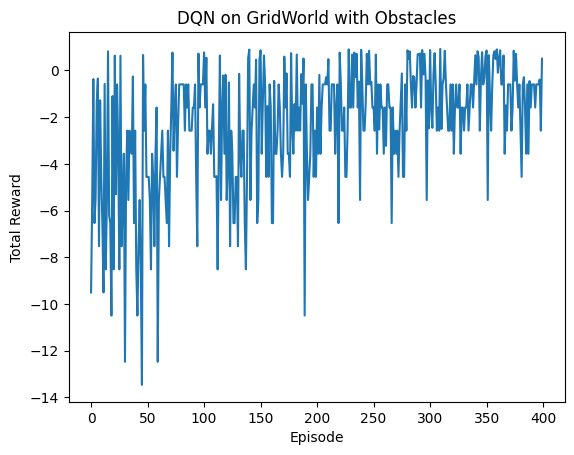

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt


# =====================================================
# ✅ ENVIRONNEMENT : ton GridWorld + logique RL
# =====================================================
class GridWorld:
    def __init__(self,
                 size=(5, 6),
                 start=(0, 0),
                 goals=[(4, 5)],
                 obstacles=[(1, 2), (3, 1), (4, 2)]):

        self.rows, self.cols = size
        self.start = np.array(start)
        self.state = np.array(start)
        self.goals = goals
        self.obstacles = obstacles

        self.actions = {
            0: (-1, 0),  # up
            1: (1, 0),   # down
            2: (0, -1),  # left
            3: (0, 1)    # right
        }

    def reset(self):
        self.state = self.start.copy()
        return self._get_state()

    def step(self, action):
        move = np.array(self.actions[action])
        new_state = self.state + move

        # stay inside grid
        new_state[0] = np.clip(new_state[0], 0, self.rows - 1)
        new_state[1] = np.clip(new_state[1], 0, self.cols - 1)

        # check obstacle
        if tuple(new_state) in self.obstacles:
            reward = -1.0
            done = False
        elif tuple(new_state) in self.goals:
            reward = 1.0
            done = True
        else:
            reward = -0.01
            done = False

        self.state = new_state
        return self._get_state(), reward, done

    def _get_state(self):
        # Normalized state = [agent_row, agent_col, goal_row, goal_col]
        # Use nearest goal (for multi-goal setup)
        gx, gy = self.goals[0]
        return np.array([self.state[0]/self.rows,
                         self.state[1]/self.cols,
                         gx/self.rows,
                         gy/self.cols], dtype=np.float32)


# =====================================================
# ✅ RÉSEAU DE Q-APPROXIMATION (DQN)
# =====================================================
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.net(x)


class Agent:
    def __init__(self, state_dim, action_dim, lr=1e-3, gamma=0.99):
        self.model = DQN(state_dim, action_dim)
        self.target_model = DQN(state_dim, action_dim)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.gamma = gamma
        self.epsilon = 1.0
        self.memory = []
        self.batch_size = 64

    def act(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, 3)
        state = torch.FloatTensor(state).unsqueeze(0)
        q_values = self.model(state)
        return q_values.argmax().item()

    def remember(self, s, a, r, s_next, done):
        self.memory.append((s, a, r, s_next, done))
        if len(self.memory) > 10000:
            self.memory.pop(0)

    def learn(self):
        if len(self.memory) < self.batch_size:
            return

        batch = random.sample(self.memory, self.batch_size)
        s, a, r, s_next, done = zip(*batch)
        s = torch.FloatTensor(s)
        a = torch.LongTensor(a).unsqueeze(1)
        r = torch.FloatTensor(r).unsqueeze(1)
        s_next = torch.FloatTensor(s_next)
        done = torch.FloatTensor(done).unsqueeze(1)

        q_values = self.model(s).gather(1, a)
        with torch.no_grad():
            q_next = self.target_model(s_next).max(1)[0].unsqueeze(1)
            q_target = r + self.gamma * q_next * (1 - done)

        loss = nn.MSELoss()(q_values, q_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target(self):
        self.target_model.load_state_dict(self.model.state_dict())


# =====================================================
# ✅ ENTRAÎNEMENT DU DQN
# =====================================================
env = GridWorld()
agent = Agent(state_dim=4, action_dim=4)

episodes = 400
rewards_per_episode = []

for ep in range(episodes):
    s = env.reset()
    total_reward = 0
    for t in range(60):
        a = agent.act(s)
        s_next, r, done = env.step(a)
        agent.remember(s, a, r, s_next, done)
        agent.learn()
        s = s_next
        total_reward += r
        if done:
            break

    rewards_per_episode.append(total_reward)
    agent.update_target()
    agent.epsilon = max(0.05, agent.epsilon * 0.995)
    print(f"Episode {ep+1}/{episodes} | Reward={total_reward:.2f} | Epsilon={agent.epsilon:.3f}")

# =====================================================
# ✅ COURBE D’APPRENTISSAGE
# =====================================================
plt.plot(rewards_per_episode)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("DQN on GridWorld with Obstacles")
plt.show()


# with dymanic goal

Episode 1/800 | Reward=-12.68 | Eps=0.995
Episode 2/800 | Reward=1.00 | Eps=0.990
Episode 3/800 | Reward=1.00 | Eps=0.985
Episode 4/800 | Reward=-4.37 | Eps=0.980
Episode 5/800 | Reward=-4.40 | Eps=0.975
Episode 6/800 | Reward=-3.33 | Eps=0.970
Episode 7/800 | Reward=-1.23 | Eps=0.966
Episode 8/800 | Reward=0.97 | Eps=0.961
Episode 9/800 | Reward=-0.22 | Eps=0.956
Episode 10/800 | Reward=-3.65 | Eps=0.951
Episode 11/800 | Reward=0.99 | Eps=0.946
Episode 12/800 | Reward=-0.27 | Eps=0.942
Episode 13/800 | Reward=-6.74 | Eps=0.937
Episode 14/800 | Reward=0.89 | Eps=0.932
Episode 15/800 | Reward=-3.77 | Eps=0.928
Episode 16/800 | Reward=-11.69 | Eps=0.923
Episode 17/800 | Reward=-1.79 | Eps=0.918
Episode 18/800 | Reward=-5.37 | Eps=0.914
Episode 19/800 | Reward=-3.60 | Eps=0.909
Episode 20/800 | Reward=-9.71 | Eps=0.905
Episode 21/800 | Reward=-6.74 | Eps=0.900
Episode 22/800 | Reward=-16.64 | Eps=0.896
Episode 23/800 | Reward=-1.13 | Eps=0.891
Episode 24/800 | Reward=-2.29 | Eps=0.887
Epi

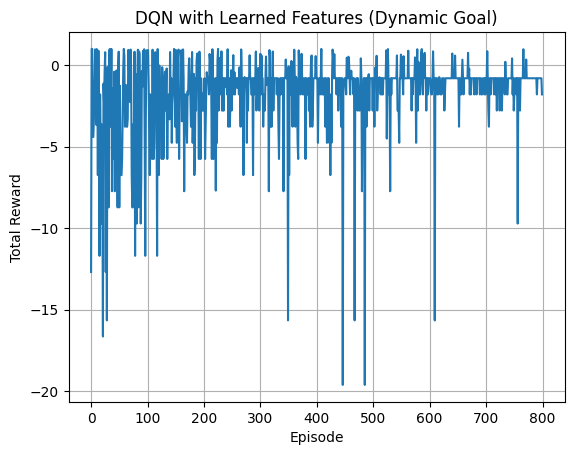

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt

# =====================================================
# ✅ ENVIRONMENT — GridWorld with dynamic goal
# =====================================================
class GridWorld:
    def __init__(self,
                 size=(5, 6),
                 start=(0, 0),
                 goals=[(4, 5)],
                 obstacles=[(1, 2), (3, 1), (4, 2)]):
        self.rows, self.cols = size
        self.start = np.array(start)
        self.state = np.array(start)
        self.goals = goals
        self.obstacles = obstacles
        self.actions = {
            0: (-1, 0),  # up
            1: (1, 0),   # down
            2: (0, -1),  # left
            3: (0, 1)    # right
        }

    def reset(self):
        self.state = self.start.copy()
        # 🔄 Move goal dynamically each episode
        self.goals = [self._random_goal()]
        return self._get_obs()

    def _random_goal(self):
        while True:
            g = (np.random.randint(0, self.rows), np.random.randint(0, self.cols))
            if g != tuple(self.start) and g not in self.obstacles:
                return g

    def step(self, action):
        move = np.array(self.actions[action])
        new_state = self.state + move
        new_state[0] = np.clip(new_state[0], 0, self.rows - 1)
        new_state[1] = np.clip(new_state[1], 0, self.cols - 1)

        reward = -0.01
        done = False
        if tuple(new_state) in self.obstacles:
            reward = -1.0
        elif tuple(new_state) in self.goals:
            reward = 1.0
            done = True

        self.state = new_state
        return self._get_obs(), reward, done

    def _get_obs(self):
        """Return a flattened grid representation (learnable features)"""
        grid = np.zeros((self.rows, self.cols), dtype=np.float32)
        # Obstacles
        for (x, y) in self.obstacles:
            grid[x, y] = -1.0
        # Goal
        gx, gy = self.goals[0]
        grid[gx, gy] = 2.0
        # Agent
        x, y = self.state
        grid[x, y] = 1.0
        return grid.flatten()  # raw grid (features learned by NN)


# =====================================================
# ✅ DQN Agent (feature extractor + Q-network)
# =====================================================
class FeatureDQN(nn.Module):
    def __init__(self, input_dim, action_dim):
        super(FeatureDQN, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )
        self.q_head = nn.Linear(64, action_dim)

    def forward(self, x):
        features = self.feature_extractor(x)
        q_values = self.q_head(features)
        return q_values


class Agent:
    def __init__(self, state_dim, action_dim, lr=1e-3, gamma=0.99):
        self.model = FeatureDQN(state_dim, action_dim)
        self.target_model = FeatureDQN(state_dim, action_dim)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.gamma = gamma
        self.epsilon = 1.0
        self.memory = []
        self.batch_size = 64

    def act(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, 3)
        state = torch.FloatTensor(state).unsqueeze(0)
        q_values = self.model(state)
        return q_values.argmax().item()

    def remember(self, s, a, r, s_next, done):
        self.memory.append((s, a, r, s_next, done))
        if len(self.memory) > 10000:
            self.memory.pop(0)

    def learn(self):
        if len(self.memory) < self.batch_size:
            return

        batch = random.sample(self.memory, self.batch_size)
        s, a, r, s_next, done = zip(*batch)
        s = torch.FloatTensor(s)
        a = torch.LongTensor(a).unsqueeze(1)
        r = torch.FloatTensor(r).unsqueeze(1)
        s_next = torch.FloatTensor(s_next)
        done = torch.FloatTensor(done).unsqueeze(1)

        q_values = self.model(s).gather(1, a)
        with torch.no_grad():
            q_next = self.target_model(s_next).max(1)[0].unsqueeze(1)
            q_target = r + self.gamma * q_next * (1 - done)

        loss = nn.MSELoss()(q_values, q_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target(self):
        self.target_model.load_state_dict(self.model.state_dict())


# =====================================================
# ✅ TRAINING
# =====================================================
env = GridWorld()
state_dim = env.rows * env.cols
agent = Agent(state_dim=state_dim, action_dim=4)

episodes = 800
rewards_per_episode = []

for ep in range(episodes):
    s = env.reset()
    total_reward = 0
    for t in range(80):
        a = agent.act(s)
        s_next, r, done = env.step(a)
        agent.remember(s, a, r, s_next, done)
        agent.learn()
        s = s_next
        total_reward += r
        if done:
            break

    rewards_per_episode.append(total_reward)
    agent.update_target()
    agent.epsilon = max(0.05, agent.epsilon * 0.995)
    print(f"Episode {ep+1}/{episodes} | Reward={total_reward:.2f} | Eps={agent.epsilon:.3f}")

# =====================================================
# ✅ Plot Reward Curve
# =====================================================
plt.plot(rewards_per_episode)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("DQN with Learned Features (Dynamic Goal)")
plt.grid(True)
plt.show()


# ma **propre** version personnalisée de DQN

# custom DQN

In [ ]:
import torch
import torch.nn as nn

class CustomDQN(nn.Module):
    def __init__(self, input_dim, action_dim):
        super().__init__()

        # Feature extractor (tu peux modifier ici !)
        self.feature_net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )

        # Head (sortie Q-values)
        self.q_head = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, action_dim)
        )

    def forward(self, x):
        features = self.feature_net(x)
        q_values = self.q_head(features)
        return q_values


# Replay Buffer

In [ ]:
import random
import numpy as np
from collections import deque

class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = map(np.array, zip(*batch))
        return states, actions, rewards, next_states, dones

    def size(self):
        return len(self.buffer)


# – L’Agent (entraînement + interaction)

In [ ]:
import torch.optim as optim
import torch.nn.functional as F

class AgentDQN:
    def __init__(self, state_dim, action_dim):
        self.model = CustomDQN(state_dim, action_dim)
        self.target_model = CustomDQN(state_dim, action_dim)
        self.target_model.load_state_dict(self.model.state_dict())

        self.buffer = ReplayBuffer(5000)
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.05

    def act(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(0, 4)  # random action
        state = torch.FloatTensor(state).unsqueeze(0)
        q_values = self.model(state)
        return torch.argmax(q_values).item()

    def train_step(self, batch_size=64):
        if self.buffer.size() < batch_size:
            return

        states, actions, rewards, next_states, dones = self.buffer.sample(batch_size)
        states = torch.FloatTensor(states)
        next_states = torch.FloatTensor(next_states)
        actions = torch.LongTensor(actions)
        rewards = torch.FloatTensor(rewards)
        dones = torch.FloatTensor(dones)

        # Q(s, a)
        q_values = self.model(states)
        q_value = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)

        # Q_target = r + γ * max_a' Q_target(s', a')
        next_q_values = self.target_model(next_states)
        next_q_value = next_q_values.max(1)[0]
        expected_q = rewards + self.gamma * next_q_value * (1 - dones)

        loss = F.mse_loss(q_value, expected_q.detach())
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # decay epsilon
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

    def update_target(self):
        self.target_model.load_state_dict(self.model.state_dict())


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
from collections import deque

# ======================
# 🚀 ENVIRONNEMENT GRID
# ======================
class GridWorld:
    def __init__(self, size=4, start=(0,0), goal=(3,3)):
        self.size = size
        self.start = start
        self.goal = goal
        self.state = start
        self.actions = [(0,1), (0,-1), (1,0), (-1,0)]  # right, left, down, up

    def reset(self):
        self.state = self.start
        # 🔁 goal dynamique : change à chaque reset
        self.goal = (np.random.randint(0, self.size), np.random.randint(0, self.size))
        while self.goal == self.start:  # éviter que le goal soit au même endroit que start
            self.goal = (np.random.randint(0, self.size), np.random.randint(0, self.size))
        return np.array(self.state, dtype=np.float32)

    def step(self, action_idx):
        move = self.actions[action_idx]
        x, y = self.state
        nx, ny = x + move[0], y + move[1]
        nx = np.clip(nx, 0, self.size-1)
        ny = np.clip(ny, 0, self.size-1)
        self.state = (nx, ny)

        # Reward
        if self.state == self.goal:
            return np.array(self.state, dtype=np.float32), 10.0, True
        else:
            return np.array(self.state, dtype=np.float32), -0.1, False

# ======================
# 🧠 CUSTOM DQN
# ======================
class CustomDQN(nn.Module):
    def __init__(self, input_dim, action_dim):
        super().__init__()
        self.feature_net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )
        self.q_head = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, action_dim)
        )

    def forward(self, x):
        f = self.feature_net(x)
        q = self.q_head(f)
        return q

# ======================
# 🎯 REPLAY BUFFER
# ======================
class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)

    def add(self, s, a, r, ns, d):
        self.buffer.append((s, a, r, ns, d))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        s, a, r, ns, d = map(np.array, zip(*batch))
        return s, a, r, ns, d

    def size(self):
        return len(self.buffer)

# ======================
# 🤖 AGENT DQN
# ======================
class AgentDQN:
    def __init__(self, state_dim, action_dim):
        self.model = CustomDQN(state_dim, action_dim)
        self.target_model = CustomDQN(state_dim, action_dim)
        self.target_model.load_state_dict(self.model.state_dict())

        self.buffer = ReplayBuffer(500)
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.05

    def act(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(0, 4)
        state_t = torch.FloatTensor(state).unsqueeze(0)
        q_values = self.model(state_t)
        return torch.argmax(q_values).item()

    def train_step(self, batch_size=64):
        if self.buffer.size() < batch_size:
            return
        s, a, r, ns, d = self.buffer.sample(batch_size)
        s = torch.FloatTensor(s)
        ns = torch.FloatTensor(ns)
        a = torch.LongTensor(a)
        r = torch.FloatTensor(r)
        d = torch.FloatTensor(d)

        q_values = self.model(s)
        q_value = q_values.gather(1, a.unsqueeze(1)).squeeze(1)

        next_q_values = self.target_model(ns)
        next_q_value = next_q_values.max(1)[0]
        expected_q = r + self.gamma * next_q_value * (1 - d)

        loss = F.mse_loss(q_value, expected_q.detach())
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

    def update_target(self):
        self.target_model.load_state_dict(self.model.state_dict())

# ======================
# 🏋️‍♂️ TRAINING LOOP
# ======================
env = GridWorld()
agent = AgentDQN(state_dim=2, action_dim=4)

episodes = 200
reward_history = []

for ep in range(episodes):
    state = env.reset()
    done = False
    total_reward = 0

    while not done:
        action = agent.act(state)
        next_state, reward, done = env.step(action)
        agent.buffer.add(state, action, reward, next_state, done)
        agent.train_step()
        state = next_state
        total_reward += reward

    agent.update_target()
    reward_history.append(total_reward)
    print(f"Episode {ep+1}/{episodes} | Reward: {total_reward:.2f} | Eps: {agent.epsilon:.2f}")

# ======================
# 📈 Courbe d'entraînement
# ======================
plt.plot(reward_history)
plt.title("Training Rewards over Episodes (DQN + Dynamic Goal)")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(True)
plt.show()


Episode 1/200 | Reward: 9.30 | Eps: 1.00
Episode 2/200 | Reward: 9.30 | Eps: 1.00
Episode 3/200 | Reward: 9.30 | Eps: 1.00
Episode 4/200 | Reward: 9.00 | Eps: 1.00
Episode 5/200 | Reward: 2.10 | Eps: 0.77
Episode 6/200 | Reward: 9.10 | Eps: 0.73
Episode 7/200 | Reward: 9.10 | Eps: 0.70
Episode 8/200 | Reward: 9.40 | Eps: 0.67
